In [1]:
### Load various libraries that we need
from pathlib import Path
import pandas as pd
import joblib

import seaborn as sns
import numpy as np
from scipy.fft import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt


import sklearn as skl
from sklearn import decomposition, metrics, preprocessing, utils
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from tqdm import tqdm


pd.set_option('display.max_columns' , None)
from google.colab import drive
drive.mount('/content/drive')
Projet = Path('/content/drive/MyDrive/Colab Notebooks/DL challenge')

Mounted at /content/drive


# Feature engeneering

In [2]:
### Weather data :
weather = pd.read_parquet(Projet / "Data/meteo.parquet")

### Calendar data:
train = pd.read_csv(Projet / "Data/train.csv")

### test data:
test = pd.read_csv(Projet / "Data/test.csv")

### Display the dimensions:
train.shape, weather.shape, test.shape

((85571, 26), (695160, 82), (17518, 1))

In [3]:
train.dropna(how = 'any', axis = 0, inplace=True)

We keep locations in a list

In [4]:
locations = list(train.columns)
locations.remove('date')
regions = locations.copy()
regions.remove('France')
metropoles = []

for location in locations:
  if 'Métropole' in location:
    metropoles.append(location)
    regions.remove(location)

We create a dictionary to store where every station is

In [5]:
dict_locations = {}
dict_locations['France'] = weather['numer_sta'].unique()
for region in regions:
  dict_locations[region] = weather[weather['nom_reg'] == region]['numer_sta'].unique()

We create an other dictionary to store in which regions are each metropole

In [6]:
dict_metropoles = {}
dict_metropoles['Montpellier Méditerranée Métropole'] = 'Occitanie'
dict_metropoles['Métropole Européenne de Lille'] = 'Hauts-de-France'
dict_metropoles['Métropole Grenoble-Alpes-Métropole'] = "Provence-Alpes-Côte d'Azur"
dict_metropoles["Métropole Nice Côte d'Azur"] = "Provence-Alpes-Côte d'Azur"
dict_metropoles['Métropole Rennes Métropole'] = 'Bretagne'
dict_metropoles['Métropole Rouen Normandie'] = 'Normandie'
dict_metropoles["Métropole d'Aix-Marseille-Provence"] = "Provence-Alpes-Côte d'Azur"
dict_metropoles['Métropole de Lyon'] = 'Auvergne-Rhône-Alpes'
dict_metropoles['Métropole du Grand Nancy'] = 'Grand Est'
dict_metropoles['Métropole du Grand Paris'] = 'Île-de-France'
dict_metropoles['Nantes Métropole'] = 'Pays de la Loire'
dict_metropoles['Toulouse Métropole'] = 'Occitanie'

We convert the date formats for both *weather* and *train*

In [7]:
def time_zone_convertion(df):
    df_copy = df.copy()
    df_copy['date'] = pd.to_datetime(df_copy['date'], utc = True)
    df_copy.set_index('date', inplace = True)
    df_copy = df_copy.tz_convert(tz = 'UTC+01:00')
    df_copy.reset_index(inplace=True)
    return(df_copy)

In [8]:
train = time_zone_convertion(train)
weather = time_zone_convertion(weather)
test = time_zone_convertion(test)

While viewing the *dataset* contained in *meteo.parquet*, we saw that it contained a lot of columns which have NaN values, or only 0 values.

In this cell we select an $\alpha \in [0, 1]$ such that we get rid of every column that has a proportion of **NaN** (or **None**) values that exceeds $\alpha$.

For a start, we choose $\alpha$ to be 0.5. We assume that if half of a column does not give us any *information*, we get rid of it

In [9]:
def drop_NaN_columns(df, alpha = 0.5):
    columns_to_drop = []
    for c in df.columns:
        if df[c].isna().sum()/len(df[c]) > alpha:
          columns_to_drop.append(c)
    return(df.drop(columns_to_drop, axis= 1))

In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695160 entries, 0 to 695159
Data columns (total 82 columns):
 #   Column                         Non-Null Count   Dtype                    
---  ------                         --------------   -----                    
 0   date                           695160 non-null  datetime64[ms, UTC+01:00]
 1   numer_sta                      695160 non-null  object                   
 2   pmer                           650676 non-null  float64                  
 3   tend                           686386 non-null  float64                  
 4   cod_tend                       686386 non-null  object                   
 5   dd                             692663 non-null  float64                  
 6   ff                             692750 non-null  float64                  
 7   t                              685752 non-null  float64                  
 8   td                             685259 non-null  float64                  
 9   u              

In [11]:
weather['nbas'] = weather['nbas'].astype(np.float64, errors='ignore')
weather['geop'] = weather['geop'].astype(np.float64, errors='ignore')

weather.drop(['mois_de_l_annee', 'coordonnees', 'nom', 'cod_tend', 'ww', 'etat_sol', 'type_de_tendance_barometrique', 'temps_present', 'libgeo', 'codegeo', 'nom_epci', 'code_epci', 'nom_dept', 'code_dep', 'nom_reg', 'code_reg'], axis = 1, inplace = True)

In [12]:
weather = drop_NaN_columns(weather, 0.02)
weather.shape

(695160, 16)

### In the section, we will be focusing on how to merge the *weather* data and the *train* data.

To do so, we thought of merging on two datasets on the basis of the *date* attribute. On a closer look into the datasets of *weather* and *calendar*, we see that there are some missing information on the first. To make things harmounious, we tought of interpolating our data in *weather* so as to match the data of *calendar*   


### Interpolation on the *dataset weather*:

In [13]:
#First, lets reshape our weather dataset to have a single row at each time
def flatten_features(old_df, features, date_range = pd.concat([train[['date']], test[['date']]])):
  df_filtered = old_df.copy()
  df_flat = date_range
  for sta in df_filtered['numer_sta'].unique():
    for feature in features:
      col = pd.DataFrame()
      col[['date',feature+'_'+str(sta)]] = df_filtered.loc[df_filtered['numer_sta'] == sta][['date']+[feature]]
      df_flat = pd.merge(df_flat, col, on='date', how='left')
  return(df_flat)

In [14]:
#We select the non numerical columns
non_numerical_columns = weather.select_dtypes(exclude=['number']).columns
numerical_columns = weather.select_dtypes(include=['number'])
non_numerical_columns = list(non_numerical_columns)
numerical_columns = list(numerical_columns)
non_numerical_columns.remove('date')

In [15]:
numerical_columns, len(weather['numer_sta'].unique())

(['tend',
  'dd',
  'ff',
  't',
  'td',
  'u',
  'pres',
  'rafper',
  'per',
  'rr3',
  'tc',
  'latitude',
  'longitude',
  'altitude'],
 40)

In [ ]:
features_to_flatten = list(weather.columns)
features_to_flatten.remove('date')
features_to_flatten.remove('numer_sta')
weather = flatten_features(weather, features = features_to_flatten)
weather.shape

(90205, 561)

In [16]:
def interpolate_df(df = weather):
  expanded_weather = pd.DataFrame()

  # Create a new DataFrame with 30-minute intervals
  date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='30min')
  new_df = pd.DataFrame({'date': date_range})

  # Merge the new DataFrame with the weather dataframe
  new_df = pd.merge(new_df, df, on='date', how='left')

  # Interpolate for all numerical values
  new_df.set_index('date', inplace=True)
  new_df.interpolate(method='time', inplace=True)
  new_df.reset_index(inplace=True)
  return(new_df)

In [ ]:
weather = interpolate_df(weather)

In [ ]:
weather.head(40)

,date,tend_07020,dd_07020,ff_07020,t_07020,td_07020,u_07020,pres_07020,rafper_07020,per_07020,rr3_07020,tc_07020,latitude_07020,longitude_07020,altitude_07020,tend_07558,dd_07558,ff_07558,t_07558,td_07558,u_07558,pres_07558,rafper_07558,per_07558,rr3_07558,tc_07558,latitude_07558,longitude_07558,altitude_07558,tend_07661,dd_07661,ff_07661,t_07661,td_07661,u_07661,pres_07661,rafper_07661,per_07661,rr3_07661,tc_07661,latitude_07661,longitude_07661,altitude_07661,tend_07117,dd_07117,ff_07117,t_07117,td_07117,u_07117,pres_07117,rafper_07117,per_07117,rr3_07117,tc_07117,latitude_07117,longitude_07117,altitude_07117,tend_07621,dd_07621,ff_07621,t_07621,td_07621,u_07621,pres_07621,rafper_07621,per_07621,rr3_07621,tc_07621,latitude_07621,longitude_07621,altitude_07621,tend_07005,dd_07005,ff_07005,t_07005,td_07005,u_07005,pres_07005,rafper_07005,per_07005,rr3_07005,tc_07005,latitude_07005,longitude_07005,altitude_07005,tend_07130,dd_07130,ff_07130,t_07130,td_07130,u_07130,pres_07130,rafper_07130,per_07130,rr3_07130,tc_07130,latitude_07130,longitude_07130,altitude_07130,tend_07072,dd_07072,ff_07072,t_07072,td_07072,u_07072,pres_07072,rafper_07072,per_07072,rr3_07072,tc_07072,latitude_07072,longitude_07072,altitude_07072,tend_07190,dd_07190,ff_07190,t_07190,td_07190,u_07190,pres_07190,rafper_07190,per_07190,rr3_07190,tc_07190,latitude_07190,longitude_07190,altitude_07190,tend_07607,dd_07607,ff_07607,t_07607,td_07607,u_07607,pres_07607,rafper_07607,per_07607,rr3_07607,tc_07607,latitude_07607,longitude_07607,altitude_07607,tend_07207,dd_07207,ff_07207,t_07207,td_07207,u_07207,pres_07207,rafper_07207,per_07207,rr3_07207,tc_07207,latitude_07207,longitude_07207,altitude_07207,tend_07255,dd_07255,ff_07255,t_07255,td_07255,u_07255,pres_07255,rafper_07255,per_07255,rr3_07255,tc_07255,latitude_07255,longitude_07255,altitude_07255,tend_07335,dd_07335,ff_07335,t_07335,td_07335,u_07335,pres_07335,rafper_07335,per_07335,rr3_07335,tc_07335,latitude_07335,longitude_07335,altitude_07335,tend_07314,dd_07314,ff_07314,t_07314,td_07314,u_07314,pres_07314,rafper_07314,per_07314,rr3_07314,tc_07314,latitude_07314,longitude_07314,altitude_07314,tend_07460,dd_07460,ff_07460,t_07460,td_07460,u_07460,pres_07460,rafper_07460,per_07460,rr3_07460,tc_07460,latitude_07460,longitude_07460,altitude_07460,tend_07747,dd_07747,ff_07747,t_07747,td_07747,u_07747,pres_07747,rafper_07747,per_07747,rr3_07747,tc_07747,latitude_07747,longitude_07747,altitude_07747,tend_07650,dd_07650,ff_07650,t_07650,td_07650,u_07650,pres_07650,rafper_07650,per_07650,rr3_07650,tc_07650,latitude_07650,longitude_07650,altitude_07650,tend_07222,dd_07222,ff_07222,t_07222,td_07222,u_07222,pres_07222,rafper_07222,per_07222,rr3_07222,tc_07222,latitude_07222,longitude_07222,altitude_07222,tend_07139,dd_07139,ff_07139,t_07139,td_07139,u_07139,pres_07139,rafper_07139,per_07139,rr3_07139,tc_07139,latitude_07139,longitude_07139,altitude_07139,tend_07510,dd_07510,ff_07510,t_07510,td_07510,u_07510,pres_07510,rafper_07510,per_07510,rr3_07510,tc_07510,latitude_07510,longitude_07510,altitude_07510,tend_07015,dd_07015,ff_07015,t_07015,td_07015,u_07015,pres_07015,rafper_07015,per_07015,rr3_07015,tc_07015,latitude_07015,longitude_07015,altitude_07015,tend_07299,dd_07299,ff_07299,t_07299,td_07299,u_07299,pres_07299,rafper_07299,per_07299,rr3_07299,tc_07299,latitude_07299,longitude_07299,altitude_07299,tend_07535,dd_07535,ff_07535,t_07535,td_07535,u_07535,pres_07535,rafper_07535,per_07535,rr3_07535,tc_07535,latitude_07535,longitude_07535,altitude_07535,tend_07643,dd_07643,ff_07643,t_07643,td_07643,u_07643,pres_07643,rafper_07643,per_07643,rr3_07643,tc_07643,latitude_07643,longitude_07643,altitude_07643,tend_07110,dd_07110,ff_07110,t_07110,td_07110,u_07110,pres_07110,rafper_07110,per_07110,rr3_07110,tc_07110,latitude_07110,longitude_07110,altitude_07110,tend_07168,dd_07168,ff_07168,t_07168,td_07168,u_07168,pres_07168,rafper_07168,per_07168,rr3_07168,tc_07168,latitude_07168,longitude_07168,altitude_07168,tend_07037,dd_07

In [ ]:
weather.dropna(how = 'any', axis = 0, inplace=True) # We delete first rows, (which couldn't be linearly interpolated, because there wasn't any value before)

In [17]:
#Saving the weather dataframe
#joblib.dump(weather, Projet / "Data/weather_flatten.pkl")
weather = joblib.load(Projet / "Data/weather_flatten.pkl")

### To have a better grasp on periodicity, it is better to add "Fourier features" on the date and time varialbes.

In [18]:
### Get information from date
def add_time_features(df):
    df_time = df.copy()
    df_time['year'] = df_time['date'].dt.year.astype(np.float64)
    df_time['month'] = df_time['date'].dt.month.astype(np.float64)
    df_time['day'] = df_time['date'].dt.day.astype(np.float64)
    df_time['day_of_year'] = ((df_time['date'].dt.dayofyear - 1)/365).astype(np.float64)
    df_time['weekday'] = df_time['date'].dt.weekday.astype(np.float64)
    df_time['week'] = df_time['date'].dt.isocalendar().week.astype(np.float64)
    df_time['is_weekend'] = (df_time['weekday'] >= 5).astype(np.float64)
    ### Handle the hours and minutes:
    df_time['hour'] = df_time['date'].dt.hour.astype(np.float64)
    df_time['minutes'] = df_time['date'].dt.minute.astype(np.float64)
    df_time['time_index'] = df_time['hour'] * 2 + (df_time['minutes'] // 30).astype(np.float64)
    return(df_time)

### Add Fourier features

In [19]:
### Add Fourier features from time
def add_fourier_features(df, column, T, harmonics = 5):
    if type(harmonics) == int:
      harmonics = range(1, harmonics + 1)
    df_fourier = df.copy()
    for k in harmonics:
      sin_f = column + '_sin_{}'.format(k)
      cos_f = column + '_cos_{}'.format(k)
      df_fourier[sin_f] = np.sin(2 * np.pi * k * df_fourier[column] / T)
      df_fourier[cos_f] = np.cos(2 * np.pi * k *  df_fourier[column] / T)
    return df_fourier

def add_fourier_features_classique(df, nb_harmonics = 5):
    #***********************Daily Cycle (each half hour)****************************
    df_copy = df.copy()
    period = 48 # There are 48 half-hours in day
    df_copy = add_fourier_features(df_copy, column= 'time_index', T=period, harmonics=nb_harmonics)

    #****************************Weekly cycles**************************************

    df_copy['weekday'] = (df_copy['weekday'] * 48) + df_copy['time_index']
    period = 48 * 7
    df_copy = add_fourier_features(df_copy, 'weekday', T=period, harmonics= nb_harmonics)


    #***********************Monthly Cycle*******************************************

    df_copy['day'] = ((df_copy['day'] - 1) * 48) + df_copy['time_index']
    period = 48 * 30
    df_copy = add_fourier_features(df_copy, 'day', T=period, harmonics=nb_harmonics)

    #**********************Day of year Cycle****************************************

    df_copy = add_fourier_features(df_copy, 'day_of_year', T=1, harmonics=nb_harmonics)
    return(df_copy)

### Selection of a region

In [20]:
def selection_region(df, region):
    """Allows to drop every weather feature not coming from a station outside a specified region"""
    df_copy = df.copy()
    list_sta_region = dict_locations[region]
    list_sta_France = dict_locations['France']
    features = list(df_copy.columns).copy()
    for feature in features:
      if len(feature) >= 5:
        if feature[-5:] not in list_sta_region and feature[-5:] in list_sta_France:
          df_copy.drop(feature, axis = 1, inplace = True)
    return(df_copy)

### Selection of weather features

In [21]:
def weather_features_selection(df, weather_features):
  df_copy = df.copy()
  list_sta_France = dict_locations['France']
  features = list(df_copy.columns).copy()
  for feature in features:
    if len(feature)>=5 and feature[-5:] in list_sta_France and feature[:-6] not in weather_features:
      df_copy.drop(feature, axis = 1, inplace = True)
  return(df_copy)

# General MLP architecture

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [23]:
class Target_MinMaxScaler():
  def __init__(self):
    self.min = 0
    self.max = 1

  def fit(self, y):
    self.min = y.min()
    self.max = y.max()

  def transform(self, y):
    return((y - self.min)/(self.max - self.min))

  def fit_transform(self, y):
    self.fit(y)
    return(self.transform(y))

  def inverse_transform(self, y):
    return(y*(self.max - self.min) + self.min)

In [24]:
class ConsumptionDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return(len(self.y))

  def __getitem__(self, idx):
    return(self.X[idx,], self.y[idx])

In [25]:
class gMLP(nn.Module):
      def __init__(
                      self,
                      input_shape,
                      hidden_shape : list,
                      output_shape,
                      activation =  nn.ReLU(),
                      dropout = [],
                      batchnorm = False,
                      output_tanh = False,
              ):

              super().__init__()

              # Here our Linear hidden layers:
              self.W = nn.ModuleList()
              self.Dropout = nn.ModuleList()
              self.batchnorm = batchnorm

              i = input_shape
              for h in hidden_shape:
                      self.W.append(torch.nn.Linear(in_features = i, out_features = h))
                      i = h
              self.W.append(torch.nn.Linear(in_features = i, out_features = output_shape))


              # If dropout added
              if len(dropout) >0:
                self.Dropout = nn.ModuleList()
                for p in dropout:
                        self.Dropout.append(nn.Dropout(p))

              # If batchnorm added

              if batchnorm:
                self.Bn = nn.ModuleList()
                for h in hidden_shape:
                        self.Bn.append(nn.BatchNorm1d(h))
                self.Bn.append(nn.BatchNorm1d(output_shape))

              self.activation = activation
              self.output_tanh = output_tanh
              if output_tanh:
                self.tanh = nn.Tanh()



      def _initialize_weights(self):
        for n, p in self.named_parameters():
          if p.dim() > 1:
            nn.init.xavier_uniform_(p)


      def forward(self, x):
              N = len(self.W)
              output = x
              for k in range(N - 1):
                      output = self.W[k](output)
                      if self.batchnorm:
                              output = self.Bn[k](output)
                      if k < len(self.Dropout):
                              output = self.Dropout[k](output)
                      output = self.activation(output)
              output = self.W[N-1](output)
              if self.batchnorm:
                      output = self.Bn[N-1](output)
              if self.output_tanh:
                      output = 1.5*self.tanh(output)
              return output

# First strategy : training one MLP by location

## 1 - Training of the regions

Splitting into *regional* datasets and training one model per region






In [ ]:
### We first merge weather data with test data set:
test_1 = test.merge(weather, on = ['date'], how = 'inner')

In [ ]:
### We merge add weather data in the training set
train_1 = train.merge(weather, on = ['date'], how = 'inner')

In [ ]:
train_1 = add_time_features(train_1)
test_1 = add_time_features(test_1)
train_1 = add_fourier_features_classique(train_1)
test_1 = add_fourier_features_classique(test_1)

In [ ]:
for region in regions:
  train_1_region = selection_region(train_1, region)
  joblib.dump(train_1_region, Projet / ("Data/train_1_"+region+".pkl"))
  test_1_region = selection_region(test_1, region)
  joblib.dump(test_1_region, Projet / ("Data/test_1_"+region+".pkl"))

In [ ]:
def plot_model_pred_local(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val):
    plot_dataframe_train = pd.DataFrame()
    plot_dataframe_train['date_train'] = date_train
    plot_dataframe_train['target'] = scaler_y.inverse_transform(train_dataset.y.detach().cpu().numpy())
    plot_dataframe_train['prediction'] = scaler_y.inverse_transform(model(train_dataset.X).detach().cpu().numpy())
    plot_dataframe_train['residuals'] = plot_dataframe_train['target'] - plot_dataframe_train['prediction']
    plot_dataframe_train.sort_values(by=['date_train'], inplace = True)

    plt.figure()
    plot_dataframe_train.plot(x = 'date_train', y = ['target', 'prediction'])
    plt.show()

    plt.figure()
    plot_dataframe_train.plot(x = 'date_train', y = 'residuals')
    plt.show()

    plot_dataframe_val = pd.DataFrame()
    plot_dataframe_val['date_val'] = date_val
    plot_dataframe_val['target'] = scaler_y.inverse_transform(val_dataset.y.detach().cpu().numpy())
    plot_dataframe_val['prediction'] = scaler_y.inverse_transform(model(val_dataset.X).detach().cpu().numpy())
    plot_dataframe_val['residuals'] = plot_dataframe_val['target'] - plot_dataframe_val['prediction']
    plot_dataframe_val.sort_values(by=['date_val'], inplace = True)

    plt.figure()
    plot_dataframe_val.plot(x = 'date_val', y = ['target', 'prediction'])
    plt.show()

    plt.figure()
    plot_dataframe_val.plot(x = 'date_val', y = 'residuals')
    plt.show()

    return()

In [ ]:
def train_model_local(location, weather_features,
                batch_size = 32,
                epochs = 200,
                lr = 1e-3,
                dropout = [],
                patience = 15,
                hidden_shapes = None,
                batchnorm = False):

  if location in regions:
    region = location
  else:
    region = dict_metropoles[location]

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  train_1_region = joblib.load(Projet / ("Data/train_1_"+region+".pkl"))

  features = list(train_1_region.columns).copy()
  for feature in features:
      if feature in locations and feature != location:
        train_1_region.drop(feature, axis = 1, inplace = True)

  train_1_region = weather_features_selection(train_1_region, weather_features)

  X = train_1_region.copy()
  y = train_1_region[location]

  time_split = 0.8
  time_split = int(len(X)*time_split/2)
  X_train = pd.concat([X.iloc[:time_split], X.iloc[-time_split:]])
  X_val = X.iloc[time_split:-time_split]
  y_train = pd.concat([y.iloc[:time_split], y.iloc[-time_split:]])
  y_val = y.iloc[time_split:-time_split]

  date_train = X_train['date']
  date_val = X_val['date']
  X_train = X_train.drop(['date', location], axis=1)
  X_val = X_val.drop(['date', location], axis=1)

  #Applying a MinMax on both features and targets
  scaler_X = preprocessing.MinMaxScaler()
  X_train = scaler_X.fit_transform(X_train)
  X_val = scaler_X.transform(X_val)

  scaler_y = preprocessing.MinMaxScaler()
  y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
  y_val = scaler_y.transform(y_val.values.reshape(-1, 1))

  #Creating Datasets and Dataloaders
  train_dataset = ConsumptionDataset(X_train, y_train)
  val_dataset = ConsumptionDataset(X_val, y_val)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = True)

  # Instenciate the model:
  input_shape = train_dataset[0][0].shape[0]
  n_hidden_layers = int(np.log2(input_shape/8).round()+1)
  if hidden_shapes is None:
    hidden_shapes = [round(input_shape/(2**(n+1))) for n in range(n_hidden_layers)]
  #hidden_shapes = [128,64,32,16,8]
  output_shape = 1

  model = gMLP(input_shape, hidden_shapes, output_shape ,dropout = dropout, batchnorm = batchnorm)
  model = model.to(device)

  model._initialize_weights()

  # define the optimizer and the criterion
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # training loop :
  # Training Loop
  best_val_loss = np.inf
  best_weights = None
  patience_counter = 0
  for epoch in range(epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0  # Initialize the running loss
      val_loss = 0.0
      tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
      for inputs, targets in tqdm_bar:
          # Move data to device (GPU or CPU)
          inputs, targets = inputs.to(device), targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      model.eval()

      # Disable gradient computation during testing
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              # Forward pass
              outputs = model(inputs)

              # Calculate the loss
              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()

              outputs_tensor = torch.tensor(scaler_y.inverse_transform(outputs_np), dtype=torch.float32)
              targets_tensor = torch.tensor(scaler_y.inverse_transform(targets_np), dtype=torch.float32)

              loss = criterion(outputs_tensor, targets_tensor)

              # Accumulate the validation loss
              val_loss += loss.item()

      # Square root of average validation loss
      avg_val_loss = np.sqrt(val_loss / len(val_loader))

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
          best_weights = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
                print("Early stopping triggered")
                break

      # Average loss for the epoch
      epoch_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  model.load_state_dict(best_weights)
  joblib.dump((model, scaler_X, scaler_y, best_val_loss), Projet / ("Models/gMLP_"+location+".pkl"))
  return(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

In [ ]:
weather_features = ['t', 'pmer', 'tend', 'u', 'ff', 'n', 'pres']

In [ ]:
for location in locations:
  if location != 'France':
    model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val = train_model_local(location, weather_features, patience = 20)
    print("\n\n\n######"+location+"######\n\n")
    plot_model_pred_local(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for region in regions:
  model, scaler_X, scaler_y, val_loss = joblib.load(Projet / ("Models/gMLP_"+region+".pkl"))
  if val_loss > 200:
    print(f"{region}, Val Loss: {val_loss:.4f}")

for metropole in metropoles:
  model, scaler_X, scaler_y, val_loss = joblib.load(Projet / ("Models/gMLP_"+metropole+".pkl"))
  if val_loss > 30:
    print(f"{metropole}, Val Loss: {val_loss:.4f}")

Auvergne-Rhône-Alpes, Val Loss: 509.9333
Bourgogne-Franche-Comté, Val Loss: 216.6255
Grand Est, Val Loss: 445.5083
Hauts-de-France, Val Loss: 366.9443
Nouvelle-Aquitaine, Val Loss: 336.0900
Occitanie, Val Loss: 328.2733
Pays de la Loire, Val Loss: 238.2095
Provence-Alpes-Côte d'Azur, Val Loss: 293.5591
Île-de-France, Val Loss: 645.1904
Métropole Européenne de Lille, Val Loss: 61.9940
Métropole Grenoble-Alpes-Métropole, Val Loss: 41.6261
Métropole Nice Côte d'Azur, Val Loss: 32.9887
Métropole Rouen Normandie, Val Loss: 43.5052
Métropole d'Aix-Marseille-Provence, Val Loss: 136.8975
Métropole de Lyon, Val Loss: 68.8375
Métropole du Grand Nancy, Val Loss: 43.9175
Métropole du Grand Paris, Val Loss: 345.9792
Nantes Métropole, Val Loss: 45.2268
Toulouse Métropole, Val Loss: 42.6856


Epoch 1: 100%|██████████| 1818/1818 [00:03<00:00, 594.99it/s]


Epoch [1/200], Train Loss: 0.0063, Val Loss: 493.1694


Epoch 2: 100%|██████████| 1818/1818 [00:02<00:00, 655.82it/s]


Epoch [2/200], Train Loss: 0.0026, Val Loss: 435.2109


Epoch 3: 100%|██████████| 1818/1818 [00:03<00:00, 523.54it/s]


Epoch [3/200], Train Loss: 0.0022, Val Loss: 409.0924


Epoch 4: 100%|██████████| 1818/1818 [00:02<00:00, 657.63it/s]


Epoch [4/200], Train Loss: 0.0020, Val Loss: 388.7010


Epoch 5: 100%|██████████| 1818/1818 [00:02<00:00, 652.23it/s]


Epoch [5/200], Train Loss: 0.0017, Val Loss: 376.8647


Epoch 6: 100%|██████████| 1818/1818 [00:03<00:00, 544.51it/s]


Epoch [6/200], Train Loss: 0.0016, Val Loss: 353.3319


Epoch 7: 100%|██████████| 1818/1818 [00:02<00:00, 655.08it/s]


Epoch [7/200], Train Loss: 0.0015, Val Loss: 342.9843


Epoch 8: 100%|██████████| 1818/1818 [00:02<00:00, 653.83it/s]


Epoch [8/200], Train Loss: 0.0014, Val Loss: 332.7491


Epoch 9: 100%|██████████| 1818/1818 [00:02<00:00, 647.42it/s]


Epoch [9/200], Train Loss: 0.0014, Val Loss: 329.0564


Epoch 10: 100%|██████████| 1818/1818 [00:03<00:00, 488.51it/s]


Epoch [10/200], Train Loss: 0.0013, Val Loss: 373.3622


Epoch 11: 100%|██████████| 1818/1818 [00:02<00:00, 648.73it/s]


Epoch [11/200], Train Loss: 0.0013, Val Loss: 321.4833


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 663.67it/s]


Epoch [12/200], Train Loss: 0.0013, Val Loss: 345.0964


Epoch 13: 100%|██████████| 1818/1818 [00:02<00:00, 628.93it/s]


Epoch [13/200], Train Loss: 0.0012, Val Loss: 354.5435


Epoch 14: 100%|██████████| 1818/1818 [00:03<00:00, 559.40it/s]


Epoch [14/200], Train Loss: 0.0012, Val Loss: 327.9067


Epoch 15: 100%|██████████| 1818/1818 [00:02<00:00, 682.98it/s]


Epoch [15/200], Train Loss: 0.0012, Val Loss: 305.4110


Epoch 16: 100%|██████████| 1818/1818 [00:02<00:00, 666.19it/s]


Epoch [16/200], Train Loss: 0.0012, Val Loss: 305.4610


Epoch 17: 100%|██████████| 1818/1818 [00:03<00:00, 528.02it/s]


Epoch [17/200], Train Loss: 0.0012, Val Loss: 300.8769


Epoch 18: 100%|██████████| 1818/1818 [00:02<00:00, 688.62it/s]


Epoch [18/200], Train Loss: 0.0011, Val Loss: 304.3410


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 696.33it/s]


Epoch [19/200], Train Loss: 0.0011, Val Loss: 303.8322


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 684.12it/s]


Epoch [20/200], Train Loss: 0.0011, Val Loss: 290.0576


Epoch 21: 100%|██████████| 1818/1818 [00:03<00:00, 527.03it/s]


Epoch [21/200], Train Loss: 0.0011, Val Loss: 288.4153


Epoch 22: 100%|██████████| 1818/1818 [00:02<00:00, 665.45it/s]


Epoch [22/200], Train Loss: 0.0010, Val Loss: 287.8897


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 659.84it/s]


Epoch [23/200], Train Loss: 0.0010, Val Loss: 350.0568


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 693.01it/s]


Epoch [24/200], Train Loss: 0.0010, Val Loss: 276.8189


Epoch 25: 100%|██████████| 1818/1818 [00:03<00:00, 528.21it/s]


Epoch [25/200], Train Loss: 0.0010, Val Loss: 275.7747


Epoch 26: 100%|██████████| 1818/1818 [00:02<00:00, 690.21it/s]


Epoch [26/200], Train Loss: 0.0009, Val Loss: 276.3081


Epoch 27: 100%|██████████| 1818/1818 [00:02<00:00, 677.88it/s]


Epoch [27/200], Train Loss: 0.0009, Val Loss: 308.0698


Epoch 28: 100%|██████████| 1818/1818 [00:03<00:00, 589.43it/s]


Epoch [28/200], Train Loss: 0.0009, Val Loss: 276.9901


Epoch 29: 100%|██████████| 1818/1818 [00:03<00:00, 600.78it/s]


Epoch [29/200], Train Loss: 0.0009, Val Loss: 288.7332


Epoch 30: 100%|██████████| 1818/1818 [00:02<00:00, 689.36it/s]


Epoch [30/200], Train Loss: 0.0009, Val Loss: 281.7582


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 674.64it/s]


Epoch [31/200], Train Loss: 0.0009, Val Loss: 265.6070


Epoch 32: 100%|██████████| 1818/1818 [00:03<00:00, 530.47it/s]


Epoch [32/200], Train Loss: 0.0009, Val Loss: 265.5068


Epoch 33: 100%|██████████| 1818/1818 [00:02<00:00, 688.87it/s]


Epoch [33/200], Train Loss: 0.0009, Val Loss: 266.0811


Epoch 34: 100%|██████████| 1818/1818 [00:02<00:00, 700.39it/s]


Epoch [34/200], Train Loss: 0.0008, Val Loss: 271.1892


Epoch 35: 100%|██████████| 1818/1818 [00:02<00:00, 716.88it/s]


Epoch [35/200], Train Loss: 0.0008, Val Loss: 255.0321


Epoch 36: 100%|██████████| 1818/1818 [00:03<00:00, 513.76it/s]


Epoch [36/200], Train Loss: 0.0008, Val Loss: 272.1562


Epoch 37: 100%|██████████| 1818/1818 [00:02<00:00, 698.83it/s]


Epoch [37/200], Train Loss: 0.0008, Val Loss: 263.4291


Epoch 38: 100%|██████████| 1818/1818 [00:02<00:00, 681.10it/s]


Epoch [38/200], Train Loss: 0.0008, Val Loss: 306.1945


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 678.46it/s]


Epoch [39/200], Train Loss: 0.0008, Val Loss: 269.3400


Epoch 40: 100%|██████████| 1818/1818 [00:03<00:00, 548.36it/s]


Epoch [40/200], Train Loss: 0.0008, Val Loss: 255.5443


Epoch 41: 100%|██████████| 1818/1818 [00:02<00:00, 725.33it/s]


Epoch [41/200], Train Loss: 0.0008, Val Loss: 266.9175


Epoch 42: 100%|██████████| 1818/1818 [00:02<00:00, 727.71it/s]


Epoch [42/200], Train Loss: 0.0008, Val Loss: 257.4933


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 749.31it/s]


Epoch [43/200], Train Loss: 0.0008, Val Loss: 314.9184


Epoch 44: 100%|██████████| 1818/1818 [00:03<00:00, 576.42it/s]


Epoch [44/200], Train Loss: 0.0008, Val Loss: 249.7581


Epoch 45: 100%|██████████| 1818/1818 [00:02<00:00, 733.75it/s]


Epoch [45/200], Train Loss: 0.0008, Val Loss: 251.1699


Epoch 46: 100%|██████████| 1818/1818 [00:02<00:00, 734.98it/s]


Epoch [46/200], Train Loss: 0.0008, Val Loss: 251.4529


Epoch 47: 100%|██████████| 1818/1818 [00:02<00:00, 732.78it/s]


Epoch [47/200], Train Loss: 0.0008, Val Loss: 251.8599


Epoch 48: 100%|██████████| 1818/1818 [00:03<00:00, 579.68it/s]


Epoch [48/200], Train Loss: 0.0008, Val Loss: 253.3983


Epoch 49: 100%|██████████| 1818/1818 [00:02<00:00, 725.85it/s]


Epoch [49/200], Train Loss: 0.0008, Val Loss: 254.6394


Epoch 50: 100%|██████████| 1818/1818 [00:02<00:00, 749.37it/s]


Epoch [50/200], Train Loss: 0.0008, Val Loss: 278.7028


Epoch 51: 100%|██████████| 1818/1818 [00:02<00:00, 738.38it/s]


Epoch [51/200], Train Loss: 0.0007, Val Loss: 258.9076


Epoch 52: 100%|██████████| 1818/1818 [00:03<00:00, 564.58it/s]


Epoch [52/200], Train Loss: 0.0008, Val Loss: 262.5023


Epoch 53: 100%|██████████| 1818/1818 [00:02<00:00, 743.72it/s]


Epoch [53/200], Train Loss: 0.0007, Val Loss: 246.6987


Epoch 54: 100%|██████████| 1818/1818 [00:02<00:00, 744.50it/s]


Epoch [54/200], Train Loss: 0.0007, Val Loss: 276.1459


Epoch 55: 100%|██████████| 1818/1818 [00:02<00:00, 735.08it/s]


Epoch [55/200], Train Loss: 0.0007, Val Loss: 255.5388


Epoch 56: 100%|██████████| 1818/1818 [00:03<00:00, 568.47it/s]


Epoch [56/200], Train Loss: 0.0007, Val Loss: 243.6106


Epoch 57: 100%|██████████| 1818/1818 [00:02<00:00, 732.57it/s]


Epoch [57/200], Train Loss: 0.0007, Val Loss: 250.6494


Epoch 58: 100%|██████████| 1818/1818 [00:02<00:00, 748.61it/s]


Epoch [58/200], Train Loss: 0.0007, Val Loss: 251.6703


Epoch 59: 100%|██████████| 1818/1818 [00:02<00:00, 710.79it/s]


Epoch [59/200], Train Loss: 0.0007, Val Loss: 244.9588


Epoch 60: 100%|██████████| 1818/1818 [00:03<00:00, 568.82it/s]


Epoch [60/200], Train Loss: 0.0007, Val Loss: 262.7511


Epoch 61: 100%|██████████| 1818/1818 [00:02<00:00, 720.79it/s]


Epoch [61/200], Train Loss: 0.0007, Val Loss: 251.0239


Epoch 62: 100%|██████████| 1818/1818 [00:02<00:00, 696.23it/s]


Epoch [62/200], Train Loss: 0.0007, Val Loss: 247.3859


Epoch 63: 100%|██████████| 1818/1818 [00:02<00:00, 709.27it/s]


Epoch [63/200], Train Loss: 0.0007, Val Loss: 241.7181


Epoch 64: 100%|██████████| 1818/1818 [00:03<00:00, 559.16it/s]


Epoch [64/200], Train Loss: 0.0007, Val Loss: 240.2814


Epoch 65: 100%|██████████| 1818/1818 [00:02<00:00, 725.44it/s]


Epoch [65/200], Train Loss: 0.0007, Val Loss: 283.9745


Epoch 66: 100%|██████████| 1818/1818 [00:02<00:00, 702.75it/s]


Epoch [66/200], Train Loss: 0.0007, Val Loss: 252.5033


Epoch 67: 100%|██████████| 1818/1818 [00:02<00:00, 720.38it/s]


Epoch [67/200], Train Loss: 0.0007, Val Loss: 246.4175


Epoch 68: 100%|██████████| 1818/1818 [00:03<00:00, 562.38it/s]


Epoch [68/200], Train Loss: 0.0007, Val Loss: 261.2903


Epoch 69: 100%|██████████| 1818/1818 [00:02<00:00, 715.83it/s]


Epoch [69/200], Train Loss: 0.0007, Val Loss: 246.1794


Epoch 70: 100%|██████████| 1818/1818 [00:02<00:00, 718.56it/s]


Epoch [70/200], Train Loss: 0.0007, Val Loss: 245.2123


Epoch 71: 100%|██████████| 1818/1818 [00:02<00:00, 720.42it/s]


Epoch [71/200], Train Loss: 0.0007, Val Loss: 238.9072


Epoch 72: 100%|██████████| 1818/1818 [00:03<00:00, 552.02it/s]


Epoch [72/200], Train Loss: 0.0007, Val Loss: 249.6472


Epoch 73: 100%|██████████| 1818/1818 [00:02<00:00, 732.28it/s]


Epoch [73/200], Train Loss: 0.0007, Val Loss: 241.1069


Epoch 74: 100%|██████████| 1818/1818 [00:02<00:00, 733.45it/s]


Epoch [74/200], Train Loss: 0.0007, Val Loss: 272.9378


Epoch 75: 100%|██████████| 1818/1818 [00:02<00:00, 735.38it/s]


Epoch [75/200], Train Loss: 0.0007, Val Loss: 238.7269


Epoch 76: 100%|██████████| 1818/1818 [00:03<00:00, 560.93it/s]


Epoch [76/200], Train Loss: 0.0007, Val Loss: 237.8632


Epoch 77: 100%|██████████| 1818/1818 [00:02<00:00, 714.79it/s]


Epoch [77/200], Train Loss: 0.0007, Val Loss: 235.4045


Epoch 78: 100%|██████████| 1818/1818 [00:02<00:00, 716.78it/s]


Epoch [78/200], Train Loss: 0.0007, Val Loss: 244.3778


Epoch 79: 100%|██████████| 1818/1818 [00:02<00:00, 704.80it/s]


Epoch [79/200], Train Loss: 0.0007, Val Loss: 249.0024


Epoch 80: 100%|██████████| 1818/1818 [00:03<00:00, 558.49it/s]


Epoch [80/200], Train Loss: 0.0007, Val Loss: 244.8838


Epoch 81: 100%|██████████| 1818/1818 [00:02<00:00, 746.38it/s]


Epoch [81/200], Train Loss: 0.0007, Val Loss: 239.0300


Epoch 82: 100%|██████████| 1818/1818 [00:02<00:00, 733.66it/s]


Epoch [82/200], Train Loss: 0.0007, Val Loss: 237.0732


Epoch 83: 100%|██████████| 1818/1818 [00:02<00:00, 733.24it/s]


Epoch [83/200], Train Loss: 0.0007, Val Loss: 232.8634


Epoch 84: 100%|██████████| 1818/1818 [00:03<00:00, 576.28it/s]


Epoch [84/200], Train Loss: 0.0007, Val Loss: 248.6527


Epoch 85: 100%|██████████| 1818/1818 [00:02<00:00, 727.02it/s]


Epoch [85/200], Train Loss: 0.0007, Val Loss: 240.2714


Epoch 86: 100%|██████████| 1818/1818 [00:02<00:00, 719.16it/s]


Epoch [86/200], Train Loss: 0.0007, Val Loss: 242.0008


Epoch 87: 100%|██████████| 1818/1818 [00:02<00:00, 712.17it/s]


Epoch [87/200], Train Loss: 0.0007, Val Loss: 230.7738


Epoch 88: 100%|██████████| 1818/1818 [00:03<00:00, 557.29it/s]


Epoch [88/200], Train Loss: 0.0007, Val Loss: 250.3140


Epoch 89: 100%|██████████| 1818/1818 [00:02<00:00, 706.80it/s]


Epoch [89/200], Train Loss: 0.0007, Val Loss: 240.2119


Epoch 90: 100%|██████████| 1818/1818 [00:02<00:00, 706.69it/s]


Epoch [90/200], Train Loss: 0.0007, Val Loss: 264.9541


Epoch 91: 100%|██████████| 1818/1818 [00:02<00:00, 734.68it/s]


Epoch [91/200], Train Loss: 0.0007, Val Loss: 238.2659


Epoch 92: 100%|██████████| 1818/1818 [00:03<00:00, 550.14it/s]


Epoch [92/200], Train Loss: 0.0007, Val Loss: 235.3807


Epoch 93: 100%|██████████| 1818/1818 [00:02<00:00, 728.02it/s]


Epoch [93/200], Train Loss: 0.0007, Val Loss: 234.8073


Epoch 94: 100%|██████████| 1818/1818 [00:02<00:00, 713.58it/s]


Epoch [94/200], Train Loss: 0.0007, Val Loss: 236.7761


Epoch 95: 100%|██████████| 1818/1818 [00:02<00:00, 722.47it/s]


Epoch [95/200], Train Loss: 0.0006, Val Loss: 232.6230


Epoch 96: 100%|██████████| 1818/1818 [00:03<00:00, 560.88it/s]


Epoch [96/200], Train Loss: 0.0007, Val Loss: 234.1429


Epoch 97: 100%|██████████| 1818/1818 [00:02<00:00, 726.39it/s]


Early stopping triggered



######Auvergne-Rhône-Alpes######




<Figure size 640x480 with 0 Axes>

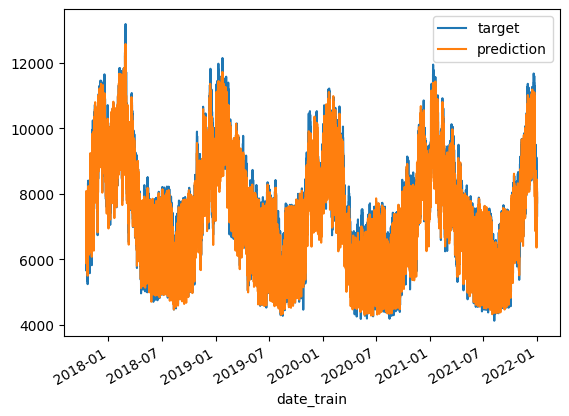

<Figure size 640x480 with 0 Axes>

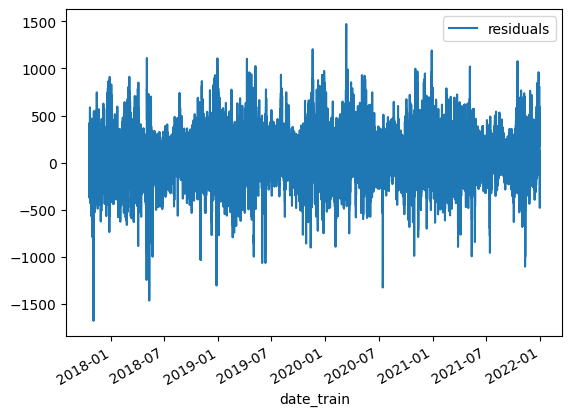

<Figure size 640x480 with 0 Axes>

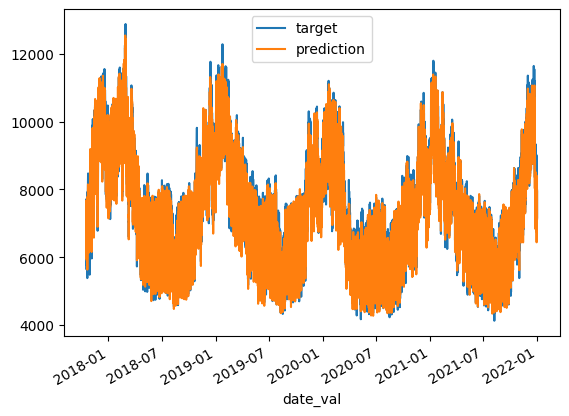

<Figure size 640x480 with 0 Axes>

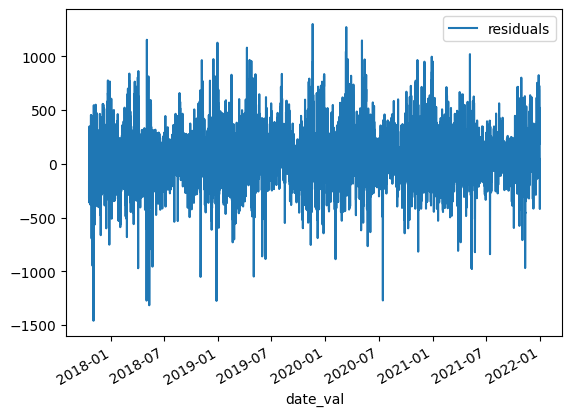

Epoch 1: 100%|██████████| 1818/1818 [00:02<00:00, 712.05it/s]


Epoch [1/200], Train Loss: 0.0068, Val Loss: 371.0597


Epoch 2: 100%|██████████| 1818/1818 [00:02<00:00, 811.19it/s]


Epoch [2/200], Train Loss: 0.0036, Val Loss: 331.3496


Epoch 3: 100%|██████████| 1818/1818 [00:02<00:00, 811.12it/s]


Epoch [3/200], Train Loss: 0.0030, Val Loss: 312.3220


Epoch 4: 100%|██████████| 1818/1818 [00:02<00:00, 754.11it/s]


Epoch [4/200], Train Loss: 0.0027, Val Loss: 326.8706


Epoch 5: 100%|██████████| 1818/1818 [00:03<00:00, 595.91it/s]


Epoch [5/200], Train Loss: 0.0025, Val Loss: 297.2325


Epoch 6: 100%|██████████| 1818/1818 [00:02<00:00, 810.82it/s]


Epoch [6/200], Train Loss: 0.0024, Val Loss: 296.7832


Epoch 7: 100%|██████████| 1818/1818 [00:02<00:00, 801.07it/s]


Epoch [7/200], Train Loss: 0.0022, Val Loss: 291.3850


Epoch 8: 100%|██████████| 1818/1818 [00:02<00:00, 807.26it/s]


Epoch [8/200], Train Loss: 0.0021, Val Loss: 265.9900


Epoch 9: 100%|██████████| 1818/1818 [00:02<00:00, 668.53it/s]


Epoch [9/200], Train Loss: 0.0020, Val Loss: 258.9047


Epoch 10: 100%|██████████| 1818/1818 [00:02<00:00, 759.03it/s]


Epoch [10/200], Train Loss: 0.0019, Val Loss: 275.2963


Epoch 11: 100%|██████████| 1818/1818 [00:02<00:00, 813.29it/s]


Epoch [11/200], Train Loss: 0.0018, Val Loss: 257.7234


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 816.07it/s]


Epoch [12/200], Train Loss: 0.0018, Val Loss: 243.2407


Epoch 13: 100%|██████████| 1818/1818 [00:02<00:00, 761.23it/s]


Epoch [13/200], Train Loss: 0.0017, Val Loss: 242.4696


Epoch 14: 100%|██████████| 1818/1818 [00:02<00:00, 663.57it/s]


Epoch [14/200], Train Loss: 0.0017, Val Loss: 241.0224


Epoch 15: 100%|██████████| 1818/1818 [00:02<00:00, 827.68it/s]


Epoch [15/200], Train Loss: 0.0016, Val Loss: 245.4295


Epoch 16: 100%|██████████| 1818/1818 [00:02<00:00, 812.22it/s]


Epoch [16/200], Train Loss: 0.0016, Val Loss: 241.0699


Epoch 17: 100%|██████████| 1818/1818 [00:02<00:00, 820.79it/s]


Epoch [17/200], Train Loss: 0.0016, Val Loss: 243.7808


Epoch 18: 100%|██████████| 1818/1818 [00:02<00:00, 624.09it/s]


Epoch [18/200], Train Loss: 0.0015, Val Loss: 234.1968


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 823.69it/s]


Epoch [19/200], Train Loss: 0.0015, Val Loss: 247.0584


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 809.64it/s]


Epoch [20/200], Train Loss: 0.0015, Val Loss: 231.8534


Epoch 21: 100%|██████████| 1818/1818 [00:02<00:00, 792.28it/s]


Epoch [21/200], Train Loss: 0.0015, Val Loss: 225.5703


Epoch 22: 100%|██████████| 1818/1818 [00:02<00:00, 749.65it/s]


Epoch [22/200], Train Loss: 0.0015, Val Loss: 225.8780


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 670.86it/s]


Epoch [23/200], Train Loss: 0.0014, Val Loss: 224.7800


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 816.63it/s]


Epoch [24/200], Train Loss: 0.0014, Val Loss: 232.1118


Epoch 25: 100%|██████████| 1818/1818 [00:02<00:00, 812.73it/s]


Epoch [25/200], Train Loss: 0.0014, Val Loss: 228.3080


Epoch 26: 100%|██████████| 1818/1818 [00:02<00:00, 806.39it/s]


Epoch [26/200], Train Loss: 0.0014, Val Loss: 226.4289


Epoch 27: 100%|██████████| 1818/1818 [00:02<00:00, 624.08it/s]


Epoch [27/200], Train Loss: 0.0014, Val Loss: 217.1395


Epoch 28: 100%|██████████| 1818/1818 [00:02<00:00, 817.02it/s]


Epoch [28/200], Train Loss: 0.0014, Val Loss: 217.9580


Epoch 29: 100%|██████████| 1818/1818 [00:02<00:00, 812.59it/s]


Epoch [29/200], Train Loss: 0.0014, Val Loss: 220.6914


Epoch 30: 100%|██████████| 1818/1818 [00:02<00:00, 803.21it/s]


Epoch [30/200], Train Loss: 0.0013, Val Loss: 219.3884


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 760.70it/s]


Epoch [31/200], Train Loss: 0.0013, Val Loss: 221.6341


Epoch 32: 100%|██████████| 1818/1818 [00:02<00:00, 678.40it/s]


Epoch [32/200], Train Loss: 0.0013, Val Loss: 233.4499


Epoch 33: 100%|██████████| 1818/1818 [00:02<00:00, 805.81it/s]


Epoch [33/200], Train Loss: 0.0013, Val Loss: 213.9252


Epoch 34: 100%|██████████| 1818/1818 [00:02<00:00, 803.04it/s]


Epoch [34/200], Train Loss: 0.0013, Val Loss: 227.4783


Epoch 35: 100%|██████████| 1818/1818 [00:02<00:00, 823.41it/s]


Epoch [35/200], Train Loss: 0.0013, Val Loss: 211.3053


Epoch 36: 100%|██████████| 1818/1818 [00:02<00:00, 616.09it/s]


Epoch [36/200], Train Loss: 0.0013, Val Loss: 209.4210


Epoch 37: 100%|██████████| 1818/1818 [00:02<00:00, 797.61it/s]


Epoch [37/200], Train Loss: 0.0013, Val Loss: 209.7127


Epoch 38: 100%|██████████| 1818/1818 [00:02<00:00, 809.45it/s]


Epoch [38/200], Train Loss: 0.0012, Val Loss: 211.2142


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 834.33it/s]


Epoch [39/200], Train Loss: 0.0012, Val Loss: 225.5566


Epoch 40: 100%|██████████| 1818/1818 [00:02<00:00, 746.65it/s]


Epoch [40/200], Train Loss: 0.0012, Val Loss: 209.9265


Epoch 41: 100%|██████████| 1818/1818 [00:02<00:00, 702.98it/s]


Epoch [41/200], Train Loss: 0.0012, Val Loss: 204.2987


Epoch 42: 100%|██████████| 1818/1818 [00:02<00:00, 818.58it/s]


Epoch [42/200], Train Loss: 0.0012, Val Loss: 212.3434


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 795.33it/s]


Epoch [43/200], Train Loss: 0.0012, Val Loss: 208.9113


Epoch 44: 100%|██████████| 1818/1818 [00:02<00:00, 806.06it/s]


Epoch [44/200], Train Loss: 0.0012, Val Loss: 210.4007


Epoch 45: 100%|██████████| 1818/1818 [00:02<00:00, 615.13it/s]


Epoch [45/200], Train Loss: 0.0012, Val Loss: 206.9820


Epoch 46: 100%|██████████| 1818/1818 [00:02<00:00, 805.51it/s]


Epoch [46/200], Train Loss: 0.0012, Val Loss: 214.0843


Epoch 47: 100%|██████████| 1818/1818 [00:02<00:00, 821.87it/s]


Epoch [47/200], Train Loss: 0.0011, Val Loss: 202.1722


Epoch 48: 100%|██████████| 1818/1818 [00:02<00:00, 808.10it/s]


Epoch [48/200], Train Loss: 0.0011, Val Loss: 204.5614


Epoch 49: 100%|██████████| 1818/1818 [00:02<00:00, 707.07it/s]


Epoch [49/200], Train Loss: 0.0011, Val Loss: 206.4969


Epoch 50: 100%|██████████| 1818/1818 [00:02<00:00, 713.48it/s]


Epoch [50/200], Train Loss: 0.0011, Val Loss: 206.6916


Epoch 51: 100%|██████████| 1818/1818 [00:02<00:00, 804.21it/s]


Epoch [51/200], Train Loss: 0.0011, Val Loss: 207.9420


Epoch 52: 100%|██████████| 1818/1818 [00:02<00:00, 819.91it/s]


Epoch [52/200], Train Loss: 0.0011, Val Loss: 210.0613


Epoch 53: 100%|██████████| 1818/1818 [00:02<00:00, 792.89it/s]


Epoch [53/200], Train Loss: 0.0011, Val Loss: 197.8703


Epoch 54: 100%|██████████| 1818/1818 [00:02<00:00, 616.69it/s]


Epoch [54/200], Train Loss: 0.0011, Val Loss: 208.9617


Epoch 55: 100%|██████████| 1818/1818 [00:02<00:00, 657.34it/s]


Epoch [55/200], Train Loss: 0.0011, Val Loss: 195.0233


Epoch 56: 100%|██████████| 1818/1818 [00:02<00:00, 669.41it/s]


Epoch [56/200], Train Loss: 0.0011, Val Loss: 201.3235


Epoch 57: 100%|██████████| 1818/1818 [00:02<00:00, 815.56it/s]


Epoch [57/200], Train Loss: 0.0011, Val Loss: 217.0732


Epoch 58: 100%|██████████| 1818/1818 [00:03<00:00, 605.73it/s]


Epoch [58/200], Train Loss: 0.0011, Val Loss: 205.3270


Epoch 59: 100%|██████████| 1818/1818 [00:02<00:00, 816.03it/s]


Epoch [59/200], Train Loss: 0.0011, Val Loss: 202.4902


Epoch 60: 100%|██████████| 1818/1818 [00:02<00:00, 803.45it/s]


Epoch [60/200], Train Loss: 0.0011, Val Loss: 198.0616


Epoch 61: 100%|██████████| 1818/1818 [00:02<00:00, 813.34it/s]


Epoch [61/200], Train Loss: 0.0011, Val Loss: 197.9053


Epoch 62: 100%|██████████| 1818/1818 [00:02<00:00, 630.21it/s]


Epoch [62/200], Train Loss: 0.0011, Val Loss: 194.0414


Epoch 63: 100%|██████████| 1818/1818 [00:02<00:00, 821.53it/s]


Epoch [63/200], Train Loss: 0.0011, Val Loss: 195.1527


Epoch 64: 100%|██████████| 1818/1818 [00:02<00:00, 839.12it/s]


Epoch [64/200], Train Loss: 0.0011, Val Loss: 198.5937


Epoch 65: 100%|██████████| 1818/1818 [00:02<00:00, 787.31it/s]


Epoch [65/200], Train Loss: 0.0011, Val Loss: 194.4494


Epoch 66: 100%|██████████| 1818/1818 [00:02<00:00, 809.73it/s]


Epoch [66/200], Train Loss: 0.0011, Val Loss: 193.3167


Epoch 67: 100%|██████████| 1818/1818 [00:02<00:00, 651.14it/s]


Epoch [67/200], Train Loss: 0.0011, Val Loss: 195.1447


Epoch 68: 100%|██████████| 1818/1818 [00:02<00:00, 803.50it/s]


Epoch [68/200], Train Loss: 0.0011, Val Loss: 196.8089


Epoch 69: 100%|██████████| 1818/1818 [00:02<00:00, 809.74it/s]


Epoch [69/200], Train Loss: 0.0011, Val Loss: 196.4777


Epoch 70: 100%|██████████| 1818/1818 [00:02<00:00, 817.39it/s]


Epoch [70/200], Train Loss: 0.0011, Val Loss: 192.6736


Epoch 71: 100%|██████████| 1818/1818 [00:02<00:00, 645.78it/s]


Epoch [71/200], Train Loss: 0.0010, Val Loss: 196.1361


Epoch 72: 100%|██████████| 1818/1818 [00:02<00:00, 804.46it/s]


Epoch [72/200], Train Loss: 0.0011, Val Loss: 210.1331


Epoch 73: 100%|██████████| 1818/1818 [00:02<00:00, 809.70it/s]


Epoch [73/200], Train Loss: 0.0011, Val Loss: 198.5296


Epoch 74: 100%|██████████| 1818/1818 [00:02<00:00, 818.51it/s]


Epoch [74/200], Train Loss: 0.0010, Val Loss: 193.0590


Epoch 75: 100%|██████████| 1818/1818 [00:02<00:00, 769.56it/s]


Epoch [75/200], Train Loss: 0.0010, Val Loss: 221.7413


Epoch 76: 100%|██████████| 1818/1818 [00:02<00:00, 645.01it/s]


Epoch [76/200], Train Loss: 0.0010, Val Loss: 193.5550


Epoch 77: 100%|██████████| 1818/1818 [00:02<00:00, 825.78it/s]


Epoch [77/200], Train Loss: 0.0010, Val Loss: 193.5049


Epoch 78: 100%|██████████| 1818/1818 [00:02<00:00, 813.56it/s]


Epoch [78/200], Train Loss: 0.0010, Val Loss: 193.0892


Epoch 79: 100%|██████████| 1818/1818 [00:02<00:00, 813.38it/s]


Epoch [79/200], Train Loss: 0.0010, Val Loss: 193.8408


Epoch 80: 100%|██████████| 1818/1818 [00:02<00:00, 643.64it/s]


Epoch [80/200], Train Loss: 0.0010, Val Loss: 191.1368


Epoch 81: 100%|██████████| 1818/1818 [00:02<00:00, 829.35it/s]


Epoch [81/200], Train Loss: 0.0010, Val Loss: 192.5864


Epoch 82: 100%|██████████| 1818/1818 [00:02<00:00, 824.88it/s]


Epoch [82/200], Train Loss: 0.0010, Val Loss: 189.7559


Epoch 83: 100%|██████████| 1818/1818 [00:02<00:00, 821.59it/s]


Epoch [83/200], Train Loss: 0.0010, Val Loss: 192.0404


Epoch 84: 100%|██████████| 1818/1818 [00:02<00:00, 810.88it/s]


Epoch [84/200], Train Loss: 0.0010, Val Loss: 205.1925


Epoch 85: 100%|██████████| 1818/1818 [00:02<00:00, 671.67it/s]


Epoch [85/200], Train Loss: 0.0010, Val Loss: 198.6051


Epoch 86: 100%|██████████| 1818/1818 [00:02<00:00, 827.30it/s]


Epoch [86/200], Train Loss: 0.0010, Val Loss: 187.6080


Epoch 87: 100%|██████████| 1818/1818 [00:02<00:00, 803.61it/s]


Epoch [87/200], Train Loss: 0.0010, Val Loss: 201.2137


Epoch 88: 100%|██████████| 1818/1818 [00:02<00:00, 826.36it/s]


Epoch [88/200], Train Loss: 0.0010, Val Loss: 193.5751


Epoch 89: 100%|██████████| 1818/1818 [00:02<00:00, 662.95it/s]


Epoch [89/200], Train Loss: 0.0010, Val Loss: 200.8092


Epoch 90: 100%|██████████| 1818/1818 [00:02<00:00, 838.58it/s]


Epoch [90/200], Train Loss: 0.0010, Val Loss: 201.2538


Epoch 91: 100%|██████████| 1818/1818 [00:02<00:00, 824.65it/s]


Epoch [91/200], Train Loss: 0.0010, Val Loss: 197.8716


Epoch 92: 100%|██████████| 1818/1818 [00:02<00:00, 834.24it/s]


Epoch [92/200], Train Loss: 0.0010, Val Loss: 193.0017


Epoch 93: 100%|██████████| 1818/1818 [00:02<00:00, 841.14it/s]


Epoch [93/200], Train Loss: 0.0010, Val Loss: 191.1011


Epoch 94: 100%|██████████| 1818/1818 [00:02<00:00, 634.41it/s]


Epoch [94/200], Train Loss: 0.0010, Val Loss: 189.0519


Epoch 95: 100%|██████████| 1818/1818 [00:02<00:00, 842.90it/s]


Epoch [95/200], Train Loss: 0.0010, Val Loss: 187.9713


Epoch 96: 100%|██████████| 1818/1818 [00:02<00:00, 830.14it/s]


Early stopping triggered



######Hauts-de-France######




<Figure size 640x480 with 0 Axes>

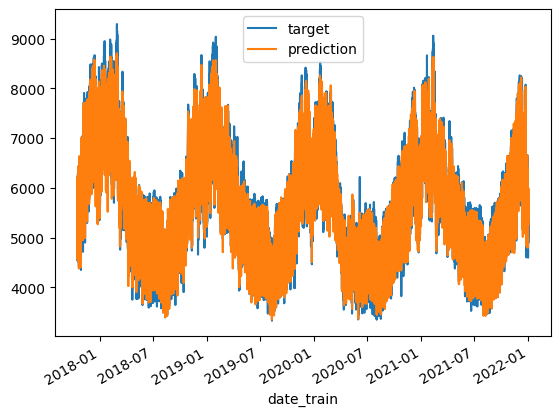

<Figure size 640x480 with 0 Axes>

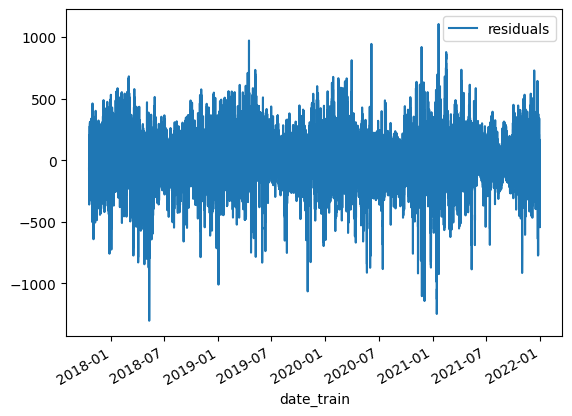

<Figure size 640x480 with 0 Axes>

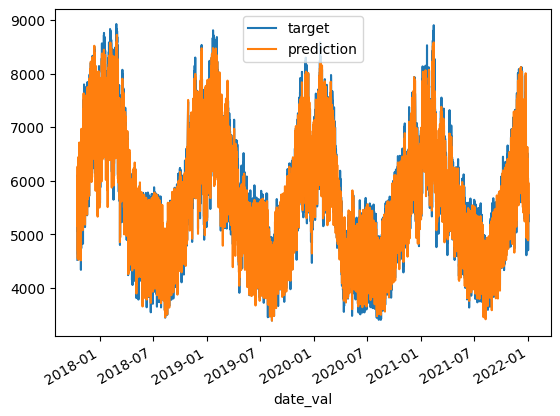

<Figure size 640x480 with 0 Axes>

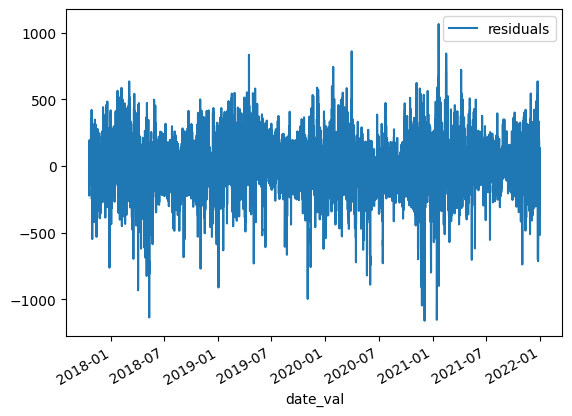

Epoch 1: 100%|██████████| 1818/1818 [00:02<00:00, 737.68it/s]


Epoch [1/200], Train Loss: 0.0077, Val Loss: 709.7981


Epoch 2: 100%|██████████| 1818/1818 [00:02<00:00, 833.84it/s]


Epoch [2/200], Train Loss: 0.0033, Val Loss: 588.5461


Epoch 3: 100%|██████████| 1818/1818 [00:02<00:00, 785.04it/s]


Epoch [3/200], Train Loss: 0.0026, Val Loss: 567.1836


Epoch 4: 100%|██████████| 1818/1818 [00:02<00:00, 814.39it/s]


Epoch [4/200], Train Loss: 0.0023, Val Loss: 534.8728


Epoch 5: 100%|██████████| 1818/1818 [00:03<00:00, 601.96it/s]


Epoch [5/200], Train Loss: 0.0021, Val Loss: 549.7272


Epoch 6: 100%|██████████| 1818/1818 [00:02<00:00, 828.24it/s]


Epoch [6/200], Train Loss: 0.0020, Val Loss: 504.3568


Epoch 7: 100%|██████████| 1818/1818 [00:02<00:00, 810.68it/s]


Epoch [7/200], Train Loss: 0.0019, Val Loss: 489.2563


Epoch 8: 100%|██████████| 1818/1818 [00:02<00:00, 814.03it/s]


Epoch [8/200], Train Loss: 0.0018, Val Loss: 488.7052


Epoch 9: 100%|██████████| 1818/1818 [00:02<00:00, 699.53it/s]


Epoch [9/200], Train Loss: 0.0018, Val Loss: 492.0974


Epoch 10: 100%|██████████| 1818/1818 [00:02<00:00, 755.52it/s]


Epoch [10/200], Train Loss: 0.0017, Val Loss: 539.1156


Epoch 11: 100%|██████████| 1818/1818 [00:02<00:00, 806.36it/s]


Epoch [11/200], Train Loss: 0.0017, Val Loss: 471.8565


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 808.60it/s]


Epoch [12/200], Train Loss: 0.0017, Val Loss: 473.5080


Epoch 13: 100%|██████████| 1818/1818 [00:02<00:00, 803.39it/s]


Epoch [13/200], Train Loss: 0.0016, Val Loss: 453.6598


Epoch 14: 100%|██████████| 1818/1818 [00:02<00:00, 617.20it/s]


Epoch [14/200], Train Loss: 0.0016, Val Loss: 456.1146


Epoch 15: 100%|██████████| 1818/1818 [00:02<00:00, 808.88it/s]


Epoch [15/200], Train Loss: 0.0016, Val Loss: 493.3676


Epoch 16: 100%|██████████| 1818/1818 [00:02<00:00, 822.22it/s]


Epoch [16/200], Train Loss: 0.0016, Val Loss: 473.0593


Epoch 17: 100%|██████████| 1818/1818 [00:02<00:00, 819.70it/s]


Epoch [17/200], Train Loss: 0.0015, Val Loss: 469.9083


Epoch 18: 100%|██████████| 1818/1818 [00:02<00:00, 686.72it/s]


Epoch [18/200], Train Loss: 0.0015, Val Loss: 451.6488


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 769.59it/s]


Epoch [19/200], Train Loss: 0.0015, Val Loss: 441.9280


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 817.47it/s]


Epoch [20/200], Train Loss: 0.0015, Val Loss: 449.9806


Epoch 21: 100%|██████████| 1818/1818 [00:02<00:00, 816.77it/s]


Epoch [21/200], Train Loss: 0.0015, Val Loss: 427.7054


Epoch 22: 100%|██████████| 1818/1818 [00:02<00:00, 814.32it/s]


Epoch [22/200], Train Loss: 0.0015, Val Loss: 429.8555


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 611.87it/s]


Epoch [23/200], Train Loss: 0.0015, Val Loss: 433.2319


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 817.06it/s]


Epoch [24/200], Train Loss: 0.0014, Val Loss: 437.1925


Epoch 25: 100%|██████████| 1818/1818 [00:02<00:00, 818.49it/s]


Epoch [25/200], Train Loss: 0.0014, Val Loss: 435.0368


Epoch 26: 100%|██████████| 1818/1818 [00:02<00:00, 787.00it/s]


Epoch [26/200], Train Loss: 0.0014, Val Loss: 433.5754


Epoch 27: 100%|██████████| 1818/1818 [00:02<00:00, 692.90it/s]


Epoch [27/200], Train Loss: 0.0014, Val Loss: 423.8354


Epoch 28: 100%|██████████| 1818/1818 [00:02<00:00, 753.21it/s]


Epoch [28/200], Train Loss: 0.0014, Val Loss: 424.8489


Epoch 29: 100%|██████████| 1818/1818 [00:02<00:00, 812.80it/s]


Epoch [29/200], Train Loss: 0.0014, Val Loss: 425.4406


Epoch 30: 100%|██████████| 1818/1818 [00:02<00:00, 814.57it/s]


Epoch [30/200], Train Loss: 0.0014, Val Loss: 422.5178


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 826.73it/s]


Epoch [31/200], Train Loss: 0.0014, Val Loss: 417.9001


Epoch 32: 100%|██████████| 1818/1818 [00:02<00:00, 631.39it/s]


Epoch [32/200], Train Loss: 0.0014, Val Loss: 426.7677


Epoch 33: 100%|██████████| 1818/1818 [00:02<00:00, 815.08it/s]


Epoch [33/200], Train Loss: 0.0014, Val Loss: 455.3596


Epoch 34: 100%|██████████| 1818/1818 [00:02<00:00, 816.67it/s]


Epoch [34/200], Train Loss: 0.0014, Val Loss: 431.0218


Epoch 35: 100%|██████████| 1818/1818 [00:02<00:00, 832.42it/s]


Epoch [35/200], Train Loss: 0.0014, Val Loss: 423.3151


Epoch 36: 100%|██████████| 1818/1818 [00:02<00:00, 693.86it/s]


Epoch [36/200], Train Loss: 0.0014, Val Loss: 429.3156


Epoch 37: 100%|██████████| 1818/1818 [00:02<00:00, 778.03it/s]


Epoch [37/200], Train Loss: 0.0013, Val Loss: 437.9435


Epoch 38: 100%|██████████| 1818/1818 [00:02<00:00, 821.37it/s]


Epoch [38/200], Train Loss: 0.0013, Val Loss: 424.2560


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 830.90it/s]


Epoch [39/200], Train Loss: 0.0013, Val Loss: 417.4020


Epoch 40: 100%|██████████| 1818/1818 [00:02<00:00, 810.71it/s]


Epoch [40/200], Train Loss: 0.0013, Val Loss: 409.2272


Epoch 41: 100%|██████████| 1818/1818 [00:02<00:00, 622.16it/s]


Epoch [41/200], Train Loss: 0.0013, Val Loss: 430.2874


Epoch 42: 100%|██████████| 1818/1818 [00:02<00:00, 828.29it/s]


Epoch [42/200], Train Loss: 0.0013, Val Loss: 428.3425


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 797.84it/s]


Epoch [43/200], Train Loss: 0.0013, Val Loss: 436.5252


Epoch 44: 100%|██████████| 1818/1818 [00:02<00:00, 826.34it/s]


Epoch [44/200], Train Loss: 0.0013, Val Loss: 412.6788


Epoch 45: 100%|██████████| 1818/1818 [00:02<00:00, 699.53it/s]


Epoch [45/200], Train Loss: 0.0013, Val Loss: 406.8604


Epoch 46: 100%|██████████| 1818/1818 [00:02<00:00, 753.09it/s]


Epoch [46/200], Train Loss: 0.0013, Val Loss: 407.4475


Epoch 47: 100%|██████████| 1818/1818 [00:02<00:00, 807.86it/s]


Epoch [47/200], Train Loss: 0.0013, Val Loss: 420.7380


Epoch 48: 100%|██████████| 1818/1818 [00:02<00:00, 798.45it/s]


Epoch [48/200], Train Loss: 0.0013, Val Loss: 417.0703


Epoch 49: 100%|██████████| 1818/1818 [00:02<00:00, 817.50it/s]


Epoch [49/200], Train Loss: 0.0013, Val Loss: 411.9658


Epoch 50: 100%|██████████| 1818/1818 [00:02<00:00, 622.89it/s]


Epoch [50/200], Train Loss: 0.0013, Val Loss: 406.1022


Epoch 51: 100%|██████████| 1818/1818 [00:02<00:00, 827.05it/s]


Epoch [51/200], Train Loss: 0.0013, Val Loss: 405.4141


Epoch 52: 100%|██████████| 1818/1818 [00:02<00:00, 820.03it/s]


Epoch [52/200], Train Loss: 0.0013, Val Loss: 417.0410


Epoch 53: 100%|██████████| 1818/1818 [00:02<00:00, 824.49it/s]


Epoch [53/200], Train Loss: 0.0013, Val Loss: 401.9640


Epoch 54: 100%|██████████| 1818/1818 [00:02<00:00, 717.65it/s]


Epoch [54/200], Train Loss: 0.0012, Val Loss: 406.2603


Epoch 55: 100%|██████████| 1818/1818 [00:02<00:00, 739.13it/s]


Epoch [55/200], Train Loss: 0.0012, Val Loss: 397.1422


Epoch 56: 100%|██████████| 1818/1818 [00:02<00:00, 809.56it/s]


Epoch [56/200], Train Loss: 0.0012, Val Loss: 419.7790


Epoch 57: 100%|██████████| 1818/1818 [00:02<00:00, 820.48it/s]


Epoch [57/200], Train Loss: 0.0012, Val Loss: 397.5729


Epoch 58: 100%|██████████| 1818/1818 [00:02<00:00, 818.00it/s]


Epoch [58/200], Train Loss: 0.0012, Val Loss: 400.9960


Epoch 59: 100%|██████████| 1818/1818 [00:02<00:00, 634.63it/s]


Epoch [59/200], Train Loss: 0.0012, Val Loss: 410.6919


Epoch 60: 100%|██████████| 1818/1818 [00:02<00:00, 831.17it/s]


Epoch [60/200], Train Loss: 0.0012, Val Loss: 405.6819


Epoch 61: 100%|██████████| 1818/1818 [00:02<00:00, 818.41it/s]


Epoch [61/200], Train Loss: 0.0012, Val Loss: 403.7627


Epoch 62: 100%|██████████| 1818/1818 [00:02<00:00, 818.55it/s]


Epoch [62/200], Train Loss: 0.0012, Val Loss: 401.6839


Epoch 63: 100%|██████████| 1818/1818 [00:02<00:00, 742.31it/s]


Epoch [63/200], Train Loss: 0.0012, Val Loss: 404.5972


Epoch 64: 100%|██████████| 1818/1818 [00:02<00:00, 702.21it/s]


Epoch [64/200], Train Loss: 0.0012, Val Loss: 399.1152


Epoch 65: 100%|██████████| 1818/1818 [00:02<00:00, 821.13it/s]


Epoch [65/200], Train Loss: 0.0012, Val Loss: 394.5543


Epoch 66: 100%|██████████| 1818/1818 [00:02<00:00, 815.69it/s]


Epoch [66/200], Train Loss: 0.0012, Val Loss: 388.2615


Epoch 67: 100%|██████████| 1818/1818 [00:02<00:00, 809.99it/s]


Epoch [67/200], Train Loss: 0.0012, Val Loss: 394.7099


Epoch 68: 100%|██████████| 1818/1818 [00:02<00:00, 629.93it/s]


Epoch [68/200], Train Loss: 0.0012, Val Loss: 402.8524


Epoch 69: 100%|██████████| 1818/1818 [00:02<00:00, 818.40it/s]


Epoch [69/200], Train Loss: 0.0012, Val Loss: 396.4893


Epoch 70: 100%|██████████| 1818/1818 [00:02<00:00, 816.58it/s]


Epoch [70/200], Train Loss: 0.0012, Val Loss: 392.8337


Epoch 71: 100%|██████████| 1818/1818 [00:02<00:00, 807.97it/s]


Epoch [71/200], Train Loss: 0.0012, Val Loss: 388.4472


Epoch 72: 100%|██████████| 1818/1818 [00:02<00:00, 745.90it/s]


Epoch [72/200], Train Loss: 0.0012, Val Loss: 385.0894


Epoch 73: 100%|██████████| 1818/1818 [00:02<00:00, 714.94it/s]


Epoch [73/200], Train Loss: 0.0012, Val Loss: 386.3723


Epoch 74: 100%|██████████| 1818/1818 [00:02<00:00, 824.41it/s]


Epoch [74/200], Train Loss: 0.0012, Val Loss: 383.5995


Epoch 75: 100%|██████████| 1818/1818 [00:02<00:00, 818.96it/s]


Epoch [75/200], Train Loss: 0.0011, Val Loss: 396.7118


Epoch 76: 100%|██████████| 1818/1818 [00:02<00:00, 815.65it/s]


Epoch [76/200], Train Loss: 0.0011, Val Loss: 406.5865


Epoch 77: 100%|██████████| 1818/1818 [00:02<00:00, 618.29it/s]


Epoch [77/200], Train Loss: 0.0011, Val Loss: 381.3957


Epoch 78: 100%|██████████| 1818/1818 [00:02<00:00, 821.61it/s]


Epoch [78/200], Train Loss: 0.0011, Val Loss: 384.7537


Epoch 79: 100%|██████████| 1818/1818 [00:02<00:00, 819.45it/s]


Epoch [79/200], Train Loss: 0.0011, Val Loss: 383.6437


Epoch 80: 100%|██████████| 1818/1818 [00:02<00:00, 822.79it/s]


Epoch [80/200], Train Loss: 0.0011, Val Loss: 378.1878


Epoch 81: 100%|██████████| 1818/1818 [00:02<00:00, 765.18it/s]


Epoch [81/200], Train Loss: 0.0011, Val Loss: 382.2263


Epoch 82: 100%|██████████| 1818/1818 [00:02<00:00, 695.26it/s]


Epoch [82/200], Train Loss: 0.0011, Val Loss: 377.8834


Epoch 83: 100%|██████████| 1818/1818 [00:02<00:00, 803.96it/s]


Epoch [83/200], Train Loss: 0.0011, Val Loss: 406.8741


Epoch 84: 100%|██████████| 1818/1818 [00:02<00:00, 814.83it/s]


Epoch [84/200], Train Loss: 0.0011, Val Loss: 376.7009


Epoch 85: 100%|██████████| 1818/1818 [00:02<00:00, 820.67it/s]


Epoch [85/200], Train Loss: 0.0011, Val Loss: 377.3351


Epoch 86: 100%|██████████| 1818/1818 [00:02<00:00, 621.77it/s]


Epoch [86/200], Train Loss: 0.0011, Val Loss: 386.0903


Epoch 87: 100%|██████████| 1818/1818 [00:02<00:00, 812.18it/s]


Epoch [87/200], Train Loss: 0.0011, Val Loss: 383.1382


Epoch 88: 100%|██████████| 1818/1818 [00:02<00:00, 849.21it/s]


Epoch [88/200], Train Loss: 0.0011, Val Loss: 383.2519


Epoch 89: 100%|██████████| 1818/1818 [00:02<00:00, 803.95it/s]


Epoch [89/200], Train Loss: 0.0011, Val Loss: 391.4422


Epoch 90: 100%|██████████| 1818/1818 [00:02<00:00, 765.72it/s]


Epoch [90/200], Train Loss: 0.0011, Val Loss: 378.2525


Epoch 91: 100%|██████████| 1818/1818 [00:02<00:00, 681.76it/s]


Epoch [91/200], Train Loss: 0.0011, Val Loss: 380.4128


Epoch 92: 100%|██████████| 1818/1818 [00:02<00:00, 818.35it/s]


Epoch [92/200], Train Loss: 0.0011, Val Loss: 376.4315


Epoch 93: 100%|██████████| 1818/1818 [00:02<00:00, 821.83it/s]


Epoch [93/200], Train Loss: 0.0011, Val Loss: 375.8547


Epoch 94: 100%|██████████| 1818/1818 [00:02<00:00, 828.97it/s]


Epoch [94/200], Train Loss: 0.0011, Val Loss: 371.0279


Epoch 95: 100%|██████████| 1818/1818 [00:02<00:00, 634.05it/s]


Epoch [95/200], Train Loss: 0.0011, Val Loss: 372.1150


Epoch 96: 100%|██████████| 1818/1818 [00:02<00:00, 828.48it/s]


Epoch [96/200], Train Loss: 0.0011, Val Loss: 372.2700


Epoch 97: 100%|██████████| 1818/1818 [00:02<00:00, 829.09it/s]


Epoch [97/200], Train Loss: 0.0011, Val Loss: 391.7360


Epoch 98: 100%|██████████| 1818/1818 [00:02<00:00, 822.32it/s]


Epoch [98/200], Train Loss: 0.0011, Val Loss: 374.9686


Epoch 99: 100%|██████████| 1818/1818 [00:02<00:00, 809.67it/s]


Epoch [99/200], Train Loss: 0.0010, Val Loss: 366.1272


Epoch 100: 100%|██████████| 1818/1818 [00:02<00:00, 666.19it/s]


Epoch [100/200], Train Loss: 0.0010, Val Loss: 378.5161


Epoch 101: 100%|██████████| 1818/1818 [00:02<00:00, 818.44it/s]


Epoch [101/200], Train Loss: 0.0010, Val Loss: 370.4768


Epoch 102: 100%|██████████| 1818/1818 [00:02<00:00, 810.20it/s]


Epoch [102/200], Train Loss: 0.0010, Val Loss: 367.9650


Epoch 103: 100%|██████████| 1818/1818 [00:02<00:00, 831.05it/s]


Epoch [103/200], Train Loss: 0.0010, Val Loss: 365.4703


Epoch 104: 100%|██████████| 1818/1818 [00:02<00:00, 673.44it/s]


Epoch [104/200], Train Loss: 0.0010, Val Loss: 356.2638


Epoch 105: 100%|██████████| 1818/1818 [00:02<00:00, 824.81it/s]


Epoch [105/200], Train Loss: 0.0010, Val Loss: 362.1948


Epoch 106: 100%|██████████| 1818/1818 [00:02<00:00, 826.79it/s]


Epoch [106/200], Train Loss: 0.0010, Val Loss: 359.9764


Epoch 107: 100%|██████████| 1818/1818 [00:02<00:00, 823.50it/s]


Epoch [107/200], Train Loss: 0.0010, Val Loss: 355.0527


Epoch 108: 100%|██████████| 1818/1818 [00:02<00:00, 799.53it/s]


Epoch [108/200], Train Loss: 0.0010, Val Loss: 348.8930


Epoch 109: 100%|██████████| 1818/1818 [00:02<00:00, 651.81it/s]


Epoch [109/200], Train Loss: 0.0010, Val Loss: 355.9811


Epoch 110: 100%|██████████| 1818/1818 [00:02<00:00, 816.86it/s]


Epoch [110/200], Train Loss: 0.0010, Val Loss: 356.4395


Epoch 111: 100%|██████████| 1818/1818 [00:02<00:00, 815.87it/s]


Epoch [111/200], Train Loss: 0.0010, Val Loss: 352.2897


Epoch 112: 100%|██████████| 1818/1818 [00:02<00:00, 812.91it/s]


Epoch [112/200], Train Loss: 0.0010, Val Loss: 359.3331


Epoch 113: 100%|██████████| 1818/1818 [00:02<00:00, 698.04it/s]


Epoch [113/200], Train Loss: 0.0010, Val Loss: 353.6475


Epoch 114: 100%|██████████| 1818/1818 [00:02<00:00, 785.41it/s]


Epoch [114/200], Train Loss: 0.0010, Val Loss: 344.5324


Epoch 115: 100%|██████████| 1818/1818 [00:02<00:00, 819.35it/s]


Epoch [115/200], Train Loss: 0.0010, Val Loss: 354.9207


Epoch 116: 100%|██████████| 1818/1818 [00:02<00:00, 808.02it/s]


Epoch [116/200], Train Loss: 0.0010, Val Loss: 367.0719


Epoch 117: 100%|██████████| 1818/1818 [00:02<00:00, 827.47it/s]


Epoch [117/200], Train Loss: 0.0009, Val Loss: 389.5038


Epoch 118: 100%|██████████| 1818/1818 [00:02<00:00, 613.80it/s]


Epoch [118/200], Train Loss: 0.0009, Val Loss: 353.5292


Epoch 119: 100%|██████████| 1818/1818 [00:02<00:00, 832.28it/s]


Epoch [119/200], Train Loss: 0.0009, Val Loss: 359.6226


Epoch 120: 100%|██████████| 1818/1818 [00:02<00:00, 811.50it/s]


Epoch [120/200], Train Loss: 0.0009, Val Loss: 357.9317


Epoch 121: 100%|██████████| 1818/1818 [00:02<00:00, 821.25it/s]


Epoch [121/200], Train Loss: 0.0009, Val Loss: 349.7920


Epoch 122: 100%|██████████| 1818/1818 [00:02<00:00, 716.07it/s]


Epoch [122/200], Train Loss: 0.0009, Val Loss: 350.8204


Epoch 123: 100%|██████████| 1818/1818 [00:02<00:00, 723.16it/s]


Epoch [123/200], Train Loss: 0.0009, Val Loss: 340.9773


Epoch 124: 100%|██████████| 1818/1818 [00:02<00:00, 814.45it/s]


Epoch [124/200], Train Loss: 0.0009, Val Loss: 364.5973


Epoch 125: 100%|██████████| 1818/1818 [00:02<00:00, 809.83it/s]


Epoch [125/200], Train Loss: 0.0009, Val Loss: 344.2899


Epoch 126: 100%|██████████| 1818/1818 [00:02<00:00, 818.35it/s]


Epoch [126/200], Train Loss: 0.0009, Val Loss: 344.1711


Epoch 127: 100%|██████████| 1818/1818 [00:02<00:00, 619.19it/s]


Epoch [127/200], Train Loss: 0.0009, Val Loss: 344.5349


Epoch 128: 100%|██████████| 1818/1818 [00:02<00:00, 831.97it/s]


Epoch [128/200], Train Loss: 0.0009, Val Loss: 358.0972


Epoch 129: 100%|██████████| 1818/1818 [00:02<00:00, 827.47it/s]


Epoch [129/200], Train Loss: 0.0009, Val Loss: 355.7928


Epoch 130: 100%|██████████| 1818/1818 [00:02<00:00, 800.50it/s]


Epoch [130/200], Train Loss: 0.0009, Val Loss: 337.7386


Epoch 131: 100%|██████████| 1818/1818 [00:02<00:00, 710.28it/s]


Epoch [131/200], Train Loss: 0.0009, Val Loss: 357.3497


Epoch 132: 100%|██████████| 1818/1818 [00:02<00:00, 757.30it/s]


Epoch [132/200], Train Loss: 0.0009, Val Loss: 345.3474


Epoch 133: 100%|██████████| 1818/1818 [00:02<00:00, 822.66it/s]


Epoch [133/200], Train Loss: 0.0009, Val Loss: 366.0346


Epoch 134: 100%|██████████| 1818/1818 [00:02<00:00, 827.59it/s]


Epoch [134/200], Train Loss: 0.0009, Val Loss: 345.5787


Epoch 135: 100%|██████████| 1818/1818 [00:02<00:00, 829.22it/s]


Epoch [135/200], Train Loss: 0.0009, Val Loss: 350.0416


Epoch 136: 100%|██████████| 1818/1818 [00:02<00:00, 618.50it/s]


Epoch [136/200], Train Loss: 0.0009, Val Loss: 341.3486


Epoch 137: 100%|██████████| 1818/1818 [00:02<00:00, 822.46it/s]


Epoch [137/200], Train Loss: 0.0009, Val Loss: 344.3547


Epoch 138: 100%|██████████| 1818/1818 [00:02<00:00, 812.75it/s]


Epoch [138/200], Train Loss: 0.0009, Val Loss: 335.9761


Epoch 139: 100%|██████████| 1818/1818 [00:02<00:00, 814.86it/s]


Epoch [139/200], Train Loss: 0.0009, Val Loss: 344.0236


Epoch 140: 100%|██████████| 1818/1818 [00:02<00:00, 718.21it/s]


Epoch [140/200], Train Loss: 0.0009, Val Loss: 355.9864


Epoch 141: 100%|██████████| 1818/1818 [00:02<00:00, 706.88it/s]


Epoch [141/200], Train Loss: 0.0009, Val Loss: 339.6918


Epoch 142: 100%|██████████| 1818/1818 [00:02<00:00, 823.42it/s]


Epoch [142/200], Train Loss: 0.0009, Val Loss: 345.4717


Epoch 143: 100%|██████████| 1818/1818 [00:02<00:00, 794.29it/s]


Epoch [143/200], Train Loss: 0.0009, Val Loss: 340.3888


Epoch 144: 100%|██████████| 1818/1818 [00:02<00:00, 819.84it/s]


Epoch [144/200], Train Loss: 0.0009, Val Loss: 338.4225


Epoch 145: 100%|██████████| 1818/1818 [00:02<00:00, 625.41it/s]


Epoch [145/200], Train Loss: 0.0009, Val Loss: 341.8200


Epoch 146: 100%|██████████| 1818/1818 [00:02<00:00, 819.00it/s]


Epoch [146/200], Train Loss: 0.0009, Val Loss: 348.1362


Epoch 147: 100%|██████████| 1818/1818 [00:02<00:00, 813.22it/s]


Epoch [147/200], Train Loss: 0.0009, Val Loss: 337.5096


Epoch 148: 100%|██████████| 1818/1818 [00:02<00:00, 824.07it/s]


Early stopping triggered



######Île-de-France######




<Figure size 640x480 with 0 Axes>

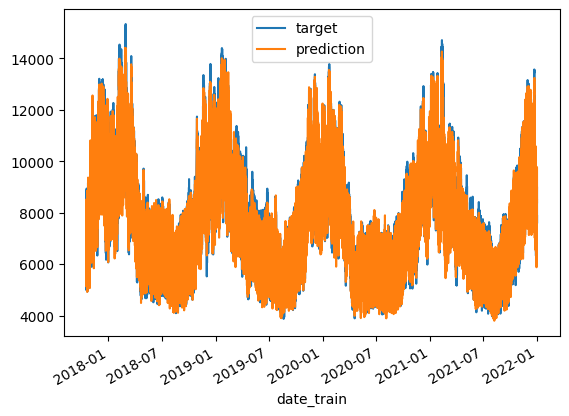

<Figure size 640x480 with 0 Axes>

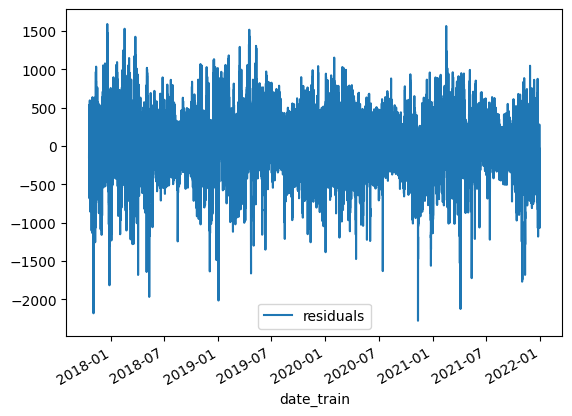

<Figure size 640x480 with 0 Axes>

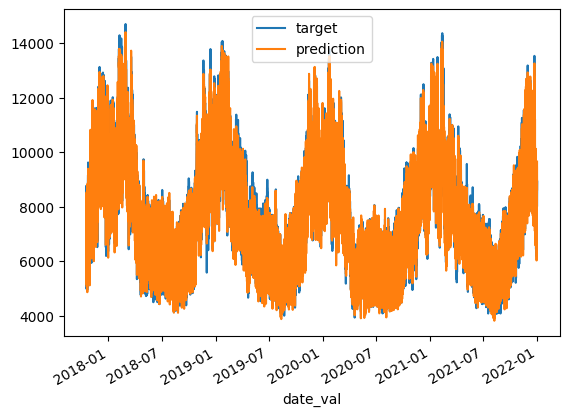

<Figure size 640x480 with 0 Axes>

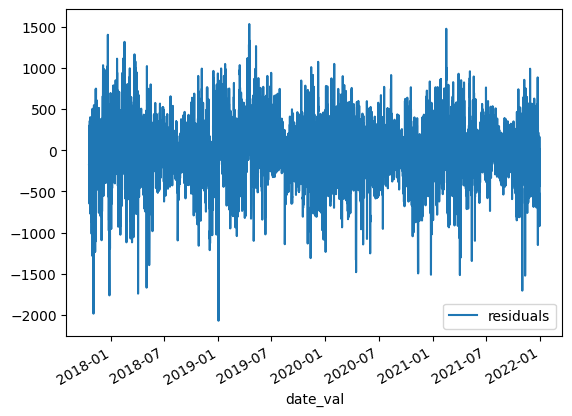

Epoch 1: 100%|██████████| 1818/1818 [00:02<00:00, 806.48it/s]


Epoch [1/200], Train Loss: 0.0070, Val Loss: 71.8065


Epoch 2: 100%|██████████| 1818/1818 [00:02<00:00, 811.06it/s]


Epoch [2/200], Train Loss: 0.0023, Val Loss: 61.7940


Epoch 3: 100%|██████████| 1818/1818 [00:02<00:00, 811.29it/s]


Epoch [3/200], Train Loss: 0.0018, Val Loss: 57.6174


Epoch 4: 100%|██████████| 1818/1818 [00:02<00:00, 614.76it/s]


Epoch [4/200], Train Loss: 0.0016, Val Loss: 54.0955


Epoch 5: 100%|██████████| 1818/1818 [00:02<00:00, 809.64it/s]


Epoch [5/200], Train Loss: 0.0014, Val Loss: 53.4578


Epoch 6: 100%|██████████| 1818/1818 [00:02<00:00, 818.74it/s]


Epoch [6/200], Train Loss: 0.0013, Val Loss: 51.1003


Epoch 7: 100%|██████████| 1818/1818 [00:02<00:00, 806.60it/s]


Epoch [7/200], Train Loss: 0.0013, Val Loss: 50.4249


Epoch 8: 100%|██████████| 1818/1818 [00:02<00:00, 725.70it/s]


Epoch [8/200], Train Loss: 0.0012, Val Loss: 49.2637


Epoch 9: 100%|██████████| 1818/1818 [00:02<00:00, 723.98it/s]


Epoch [9/200], Train Loss: 0.0012, Val Loss: 50.4654


Epoch 10: 100%|██████████| 1818/1818 [00:02<00:00, 786.46it/s]


Epoch [10/200], Train Loss: 0.0012, Val Loss: 47.8751


Epoch 11: 100%|██████████| 1818/1818 [00:02<00:00, 815.67it/s]


Epoch [11/200], Train Loss: 0.0012, Val Loss: 50.7012


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 803.07it/s]


Epoch [12/200], Train Loss: 0.0011, Val Loss: 48.4781


Epoch 13: 100%|██████████| 1818/1818 [00:02<00:00, 612.79it/s]


Epoch [13/200], Train Loss: 0.0011, Val Loss: 47.4595


Epoch 14: 100%|██████████| 1818/1818 [00:02<00:00, 812.29it/s]


Epoch [14/200], Train Loss: 0.0011, Val Loss: 47.0411


Epoch 15: 100%|██████████| 1818/1818 [00:02<00:00, 813.38it/s]


Epoch [15/200], Train Loss: 0.0011, Val Loss: 49.0042


Epoch 16: 100%|██████████| 1818/1818 [00:02<00:00, 804.39it/s]


Epoch [16/200], Train Loss: 0.0011, Val Loss: 46.7511


Epoch 17: 100%|██████████| 1818/1818 [00:02<00:00, 715.05it/s]


Epoch [17/200], Train Loss: 0.0010, Val Loss: 46.0877


Epoch 18: 100%|██████████| 1818/1818 [00:02<00:00, 706.60it/s]


Epoch [18/200], Train Loss: 0.0010, Val Loss: 45.2694


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 809.67it/s]


Epoch [19/200], Train Loss: 0.0010, Val Loss: 45.3084


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 815.29it/s]


Epoch [20/200], Train Loss: 0.0010, Val Loss: 44.8037


Epoch 21: 100%|██████████| 1818/1818 [00:02<00:00, 827.05it/s]


Epoch [21/200], Train Loss: 0.0010, Val Loss: 44.0746


Epoch 22: 100%|██████████| 1818/1818 [00:02<00:00, 618.25it/s]


Epoch [22/200], Train Loss: 0.0009, Val Loss: 43.3757


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 808.00it/s]


Epoch [23/200], Train Loss: 0.0009, Val Loss: 45.7159


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 821.68it/s]


Epoch [24/200], Train Loss: 0.0009, Val Loss: 43.2069


Epoch 25: 100%|██████████| 1818/1818 [00:02<00:00, 805.97it/s]


Epoch [25/200], Train Loss: 0.0009, Val Loss: 43.1469


Epoch 26: 100%|██████████| 1818/1818 [00:02<00:00, 726.42it/s]


Epoch [26/200], Train Loss: 0.0009, Val Loss: 44.0543


Epoch 27: 100%|██████████| 1818/1818 [00:02<00:00, 711.44it/s]


Epoch [27/200], Train Loss: 0.0009, Val Loss: 44.4464


Epoch 28: 100%|██████████| 1818/1818 [00:02<00:00, 814.91it/s]


Epoch [28/200], Train Loss: 0.0009, Val Loss: 47.1880


Epoch 29: 100%|██████████| 1818/1818 [00:02<00:00, 809.05it/s]


Epoch [29/200], Train Loss: 0.0009, Val Loss: 42.3632


Epoch 30: 100%|██████████| 1818/1818 [00:02<00:00, 807.03it/s]


Epoch [30/200], Train Loss: 0.0009, Val Loss: 41.9756


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 615.44it/s]


Epoch [31/200], Train Loss: 0.0009, Val Loss: 41.7355


Epoch 32: 100%|██████████| 1818/1818 [00:02<00:00, 808.12it/s]


Epoch [32/200], Train Loss: 0.0009, Val Loss: 42.0059


Epoch 33: 100%|██████████| 1818/1818 [00:02<00:00, 806.22it/s]


Epoch [33/200], Train Loss: 0.0009, Val Loss: 41.3853


Epoch 34: 100%|██████████| 1818/1818 [00:02<00:00, 738.44it/s]


Epoch [34/200], Train Loss: 0.0009, Val Loss: 42.5705


Epoch 35: 100%|██████████| 1818/1818 [00:04<00:00, 387.19it/s]


Epoch [35/200], Train Loss: 0.0009, Val Loss: 41.9655


Epoch 36: 100%|██████████| 1818/1818 [00:03<00:00, 521.18it/s]


Epoch [36/200], Train Loss: 0.0008, Val Loss: 40.8826


Epoch 37: 100%|██████████| 1818/1818 [00:02<00:00, 685.94it/s]


Epoch [37/200], Train Loss: 0.0008, Val Loss: 41.7562


Epoch 38: 100%|██████████| 1818/1818 [00:02<00:00, 714.65it/s]


Epoch [38/200], Train Loss: 0.0008, Val Loss: 42.0681


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 745.99it/s]


Epoch [39/200], Train Loss: 0.0008, Val Loss: 40.8122


Epoch 40: 100%|██████████| 1818/1818 [00:02<00:00, 824.32it/s]


Epoch [40/200], Train Loss: 0.0008, Val Loss: 40.8047


Epoch 41: 100%|██████████| 1818/1818 [00:02<00:00, 810.47it/s]


Epoch [41/200], Train Loss: 0.0008, Val Loss: 41.3118


Epoch 42: 100%|██████████| 1818/1818 [00:02<00:00, 828.93it/s]


Epoch [42/200], Train Loss: 0.0008, Val Loss: 40.7279


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 610.45it/s]


Epoch [43/200], Train Loss: 0.0008, Val Loss: 41.7686


Epoch 44: 100%|██████████| 1818/1818 [00:02<00:00, 811.45it/s]


Epoch [44/200], Train Loss: 0.0008, Val Loss: 41.2763


Epoch 45: 100%|██████████| 1818/1818 [00:02<00:00, 816.59it/s]


Epoch [45/200], Train Loss: 0.0008, Val Loss: 41.3189


Epoch 46: 100%|██████████| 1818/1818 [00:02<00:00, 810.47it/s]


Epoch [46/200], Train Loss: 0.0008, Val Loss: 40.6395


Epoch 47: 100%|██████████| 1818/1818 [00:02<00:00, 696.44it/s]


Epoch [47/200], Train Loss: 0.0008, Val Loss: 40.2981


Epoch 48: 100%|██████████| 1818/1818 [00:02<00:00, 727.31it/s]


Epoch [48/200], Train Loss: 0.0008, Val Loss: 40.4053


Epoch 49: 100%|██████████| 1818/1818 [00:02<00:00, 805.64it/s]


Epoch [49/200], Train Loss: 0.0008, Val Loss: 39.9501


Epoch 50: 100%|██████████| 1818/1818 [00:02<00:00, 801.22it/s]


Epoch [50/200], Train Loss: 0.0008, Val Loss: 40.8383


Epoch 51: 100%|██████████| 1818/1818 [00:02<00:00, 810.57it/s]


Epoch [51/200], Train Loss: 0.0008, Val Loss: 40.0833


Epoch 52: 100%|██████████| 1818/1818 [00:02<00:00, 613.54it/s]


Epoch [52/200], Train Loss: 0.0008, Val Loss: 40.1692


Epoch 53: 100%|██████████| 1818/1818 [00:02<00:00, 806.03it/s]


Epoch [53/200], Train Loss: 0.0008, Val Loss: 39.7730


Epoch 54: 100%|██████████| 1818/1818 [00:02<00:00, 812.38it/s]


Epoch [54/200], Train Loss: 0.0008, Val Loss: 39.1823


Epoch 55: 100%|██████████| 1818/1818 [00:02<00:00, 811.10it/s]


Epoch [55/200], Train Loss: 0.0008, Val Loss: 41.2962


Epoch 56: 100%|██████████| 1818/1818 [00:02<00:00, 705.51it/s]


Epoch [56/200], Train Loss: 0.0008, Val Loss: 40.3111


Epoch 57: 100%|██████████| 1818/1818 [00:02<00:00, 723.48it/s]


Epoch [57/200], Train Loss: 0.0008, Val Loss: 40.3499


Epoch 58: 100%|██████████| 1818/1818 [00:02<00:00, 817.03it/s]


Epoch [58/200], Train Loss: 0.0008, Val Loss: 40.0518


Epoch 59: 100%|██████████| 1818/1818 [00:02<00:00, 813.10it/s]


Epoch [59/200], Train Loss: 0.0008, Val Loss: 40.1795


Epoch 60: 100%|██████████| 1818/1818 [00:02<00:00, 814.99it/s]


Epoch [60/200], Train Loss: 0.0008, Val Loss: 40.7337


Epoch 61: 100%|██████████| 1818/1818 [00:02<00:00, 609.01it/s]


Epoch [61/200], Train Loss: 0.0008, Val Loss: 39.6193


Epoch 62: 100%|██████████| 1818/1818 [00:02<00:00, 812.49it/s]


Epoch [62/200], Train Loss: 0.0008, Val Loss: 40.6883


Epoch 63: 100%|██████████| 1818/1818 [00:02<00:00, 806.49it/s]


Epoch [63/200], Train Loss: 0.0008, Val Loss: 39.0597


Epoch 64: 100%|██████████| 1818/1818 [00:02<00:00, 819.71it/s]


Epoch [64/200], Train Loss: 0.0008, Val Loss: 39.6588


Epoch 65: 100%|██████████| 1818/1818 [00:02<00:00, 720.60it/s]


Epoch [65/200], Train Loss: 0.0008, Val Loss: 39.5511


Epoch 66: 100%|██████████| 1818/1818 [00:02<00:00, 715.14it/s]


Epoch [66/200], Train Loss: 0.0008, Val Loss: 41.3003


Epoch 67: 100%|██████████| 1818/1818 [00:02<00:00, 805.89it/s]


Epoch [67/200], Train Loss: 0.0008, Val Loss: 39.1405


Epoch 68: 100%|██████████| 1818/1818 [00:02<00:00, 810.70it/s]


Epoch [68/200], Train Loss: 0.0008, Val Loss: 39.4401


Epoch 69: 100%|██████████| 1818/1818 [00:02<00:00, 819.79it/s]


Epoch [69/200], Train Loss: 0.0008, Val Loss: 38.9150


Epoch 70: 100%|██████████| 1818/1818 [00:02<00:00, 622.45it/s]


Epoch [70/200], Train Loss: 0.0008, Val Loss: 38.9479


Epoch 71: 100%|██████████| 1818/1818 [00:02<00:00, 816.08it/s]


Epoch [71/200], Train Loss: 0.0008, Val Loss: 38.9674


Epoch 72: 100%|██████████| 1818/1818 [00:02<00:00, 813.57it/s]


Epoch [72/200], Train Loss: 0.0008, Val Loss: 39.8236


Epoch 73: 100%|██████████| 1818/1818 [00:02<00:00, 805.69it/s]


Epoch [73/200], Train Loss: 0.0007, Val Loss: 38.7704


Epoch 74: 100%|██████████| 1818/1818 [00:02<00:00, 739.92it/s]


Epoch [74/200], Train Loss: 0.0007, Val Loss: 38.9318


Epoch 75: 100%|██████████| 1818/1818 [00:02<00:00, 676.93it/s]


Epoch [75/200], Train Loss: 0.0007, Val Loss: 39.5460


Epoch 76: 100%|██████████| 1818/1818 [00:02<00:00, 623.00it/s]


Epoch [76/200], Train Loss: 0.0007, Val Loss: 44.3688


Epoch 77: 100%|██████████| 1818/1818 [00:02<00:00, 804.53it/s]


Epoch [77/200], Train Loss: 0.0007, Val Loss: 41.2880


Epoch 78: 100%|██████████| 1818/1818 [00:02<00:00, 773.95it/s]


Epoch [78/200], Train Loss: 0.0007, Val Loss: 40.1610


Epoch 79: 100%|██████████| 1818/1818 [00:02<00:00, 658.80it/s]


Epoch [79/200], Train Loss: 0.0007, Val Loss: 39.6056


Epoch 80: 100%|██████████| 1818/1818 [00:02<00:00, 813.51it/s]


Epoch [80/200], Train Loss: 0.0007, Val Loss: 39.0774


Epoch 81: 100%|██████████| 1818/1818 [00:02<00:00, 637.95it/s]


Epoch [81/200], Train Loss: 0.0007, Val Loss: 39.1435


Epoch 82: 100%|██████████| 1818/1818 [00:02<00:00, 749.64it/s]


Epoch [82/200], Train Loss: 0.0007, Val Loss: 39.2563


Epoch 83: 100%|██████████| 1818/1818 [00:02<00:00, 634.11it/s]


Epoch [83/200], Train Loss: 0.0007, Val Loss: 38.3532


Epoch 84: 100%|██████████| 1818/1818 [00:03<00:00, 565.09it/s]


Epoch [84/200], Train Loss: 0.0007, Val Loss: 39.1439


Epoch 85: 100%|██████████| 1818/1818 [00:03<00:00, 548.14it/s]


Epoch [85/200], Train Loss: 0.0007, Val Loss: 40.2292


Epoch 86: 100%|██████████| 1818/1818 [00:04<00:00, 454.43it/s]


Epoch [86/200], Train Loss: 0.0007, Val Loss: 39.6341


Epoch 87: 100%|██████████| 1818/1818 [00:05<00:00, 363.27it/s]


Epoch [87/200], Train Loss: 0.0007, Val Loss: 39.3859


Epoch 88: 100%|██████████| 1818/1818 [00:03<00:00, 549.74it/s]


Epoch [88/200], Train Loss: 0.0007, Val Loss: 39.4631


Epoch 89: 100%|██████████| 1818/1818 [00:03<00:00, 469.70it/s]


Epoch [89/200], Train Loss: 0.0007, Val Loss: 39.0772


Epoch 90: 100%|██████████| 1818/1818 [00:04<00:00, 427.88it/s]


Epoch [90/200], Train Loss: 0.0007, Val Loss: 38.8493


Epoch 91: 100%|██████████| 1818/1818 [00:04<00:00, 390.37it/s]


Epoch [91/200], Train Loss: 0.0007, Val Loss: 38.5747


Epoch 92: 100%|██████████| 1818/1818 [00:02<00:00, 726.66it/s]


Epoch [92/200], Train Loss: 0.0007, Val Loss: 40.2339


Epoch 93: 100%|██████████| 1818/1818 [00:02<00:00, 813.88it/s]


Early stopping triggered



######Métropole Européenne de Lille######




<Figure size 640x480 with 0 Axes>

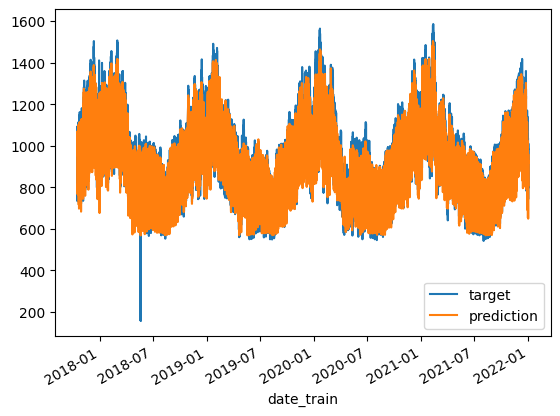

<Figure size 640x480 with 0 Axes>

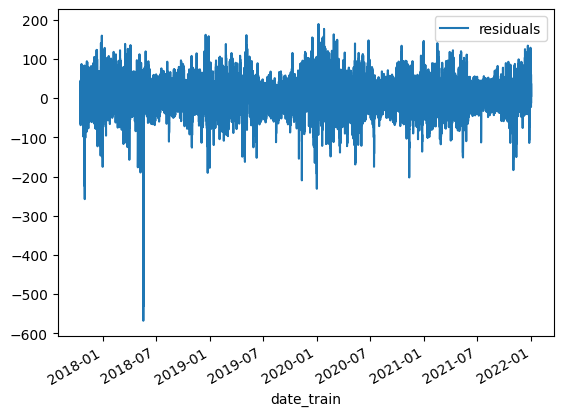

<Figure size 640x480 with 0 Axes>

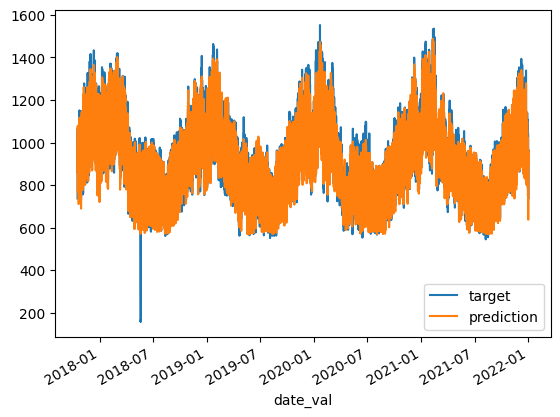

<Figure size 640x480 with 0 Axes>

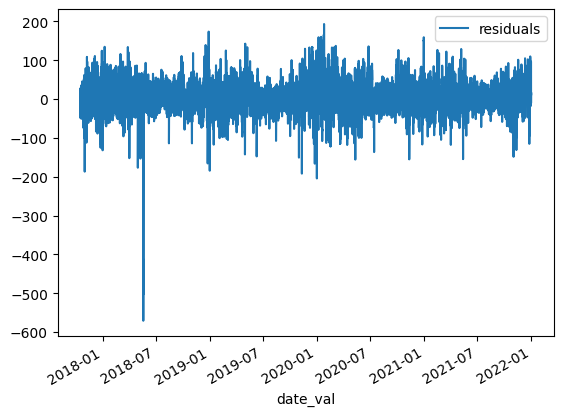

Epoch 1: 100%|██████████| 1818/1818 [00:03<00:00, 558.38it/s]


Epoch [1/200], Train Loss: 0.0044, Val Loss: 43.0469


Epoch 2: 100%|██████████| 1818/1818 [00:02<00:00, 667.78it/s]


Epoch [2/200], Train Loss: 0.0023, Val Loss: 34.7719


Epoch 3: 100%|██████████| 1818/1818 [00:02<00:00, 702.05it/s]


Epoch [3/200], Train Loss: 0.0017, Val Loss: 31.7513


Epoch 4: 100%|██████████| 1818/1818 [00:03<00:00, 474.25it/s]


Epoch [4/200], Train Loss: 0.0014, Val Loss: 28.9775


Epoch 5: 100%|██████████| 1818/1818 [00:03<00:00, 504.77it/s]


Epoch [5/200], Train Loss: 0.0013, Val Loss: 29.1764


Epoch 6: 100%|██████████| 1818/1818 [00:02<00:00, 718.83it/s]


Epoch [6/200], Train Loss: 0.0012, Val Loss: 28.0486


Epoch 7: 100%|██████████| 1818/1818 [00:03<00:00, 503.23it/s]


Epoch [7/200], Train Loss: 0.0011, Val Loss: 26.5652


Epoch 8: 100%|██████████| 1818/1818 [00:03<00:00, 468.51it/s]


Epoch [8/200], Train Loss: 0.0011, Val Loss: 28.3987


Epoch 9: 100%|██████████| 1818/1818 [00:04<00:00, 423.19it/s]


Epoch [9/200], Train Loss: 0.0010, Val Loss: 27.4099


Epoch 10: 100%|██████████| 1818/1818 [00:02<00:00, 625.10it/s]


Epoch [10/200], Train Loss: 0.0010, Val Loss: 26.0211


Epoch 11: 100%|██████████| 1818/1818 [00:03<00:00, 568.05it/s]


Epoch [11/200], Train Loss: 0.0010, Val Loss: 24.6270


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 720.95it/s]


Epoch [12/200], Train Loss: 0.0009, Val Loss: 25.4656


Epoch 13: 100%|██████████| 1818/1818 [00:02<00:00, 712.45it/s]


Epoch [13/200], Train Loss: 0.0009, Val Loss: 23.8446


Epoch 14: 100%|██████████| 1818/1818 [00:02<00:00, 715.43it/s]


Epoch [14/200], Train Loss: 0.0009, Val Loss: 25.2675


Epoch 15: 100%|██████████| 1818/1818 [00:03<00:00, 559.64it/s]


Epoch [15/200], Train Loss: 0.0009, Val Loss: 24.2906


Epoch 16: 100%|██████████| 1818/1818 [00:03<00:00, 571.15it/s]


Epoch [16/200], Train Loss: 0.0009, Val Loss: 24.6530


Epoch 17: 100%|██████████| 1818/1818 [00:02<00:00, 639.07it/s]


Epoch [17/200], Train Loss: 0.0008, Val Loss: 23.9574


Epoch 18: 100%|██████████| 1818/1818 [00:02<00:00, 614.73it/s]


Epoch [18/200], Train Loss: 0.0008, Val Loss: 22.8603


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 675.30it/s]


Epoch [19/200], Train Loss: 0.0008, Val Loss: 22.8364


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 707.26it/s]


Epoch [20/200], Train Loss: 0.0008, Val Loss: 26.7684


Epoch 21: 100%|██████████| 1818/1818 [00:02<00:00, 708.25it/s]


Epoch [21/200], Train Loss: 0.0008, Val Loss: 22.8070


Epoch 22: 100%|██████████| 1818/1818 [00:02<00:00, 629.06it/s]


Epoch [22/200], Train Loss: 0.0008, Val Loss: 22.1824


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 673.06it/s]


Epoch [23/200], Train Loss: 0.0008, Val Loss: 24.2548


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 723.11it/s]


Epoch [24/200], Train Loss: 0.0008, Val Loss: 26.1362


Epoch 25: 100%|██████████| 1818/1818 [00:02<00:00, 709.89it/s]


Epoch [25/200], Train Loss: 0.0008, Val Loss: 22.9194


Epoch 26: 100%|██████████| 1818/1818 [00:02<00:00, 634.74it/s]


Epoch [26/200], Train Loss: 0.0008, Val Loss: 22.3872


Epoch 27: 100%|██████████| 1818/1818 [00:02<00:00, 628.77it/s]


Epoch [27/200], Train Loss: 0.0007, Val Loss: 23.0618


Epoch 28: 100%|██████████| 1818/1818 [00:02<00:00, 720.52it/s]


Epoch [28/200], Train Loss: 0.0007, Val Loss: 22.0280


Epoch 29: 100%|██████████| 1818/1818 [00:02<00:00, 711.71it/s]


Epoch [29/200], Train Loss: 0.0007, Val Loss: 21.6414


Epoch 30: 100%|██████████| 1818/1818 [00:02<00:00, 649.92it/s]


Epoch [30/200], Train Loss: 0.0007, Val Loss: 22.9342


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 616.68it/s]


Epoch [31/200], Train Loss: 0.0007, Val Loss: 21.9869


Epoch 32: 100%|██████████| 1818/1818 [00:02<00:00, 715.60it/s]


Epoch [32/200], Train Loss: 0.0007, Val Loss: 23.9933


Epoch 33: 100%|██████████| 1818/1818 [00:02<00:00, 706.89it/s]


Epoch [33/200], Train Loss: 0.0007, Val Loss: 21.2951


Epoch 34: 100%|██████████| 1818/1818 [00:02<00:00, 656.86it/s]


Epoch [34/200], Train Loss: 0.0007, Val Loss: 22.9598


Epoch 35: 100%|██████████| 1818/1818 [00:02<00:00, 617.29it/s]


Epoch [35/200], Train Loss: 0.0007, Val Loss: 22.6429


Epoch 36: 100%|██████████| 1818/1818 [00:02<00:00, 715.57it/s]


Epoch [36/200], Train Loss: 0.0007, Val Loss: 21.7013


Epoch 37: 100%|██████████| 1818/1818 [00:02<00:00, 712.46it/s]


Epoch [37/200], Train Loss: 0.0007, Val Loss: 22.0749


Epoch 38: 100%|██████████| 1818/1818 [00:02<00:00, 635.20it/s]


Epoch [38/200], Train Loss: 0.0007, Val Loss: 23.4223


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 621.29it/s]


Epoch [39/200], Train Loss: 0.0007, Val Loss: 22.7586


Epoch 40: 100%|██████████| 1818/1818 [00:02<00:00, 709.84it/s]


Epoch [40/200], Train Loss: 0.0007, Val Loss: 25.2112


Epoch 41: 100%|██████████| 1818/1818 [00:02<00:00, 697.58it/s]


Epoch [41/200], Train Loss: 0.0007, Val Loss: 22.9357


Epoch 42: 100%|██████████| 1818/1818 [00:02<00:00, 642.41it/s]


Epoch [42/200], Train Loss: 0.0007, Val Loss: 21.5550


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 614.30it/s]


Early stopping triggered



######Métropole Nice Côte d'Azur######




<Figure size 640x480 with 0 Axes>

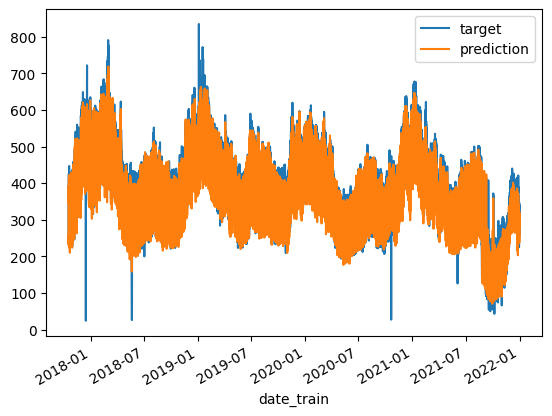

<Figure size 640x480 with 0 Axes>

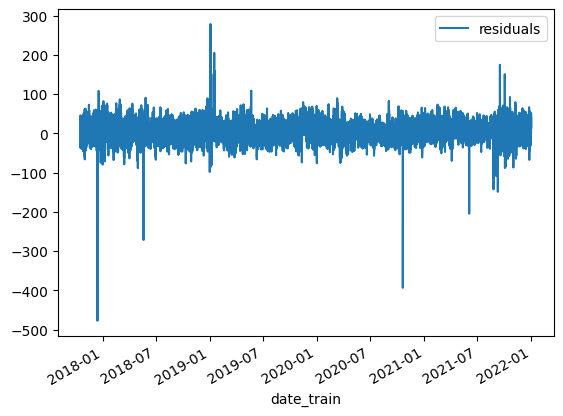

<Figure size 640x480 with 0 Axes>

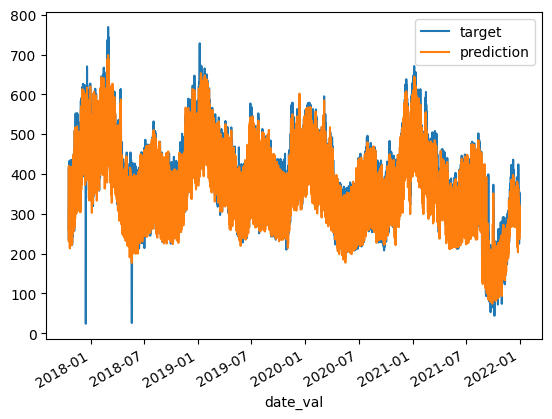

<Figure size 640x480 with 0 Axes>

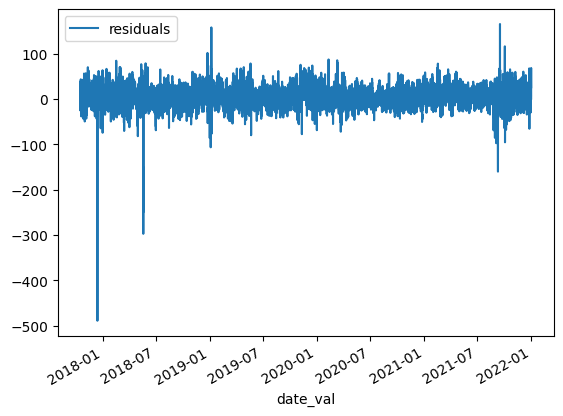

Epoch 1: 100%|██████████| 1818/1818 [00:02<00:00, 715.03it/s]


Epoch [1/200], Train Loss: 0.0035, Val Loss: 135.8698


Epoch 2: 100%|██████████| 1818/1818 [00:03<00:00, 535.57it/s]


Epoch [2/200], Train Loss: 0.0021, Val Loss: 123.5159


Epoch 3: 100%|██████████| 1818/1818 [00:02<00:00, 698.30it/s]


Epoch [3/200], Train Loss: 0.0019, Val Loss: 119.9987


Epoch 4: 100%|██████████| 1818/1818 [00:02<00:00, 710.48it/s]


Epoch [4/200], Train Loss: 0.0018, Val Loss: 116.0321


Epoch 5: 100%|██████████| 1818/1818 [00:02<00:00, 714.44it/s]


Epoch [5/200], Train Loss: 0.0016, Val Loss: 113.0362


Epoch 6: 100%|██████████| 1818/1818 [00:03<00:00, 543.69it/s]


Epoch [6/200], Train Loss: 0.0016, Val Loss: 110.9177


Epoch 7: 100%|██████████| 1818/1818 [00:02<00:00, 705.82it/s]


Epoch [7/200], Train Loss: 0.0016, Val Loss: 111.7354


Epoch 8: 100%|██████████| 1818/1818 [00:02<00:00, 711.66it/s]


Epoch [8/200], Train Loss: 0.0015, Val Loss: 109.3268


Epoch 9: 100%|██████████| 1818/1818 [00:02<00:00, 710.47it/s]


Epoch [9/200], Train Loss: 0.0014, Val Loss: 104.7409


Epoch 10: 100%|██████████| 1818/1818 [00:03<00:00, 551.55it/s]


Epoch [10/200], Train Loss: 0.0014, Val Loss: 104.7445


Epoch 11: 100%|██████████| 1818/1818 [00:02<00:00, 715.12it/s]


Epoch [11/200], Train Loss: 0.0014, Val Loss: 106.5017


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 711.80it/s]


Epoch [12/200], Train Loss: 0.0013, Val Loss: 103.7688


Epoch 13: 100%|██████████| 1818/1818 [00:02<00:00, 717.01it/s]


Epoch [13/200], Train Loss: 0.0013, Val Loss: 102.0529


Epoch 14: 100%|██████████| 1818/1818 [00:03<00:00, 551.24it/s]


Epoch [14/200], Train Loss: 0.0013, Val Loss: 99.7113


Epoch 15: 100%|██████████| 1818/1818 [00:02<00:00, 706.37it/s]


Epoch [15/200], Train Loss: 0.0012, Val Loss: 98.4202


Epoch 16: 100%|██████████| 1818/1818 [00:02<00:00, 713.77it/s]


Epoch [16/200], Train Loss: 0.0012, Val Loss: 98.0124


Epoch 17: 100%|██████████| 1818/1818 [00:02<00:00, 713.64it/s]


Epoch [17/200], Train Loss: 0.0012, Val Loss: 100.0138


Epoch 18: 100%|██████████| 1818/1818 [00:03<00:00, 551.77it/s]


Epoch [18/200], Train Loss: 0.0012, Val Loss: 96.9472


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 727.07it/s]


Epoch [19/200], Train Loss: 0.0012, Val Loss: 95.6526


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 727.18it/s]


Epoch [20/200], Train Loss: 0.0012, Val Loss: 94.9754


Epoch 21: 100%|██████████| 1818/1818 [00:02<00:00, 722.90it/s]


Epoch [21/200], Train Loss: 0.0011, Val Loss: 97.4411


Epoch 22: 100%|██████████| 1818/1818 [00:03<00:00, 543.68it/s]


Epoch [22/200], Train Loss: 0.0011, Val Loss: 94.3796


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 716.13it/s]


Epoch [23/200], Train Loss: 0.0011, Val Loss: 94.8901


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 709.81it/s]


Epoch [24/200], Train Loss: 0.0011, Val Loss: 98.7260


Epoch 25: 100%|██████████| 1818/1818 [00:02<00:00, 709.59it/s]


Epoch [25/200], Train Loss: 0.0011, Val Loss: 94.3398


Epoch 26: 100%|██████████| 1818/1818 [00:03<00:00, 553.32it/s]


Epoch [26/200], Train Loss: 0.0011, Val Loss: 92.3847


Epoch 27: 100%|██████████| 1818/1818 [00:02<00:00, 713.30it/s]


Epoch [27/200], Train Loss: 0.0011, Val Loss: 98.0310


Epoch 28: 100%|██████████| 1818/1818 [00:02<00:00, 720.85it/s]


Epoch [28/200], Train Loss: 0.0011, Val Loss: 92.8786


Epoch 29: 100%|██████████| 1818/1818 [00:02<00:00, 705.58it/s]


Epoch [29/200], Train Loss: 0.0011, Val Loss: 92.5836


Epoch 30: 100%|██████████| 1818/1818 [00:03<00:00, 554.07it/s]


Epoch [30/200], Train Loss: 0.0011, Val Loss: 92.1090


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 715.27it/s]


Epoch [31/200], Train Loss: 0.0010, Val Loss: 92.9886


Epoch 32: 100%|██████████| 1818/1818 [00:02<00:00, 708.45it/s]


Epoch [32/200], Train Loss: 0.0010, Val Loss: 91.6618


Epoch 33: 100%|██████████| 1818/1818 [00:02<00:00, 716.28it/s]


Epoch [33/200], Train Loss: 0.0010, Val Loss: 91.2561


Epoch 34: 100%|██████████| 1818/1818 [00:03<00:00, 545.89it/s]


Epoch [34/200], Train Loss: 0.0010, Val Loss: 89.9351


Epoch 35: 100%|██████████| 1818/1818 [00:02<00:00, 706.96it/s]


Epoch [35/200], Train Loss: 0.0010, Val Loss: 91.4582


Epoch 36: 100%|██████████| 1818/1818 [00:02<00:00, 706.99it/s]


Epoch [36/200], Train Loss: 0.0010, Val Loss: 90.0650


Epoch 37: 100%|██████████| 1818/1818 [00:02<00:00, 723.20it/s]


Epoch [37/200], Train Loss: 0.0010, Val Loss: 91.3120


Epoch 38: 100%|██████████| 1818/1818 [00:03<00:00, 549.67it/s]


Epoch [38/200], Train Loss: 0.0010, Val Loss: 88.5816


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 706.25it/s]


Epoch [39/200], Train Loss: 0.0010, Val Loss: 89.4906


Epoch 40: 100%|██████████| 1818/1818 [00:02<00:00, 722.67it/s]


Epoch [40/200], Train Loss: 0.0010, Val Loss: 92.7865


Epoch 41: 100%|██████████| 1818/1818 [00:02<00:00, 707.23it/s]


Epoch [41/200], Train Loss: 0.0010, Val Loss: 92.1029


Epoch 42: 100%|██████████| 1818/1818 [00:03<00:00, 567.80it/s]


Epoch [42/200], Train Loss: 0.0010, Val Loss: 92.6738


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 718.39it/s]


Epoch [43/200], Train Loss: 0.0010, Val Loss: 89.5879


Epoch 44: 100%|██████████| 1818/1818 [00:02<00:00, 709.43it/s]


Epoch [44/200], Train Loss: 0.0010, Val Loss: 89.7260


Epoch 45: 100%|██████████| 1818/1818 [00:02<00:00, 700.76it/s]


Epoch [45/200], Train Loss: 0.0010, Val Loss: 87.7137


Epoch 46: 100%|██████████| 1818/1818 [00:03<00:00, 557.07it/s]


Epoch [46/200], Train Loss: 0.0010, Val Loss: 93.6503


Epoch 47: 100%|██████████| 1818/1818 [00:02<00:00, 686.92it/s]


Epoch [47/200], Train Loss: 0.0010, Val Loss: 87.9350


Epoch 48: 100%|██████████| 1818/1818 [00:02<00:00, 717.27it/s]


Epoch [48/200], Train Loss: 0.0009, Val Loss: 88.1542


Epoch 49: 100%|██████████| 1818/1818 [00:02<00:00, 701.46it/s]


Epoch [49/200], Train Loss: 0.0009, Val Loss: 88.0809


Epoch 50: 100%|██████████| 1818/1818 [00:03<00:00, 568.56it/s]


Epoch [50/200], Train Loss: 0.0009, Val Loss: 88.1329


Epoch 51: 100%|██████████| 1818/1818 [00:02<00:00, 715.38it/s]


Epoch [51/200], Train Loss: 0.0009, Val Loss: 90.0869


Epoch 52: 100%|██████████| 1818/1818 [00:02<00:00, 711.90it/s]


Epoch [52/200], Train Loss: 0.0009, Val Loss: 94.1079


Epoch 53: 100%|██████████| 1818/1818 [00:02<00:00, 696.04it/s]


Epoch [53/200], Train Loss: 0.0009, Val Loss: 86.3604


Epoch 54: 100%|██████████| 1818/1818 [00:03<00:00, 529.25it/s]


Epoch [54/200], Train Loss: 0.0009, Val Loss: 88.0349


Epoch 55: 100%|██████████| 1818/1818 [00:02<00:00, 696.34it/s]


Epoch [55/200], Train Loss: 0.0009, Val Loss: 85.6190


Epoch 56: 100%|██████████| 1818/1818 [00:02<00:00, 685.66it/s]


Epoch [56/200], Train Loss: 0.0009, Val Loss: 90.1726


Epoch 57: 100%|██████████| 1818/1818 [00:02<00:00, 711.90it/s]


Epoch [57/200], Train Loss: 0.0009, Val Loss: 88.7385


Epoch 58: 100%|██████████| 1818/1818 [00:03<00:00, 547.25it/s]


Epoch [58/200], Train Loss: 0.0009, Val Loss: 86.4068


Epoch 59: 100%|██████████| 1818/1818 [00:02<00:00, 714.87it/s]


Epoch [59/200], Train Loss: 0.0009, Val Loss: 85.4078


Epoch 60: 100%|██████████| 1818/1818 [00:02<00:00, 703.31it/s]


Epoch [60/200], Train Loss: 0.0009, Val Loss: 87.2847


Epoch 61: 100%|██████████| 1818/1818 [00:02<00:00, 699.54it/s]


Epoch [61/200], Train Loss: 0.0009, Val Loss: 86.5113


Epoch 62: 100%|██████████| 1818/1818 [00:03<00:00, 545.43it/s]


Epoch [62/200], Train Loss: 0.0009, Val Loss: 87.6146


Epoch 63: 100%|██████████| 1818/1818 [00:02<00:00, 701.31it/s]


Epoch [63/200], Train Loss: 0.0009, Val Loss: 92.8856


Epoch 64: 100%|██████████| 1818/1818 [00:02<00:00, 702.24it/s]


Epoch [64/200], Train Loss: 0.0009, Val Loss: 86.5801


Epoch 65: 100%|██████████| 1818/1818 [00:02<00:00, 695.30it/s]


Epoch [65/200], Train Loss: 0.0009, Val Loss: 85.3387


Epoch 66: 100%|██████████| 1818/1818 [00:03<00:00, 535.88it/s]


Epoch [66/200], Train Loss: 0.0009, Val Loss: 84.5693


Epoch 67: 100%|██████████| 1818/1818 [00:02<00:00, 708.53it/s]


Epoch [67/200], Train Loss: 0.0009, Val Loss: 87.9000


Epoch 68: 100%|██████████| 1818/1818 [00:02<00:00, 698.56it/s]


Epoch [68/200], Train Loss: 0.0009, Val Loss: 84.1155


Epoch 69: 100%|██████████| 1818/1818 [00:02<00:00, 704.88it/s]


Epoch [69/200], Train Loss: 0.0009, Val Loss: 84.0990


Epoch 70: 100%|██████████| 1818/1818 [00:03<00:00, 541.39it/s]


Epoch [70/200], Train Loss: 0.0009, Val Loss: 84.1796


Epoch 71: 100%|██████████| 1818/1818 [00:02<00:00, 691.82it/s]


Epoch [71/200], Train Loss: 0.0009, Val Loss: 85.9525


Epoch 72: 100%|██████████| 1818/1818 [00:02<00:00, 704.61it/s]


Epoch [72/200], Train Loss: 0.0009, Val Loss: 83.8491


Epoch 73: 100%|██████████| 1818/1818 [00:02<00:00, 709.08it/s]


Epoch [73/200], Train Loss: 0.0009, Val Loss: 85.6346


Epoch 74: 100%|██████████| 1818/1818 [00:03<00:00, 542.41it/s]


Epoch [74/200], Train Loss: 0.0009, Val Loss: 85.8359


Epoch 75: 100%|██████████| 1818/1818 [00:02<00:00, 710.59it/s]


Epoch [75/200], Train Loss: 0.0008, Val Loss: 86.6341


Epoch 76: 100%|██████████| 1818/1818 [00:02<00:00, 710.50it/s]


Epoch [76/200], Train Loss: 0.0008, Val Loss: 84.9120


Epoch 77: 100%|██████████| 1818/1818 [00:02<00:00, 709.05it/s]


Epoch [77/200], Train Loss: 0.0008, Val Loss: 84.8237


Epoch 78: 100%|██████████| 1818/1818 [00:03<00:00, 542.87it/s]


Epoch [78/200], Train Loss: 0.0008, Val Loss: 83.8318


Epoch 79: 100%|██████████| 1818/1818 [00:02<00:00, 696.71it/s]


Epoch [79/200], Train Loss: 0.0008, Val Loss: 83.0884


Epoch 80: 100%|██████████| 1818/1818 [00:02<00:00, 704.56it/s]


Epoch [80/200], Train Loss: 0.0008, Val Loss: 86.0302


Epoch 81: 100%|██████████| 1818/1818 [00:02<00:00, 704.53it/s]


Epoch [81/200], Train Loss: 0.0008, Val Loss: 82.6104


Epoch 82: 100%|██████████| 1818/1818 [00:03<00:00, 540.99it/s]


Epoch [82/200], Train Loss: 0.0008, Val Loss: 84.8593


Epoch 83: 100%|██████████| 1818/1818 [00:02<00:00, 706.42it/s]


Epoch [83/200], Train Loss: 0.0008, Val Loss: 82.7004


Epoch 84: 100%|██████████| 1818/1818 [00:02<00:00, 687.23it/s]


Epoch [84/200], Train Loss: 0.0008, Val Loss: 83.6377


Epoch 85: 100%|██████████| 1818/1818 [00:02<00:00, 691.72it/s]


Epoch [85/200], Train Loss: 0.0008, Val Loss: 83.1278


Epoch 86: 100%|██████████| 1818/1818 [00:03<00:00, 532.96it/s]


Epoch [86/200], Train Loss: 0.0008, Val Loss: 84.3071


Epoch 87: 100%|██████████| 1818/1818 [00:02<00:00, 693.05it/s]


Epoch [87/200], Train Loss: 0.0008, Val Loss: 83.1029


Epoch 88: 100%|██████████| 1818/1818 [00:02<00:00, 698.69it/s]


Epoch [88/200], Train Loss: 0.0008, Val Loss: 81.4254


Epoch 89: 100%|██████████| 1818/1818 [00:02<00:00, 689.15it/s]


Epoch [89/200], Train Loss: 0.0008, Val Loss: 80.8482


Epoch 90: 100%|██████████| 1818/1818 [00:03<00:00, 545.09it/s]


Epoch [90/200], Train Loss: 0.0008, Val Loss: 84.2851


Epoch 91: 100%|██████████| 1818/1818 [00:02<00:00, 699.64it/s]


Epoch [91/200], Train Loss: 0.0008, Val Loss: 84.6897


Epoch 92: 100%|██████████| 1818/1818 [00:02<00:00, 699.46it/s]


Epoch [92/200], Train Loss: 0.0008, Val Loss: 83.1721


Epoch 93: 100%|██████████| 1818/1818 [00:02<00:00, 707.19it/s]


Epoch [93/200], Train Loss: 0.0008, Val Loss: 83.4034


Epoch 94: 100%|██████████| 1818/1818 [00:03<00:00, 524.49it/s]


Epoch [94/200], Train Loss: 0.0008, Val Loss: 82.9944


Epoch 95: 100%|██████████| 1818/1818 [00:02<00:00, 694.69it/s]


Epoch [95/200], Train Loss: 0.0008, Val Loss: 82.5097


Epoch 96: 100%|██████████| 1818/1818 [00:02<00:00, 699.61it/s]


Epoch [96/200], Train Loss: 0.0008, Val Loss: 90.5159


Epoch 97: 100%|██████████| 1818/1818 [00:02<00:00, 705.77it/s]


Epoch [97/200], Train Loss: 0.0008, Val Loss: 81.7383


Epoch 98: 100%|██████████| 1818/1818 [00:03<00:00, 542.76it/s]


Epoch [98/200], Train Loss: 0.0008, Val Loss: 84.1235


Epoch 99: 100%|██████████| 1818/1818 [00:02<00:00, 711.53it/s]


Early stopping triggered



######Métropole d'Aix-Marseille-Provence######




<Figure size 640x480 with 0 Axes>

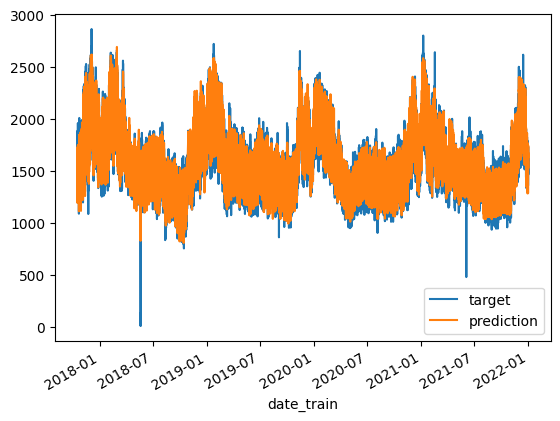

<Figure size 640x480 with 0 Axes>

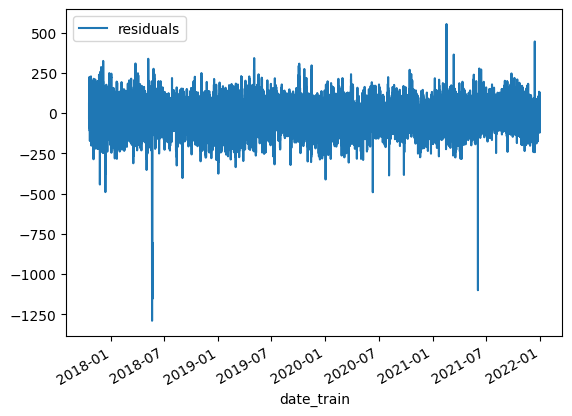

<Figure size 640x480 with 0 Axes>

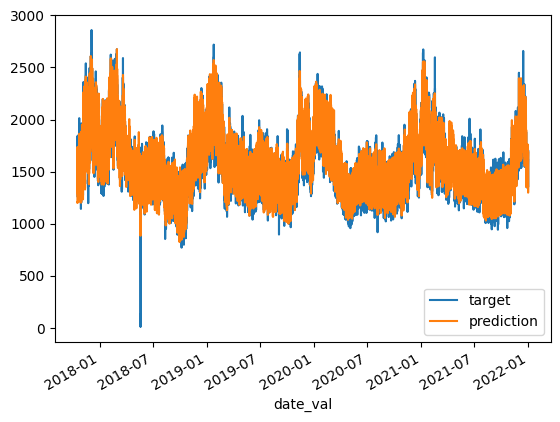

<Figure size 640x480 with 0 Axes>

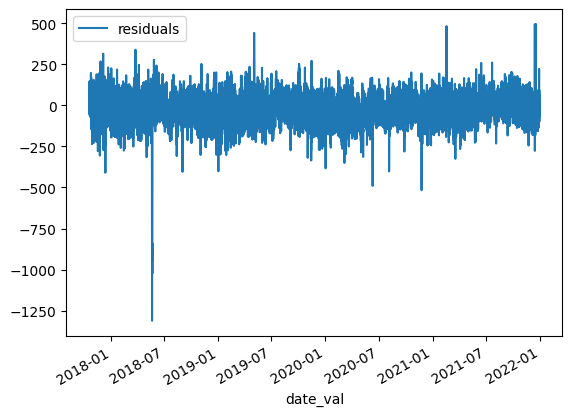

Epoch 1: 100%|██████████| 1818/1818 [00:03<00:00, 591.14it/s]


Epoch [1/200], Train Loss: 0.0051, Val Loss: 83.4329


Epoch 2: 100%|██████████| 1818/1818 [00:02<00:00, 682.45it/s]


Epoch [2/200], Train Loss: 0.0019, Val Loss: 69.3260


Epoch 3: 100%|██████████| 1818/1818 [00:02<00:00, 694.73it/s]


Epoch [3/200], Train Loss: 0.0015, Val Loss: 67.0954


Epoch 4: 100%|██████████| 1818/1818 [00:02<00:00, 702.56it/s]


Epoch [4/200], Train Loss: 0.0014, Val Loss: 63.2806


Epoch 5: 100%|██████████| 1818/1818 [00:03<00:00, 572.10it/s]


Epoch [5/200], Train Loss: 0.0013, Val Loss: 63.2343


Epoch 6: 100%|██████████| 1818/1818 [00:02<00:00, 699.65it/s]


Epoch [6/200], Train Loss: 0.0012, Val Loss: 57.2476


Epoch 7: 100%|██████████| 1818/1818 [00:02<00:00, 708.29it/s]


Epoch [7/200], Train Loss: 0.0011, Val Loss: 58.8275


Epoch 8: 100%|██████████| 1818/1818 [00:02<00:00, 694.52it/s]


Epoch [8/200], Train Loss: 0.0011, Val Loss: 59.1402


Epoch 9: 100%|██████████| 1818/1818 [00:03<00:00, 571.35it/s]


Epoch [9/200], Train Loss: 0.0011, Val Loss: 54.3658


Epoch 10: 100%|██████████| 1818/1818 [00:02<00:00, 699.62it/s]


Epoch [10/200], Train Loss: 0.0010, Val Loss: 55.5619


Epoch 11: 100%|██████████| 1818/1818 [00:02<00:00, 699.49it/s]


Epoch [11/200], Train Loss: 0.0010, Val Loss: 55.2241


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 699.63it/s]


Epoch [12/200], Train Loss: 0.0010, Val Loss: 56.9325


Epoch 13: 100%|██████████| 1818/1818 [00:03<00:00, 560.46it/s]


Epoch [13/200], Train Loss: 0.0010, Val Loss: 54.5336


Epoch 14: 100%|██████████| 1818/1818 [00:02<00:00, 696.24it/s]


Epoch [14/200], Train Loss: 0.0009, Val Loss: 52.5966


Epoch 15: 100%|██████████| 1818/1818 [00:02<00:00, 691.52it/s]


Epoch [15/200], Train Loss: 0.0009, Val Loss: 51.7417


Epoch 16: 100%|██████████| 1818/1818 [00:02<00:00, 700.04it/s]


Epoch [16/200], Train Loss: 0.0009, Val Loss: 54.7051


Epoch 17: 100%|██████████| 1818/1818 [00:03<00:00, 547.63it/s]


Epoch [17/200], Train Loss: 0.0009, Val Loss: 57.4320


Epoch 18: 100%|██████████| 1818/1818 [00:02<00:00, 694.63it/s]


Epoch [18/200], Train Loss: 0.0009, Val Loss: 53.8470


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 695.92it/s]


Epoch [19/200], Train Loss: 0.0009, Val Loss: 49.3992


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 705.53it/s]


Epoch [20/200], Train Loss: 0.0009, Val Loss: 50.7432


Epoch 21: 100%|██████████| 1818/1818 [00:03<00:00, 549.77it/s]


Epoch [21/200], Train Loss: 0.0009, Val Loss: 51.1849


Epoch 22: 100%|██████████| 1818/1818 [00:02<00:00, 707.71it/s]


Epoch [22/200], Train Loss: 0.0008, Val Loss: 50.0526


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 698.82it/s]


Epoch [23/200], Train Loss: 0.0008, Val Loss: 50.7991


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 707.87it/s]


Epoch [24/200], Train Loss: 0.0008, Val Loss: 50.4534


Epoch 25: 100%|██████████| 1818/1818 [00:03<00:00, 535.61it/s]


Epoch [25/200], Train Loss: 0.0008, Val Loss: 47.7195


Epoch 26: 100%|██████████| 1818/1818 [00:02<00:00, 705.72it/s]


Epoch [26/200], Train Loss: 0.0008, Val Loss: 48.9300


Epoch 27: 100%|██████████| 1818/1818 [00:02<00:00, 716.57it/s]


Epoch [27/200], Train Loss: 0.0008, Val Loss: 55.1710


Epoch 28: 100%|██████████| 1818/1818 [00:02<00:00, 695.21it/s]


Epoch [28/200], Train Loss: 0.0008, Val Loss: 62.2658


Epoch 29: 100%|██████████| 1818/1818 [00:03<00:00, 535.62it/s]


Epoch [29/200], Train Loss: 0.0008, Val Loss: 49.0974


Epoch 30: 100%|██████████| 1818/1818 [00:02<00:00, 699.17it/s]


Epoch [30/200], Train Loss: 0.0008, Val Loss: 47.2591


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 717.26it/s]


Epoch [31/200], Train Loss: 0.0008, Val Loss: 47.1152


Epoch 32: 100%|██████████| 1818/1818 [00:02<00:00, 702.70it/s]


Epoch [32/200], Train Loss: 0.0008, Val Loss: 49.5368


Epoch 33: 100%|██████████| 1818/1818 [00:03<00:00, 540.58it/s]


Epoch [33/200], Train Loss: 0.0008, Val Loss: 50.0520


Epoch 34: 100%|██████████| 1818/1818 [00:02<00:00, 703.18it/s]


Epoch [34/200], Train Loss: 0.0008, Val Loss: 50.1096


Epoch 35: 100%|██████████| 1818/1818 [00:02<00:00, 710.71it/s]


Epoch [35/200], Train Loss: 0.0008, Val Loss: 48.3371


Epoch 36: 100%|██████████| 1818/1818 [00:02<00:00, 709.16it/s]


Epoch [36/200], Train Loss: 0.0007, Val Loss: 51.5346


Epoch 37: 100%|██████████| 1818/1818 [00:03<00:00, 540.00it/s]


Epoch [37/200], Train Loss: 0.0007, Val Loss: 45.6045


Epoch 38: 100%|██████████| 1818/1818 [00:02<00:00, 692.64it/s]


Epoch [38/200], Train Loss: 0.0007, Val Loss: 49.4938


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 699.47it/s]


Epoch [39/200], Train Loss: 0.0007, Val Loss: 47.6955


Epoch 40: 100%|██████████| 1818/1818 [00:02<00:00, 709.73it/s]


Epoch [40/200], Train Loss: 0.0007, Val Loss: 46.9753


Epoch 41: 100%|██████████| 1818/1818 [00:03<00:00, 536.97it/s]


Epoch [41/200], Train Loss: 0.0007, Val Loss: 45.8493


Epoch 42: 100%|██████████| 1818/1818 [00:02<00:00, 695.11it/s]


Epoch [42/200], Train Loss: 0.0007, Val Loss: 45.0555


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 696.49it/s]


Epoch [43/200], Train Loss: 0.0007, Val Loss: 46.3380


Epoch 44: 100%|██████████| 1818/1818 [00:02<00:00, 704.66it/s]


Epoch [44/200], Train Loss: 0.0007, Val Loss: 44.8275


Epoch 45: 100%|██████████| 1818/1818 [00:03<00:00, 537.54it/s]


Epoch [45/200], Train Loss: 0.0007, Val Loss: 48.3505


Epoch 46: 100%|██████████| 1818/1818 [00:02<00:00, 700.13it/s]


Epoch [46/200], Train Loss: 0.0007, Val Loss: 46.1190


Epoch 47: 100%|██████████| 1818/1818 [00:02<00:00, 697.20it/s]


Epoch [47/200], Train Loss: 0.0007, Val Loss: 44.5833


Epoch 48: 100%|██████████| 1818/1818 [00:02<00:00, 671.41it/s]


Epoch [48/200], Train Loss: 0.0007, Val Loss: 46.9193


Epoch 49: 100%|██████████| 1818/1818 [00:03<00:00, 529.86it/s]


Epoch [49/200], Train Loss: 0.0007, Val Loss: 44.9568


Epoch 50: 100%|██████████| 1818/1818 [00:02<00:00, 698.29it/s]


Epoch [50/200], Train Loss: 0.0007, Val Loss: 45.3378


Epoch 51: 100%|██████████| 1818/1818 [00:02<00:00, 684.09it/s]


Epoch [51/200], Train Loss: 0.0007, Val Loss: 44.8893


Epoch 52: 100%|██████████| 1818/1818 [00:02<00:00, 687.00it/s]


Epoch [52/200], Train Loss: 0.0007, Val Loss: 44.4828


Epoch 53: 100%|██████████| 1818/1818 [00:03<00:00, 529.88it/s]


Epoch [53/200], Train Loss: 0.0007, Val Loss: 45.8607


Epoch 54: 100%|██████████| 1818/1818 [00:02<00:00, 686.10it/s]


Epoch [54/200], Train Loss: 0.0007, Val Loss: 45.4186


Epoch 55: 100%|██████████| 1818/1818 [00:02<00:00, 683.96it/s]


Epoch [55/200], Train Loss: 0.0007, Val Loss: 44.5241


Epoch 56: 100%|██████████| 1818/1818 [00:02<00:00, 688.73it/s]


Epoch [56/200], Train Loss: 0.0007, Val Loss: 44.4619


Epoch 57: 100%|██████████| 1818/1818 [00:03<00:00, 535.68it/s]


Epoch [57/200], Train Loss: 0.0007, Val Loss: 45.7644


Epoch 58: 100%|██████████| 1818/1818 [00:02<00:00, 695.87it/s]


Epoch [58/200], Train Loss: 0.0007, Val Loss: 44.5333


Epoch 59: 100%|██████████| 1818/1818 [00:02<00:00, 694.13it/s]


Epoch [59/200], Train Loss: 0.0007, Val Loss: 43.8310


Epoch 60: 100%|██████████| 1818/1818 [00:02<00:00, 691.17it/s]


Epoch [60/200], Train Loss: 0.0007, Val Loss: 46.9382


Epoch 61: 100%|██████████| 1818/1818 [00:03<00:00, 552.72it/s]


Epoch [61/200], Train Loss: 0.0007, Val Loss: 43.6698


Epoch 62: 100%|██████████| 1818/1818 [00:02<00:00, 702.29it/s]


Epoch [62/200], Train Loss: 0.0007, Val Loss: 43.2269


Epoch 63: 100%|██████████| 1818/1818 [00:02<00:00, 702.15it/s]


Epoch [63/200], Train Loss: 0.0007, Val Loss: 44.5837


Epoch 64: 100%|██████████| 1818/1818 [00:02<00:00, 695.56it/s]


Epoch [64/200], Train Loss: 0.0007, Val Loss: 45.2818


Epoch 65: 100%|██████████| 1818/1818 [00:03<00:00, 559.42it/s]


Epoch [65/200], Train Loss: 0.0007, Val Loss: 43.1730


Epoch 66: 100%|██████████| 1818/1818 [00:02<00:00, 703.46it/s]


Epoch [66/200], Train Loss: 0.0007, Val Loss: 44.3124


Epoch 67: 100%|██████████| 1818/1818 [00:02<00:00, 700.11it/s]


Epoch [67/200], Train Loss: 0.0007, Val Loss: 47.2514


Epoch 68: 100%|██████████| 1818/1818 [00:02<00:00, 684.93it/s]


Epoch [68/200], Train Loss: 0.0007, Val Loss: 44.5215


Epoch 69: 100%|██████████| 1818/1818 [00:03<00:00, 569.39it/s]


Epoch [69/200], Train Loss: 0.0007, Val Loss: 44.5721


Epoch 70: 100%|██████████| 1818/1818 [00:02<00:00, 688.72it/s]


Epoch [70/200], Train Loss: 0.0007, Val Loss: 42.9165


Epoch 71: 100%|██████████| 1818/1818 [00:02<00:00, 700.81it/s]


Epoch [71/200], Train Loss: 0.0007, Val Loss: 42.8665


Epoch 72: 100%|██████████| 1818/1818 [00:02<00:00, 698.82it/s]


Epoch [72/200], Train Loss: 0.0007, Val Loss: 43.8864


Epoch 73: 100%|██████████| 1818/1818 [00:03<00:00, 567.81it/s]


Epoch [73/200], Train Loss: 0.0006, Val Loss: 48.0959


Epoch 74: 100%|██████████| 1818/1818 [00:02<00:00, 699.97it/s]


Epoch [74/200], Train Loss: 0.0007, Val Loss: 43.7011


Epoch 75: 100%|██████████| 1818/1818 [00:02<00:00, 696.83it/s]


Epoch [75/200], Train Loss: 0.0007, Val Loss: 43.6570


Epoch 76: 100%|██████████| 1818/1818 [00:02<00:00, 692.50it/s]


Epoch [76/200], Train Loss: 0.0006, Val Loss: 42.1703


Epoch 77: 100%|██████████| 1818/1818 [00:03<00:00, 563.79it/s]


Epoch [77/200], Train Loss: 0.0006, Val Loss: 43.7963


Epoch 78: 100%|██████████| 1818/1818 [00:02<00:00, 694.85it/s]


Epoch [78/200], Train Loss: 0.0006, Val Loss: 42.7184


Epoch 79: 100%|██████████| 1818/1818 [00:02<00:00, 692.61it/s]


Epoch [79/200], Train Loss: 0.0006, Val Loss: 44.1218


Epoch 80: 100%|██████████| 1818/1818 [00:02<00:00, 655.53it/s]


Epoch [80/200], Train Loss: 0.0006, Val Loss: 43.0274


Epoch 81: 100%|██████████| 1818/1818 [00:03<00:00, 568.31it/s]


Epoch [81/200], Train Loss: 0.0006, Val Loss: 41.7880


Epoch 82: 100%|██████████| 1818/1818 [00:02<00:00, 694.16it/s]


Epoch [82/200], Train Loss: 0.0006, Val Loss: 43.7175


Epoch 83: 100%|██████████| 1818/1818 [00:02<00:00, 693.07it/s]


Epoch [83/200], Train Loss: 0.0006, Val Loss: 46.9325


Epoch 84: 100%|██████████| 1818/1818 [00:02<00:00, 631.25it/s]


Epoch [84/200], Train Loss: 0.0006, Val Loss: 43.3037


Epoch 85: 100%|██████████| 1818/1818 [00:02<00:00, 609.27it/s]


Epoch [85/200], Train Loss: 0.0006, Val Loss: 41.7100


Epoch 86: 100%|██████████| 1818/1818 [00:02<00:00, 710.62it/s]


Epoch [86/200], Train Loss: 0.0006, Val Loss: 43.5805


Epoch 87: 100%|██████████| 1818/1818 [00:02<00:00, 679.60it/s]


Epoch [87/200], Train Loss: 0.0006, Val Loss: 43.2210


Epoch 88: 100%|██████████| 1818/1818 [00:02<00:00, 643.42it/s]


Epoch [88/200], Train Loss: 0.0006, Val Loss: 45.6530


Epoch 89: 100%|██████████| 1818/1818 [00:03<00:00, 595.82it/s]


Epoch [89/200], Train Loss: 0.0006, Val Loss: 42.8345


Epoch 90: 100%|██████████| 1818/1818 [00:02<00:00, 695.13it/s]


Epoch [90/200], Train Loss: 0.0006, Val Loss: 42.0886


Epoch 91: 100%|██████████| 1818/1818 [00:02<00:00, 691.56it/s]


Epoch [91/200], Train Loss: 0.0006, Val Loss: 43.0089


Epoch 92: 100%|██████████| 1818/1818 [00:02<00:00, 632.14it/s]


Epoch [92/200], Train Loss: 0.0006, Val Loss: 42.1048


Epoch 93: 100%|██████████| 1818/1818 [00:02<00:00, 607.57it/s]


Epoch [93/200], Train Loss: 0.0006, Val Loss: 44.6209


Epoch 94: 100%|██████████| 1818/1818 [00:02<00:00, 698.76it/s]


Epoch [94/200], Train Loss: 0.0006, Val Loss: 41.6242


Epoch 95: 100%|██████████| 1818/1818 [00:02<00:00, 689.42it/s]


Epoch [95/200], Train Loss: 0.0006, Val Loss: 41.5250


Epoch 96: 100%|██████████| 1818/1818 [00:02<00:00, 610.56it/s]


Epoch [96/200], Train Loss: 0.0006, Val Loss: 42.3588


Epoch 97: 100%|██████████| 1818/1818 [00:02<00:00, 622.36it/s]


Epoch [97/200], Train Loss: 0.0006, Val Loss: 43.7732


Epoch 98: 100%|██████████| 1818/1818 [00:02<00:00, 693.16it/s]


Epoch [98/200], Train Loss: 0.0006, Val Loss: 41.0455


Epoch 99: 100%|██████████| 1818/1818 [00:02<00:00, 686.59it/s]


Epoch [99/200], Train Loss: 0.0006, Val Loss: 43.7897


Epoch 100: 100%|██████████| 1818/1818 [00:03<00:00, 588.78it/s]


Epoch [100/200], Train Loss: 0.0006, Val Loss: 41.6811


Epoch 101: 100%|██████████| 1818/1818 [00:02<00:00, 653.97it/s]


Epoch [101/200], Train Loss: 0.0006, Val Loss: 42.6152


Epoch 102: 100%|██████████| 1818/1818 [00:02<00:00, 690.52it/s]


Epoch [102/200], Train Loss: 0.0006, Val Loss: 41.7855


Epoch 103: 100%|██████████| 1818/1818 [00:02<00:00, 696.32it/s]


Epoch [103/200], Train Loss: 0.0006, Val Loss: 42.0864


Epoch 104: 100%|██████████| 1818/1818 [00:02<00:00, 606.69it/s]


Epoch [104/200], Train Loss: 0.0006, Val Loss: 41.7278


Epoch 105: 100%|██████████| 1818/1818 [00:02<00:00, 668.58it/s]


Epoch [105/200], Train Loss: 0.0006, Val Loss: 40.9636


Epoch 106: 100%|██████████| 1818/1818 [00:02<00:00, 708.24it/s]


Epoch [106/200], Train Loss: 0.0006, Val Loss: 41.5485


Epoch 107: 100%|██████████| 1818/1818 [00:02<00:00, 692.45it/s]


Epoch [107/200], Train Loss: 0.0006, Val Loss: 40.5642


Epoch 108: 100%|██████████| 1818/1818 [00:03<00:00, 588.67it/s]


Epoch [108/200], Train Loss: 0.0006, Val Loss: 48.6289


Epoch 109: 100%|██████████| 1818/1818 [00:02<00:00, 674.91it/s]


Epoch [109/200], Train Loss: 0.0006, Val Loss: 42.9229


Epoch 110: 100%|██████████| 1818/1818 [00:02<00:00, 699.38it/s]


Epoch [110/200], Train Loss: 0.0006, Val Loss: 40.2469


Epoch 111: 100%|██████████| 1818/1818 [00:02<00:00, 690.94it/s]


Epoch [111/200], Train Loss: 0.0006, Val Loss: 40.6915


Epoch 112: 100%|██████████| 1818/1818 [00:03<00:00, 579.54it/s]


Epoch [112/200], Train Loss: 0.0006, Val Loss: 42.3062


Epoch 113: 100%|██████████| 1818/1818 [00:02<00:00, 696.09it/s]


Epoch [113/200], Train Loss: 0.0006, Val Loss: 39.9621


Epoch 114: 100%|██████████| 1818/1818 [00:02<00:00, 701.64it/s]


Epoch [114/200], Train Loss: 0.0006, Val Loss: 40.2682


Epoch 115: 100%|██████████| 1818/1818 [00:02<00:00, 703.13it/s]


Epoch [115/200], Train Loss: 0.0006, Val Loss: 40.7378


Epoch 116: 100%|██████████| 1818/1818 [00:03<00:00, 574.90it/s]


Epoch [116/200], Train Loss: 0.0006, Val Loss: 40.5970


Epoch 117: 100%|██████████| 1818/1818 [00:02<00:00, 685.76it/s]


Epoch [117/200], Train Loss: 0.0006, Val Loss: 40.1186


Epoch 118: 100%|██████████| 1818/1818 [00:02<00:00, 682.86it/s]


Epoch [118/200], Train Loss: 0.0006, Val Loss: 41.4609


Epoch 119: 100%|██████████| 1818/1818 [00:02<00:00, 688.16it/s]


Epoch [119/200], Train Loss: 0.0006, Val Loss: 39.8228


Epoch 120: 100%|██████████| 1818/1818 [00:03<00:00, 561.59it/s]


Epoch [120/200], Train Loss: 0.0006, Val Loss: 42.0248


Epoch 121: 100%|██████████| 1818/1818 [00:02<00:00, 689.67it/s]


Epoch [121/200], Train Loss: 0.0006, Val Loss: 48.7841


Epoch 122: 100%|██████████| 1818/1818 [00:02<00:00, 695.73it/s]


Epoch [122/200], Train Loss: 0.0006, Val Loss: 41.2108


Epoch 123: 100%|██████████| 1818/1818 [00:02<00:00, 686.72it/s]


Epoch [123/200], Train Loss: 0.0005, Val Loss: 39.7692


Epoch 124: 100%|██████████| 1818/1818 [00:03<00:00, 555.03it/s]


Epoch [124/200], Train Loss: 0.0006, Val Loss: 41.6930


Epoch 125: 100%|██████████| 1818/1818 [00:02<00:00, 693.23it/s]


Epoch [125/200], Train Loss: 0.0006, Val Loss: 41.8362


Epoch 126: 100%|██████████| 1818/1818 [00:02<00:00, 707.65it/s]


Epoch [126/200], Train Loss: 0.0005, Val Loss: 39.7749


Epoch 127: 100%|██████████| 1818/1818 [00:02<00:00, 696.28it/s]


Epoch [127/200], Train Loss: 0.0005, Val Loss: 39.3900


Epoch 128: 100%|██████████| 1818/1818 [00:03<00:00, 543.13it/s]


Epoch [128/200], Train Loss: 0.0005, Val Loss: 40.9646


Epoch 129: 100%|██████████| 1818/1818 [00:02<00:00, 692.53it/s]


Epoch [129/200], Train Loss: 0.0006, Val Loss: 40.7869


Epoch 130: 100%|██████████| 1818/1818 [00:02<00:00, 701.23it/s]


Epoch [130/200], Train Loss: 0.0005, Val Loss: 41.7784


Epoch 131: 100%|██████████| 1818/1818 [00:02<00:00, 697.11it/s]


Epoch [131/200], Train Loss: 0.0005, Val Loss: 40.7967


Epoch 132: 100%|██████████| 1818/1818 [00:03<00:00, 546.49it/s]


Epoch [132/200], Train Loss: 0.0005, Val Loss: 39.8895


Epoch 133: 100%|██████████| 1818/1818 [00:02<00:00, 696.91it/s]


Epoch [133/200], Train Loss: 0.0006, Val Loss: 40.0372


Epoch 134: 100%|██████████| 1818/1818 [00:02<00:00, 710.15it/s]


Epoch [134/200], Train Loss: 0.0005, Val Loss: 39.1321


Epoch 135: 100%|██████████| 1818/1818 [00:02<00:00, 700.03it/s]


Epoch [135/200], Train Loss: 0.0005, Val Loss: 40.6727


Epoch 136: 100%|██████████| 1818/1818 [00:03<00:00, 538.34it/s]


Epoch [136/200], Train Loss: 0.0005, Val Loss: 38.8971


Epoch 137: 100%|██████████| 1818/1818 [00:02<00:00, 692.15it/s]


Epoch [137/200], Train Loss: 0.0005, Val Loss: 40.0877


Epoch 138: 100%|██████████| 1818/1818 [00:02<00:00, 701.95it/s]


Epoch [138/200], Train Loss: 0.0005, Val Loss: 39.7015


Epoch 139: 100%|██████████| 1818/1818 [00:02<00:00, 696.32it/s]


Epoch [139/200], Train Loss: 0.0006, Val Loss: 39.6143


Epoch 140: 100%|██████████| 1818/1818 [00:03<00:00, 548.97it/s]


Epoch [140/200], Train Loss: 0.0005, Val Loss: 39.8772


Epoch 141: 100%|██████████| 1818/1818 [00:02<00:00, 706.19it/s]


Epoch [141/200], Train Loss: 0.0005, Val Loss: 41.4533


Epoch 142: 100%|██████████| 1818/1818 [00:02<00:00, 698.01it/s]


Epoch [142/200], Train Loss: 0.0005, Val Loss: 40.1841


Epoch 143: 100%|██████████| 1818/1818 [00:02<00:00, 696.40it/s]


Epoch [143/200], Train Loss: 0.0006, Val Loss: 40.3345


Epoch 144: 100%|██████████| 1818/1818 [00:03<00:00, 537.76it/s]


Epoch [144/200], Train Loss: 0.0005, Val Loss: 39.4892


Epoch 145: 100%|██████████| 1818/1818 [00:02<00:00, 699.04it/s]


Epoch [145/200], Train Loss: 0.0005, Val Loss: 38.8807


Epoch 146: 100%|██████████| 1818/1818 [00:02<00:00, 697.79it/s]


Epoch [146/200], Train Loss: 0.0005, Val Loss: 39.3082


Epoch 147: 100%|██████████| 1818/1818 [00:02<00:00, 686.79it/s]


Epoch [147/200], Train Loss: 0.0005, Val Loss: 39.7995


Epoch 148: 100%|██████████| 1818/1818 [00:03<00:00, 531.91it/s]


Epoch [148/200], Train Loss: 0.0005, Val Loss: 38.7133


Epoch 149: 100%|██████████| 1818/1818 [00:02<00:00, 694.22it/s]


Epoch [149/200], Train Loss: 0.0005, Val Loss: 39.1229


Epoch 150: 100%|██████████| 1818/1818 [00:02<00:00, 681.76it/s]


Epoch [150/200], Train Loss: 0.0005, Val Loss: 40.9209


Epoch 151: 100%|██████████| 1818/1818 [00:02<00:00, 687.51it/s]


Epoch [151/200], Train Loss: 0.0005, Val Loss: 38.8231


Epoch 152: 100%|██████████| 1818/1818 [00:03<00:00, 531.35it/s]


Epoch [152/200], Train Loss: 0.0005, Val Loss: 40.6019


Epoch 153: 100%|██████████| 1818/1818 [00:02<00:00, 686.65it/s]


Epoch [153/200], Train Loss: 0.0005, Val Loss: 39.9067


Epoch 154: 100%|██████████| 1818/1818 [00:02<00:00, 684.06it/s]


Epoch [154/200], Train Loss: 0.0005, Val Loss: 39.4243


Epoch 155: 100%|██████████| 1818/1818 [00:02<00:00, 691.37it/s]


Epoch [155/200], Train Loss: 0.0005, Val Loss: 38.9953


Epoch 156: 100%|██████████| 1818/1818 [00:03<00:00, 534.19it/s]


Epoch [156/200], Train Loss: 0.0005, Val Loss: 38.8650


Epoch 157: 100%|██████████| 1818/1818 [00:02<00:00, 671.81it/s]


Epoch [157/200], Train Loss: 0.0005, Val Loss: 39.0898


Epoch 158: 100%|██████████| 1818/1818 [00:02<00:00, 683.63it/s]


Early stopping triggered



######Métropole de Lyon######




<Figure size 640x480 with 0 Axes>

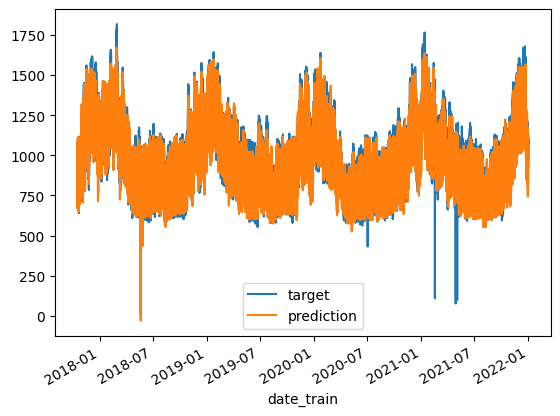

<Figure size 640x480 with 0 Axes>

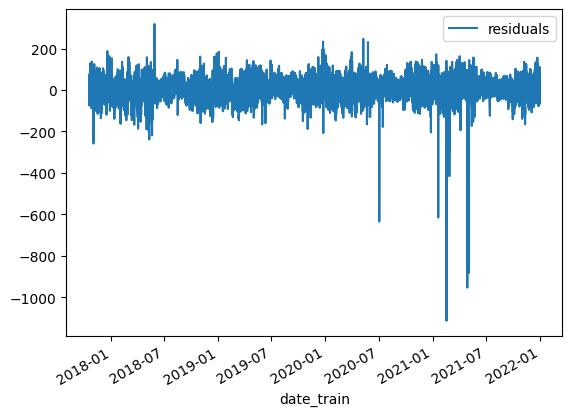

<Figure size 640x480 with 0 Axes>

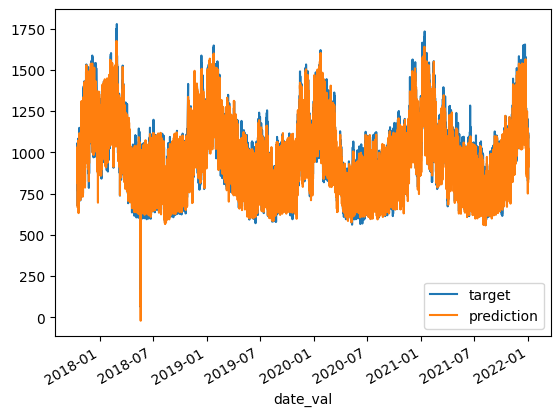

<Figure size 640x480 with 0 Axes>

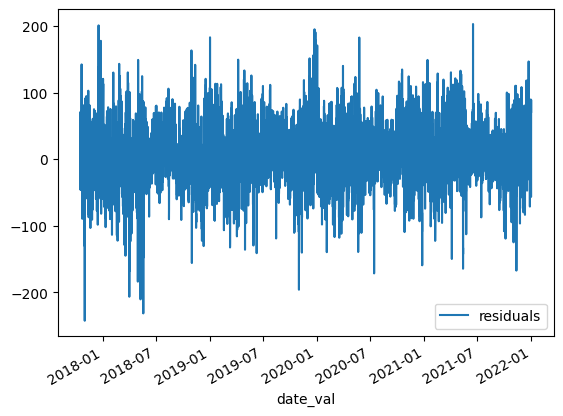

Epoch 1: 100%|██████████| 1818/1818 [00:02<00:00, 723.33it/s]


Epoch [1/200], Train Loss: 0.0047, Val Loss: 408.0006


Epoch 2: 100%|██████████| 1818/1818 [00:02<00:00, 792.61it/s]


Epoch [2/200], Train Loss: 0.0020, Val Loss: 330.7751


Epoch 3: 100%|██████████| 1818/1818 [00:02<00:00, 775.15it/s]


Epoch [3/200], Train Loss: 0.0015, Val Loss: 295.4736


Epoch 4: 100%|██████████| 1818/1818 [00:02<00:00, 782.99it/s]


Epoch [4/200], Train Loss: 0.0014, Val Loss: 287.6368


Epoch 5: 100%|██████████| 1818/1818 [00:02<00:00, 626.39it/s]


Epoch [5/200], Train Loss: 0.0013, Val Loss: 281.4791


Epoch 6: 100%|██████████| 1818/1818 [00:02<00:00, 788.00it/s]


Epoch [6/200], Train Loss: 0.0012, Val Loss: 274.8109


Epoch 7: 100%|██████████| 1818/1818 [00:02<00:00, 778.41it/s]


Epoch [7/200], Train Loss: 0.0012, Val Loss: 297.4737


Epoch 8: 100%|██████████| 1818/1818 [00:02<00:00, 791.10it/s]


Epoch [8/200], Train Loss: 0.0012, Val Loss: 281.8641


Epoch 9: 100%|██████████| 1818/1818 [00:02<00:00, 657.43it/s]


Epoch [9/200], Train Loss: 0.0011, Val Loss: 275.8336


Epoch 10: 100%|██████████| 1818/1818 [00:02<00:00, 741.30it/s]


Epoch [10/200], Train Loss: 0.0011, Val Loss: 268.8957


Epoch 11: 100%|██████████| 1818/1818 [00:02<00:00, 790.30it/s]


Epoch [11/200], Train Loss: 0.0011, Val Loss: 265.1568


Epoch 12: 100%|██████████| 1818/1818 [00:02<00:00, 791.19it/s]


Epoch [12/200], Train Loss: 0.0011, Val Loss: 268.7578


Epoch 13: 100%|██████████| 1818/1818 [00:02<00:00, 783.42it/s]


Epoch [13/200], Train Loss: 0.0011, Val Loss: 263.6864


Epoch 14: 100%|██████████| 1818/1818 [00:02<00:00, 635.64it/s]


Epoch [14/200], Train Loss: 0.0011, Val Loss: 272.4892


Epoch 15: 100%|██████████| 1818/1818 [00:02<00:00, 791.26it/s]


Epoch [15/200], Train Loss: 0.0011, Val Loss: 266.5461


Epoch 16: 100%|██████████| 1818/1818 [00:02<00:00, 779.94it/s]


Epoch [16/200], Train Loss: 0.0010, Val Loss: 254.3890


Epoch 17: 100%|██████████| 1818/1818 [00:02<00:00, 788.24it/s]


Epoch [17/200], Train Loss: 0.0010, Val Loss: 259.7975


Epoch 18: 100%|██████████| 1818/1818 [00:02<00:00, 654.61it/s]


Epoch [18/200], Train Loss: 0.0010, Val Loss: 258.7954


Epoch 19: 100%|██████████| 1818/1818 [00:02<00:00, 732.62it/s]


Epoch [19/200], Train Loss: 0.0010, Val Loss: 250.7823


Epoch 20: 100%|██████████| 1818/1818 [00:02<00:00, 781.69it/s]


Epoch [20/200], Train Loss: 0.0010, Val Loss: 250.3518


Epoch 21: 100%|██████████| 1818/1818 [00:02<00:00, 794.62it/s]


Epoch [21/200], Train Loss: 0.0010, Val Loss: 257.3488


Epoch 22: 100%|██████████| 1818/1818 [00:02<00:00, 757.58it/s]


Epoch [22/200], Train Loss: 0.0010, Val Loss: 245.0934


Epoch 23: 100%|██████████| 1818/1818 [00:02<00:00, 618.35it/s]


Epoch [23/200], Train Loss: 0.0010, Val Loss: 249.5660


Epoch 24: 100%|██████████| 1818/1818 [00:02<00:00, 783.89it/s]


Epoch [24/200], Train Loss: 0.0010, Val Loss: 259.8239


Epoch 25: 100%|██████████| 1818/1818 [00:02<00:00, 776.19it/s]


Epoch [25/200], Train Loss: 0.0009, Val Loss: 267.4609


Epoch 26: 100%|██████████| 1818/1818 [00:02<00:00, 775.16it/s]


Epoch [26/200], Train Loss: 0.0009, Val Loss: 251.4018


Epoch 27: 100%|██████████| 1818/1818 [00:03<00:00, 582.49it/s]


Epoch [27/200], Train Loss: 0.0009, Val Loss: 250.1395


Epoch 28: 100%|██████████| 1818/1818 [00:02<00:00, 788.53it/s]


Epoch [28/200], Train Loss: 0.0009, Val Loss: 244.2419


Epoch 29: 100%|██████████| 1818/1818 [00:02<00:00, 761.60it/s]


Epoch [29/200], Train Loss: 0.0009, Val Loss: 239.6088


Epoch 30: 100%|██████████| 1818/1818 [00:02<00:00, 773.57it/s]


Epoch [30/200], Train Loss: 0.0009, Val Loss: 242.2836


Epoch 31: 100%|██████████| 1818/1818 [00:02<00:00, 718.88it/s]


Epoch [31/200], Train Loss: 0.0009, Val Loss: 242.1400


Epoch 32: 100%|██████████| 1818/1818 [00:02<00:00, 657.05it/s]


Epoch [32/200], Train Loss: 0.0009, Val Loss: 237.1876


Epoch 33: 100%|██████████| 1818/1818 [00:02<00:00, 778.24it/s]


Epoch [33/200], Train Loss: 0.0009, Val Loss: 237.7124


Epoch 34: 100%|██████████| 1818/1818 [00:02<00:00, 777.78it/s]


Epoch [34/200], Train Loss: 0.0009, Val Loss: 239.7196


Epoch 35: 100%|██████████| 1818/1818 [00:02<00:00, 791.46it/s]


Epoch [35/200], Train Loss: 0.0009, Val Loss: 236.5721


Epoch 36: 100%|██████████| 1818/1818 [00:03<00:00, 586.45it/s]


Epoch [36/200], Train Loss: 0.0009, Val Loss: 245.4490


Epoch 37: 100%|██████████| 1818/1818 [00:02<00:00, 786.19it/s]


Epoch [37/200], Train Loss: 0.0009, Val Loss: 235.2942


Epoch 38: 100%|██████████| 1818/1818 [00:02<00:00, 801.58it/s]


Epoch [38/200], Train Loss: 0.0009, Val Loss: 236.3087


Epoch 39: 100%|██████████| 1818/1818 [00:02<00:00, 779.34it/s]


Epoch [39/200], Train Loss: 0.0009, Val Loss: 231.3159


Epoch 40: 100%|██████████| 1818/1818 [00:02<00:00, 700.01it/s]


Epoch [40/200], Train Loss: 0.0009, Val Loss: 234.8897


Epoch 41: 100%|██████████| 1818/1818 [00:02<00:00, 662.27it/s]


Epoch [41/200], Train Loss: 0.0008, Val Loss: 241.7455


Epoch 42: 100%|██████████| 1818/1818 [00:02<00:00, 790.24it/s]


Epoch [42/200], Train Loss: 0.0008, Val Loss: 231.7814


Epoch 43: 100%|██████████| 1818/1818 [00:02<00:00, 794.71it/s]


Epoch [43/200], Train Loss: 0.0008, Val Loss: 236.0870


Epoch 44: 100%|██████████| 1818/1818 [00:02<00:00, 776.44it/s]


Epoch [44/200], Train Loss: 0.0008, Val Loss: 234.5374


Epoch 45: 100%|██████████| 1818/1818 [00:03<00:00, 581.56it/s]


Epoch [45/200], Train Loss: 0.0008, Val Loss: 231.4899


Epoch 46: 100%|██████████| 1818/1818 [00:02<00:00, 781.13it/s]


Epoch [46/200], Train Loss: 0.0008, Val Loss: 233.8395


Epoch 47: 100%|██████████| 1818/1818 [00:02<00:00, 785.48it/s]


Epoch [47/200], Train Loss: 0.0008, Val Loss: 228.6456


Epoch 48: 100%|██████████| 1818/1818 [00:02<00:00, 786.80it/s]


Epoch [48/200], Train Loss: 0.0008, Val Loss: 226.3548


Epoch 49: 100%|██████████| 1818/1818 [00:02<00:00, 658.28it/s]


Epoch [49/200], Train Loss: 0.0008, Val Loss: 227.0754


Epoch 50: 100%|██████████| 1818/1818 [00:02<00:00, 724.08it/s]


Epoch [50/200], Train Loss: 0.0008, Val Loss: 226.0634


Epoch 51: 100%|██████████| 1818/1818 [00:02<00:00, 771.52it/s]


Epoch [51/200], Train Loss: 0.0008, Val Loss: 225.5370


Epoch 52: 100%|██████████| 1818/1818 [00:02<00:00, 776.30it/s]


Epoch [52/200], Train Loss: 0.0008, Val Loss: 226.0131


Epoch 53: 100%|██████████| 1818/1818 [00:02<00:00, 786.79it/s]


Epoch [53/200], Train Loss: 0.0008, Val Loss: 226.0750


Epoch 54: 100%|██████████| 1818/1818 [00:02<00:00, 622.89it/s]


Epoch [54/200], Train Loss: 0.0008, Val Loss: 224.9284


Epoch 55: 100%|██████████| 1818/1818 [00:02<00:00, 782.90it/s]


Epoch [55/200], Train Loss: 0.0008, Val Loss: 222.9716


Epoch 56: 100%|██████████| 1818/1818 [00:02<00:00, 782.90it/s]


Epoch [56/200], Train Loss: 0.0008, Val Loss: 225.9799


Epoch 57: 100%|██████████| 1818/1818 [00:02<00:00, 783.20it/s]


Epoch [57/200], Train Loss: 0.0008, Val Loss: 222.8765


Epoch 58: 100%|██████████| 1818/1818 [00:02<00:00, 667.03it/s]


Epoch [58/200], Train Loss: 0.0008, Val Loss: 233.9376


Epoch 59: 100%|██████████| 1818/1818 [00:02<00:00, 718.44it/s]


Epoch [59/200], Train Loss: 0.0008, Val Loss: 225.0633


Epoch 60: 100%|██████████| 1818/1818 [00:02<00:00, 784.34it/s]


Epoch [60/200], Train Loss: 0.0007, Val Loss: 223.8258


Epoch 61: 100%|██████████| 1818/1818 [00:02<00:00, 781.19it/s]


Epoch [61/200], Train Loss: 0.0007, Val Loss: 233.2216


Epoch 62: 100%|██████████| 1818/1818 [00:02<00:00, 779.36it/s]


Epoch [62/200], Train Loss: 0.0007, Val Loss: 222.2987


Epoch 63: 100%|██████████| 1818/1818 [00:02<00:00, 612.40it/s]


Epoch [63/200], Train Loss: 0.0007, Val Loss: 215.1648


Epoch 64: 100%|██████████| 1818/1818 [00:02<00:00, 782.86it/s]


Epoch [64/200], Train Loss: 0.0007, Val Loss: 221.2187


Epoch 65: 100%|██████████| 1818/1818 [00:02<00:00, 780.61it/s]


Epoch [65/200], Train Loss: 0.0007, Val Loss: 216.1468


Epoch 66: 100%|██████████| 1818/1818 [00:02<00:00, 771.63it/s]


Epoch [66/200], Train Loss: 0.0007, Val Loss: 213.4736


Epoch 67: 100%|██████████| 1818/1818 [00:02<00:00, 620.07it/s]


Epoch [67/200], Train Loss: 0.0007, Val Loss: 215.0168


Epoch 68: 100%|██████████| 1818/1818 [00:02<00:00, 780.59it/s]


Epoch [68/200], Train Loss: 0.0007, Val Loss: 223.0614


Epoch 69: 100%|██████████| 1818/1818 [00:02<00:00, 788.25it/s]


Epoch [69/200], Train Loss: 0.0007, Val Loss: 219.7591


Epoch 70: 100%|██████████| 1818/1818 [00:02<00:00, 778.49it/s]


Epoch [70/200], Train Loss: 0.0007, Val Loss: 213.1627


Epoch 71: 100%|██████████| 1818/1818 [00:02<00:00, 720.75it/s]


Epoch [71/200], Train Loss: 0.0007, Val Loss: 214.2822


Epoch 72: 100%|██████████| 1818/1818 [00:02<00:00, 628.96it/s]


Epoch [72/200], Train Loss: 0.0007, Val Loss: 212.5151


Epoch 73: 100%|██████████| 1818/1818 [00:02<00:00, 785.52it/s]


Epoch [73/200], Train Loss: 0.0007, Val Loss: 212.6105


Epoch 74: 100%|██████████| 1818/1818 [00:02<00:00, 796.69it/s]


Epoch [74/200], Train Loss: 0.0007, Val Loss: 213.5882


Epoch 75: 100%|██████████| 1818/1818 [00:02<00:00, 791.58it/s]


Epoch [75/200], Train Loss: 0.0007, Val Loss: 234.2715


Epoch 76: 100%|██████████| 1818/1818 [00:02<00:00, 608.71it/s]


Epoch [76/200], Train Loss: 0.0007, Val Loss: 216.2579


Epoch 77: 100%|██████████| 1818/1818 [00:02<00:00, 769.59it/s]


Epoch [77/200], Train Loss: 0.0007, Val Loss: 215.3158


Epoch 78: 100%|██████████| 1818/1818 [00:02<00:00, 771.47it/s]


Epoch [78/200], Train Loss: 0.0007, Val Loss: 223.1687


Epoch 79: 100%|██████████| 1818/1818 [00:02<00:00, 787.34it/s]


Epoch [79/200], Train Loss: 0.0007, Val Loss: 209.0769


Epoch 80: 100%|██████████| 1818/1818 [00:02<00:00, 710.88it/s]


Epoch [80/200], Train Loss: 0.0007, Val Loss: 211.1225


Epoch 81: 100%|██████████| 1818/1818 [00:02<00:00, 655.12it/s]


Epoch [81/200], Train Loss: 0.0007, Val Loss: 210.5247


Epoch 82: 100%|██████████| 1818/1818 [00:02<00:00, 776.91it/s]


Epoch [82/200], Train Loss: 0.0007, Val Loss: 215.4423


Epoch 83: 100%|██████████| 1818/1818 [00:02<00:00, 779.77it/s]


Epoch [83/200], Train Loss: 0.0007, Val Loss: 213.8022


Epoch 84: 100%|██████████| 1818/1818 [00:02<00:00, 782.27it/s]


Epoch [84/200], Train Loss: 0.0007, Val Loss: 218.6549


Epoch 85: 100%|██████████| 1818/1818 [00:03<00:00, 583.82it/s]


Epoch [85/200], Train Loss: 0.0007, Val Loss: 211.7590


Epoch 86: 100%|██████████| 1818/1818 [00:02<00:00, 793.81it/s]


Epoch [86/200], Train Loss: 0.0007, Val Loss: 212.7125


Epoch 87: 100%|██████████| 1818/1818 [00:02<00:00, 796.91it/s]


Epoch [87/200], Train Loss: 0.0007, Val Loss: 208.3105


Epoch 88: 100%|██████████| 1818/1818 [00:02<00:00, 791.58it/s]


Epoch [88/200], Train Loss: 0.0007, Val Loss: 213.7030


Epoch 89: 100%|██████████| 1818/1818 [00:02<00:00, 699.94it/s]


Epoch [89/200], Train Loss: 0.0007, Val Loss: 205.7605


Epoch 90: 100%|██████████| 1818/1818 [00:02<00:00, 658.10it/s]


Epoch [90/200], Train Loss: 0.0007, Val Loss: 212.4721


Epoch 91: 100%|██████████| 1818/1818 [00:02<00:00, 776.97it/s]


Epoch [91/200], Train Loss: 0.0007, Val Loss: 207.2833


Epoch 92: 100%|██████████| 1818/1818 [00:02<00:00, 774.03it/s]


Epoch [92/200], Train Loss: 0.0007, Val Loss: 210.2106


Epoch 93: 100%|██████████| 1818/1818 [00:02<00:00, 774.44it/s]


Epoch [93/200], Train Loss: 0.0007, Val Loss: 205.2729


Epoch 94: 100%|██████████| 1818/1818 [00:03<00:00, 578.61it/s]


Epoch [94/200], Train Loss: 0.0007, Val Loss: 211.6527


Epoch 95: 100%|██████████| 1818/1818 [00:02<00:00, 781.76it/s]


Epoch [95/200], Train Loss: 0.0007, Val Loss: 205.2658


Epoch 96: 100%|██████████| 1818/1818 [00:02<00:00, 781.81it/s]


Epoch [96/200], Train Loss: 0.0007, Val Loss: 229.9659


Epoch 97: 100%|██████████| 1818/1818 [00:02<00:00, 784.22it/s]


Epoch [97/200], Train Loss: 0.0007, Val Loss: 204.5635


Epoch 98: 100%|██████████| 1818/1818 [00:02<00:00, 660.30it/s]


Epoch [98/200], Train Loss: 0.0007, Val Loss: 203.3565


Epoch 99: 100%|██████████| 1818/1818 [00:02<00:00, 695.36it/s]


Epoch [99/200], Train Loss: 0.0007, Val Loss: 205.0749


Epoch 100: 100%|██████████| 1818/1818 [00:02<00:00, 784.01it/s]


Epoch [100/200], Train Loss: 0.0007, Val Loss: 204.0656


Epoch 101: 100%|██████████| 1818/1818 [00:02<00:00, 781.68it/s]


Epoch [101/200], Train Loss: 0.0007, Val Loss: 218.5776


Epoch 102: 100%|██████████| 1818/1818 [00:02<00:00, 775.76it/s]


Epoch [102/200], Train Loss: 0.0007, Val Loss: 216.4617


Epoch 103: 100%|██████████| 1818/1818 [00:03<00:00, 588.62it/s]


Epoch [103/200], Train Loss: 0.0007, Val Loss: 203.7395


Epoch 104: 100%|██████████| 1818/1818 [00:02<00:00, 770.65it/s]


Epoch [104/200], Train Loss: 0.0007, Val Loss: 207.3530


Epoch 105: 100%|██████████| 1818/1818 [00:02<00:00, 755.01it/s]


Epoch [105/200], Train Loss: 0.0007, Val Loss: 204.1878


Epoch 106: 100%|██████████| 1818/1818 [00:02<00:00, 786.59it/s]


Epoch [106/200], Train Loss: 0.0007, Val Loss: 214.7707


Epoch 107: 100%|██████████| 1818/1818 [00:02<00:00, 621.01it/s]


Epoch [107/200], Train Loss: 0.0007, Val Loss: 211.1183


Epoch 108: 100%|██████████| 1818/1818 [00:02<00:00, 773.99it/s]


Early stopping triggered



######Métropole du Grand Paris######




<Figure size 640x480 with 0 Axes>

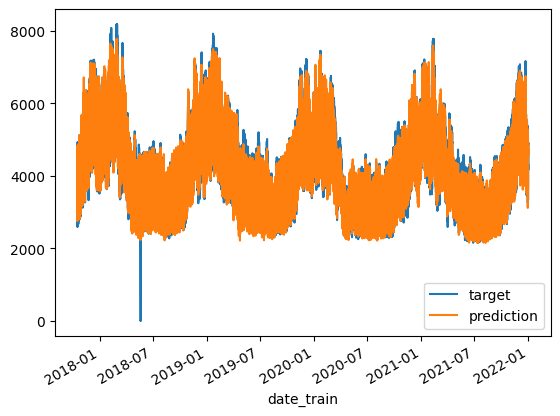

<Figure size 640x480 with 0 Axes>

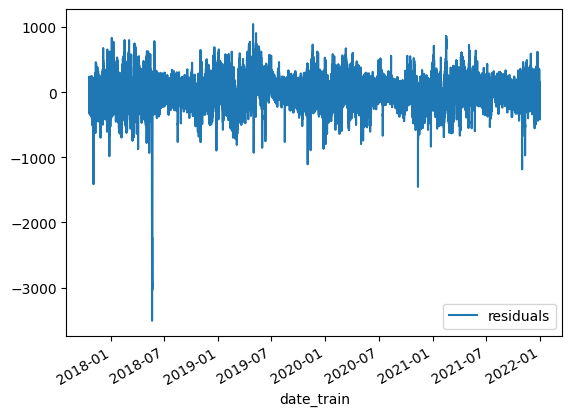

<Figure size 640x480 with 0 Axes>

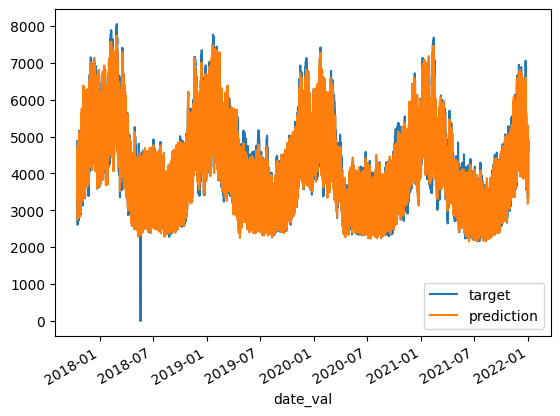

<Figure size 640x480 with 0 Axes>

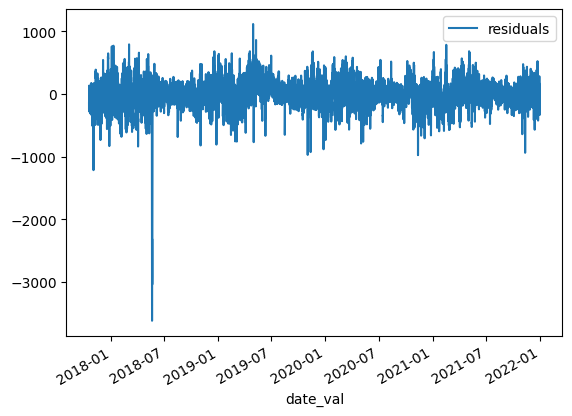

In [ ]:
for region in regions:
  model, scaler_X, scaler_y, val_loss = joblib.load(Projet / ("Models/gMLP_"+region+".pkl"))
  if val_loss > 600:
    model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val = train_model_local(region, weather_features)
    print("\n\n\n###### "+region+" ######\n\n")
    plot_model_pred_local(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

for metropole in metropoles:
  model, scaler_X, scaler_y, val_loss = joblib.load(Projet / ("Models/gMLP_"+metropole+".pkl"))
  if val_loss > 200:
    model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val = train_model_local(metropole, weather_features)
    print("\n\n\n###### "+metropole+" ######\n\n")
    plot_model_pred_local(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

## 2 - Training all of France

#### We keep the means of weather features for each region

In [ ]:
weather_features = ['t', 'pmer', 'tend', 'u', 'ff', 'pres']

In [ ]:
weather = pd.read_parquet(Projet / "Data/meteo.parquet")
weather['nbas'] = weather['nbas'].astype(np.float64, errors='ignore')
weather['geop'] = weather['geop'].astype(np.float64, errors='ignore')

weather.drop(['mois_de_l_annee', 'coordonnees', 'nom', 'cod_tend', 'ww', 'etat_sol', 'type_de_tendance_barometrique', 'temps_present', 'libgeo', 'codegeo', 'nom_epci', 'code_epci', 'nom_dept', 'code_dep', 'nom_reg', 'code_reg'], axis = 1, inplace = True)

weather = weather[['date', 'numer_sta'] + weather_features]

weather = drop_NaN_columns(weather, 0.3)

weather = time_zone_convertion(weather)

features_to_flatten = list(weather.columns).copy()
features_to_flatten.remove('date')
features_to_flatten.remove('numer_sta')
weather = flatten_features(weather, features_to_flatten)

weather = interpolate_df(weather)

columns = list(weather.columns).copy()
for col in columns:
  if weather[col].isna().sum() > 5:
    weather.drop(col, axis = 1, inplace = True)

weather.dropna(how = 'any', axis = 0, inplace=True)
weather.shape, weather.columns

((91288, 239),
 Index(['date', 't_07020', 'pmer_07020', 'tend_07020', 'u_07020', 'ff_07020',
        'pres_07020', 't_07558', 'pmer_07558', 'tend_07558',
        ...
        'tend_07434', 'u_07434', 'ff_07434', 'pres_07434', 't_07630',
        'pmer_07630', 'tend_07630', 'u_07630', 'ff_07630', 'pres_07630'],
       dtype='object', length=239))

In [ ]:
df = weather.copy()

In [ ]:
weather_means = dict()
for region in regions:
  print(region)
  for feature in weather_features:
    l = [feature+'_'+station for station in dict_locations[region]]
    l = [col for col in l if col in list(weather.columns)]
    if l != []:
      weather_means[region+ '_' + feature] = weather[l].mean(axis = 1)
      print("     ", feature, "<--- done")
    else:
      print("     ", feature, "<--- fail")

Auvergne-Rhône-Alpes
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bourgogne-Franche-Comté
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bretagne
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Centre-Val de Loire
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Grand Est
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Hauts-de-France
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Normandie
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Nouvelle-Aquitaine
      t <--- done
      pmer <--- done
      

In [ ]:
weather_means = pd.DataFrame(weather_means)

In [ ]:
weather_means.insert(0, 'date', df['date'])
weather_means.head(20)

,date,Auvergne-Rhône-Alpes_t,Auvergne-Rhône-Alpes_pmer,Auvergne-Rhône-Alpes_tend,Auvergne-Rhône-Alpes_u,Auvergne-Rhône-Alpes_ff,Auvergne-Rhône-Alpes_pres,Bourgogne-Franche-Comté_t,Bourgogne-Franche-Comté_pmer,Bourgogne-Franche-Comté_tend,Bourgogne-Franche-Comté_u,Bourgogne-Franche-Comté_ff,Bourgogne-Franche-Comté_pres,Bretagne_t,Bretagne_pmer,Bretagne_tend,Bretagne_u,Bretagne_ff,Bretagne_pres,Centre-Val de Loire_t,Centre-Val de Loire_pmer,Centre-Val de Loire_tend,Centre-Val de Loire_u,Centre-Val de Loire_ff,Centre-Val de Loire_pres,Grand Est_t,Grand Est_pmer,Grand Est_tend,Grand Est_u,Grand Est_ff,Grand Est_pres,Hauts-de-France_t,Hauts-de-France_pmer,Hauts-de-France_tend,Hauts-de-France_u,Hauts-de-France_ff,Hauts-de-France_pres,Normandie_t,Normandie_pmer,Normandie_tend,Normandie_u,Normandie_ff,Normandie_pres,Nouvelle-Aquitaine_t,Nouvelle-Aquitaine_pmer,Nouvelle-Aquitaine_tend,Nouvelle-Aquitaine_u,Nouvelle-Aquitaine_ff,Nouvelle-Aquitaine_pres,Occitanie_t,Occitanie_pmer,Occitanie_tend,Occitanie_u,Occitanie_ff,Occitanie_pres,Pays de la Loire_t,Pays de la Loire_pmer,Pays de la Loire_tend,Pays de la Loire_u,Pays de la Loire_ff,Pays de la Loire_pres,Provence-Alpes-Côte d'Azur_t,Provence-Alpes-Côte d'Azur_pmer,Provence-Alpes-Côte d'Azur_tend,Provence-Alpes-Côte d'Azur_u,Provence-Alpes-Côte d'Azur_ff,Provence-Alpes-Côte d'Azur_pres,Île-de-France_t,Île-de-France_pmer,Île-de-France_tend,Île-de-France_u,Île-de-France_ff,Île-de-France_pres
5,2017-10-17 04:00:00+01:00,282.575000,102520.000000,-67.500000,78.750000,0.850000,98197.500000,280.250000,102510.000000,-60.000000,95.000000,0.800000,99730.000000,285.175000,102150.000000,-125.000000,89.500000,1.950000,101435.000000,284.250000,102290.000000,-80.000000,93.000000,0.750000,100605.000000,283.170000,102398.000000,-26.000000,88.800000,1.840000,100034.000000,286.250000,102195.000000,0.000000,90.500000,1.650000,101475.000000,284.900000,102210.000000,-72.500000,86.250000,2.675000,101080.000000,287.510000,102126.000000,-160.000000,91.400000,3.040000,100578.000000,286.550000,102311.428571,-165.714286,88.714286,2.928571,99017.142857,286.050000,102100.000000,-160.000000,96.000000,1.200000,101790.000000,286.075000,102573.333333,-100.000000,73.000000,3.200000,99550.000000,286.050000,102270.000000,-10.000000,92.000000,0.700000,101180.000000
6,2017-10-17 04:30:00+01:00,282.429167,102512.777778,-66.666667,79.375000,1.220833,98187.083333,280.116667,102508.333333,-53.333333,95.000000,0.783333,99726.666667,285.291667,102135.416667,-118.750000,89.041667,2.141667,101420.416667,284.058333,102273.333333,-84.166667,93.000000,0.966667,100587.500000,283.010000,102398.000000,-24.000000,89.433333,1.773333,100031.666667,285.983333,102198.333333,3.333333,91.250000,1.650000,101478.333333,284.816667,102207.083333,-63.333333,86.791667,2.570833,101077.083333,287.310000,102110.333333,-150.000000,91.466667,2.880000,100561.333333,286.450000,102297.380952,-152.619048,88.761905,2.940476,99002.619048,286.050000,102088.333333,-145.000000,95.166667,1.483333,101778.333333,285.987500,102570.555556,-86.666667,72.916667,3.116667,99546.666667,285.933333,102263.333333,-15.000000,92.000000,0.850000,101173.333333
7,2017-10-17 05:00:00+01:00,282.283333,102505.555556,-65.833333,80.000000,1.591667,98176.666667,279.983333,102506.666667,-46.666667,95.000000,0.766667,99723.333333,285.408333,102120.833333,-112.500000,88.583333,2.333333,101405.833333,283.866667,102256.666667,-88.333333,93.000000,1.183333,100570.000000,282.850000,102398.000000,-22.000000,90.066667,1.706667,100029.333333,285.716667,102201.666667,6.666667,92.000000,1.650000,101481.666667,284.733333,102204.166667,-54.166667,87.333333,2.466667,101074.166667,287.110000,102094.666667,-140.000000,91.533333,2.720000,100544.666667,286.350000,102283.333333,-139.523810,88.809524,2.952381,98988.095238,286.050000,102076.666667,-130.000000,94.333333,1.766667,101766.666667,285.900000,102567.777778,-73.333333,72.833333,3.033333,99543.333333,285.816667,102256.666667,-20.000000,92.000000,1.000000

In [ ]:
weather_means.columns

Index(['date', 'Auvergne-Rhône-Alpes_t', 'Auvergne-Rhône-Alpes_pmer',
       'Auvergne-Rhône-Alpes_tend', 'Auvergne-Rhône-Alpes_u',
       'Auvergne-Rhône-Alpes_ff', 'Auvergne-Rhône-Alpes_pres',
       'Bourgogne-Franche-Comté_t', 'Bourgogne-Franche-Comté_pmer',
       'Bourgogne-Franche-Comté_tend', 'Bourgogne-Franche-Comté_u',
       'Bourgogne-Franche-Comté_ff', 'Bourgogne-Franche-Comté_pres',
       'Bretagne_t', 'Bretagne_pmer', 'Bretagne_tend', 'Bretagne_u',
       'Bretagne_ff', 'Bretagne_pres', 'Centre-Val de Loire_t',
       'Centre-Val de Loire_pmer', 'Centre-Val de Loire_tend',
       'Centre-Val de Loire_u', 'Centre-Val de Loire_ff',
       'Centre-Val de Loire_pres', 'Grand Est_t', 'Grand Est_pmer',
       'Grand Est_tend', 'Grand Est_u', 'Grand Est_ff', 'Grand Est_pres',
       'Hauts-de-France_t', 'Hauts-de-France_pmer', 'Hauts-de-France_tend',
       'Hauts-de-France_u', 'Hauts-de-France_ff', 'Hauts-de-France_pres',
       'Normandie_t', 'Normandie_pmer', 'Normandie_ten

In [ ]:
weather_means.shape

(91288, 73)

In [ ]:
train_fr = train.merge(weather_means, on = ['date'], how = 'inner')
test_fr = test.merge(weather_means, on = ['date'], how = 'inner')

train_fr.drop(regions+metropoles, axis = 1, inplace = True)

train_fr = add_time_features(train_fr)
test_fr = add_time_features(test_fr)

train_fr = add_fourier_features_classique(train_fr)
test_fr = add_fourier_features_classique(test_fr)

joblib.dump(train_fr, Projet / "Data/train_fr.pkl")
joblib.dump(test_fr, Projet / "Data/test_fr.pkl")

['/content/drive/MyDrive/Colab Notebooks/DL challenge/Data/test_fr.pkl']

In [ ]:
len(train_fr.columns)

124

### Now, the training of the France_model begin

In [ ]:
def train_model_france(batch_size = 64,
                       epochs = 200,
                       lr = 1e-3,
                       dropout = [],
                       patience = 15,
                       hidden_shapes = None,
                       batchnorm = False):

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  train_fr = joblib.load(Projet / "Data/train_fr.pkl")

  #X = train_1_region.drop(['date', region], axis=1)
  X = train_fr.copy()
  y = X['France']

  time_split = 0.8
  time_split = int(len(X)*time_split/2)
  X_train = pd.concat([X.iloc[:time_split], X.iloc[-time_split:]])
  X_val = X.iloc[time_split:-time_split]
  y_train = pd.concat([y.iloc[:time_split], y.iloc[-time_split:]])
  y_val = y.iloc[time_split:-time_split]

  date_train = X_train['date']
  date_val = X_val['date']
  X_train = X_train.drop(['date', 'France'], axis=1)
  X_val = X_val.drop(['date', 'France'], axis=1)

  #Applying a MinMax on both features and targets
  scaler_X = preprocessing.MinMaxScaler()
  X_train = scaler_X.fit_transform(X_train)
  X_val = scaler_X.transform(X_val)

  scaler_y = preprocessing.MinMaxScaler()
  y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1))
  y_val = scaler_y.transform(y_val.values.reshape(-1,1))

  #Creating Datasets and Dataloaders
  train_dataset = ConsumptionDataset(X_train, y_train)
  val_dataset = ConsumptionDataset(X_val, y_val)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = True)

  # Instenciate the model:
  input_shape = train_dataset[0][0].shape[0]
  n_hidden_layers = int(np.log2(input_shape/8).round()+1)
  if hidden_shapes == None:
    hidden_shapes = [round(input_shape/(2**(n+1))) for n in range(n_hidden_layers)]
  #hidden_shapes = [128,64,32,16,8]
  output_shape = 1

  model = gMLP(input_shape, hidden_shapes, output_shape , dropout = dropout, batchnorm = batchnorm)
  model = model.to(device)

  model._initialize_weights()

  # define the optimizer and the criterion
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # training loop :
  # Training Loop
  best_val_loss = np.inf
  best_weights = None
  patience_counter = 0
  for epoch in range(epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0  # Initialize the running loss
      val_loss = 0.0
      tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
      for inputs, targets in tqdm_bar:
          # Move data to device (GPU or CPU)
          inputs, targets = inputs.to(device), targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      model.eval()

      # Disable gradient computation during testing
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              # Forward pass
              outputs = model(inputs)

              # Calculate the loss
              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()

              outputs_tensor = torch.tensor(scaler_y.inverse_transform(outputs_np), dtype=torch.float32)
              targets_tensor = torch.tensor(scaler_y.inverse_transform(targets_np), dtype=torch.float32)

              loss = criterion(outputs_tensor, targets_tensor)

              # Accumulate the validation loss
              val_loss += loss.item()

      # Square root of average validation loss
      avg_val_loss = np.sqrt(val_loss / len(val_loader))

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
          best_weights = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
                print("Early stopping triggered")
                break

      # Average loss for the epoch
      epoch_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  model.load_state_dict(best_weights)
  joblib.dump((model, scaler_X, scaler_y, best_val_loss), Projet / "Models/gMLP_France.pkl")
  return(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

Epoch 1: 100%|██████████| 909/909 [00:07<00:00, 128.48it/s]


Epoch [1/200], Train Loss: 0.1810, Val Loss: 20389.4481


Epoch 2: 100%|██████████| 909/909 [00:05<00:00, 160.81it/s]


Epoch [2/200], Train Loss: 0.0576, Val Loss: 8664.0796


Epoch 3: 100%|██████████| 909/909 [00:06<00:00, 132.39it/s]


Epoch [3/200], Train Loss: 0.0067, Val Loss: 6020.9561


Epoch 4: 100%|██████████| 909/909 [00:05<00:00, 162.33it/s]


Epoch [4/200], Train Loss: 0.0051, Val Loss: 7048.3144


Epoch 5: 100%|██████████| 909/909 [00:06<00:00, 133.62it/s]


Epoch [5/200], Train Loss: 0.0041, Val Loss: 4994.4445


Epoch 6: 100%|██████████| 909/909 [00:05<00:00, 163.51it/s]


Epoch [6/200], Train Loss: 0.0035, Val Loss: 3776.6734


Epoch 7: 100%|██████████| 909/909 [00:06<00:00, 132.33it/s]


Epoch [7/200], Train Loss: 0.0031, Val Loss: 3820.9577


Epoch 8: 100%|██████████| 909/909 [00:05<00:00, 162.44it/s]


Epoch [8/200], Train Loss: 0.0027, Val Loss: 3516.7976


Epoch 9: 100%|██████████| 909/909 [00:06<00:00, 132.70it/s]


Epoch [9/200], Train Loss: 0.0025, Val Loss: 3610.4075


Epoch 10: 100%|██████████| 909/909 [00:05<00:00, 162.19it/s]


Epoch [10/200], Train Loss: 0.0023, Val Loss: 3425.2350


Epoch 11: 100%|██████████| 909/909 [00:06<00:00, 131.65it/s]


Epoch [11/200], Train Loss: 0.0021, Val Loss: 3471.1185


Epoch 12: 100%|██████████| 909/909 [00:05<00:00, 161.39it/s]


Epoch [12/200], Train Loss: 0.0019, Val Loss: 3461.2657


Epoch 13: 100%|██████████| 909/909 [00:06<00:00, 131.24it/s]


Epoch [13/200], Train Loss: 0.0018, Val Loss: 3278.9825


Epoch 14: 100%|██████████| 909/909 [00:05<00:00, 159.93it/s]


Epoch [14/200], Train Loss: 0.0016, Val Loss: 3703.9340


Epoch 15: 100%|██████████| 909/909 [00:06<00:00, 133.47it/s]


Epoch [15/200], Train Loss: 0.0016, Val Loss: 3665.3839


Epoch 16: 100%|██████████| 909/909 [00:05<00:00, 160.01it/s]


Epoch [16/200], Train Loss: 0.0015, Val Loss: 3447.1939


Epoch 17: 100%|██████████| 909/909 [00:06<00:00, 132.04it/s]


Epoch [17/200], Train Loss: 0.0014, Val Loss: 3521.6831


Epoch 18: 100%|██████████| 909/909 [00:05<00:00, 163.82it/s]


Epoch [18/200], Train Loss: 0.0013, Val Loss: 3438.9853


Epoch 19: 100%|██████████| 909/909 [00:06<00:00, 131.54it/s]


Epoch [19/200], Train Loss: 0.0013, Val Loss: 3266.7685


Epoch 20: 100%|██████████| 909/909 [00:05<00:00, 155.43it/s]


Epoch [20/200], Train Loss: 0.0012, Val Loss: 3600.4969


Epoch 21: 100%|██████████| 909/909 [00:06<00:00, 130.37it/s]


Epoch [21/200], Train Loss: 0.0012, Val Loss: 3909.9470


Epoch 22: 100%|██████████| 909/909 [00:05<00:00, 160.18it/s]


Epoch [22/200], Train Loss: 0.0012, Val Loss: 3545.0992


Epoch 23: 100%|██████████| 909/909 [00:06<00:00, 132.02it/s]


Epoch [23/200], Train Loss: 0.0012, Val Loss: 3779.9278


Epoch 24: 100%|██████████| 909/909 [00:05<00:00, 161.01it/s]


Epoch [24/200], Train Loss: 0.0012, Val Loss: 3376.3765


Epoch 25: 100%|██████████| 909/909 [00:06<00:00, 133.35it/s]


Epoch [25/200], Train Loss: 0.0012, Val Loss: 3220.6867


Epoch 26: 100%|██████████| 909/909 [00:05<00:00, 161.40it/s]


Epoch [26/200], Train Loss: 0.0012, Val Loss: 3346.0318


Epoch 27: 100%|██████████| 909/909 [00:06<00:00, 130.94it/s]


Epoch [27/200], Train Loss: 0.0011, Val Loss: 3444.0144


Epoch 28: 100%|██████████| 909/909 [00:05<00:00, 159.98it/s]


Epoch [28/200], Train Loss: 0.0011, Val Loss: 3734.0401


Epoch 29: 100%|██████████| 909/909 [00:06<00:00, 131.22it/s]


Epoch [29/200], Train Loss: 0.0011, Val Loss: 3478.1932


Epoch 30: 100%|██████████| 909/909 [00:05<00:00, 161.50it/s]


Epoch [30/200], Train Loss: 0.0011, Val Loss: 3431.4552


Epoch 31: 100%|██████████| 909/909 [00:06<00:00, 133.35it/s]


Epoch [31/200], Train Loss: 0.0011, Val Loss: 3624.6831


Epoch 32: 100%|██████████| 909/909 [00:05<00:00, 163.59it/s]


Epoch [32/200], Train Loss: 0.0011, Val Loss: 3658.1580


Epoch 33: 100%|██████████| 909/909 [00:06<00:00, 131.68it/s]


Epoch [33/200], Train Loss: 0.0010, Val Loss: 3465.8225


Epoch 34: 100%|██████████| 909/909 [00:05<00:00, 164.04it/s]


Epoch [34/200], Train Loss: 0.0011, Val Loss: 3373.4457


Epoch 35: 100%|██████████| 909/909 [00:06<00:00, 131.57it/s]


Epoch [35/200], Train Loss: 0.0010, Val Loss: 3589.1027


Epoch 36: 100%|██████████| 909/909 [00:05<00:00, 156.02it/s]


Epoch [36/200], Train Loss: 0.0010, Val Loss: 3454.8368


Epoch 37: 100%|██████████| 909/909 [00:06<00:00, 129.92it/s]


Epoch [37/200], Train Loss: 0.0010, Val Loss: 3559.7646


Epoch 38: 100%|██████████| 909/909 [00:05<00:00, 159.75it/s]


Epoch [38/200], Train Loss: 0.0010, Val Loss: 3393.3492


Epoch 39: 100%|██████████| 909/909 [00:06<00:00, 133.52it/s]


Epoch [39/200], Train Loss: 0.0011, Val Loss: 3397.2856


Epoch 40: 100%|██████████| 909/909 [00:05<00:00, 167.19it/s]


Early stopping triggered



###### France ######




<Figure size 640x480 with 0 Axes>

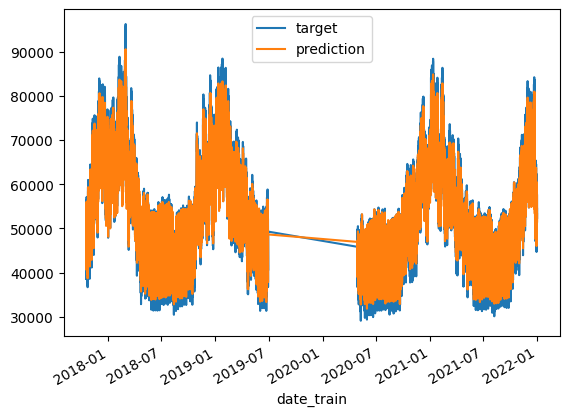

<Figure size 640x480 with 0 Axes>

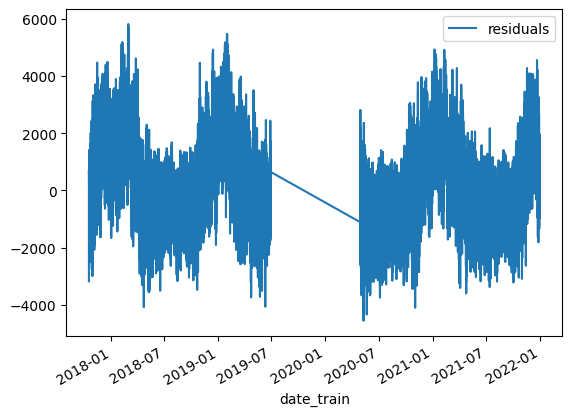

<Figure size 640x480 with 0 Axes>

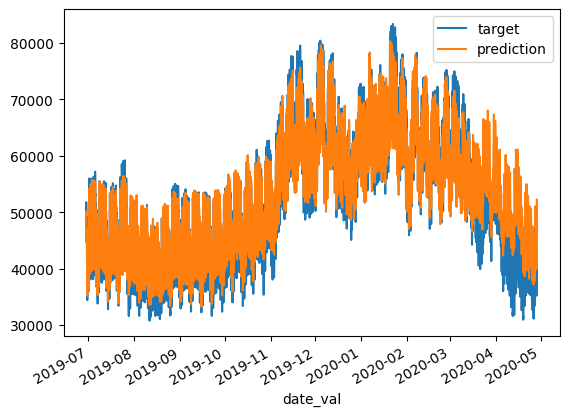

<Figure size 640x480 with 0 Axes>

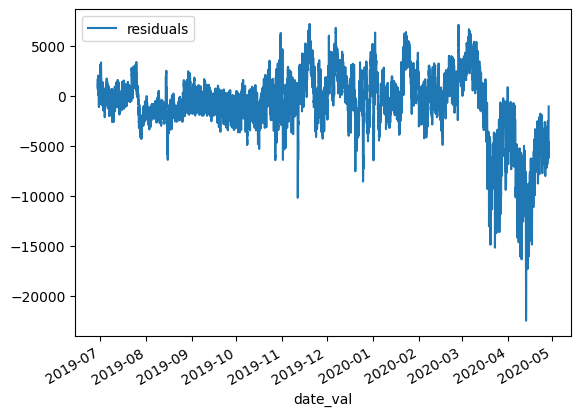

()

In [ ]:
model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val = train_model_france(batch_size = 64,
                                                                                                 epochs = 200,
                                                                                                 lr = 1e-3,
                                                                                                 dropout = [0.1,0.1,0.1],
                                                                                                 patience = 15,
                                                                                                 hidden_shapes = [120, 100, 80, 60, 40, 20, 10, 5],
                                                                                                 batchnorm = True)
print("\n\n\n###### France ######\n\n")
plot_model_pred_local(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

### Test set submission

In [ ]:
train.head()

,date,France,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,Bretagne,Centre-Val de Loire,Grand Est,Hauts-de-France,Normandie,Nouvelle-Aquitaine,Occitanie,Pays de la Loire,Provence-Alpes-Côte d'Azur,Île-de-France,Montpellier Méditerranée Métropole,Métropole Européenne de Lille,Métropole Grenoble-Alpes-Métropole,Métropole Nice Côte d'Azur,Métropole Rennes Métropole,Métropole Rouen Normandie,Métropole d'Aix-Marseille-Provence,Métropole de Lyon,Métropole du Grand Nancy,Métropole du Grand Paris,Nantes Métropole,Toulouse Métropole
0,2017-10-17 01:30:00+01:00,41440.0,6012.0,2064.0,1857.0,1578.0,4620.0,4797.0,2412.0,3729.0,3121.0,2290.0,3664.0,5296.0,179.0,779.0,411.0,257.0,203.0,340.0,1338.0,679.0,23.0,2704.0,306.0,338.0
1,2017-10-17 02:00:00+01:00,39827.0,5872.0,1960.0,1750.0,1462.0,4430.0,4663.0,2380.0,3518.0,3059.0,2171.0,3413.0,5149.0,188.0,764.0,407.0,244.0,195.0,340.0,1234.0,678.0,22.0,2634.0,290.0,322.0
2,2017-10-17 02:30:00+01:00,39083.0,5807.0,1990.0,1709.0,1436.0,4390.0,4558.0,2328.0,3358.0,3021.0,2133.0,3261.0,5093.0,200.0,741.0,399.0,240.0,199.0,336.0,1195.0,672.0,27.0,2604.0,286.0,325.0
3,2017-10-17 03:00:00+01:00,38530.0,5661.0,1923.0,1695.0,1393.0,4356.0,4539.0,2301.0,3312.0,2926.0,2104.0,3263.0,5058.0,184.0,733.0,355.0,242.0,197.0,335.0,1267.0,675.0,19.0,2587.0,280.0,311.0
4,2017-10-17 03:30:00+01:00,38314.0,5664.0,1900.0,1700.0,1419.0,4256.0,4521.0,2314.0,3296.0,2885.0,2121.0,3230.0,5007.0,179.0,737.0,375.0,238.0,196.0,335.0,1264.0,682.0,17.0,2611.0,284.0,312.0


In [ ]:
def submit_by_locations():
    submit = pd.read_csv(Projet / "Data/test.csv")
    for location in locations:
      if location != 'France':
        model, scaler_X, scaler_y, best_val_loss = joblib.load(Projet / ("Models/gMLP_"+location+".pkl"))
        if location in regions:
          region = location
        else:
          region = dict_metropoles[location]
        test_1_region = joblib.load(Projet / ("Data/test_1_"+region+".pkl"))
        test_1_region = weather_features_selection(test_1_region, weather_features)
        X = test_1_region.drop(['date'], axis=1)
        X = scaler_X.transform(X)
        X = torch.tensor(X, dtype=torch.float32).to(device)
        y = model(X)
        y = scaler_y.inverse_transform(y.detach().cpu().numpy())
        submit["pred_"+location] = y

    #submit['pred_France'] = submit[["pred_"+region for region in regions]].sum(axis=1)

    model, scaler_X, scaler_y, best_val_loss = joblib.load(Projet / "Models/gMLP_France.pkl")

    test_fr = joblib.load(Projet / ("Data/test_fr.pkl"))

    X = test_fr.drop(['date'], axis=1)
    X = scaler_X.transform(X)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = model(X)
    y = scaler_y.inverse_transform(y.detach().cpu().numpy())

    submit["pred_France"] = y

    submit = submit[['date']+["pred_"+ location for location in locations]]
    submit.to_csv(Projet / 'Submit/pred_regions.csv', index=False)
    return()

submit = submit_by_locations()

In [ ]:
submit.head()

,date,pred_France,pred_Auvergne-Rhône-Alpes,pred_Bourgogne-Franche-Comté,pred_Bretagne,pred_Centre-Val de Loire,pred_Grand Est,pred_Hauts-de-France,pred_Normandie,pred_Nouvelle-Aquitaine,pred_Occitanie,pred_Pays de la Loire,pred_Provence-Alpes-Côte d'Azur,pred_Île-de-France,pred_Montpellier Méditerranée Métropole,pred_Métropole Européenne de Lille,pred_Métropole Grenoble-Alpes-Métropole,pred_Métropole Nice Côte d'Azur,pred_Métropole Rennes Métropole,pred_Métropole Rouen Normandie,pred_Métropole d'Aix-Marseille-Provence,pred_Métropole de Lyon,pred_Métropole du Grand Nancy,pred_Métropole du Grand Paris,pred_Nantes Métropole,pred_Toulouse Métropole
0,2022-01-01 00:00:00+01:00,56224.164062,7759.395508,2578.188965,3170.582764,2330.589600,5101.493652,5337.656250,3118.110352,5510.310059,5294.055176,3493.040527,5841.914551,7950.662109,375.134827,930.394165,437.661102,455.052887,228.355499,476.514709,1779.866943,1080.615112,219.457123,3861.024170,423.661377,446.986145
1,2022-01-01 00:30:00+01:00,55448.175781,7719.503906,2588.546387,3085.441650,2324.077881,5085.712402,5238.421875,3078.066650,5629.726562,5099.611328,3521.453857,5629.036133,7753.381836,370.770203,923.594360,440.623871,448.962128,224.652069,466.797791,1752.463379,1070.174438,215.773163,3718.691162,418.472931,414.666016
2,2022-01-01 01:00:00+01:00,54390.929688,7630.846191,2577.089355,2918.915039,2285.153564,5005.694824,5081.439453,3030.895996,5634.316895,4962.101562,3533.942139,5491.002930,7498.515137,362.285156,915.354919,439.756866,434.444824,219.333145,455.557770,1727.181885,1054.780640,216.304581,3581.125732,412.213959,401.810364
3,2022-01-01 01:30:00+01:00,53699.828125,7557.915527,2590.334229,2791.624512,2256.567139,4929.914551,4937.137207,2984.549561,5697.839844,4876.516113,3530.377930,5570.616211,7249.694824,350.468597,900.633179,440.071289,420.900482,212.745041,443.346375,1685.134766,1021.331421,214.120911,3429.035156,397.491150,391.107849
4,2022-01-01 02:00:00+01:00,52884.332031,7460.123047,2597.807617,2660.079834,2201.677734,4803.582031,4796.858398,2931.336914,5631.786133,4832.458984,3413.864502,5542.499023,6968.742188,335.540192,877.949829,434.416504,406.386353,206.031067,430.749725,1648.069092,996.801453,214.955673,3323.785645,384.689880,383.000244


<Figure size 640x480 with 0 Axes>

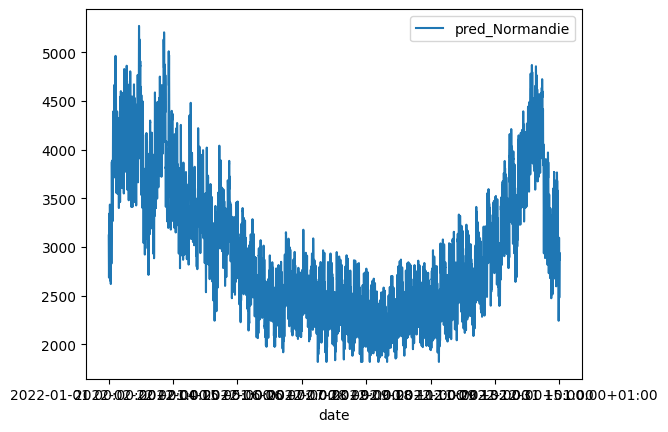

<Figure size 640x480 with 0 Axes>

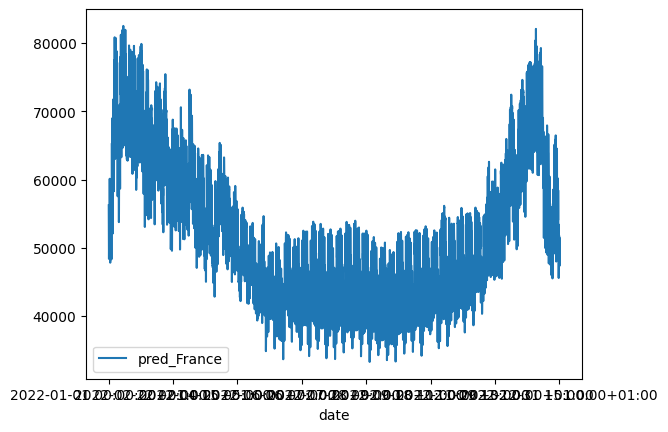

<Figure size 640x480 with 0 Axes>

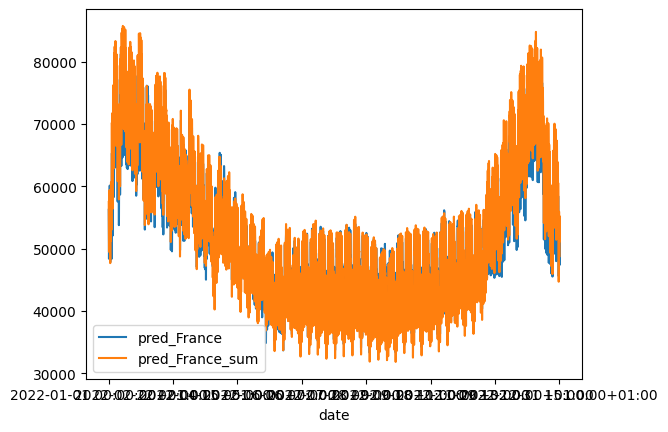

In [ ]:
plt.figure()
submit.plot(x = 'date', y = 'pred_Normandie')
plt.show()

plt.figure()
submit.plot(x = 'date', y = 'pred_France')
plt.show()

plot_france_data = submit.copy()
plot_france_data['pred_France_sum'] = submit[["pred_"+region for region in regions]].sum(axis=1)
plt.figure()
plot_france_data.plot(x = 'date', y = ['pred_France', 'pred_France_sum'])
plt.show()

In [ ]:
submit.to_csv(Projet / 'Submit/pred_regions.csv', index=False)

# Second strategy : a single MLP with multiple outputs

In [ ]:
weather_features = ['t', 'pmer', 'tend', 'u', 'ff', 'pres']

In [ ]:
weather = pd.read_parquet(Projet / "Data/meteo.parquet")
weather['nbas'] = weather['nbas'].astype(np.float64, errors='ignore')
weather['geop'] = weather['geop'].astype(np.float64, errors='ignore')

weather.drop(['mois_de_l_annee', 'coordonnees', 'nom', 'cod_tend', 'ww', 'etat_sol', 'type_de_tendance_barometrique', 'temps_present', 'libgeo', 'codegeo', 'nom_epci', 'code_epci', 'nom_dept', 'code_dep', 'nom_reg', 'code_reg'], axis = 1, inplace = True)

weather = weather[['date', 'numer_sta'] + weather_features]

weather = drop_NaN_columns(weather, 0.3)

weather = time_zone_convertion(weather)

features_to_flatten = list(weather.columns).copy()
features_to_flatten.remove('date')
features_to_flatten.remove('numer_sta')
weather = flatten_features(weather, features_to_flatten)

weather = interpolate_df(weather)

columns = list(weather.columns).copy()
for col in columns:
  if weather[col].isna().sum() > 5:
    weather.drop(col, axis = 1, inplace = True)

weather.dropna(how = 'any', axis = 0, inplace=True)
weather.shape, weather.columns

((91288, 239),
 Index(['date', 't_07020', 'pmer_07020', 'tend_07020', 'u_07020', 'ff_07020',
        'pres_07020', 't_07558', 'pmer_07558', 'tend_07558',
        ...
        'tend_07434', 'u_07434', 'ff_07434', 'pres_07434', 't_07630',
        'pmer_07630', 'tend_07630', 'u_07630', 'ff_07630', 'pres_07630'],
       dtype='object', length=239))

In [ ]:
df = weather.copy()

In [ ]:
weather_means = dict()
for region in regions:
  print(region)
  for feature in weather_features:
    l = [feature+'_'+station for station in dict_locations[region]]
    l = [col for col in l if col in list(weather.columns)]
    if l != []:
      weather_means[region+ '_' + feature] = weather[l].mean(axis = 1)
      print("     ", feature, "<--- done")
    else:
      print("     ", feature, "<--- fail")

Auvergne-Rhône-Alpes
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bourgogne-Franche-Comté
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bretagne
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Centre-Val de Loire
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Grand Est
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Hauts-de-France
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Normandie
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Nouvelle-Aquitaine
      t <--- done
      pmer <--- done
      

In [ ]:
weather_means = pd.DataFrame(weather_means)

In [ ]:
weather_means.insert(0, 'date', df['date'])
weather_means.head(20)

,date,Auvergne-Rhône-Alpes_t,Auvergne-Rhône-Alpes_pmer,Auvergne-Rhône-Alpes_tend,Auvergne-Rhône-Alpes_u,Auvergne-Rhône-Alpes_ff,Auvergne-Rhône-Alpes_pres,Bourgogne-Franche-Comté_t,Bourgogne-Franche-Comté_pmer,Bourgogne-Franche-Comté_tend,Bourgogne-Franche-Comté_u,Bourgogne-Franche-Comté_ff,Bourgogne-Franche-Comté_pres,Bretagne_t,Bretagne_pmer,Bretagne_tend,Bretagne_u,Bretagne_ff,Bretagne_pres,Centre-Val de Loire_t,Centre-Val de Loire_pmer,Centre-Val de Loire_tend,Centre-Val de Loire_u,Centre-Val de Loire_ff,Centre-Val de Loire_pres,Grand Est_t,Grand Est_pmer,Grand Est_tend,Grand Est_u,Grand Est_ff,Grand Est_pres,Hauts-de-France_t,Hauts-de-France_pmer,Hauts-de-France_tend,Hauts-de-France_u,Hauts-de-France_ff,Hauts-de-France_pres,Normandie_t,Normandie_pmer,Normandie_tend,Normandie_u,Normandie_ff,Normandie_pres,Nouvelle-Aquitaine_t,Nouvelle-Aquitaine_pmer,Nouvelle-Aquitaine_tend,Nouvelle-Aquitaine_u,Nouvelle-Aquitaine_ff,Nouvelle-Aquitaine_pres,Occitanie_t,Occitanie_pmer,Occitanie_tend,Occitanie_u,Occitanie_ff,Occitanie_pres,Pays de la Loire_t,Pays de la Loire_pmer,Pays de la Loire_tend,Pays de la Loire_u,Pays de la Loire_ff,Pays de la Loire_pres,Provence-Alpes-Côte d'Azur_t,Provence-Alpes-Côte d'Azur_pmer,Provence-Alpes-Côte d'Azur_tend,Provence-Alpes-Côte d'Azur_u,Provence-Alpes-Côte d'Azur_ff,Provence-Alpes-Côte d'Azur_pres,Île-de-France_t,Île-de-France_pmer,Île-de-France_tend,Île-de-France_u,Île-de-France_ff,Île-de-France_pres
5,2017-10-17 04:00:00+01:00,282.575000,102520.000000,-67.500000,78.750000,0.850000,98197.500000,280.250000,102510.000000,-60.000000,95.000000,0.800000,99730.000000,285.175000,102150.000000,-125.000000,89.500000,1.950000,101435.000000,284.250000,102290.000000,-80.000000,93.000000,0.750000,100605.000000,283.170000,102398.000000,-26.000000,88.800000,1.840000,100034.000000,286.250000,102195.000000,0.000000,90.500000,1.650000,101475.000000,284.900000,102210.000000,-72.500000,86.250000,2.675000,101080.000000,287.510000,102126.000000,-160.000000,91.400000,3.040000,100578.000000,286.550000,102311.428571,-165.714286,88.714286,2.928571,99017.142857,286.050000,102100.000000,-160.000000,96.000000,1.200000,101790.000000,286.075000,102573.333333,-100.000000,73.000000,3.200000,99550.000000,286.050000,102270.000000,-10.000000,92.000000,0.700000,101180.000000
6,2017-10-17 04:30:00+01:00,282.429167,102512.777778,-66.666667,79.375000,1.220833,98187.083333,280.116667,102508.333333,-53.333333,95.000000,0.783333,99726.666667,285.291667,102135.416667,-118.750000,89.041667,2.141667,101420.416667,284.058333,102273.333333,-84.166667,93.000000,0.966667,100587.500000,283.010000,102398.000000,-24.000000,89.433333,1.773333,100031.666667,285.983333,102198.333333,3.333333,91.250000,1.650000,101478.333333,284.816667,102207.083333,-63.333333,86.791667,2.570833,101077.083333,287.310000,102110.333333,-150.000000,91.466667,2.880000,100561.333333,286.450000,102297.380952,-152.619048,88.761905,2.940476,99002.619048,286.050000,102088.333333,-145.000000,95.166667,1.483333,101778.333333,285.987500,102570.555556,-86.666667,72.916667,3.116667,99546.666667,285.933333,102263.333333,-15.000000,92.000000,0.850000,101173.333333
7,2017-10-17 05:00:00+01:00,282.283333,102505.555556,-65.833333,80.000000,1.591667,98176.666667,279.983333,102506.666667,-46.666667,95.000000,0.766667,99723.333333,285.408333,102120.833333,-112.500000,88.583333,2.333333,101405.833333,283.866667,102256.666667,-88.333333,93.000000,1.183333,100570.000000,282.850000,102398.000000,-22.000000,90.066667,1.706667,100029.333333,285.716667,102201.666667,6.666667,92.000000,1.650000,101481.666667,284.733333,102204.166667,-54.166667,87.333333,2.466667,101074.166667,287.110000,102094.666667,-140.000000,91.533333,2.720000,100544.666667,286.350000,102283.333333,-139.523810,88.809524,2.952381,98988.095238,286.050000,102076.666667,-130.000000,94.333333,1.766667,101766.666667,285.900000,102567.777778,-73.333333,72.833333,3.033333,99543.333333,285.816667,102256.666667,-20.000000,92.000000,1.000000

In [ ]:
weather_means.columns

Index(['date', 'Auvergne-Rhône-Alpes_t', 'Auvergne-Rhône-Alpes_pmer',
       'Auvergne-Rhône-Alpes_tend', 'Auvergne-Rhône-Alpes_u',
       'Auvergne-Rhône-Alpes_ff', 'Auvergne-Rhône-Alpes_pres',
       'Bourgogne-Franche-Comté_t', 'Bourgogne-Franche-Comté_pmer',
       'Bourgogne-Franche-Comté_tend', 'Bourgogne-Franche-Comté_u',
       'Bourgogne-Franche-Comté_ff', 'Bourgogne-Franche-Comté_pres',
       'Bretagne_t', 'Bretagne_pmer', 'Bretagne_tend', 'Bretagne_u',
       'Bretagne_ff', 'Bretagne_pres', 'Centre-Val de Loire_t',
       'Centre-Val de Loire_pmer', 'Centre-Val de Loire_tend',
       'Centre-Val de Loire_u', 'Centre-Val de Loire_ff',
       'Centre-Val de Loire_pres', 'Grand Est_t', 'Grand Est_pmer',
       'Grand Est_tend', 'Grand Est_u', 'Grand Est_ff', 'Grand Est_pres',
       'Hauts-de-France_t', 'Hauts-de-France_pmer', 'Hauts-de-France_tend',
       'Hauts-de-France_u', 'Hauts-de-France_ff', 'Hauts-de-France_pres',
       'Normandie_t', 'Normandie_pmer', 'Normandie_ten

In [ ]:
weather_means.shape

(91288, 73)

In [ ]:
train_MLP_multi = train.merge(weather_means, on = ['date'], how = 'inner')
test_MLP_multi = test.merge(weather_means, on = ['date'], how = 'inner')

train_MLP_multi = add_time_features(train_MLP_multi)
test_MLP_multi = add_time_features(test_MLP_multi)

train_MLP_multi = add_fourier_features_classique(train_MLP_multi,15)
test_MLP_multi = add_fourier_features_classique(test_MLP_multi,15)


# Here we drop time features to only keep Fourier features and weather features
time_features_to_drop = ['year', 'month', 'day', 'day_of_year', 'weekday', 'week', 'is_weekend', 'hour', 'minutes', 'time_index']
train_MLP_multi.drop(time_features_to_drop, axis = 1, inplace = True)
test_MLP_multi.drop(time_features_to_drop, axis = 1, inplace = True)


# We perform a linear regression on our Fourier features to have a clue about which frequencies are important, and drop others
fourier_features = [e for e in list(train_MLP_multi.columns) if ('cos' in e or 'sin' in e)]
X = train_MLP_multi[fourier_features]
y = train_MLP_multi['France'] - train_MLP_multi['France'].mean()

linear_reg = LinearRegression()
linear_reg.fit(X, y)

Coefficients = pd.DataFrame({'Feature': fourier_features, 'Coefficient': linear_reg.coef_, 'Coefficient_abs': np.abs(linear_reg.coef_)})
Coefficients = Coefficients.sort_values(by = 'Coefficient_abs', ascending = False)
print(Coefficients[['Feature', 'Coefficient']].iloc[:30])
print("Intercept:", linear_reg.intercept_)

r_squared = linear_reg.score(X, y)
print("R-squared:", r_squared)

fourier_features_to_drop = list(Coefficients['Feature'].iloc[30:])

train_MLP_multi.drop(fourier_features_to_drop, axis = 1, inplace = True)
test_MLP_multi.drop(fourier_features_to_drop, axis = 1, inplace = True)

joblib.dump(train_MLP_multi, Projet / "Data/train_MLP_multi.pkl")
joblib.dump(test_MLP_multi, Projet / "Data/test_MLP_multi.pkl")

                Feature   Coefficient
91    day_of_year_cos_1  12554.447334
90    day_of_year_sin_1   3252.186093
93    day_of_year_cos_2   3072.899881
61            day_cos_1   2888.833535
113  day_of_year_cos_12  -2626.665773
30        weekday_sin_1   2541.549021
31        weekday_cos_1  -2499.994851
112  day_of_year_sin_12   2359.308366
32        weekday_sin_2   1907.470548
1      time_index_cos_1  -1820.034486
43        weekday_cos_7  -1820.034486
56       weekday_sin_14  -1570.828308
2      time_index_sin_2  -1570.828308
0      time_index_sin_1  -1327.754077
42        weekday_sin_7  -1327.754077
92    day_of_year_sin_2   1320.776556
95    day_of_year_cos_3  -1247.105440
99    day_of_year_cos_5  -1055.513924
60            day_sin_1  -1025.480980
38        weekday_sin_5    921.352662
6      time_index_sin_4    850.461281
100   day_of_year_sin_6    830.612389
40        weekday_sin_6    778.859594
3      time_index_cos_2    729.370904
57       weekday_cos_14    729.370904
103   day_of

['/content/drive/MyDrive/Colab Notebooks/DL challenge/Data/test_MLP_multi.pkl']

### We determine which fourier features we want to keep

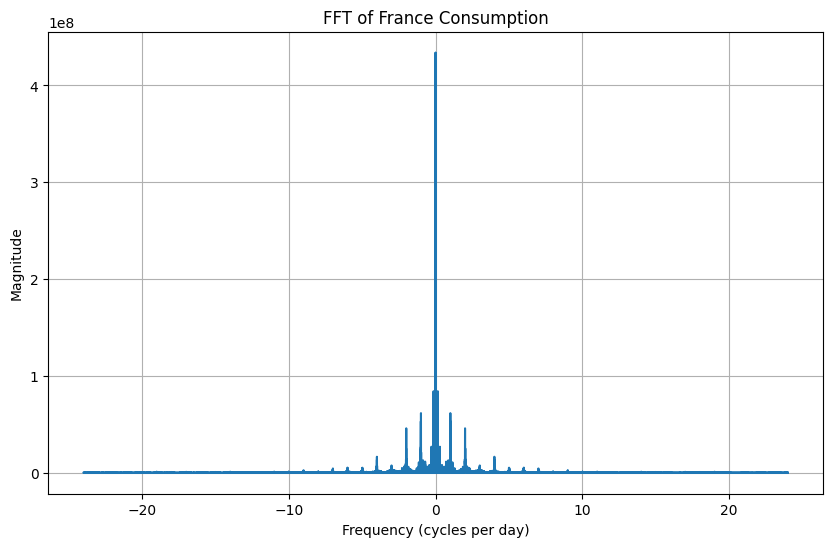

In [ ]:
france_consumption = (train_MLP_multi['France']-train_MLP_multi['France'].mean()).values
date = train_MLP_multi['date']

# Calculate the FFT
N = len(france_consumption)
yf = fft(france_consumption)
xf = fftfreq(N, 1/48)  # 48 samples per day (30 minutes interval)


# Plot the FFT
plt.figure(figsize=(10, 6))
plt.plot(xf, np.abs(yf))
plt.title('FFT of France Consumption')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the FFT
N = len(france_consumption)
yf = fft(france_consumption)
xf = fftfreq(N, 1/48)  # 48 samples per day (30 minutes interval)

# Find the dominant frequencies
positive_frequencies = xf[xf > 0]
positive_yf = np.abs(yf[xf > 0])
dominant_frequencies = positive_frequencies[np.argsort(positive_yf)[::-1]]

# Print the top 10 periods
print("Top 10 dominant periods:")
for i in range(10):
    print(f"Period: {1/dominant_frequencies[i]:.4f} days")


Top 10 dominant periods:
Period: 378.5521 days
Period: 504.7361 days
Period: 302.8417 days
Period: 168.2454 days
Period: 1514.2083 days
Period: 6.9459 days
Period: 151.4208 days
Period: 0.9988 days
Period: 79.6952 days
Period: 189.2760 days


## Training

In [42]:
def plot_model_pred_MLP_multi(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val):
    plot_dataframe_train = pd.DataFrame()
    plot_dataframe_train['date_train'] = date_train
    target = scaler_y.inverse_transform(train_dataset.y.detach().cpu().numpy())
    for i in range(len(locations)):
      plot_dataframe_train[locations[i]] = target[:,i]
    prediction = scaler_y.inverse_transform(model(train_dataset.X).detach().cpu().numpy())
    for i in range(len(locations)):
      plot_dataframe_train['prediction_'+locations[i]] = prediction[:,i]
      plot_dataframe_train['residuals_'+locations[i]] = plot_dataframe_train[locations[i]] - plot_dataframe_train['prediction_'+locations[i]]
    plot_dataframe_train.sort_values(by=['date_train'], inplace = True)


    plot_dataframe_val = pd.DataFrame()
    plot_dataframe_val['date_val'] = date_val
    target = scaler_y.inverse_transform(val_dataset.y.detach().cpu().numpy())
    for i in range(len(locations)):
      plot_dataframe_val[locations[i]] = target[:,i]
    prediction = scaler_y.inverse_transform(model(val_dataset.X).detach().cpu().numpy())
    for i in range(len(locations)):
      plot_dataframe_val['prediction_'+locations[i]] = prediction[:,i]
      plot_dataframe_val['residuals_'+locations[i]] = plot_dataframe_val[locations[i]] - plot_dataframe_val['prediction_'+locations[i]]
    plot_dataframe_val.sort_values(by=['date_val'], inplace = True)


    for location in locations:
      fig, axs = plt.subplots(2, 2, figsize = (15,10))
      plot_dataframe_train.plot(x = 'date_train', y = [location, 'prediction_'+location], ax = axs[0,0], title = 'train')
      plot_dataframe_val.plot(x = 'date_val', y = [location, 'prediction_'+location], ax = axs[0,1], title = 'val')
      plot_dataframe_train.plot(x = 'date_train', y = ['residuals_'+location], ax = axs[1,0], title = 'train')
      plot_dataframe_val.plot(x = 'date_val', y = ['residuals_'+location], ax = axs[1,1], title = 'val')
      plt.show()
    return()

In [ ]:
def train_model_MLP_multi(batch_size = 32,
                          epochs = 200,
                          lr = 1e-3,
                          scaler_X = preprocessing.MinMaxScaler(),
                          scaler_y = preprocessing.MinMaxScaler(),
                          dropout = [],
                          patience = 15,
                          hidden_shapes = None,
                          batchnorm = False,
                          output_tanh = False):

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  train_MLP_multi = joblib.load(Projet / ("Data/train_MLP_multi.pkl"))

  #X = train_1_region.drop(['date', region], axis=1)
  X = train_MLP_multi.copy()
  y = X[locations]
  #y = X.copy()

  time_split = 0.8
  time_split = int(len(X)*time_split/2)
  X_train = pd.concat([X.iloc[:time_split], X.iloc[-time_split:]])
  X_val = X.iloc[time_split:-time_split]
  y_train = pd.concat([y.iloc[:time_split], y.iloc[-time_split:]])
  y_val = y.iloc[time_split:-time_split]


  date_train = X_train['date']
  date_val = X_val['date']
  X_train = X_train.drop(['date']+locations, axis=1)
  X_val = X_val.drop(['date']+locations, axis=1)

  #Applying a MinMax on both features and targets
  X_train = scaler_X.fit_transform(X_train)
  X_val = scaler_X.transform(X_val)

  y_train = scaler_y.fit_transform(y_train.values)
  y_val = scaler_y.transform(y_val.values)

  #Creating Datasets and Dataloaders
  train_dataset = ConsumptionDataset(X_train, y_train)
  val_dataset = ConsumptionDataset(X_val, y_val)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = True)

  # Instenciate the model:
  input_shape = train_dataset[0][0].shape[0]
  n_hidden_layers = int(np.log2(input_shape/25).round()+1)
  if hidden_shapes == None:
    hidden_shapes = [round(input_shape/(2**(n-1))) for n in range(n_hidden_layers)]
  output_shape = train_dataset[0][1].shape[0]

  model = gMLP(input_shape, hidden_shapes, output_shape ,dropout = dropout, batchnorm = batchnorm, output_tanh = output_tanh)
  model = model.to(device)

  model._initialize_weights()

  # define the optimizer and the criterion
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # training loop :
  # Training Loop
  best_val_loss = np.inf
  best_weights = None
  patience_counter = 0
  for epoch in range(epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0  # Initialize the running loss
      val_loss = 0.0
      tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
      for inputs, targets in tqdm_bar:
          # Move data to device (GPU or CPU)
          inputs, targets = inputs.to(device), targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      model.eval()

      # Disable gradient computation during testing
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              # Forward pass
              outputs = model(inputs)

              # Calculate the loss
              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()

              outputs_tensor = torch.tensor(scaler_y.inverse_transform(outputs_np), dtype=torch.float32)
              targets_tensor = torch.tensor(scaler_y.inverse_transform(targets_np), dtype=torch.float32)

              loss = criterion(outputs_tensor, targets_tensor)

              # Accumulate the validation loss
              val_loss += loss.item()

      # Square root of average validation loss
      avg_val_loss = np.sqrt(val_loss / len(val_loader))

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
          best_weights = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
                print("Early stopping triggered")
                break

      # Average loss for the epoch
      epoch_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  model.load_state_dict(best_weights)
  joblib.dump((model, scaler_X, scaler_y, best_val_loss), Projet / ("Models/gMLP_multi.pkl"))
  return(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

In [ ]:
#best results with 30 fourier features selected from 15*3*2 fourier features and
batch_size = 64,
    epochs = 200,
    lr=1e-4,
    scaler_X = preprocessing.MinMaxScaler(),
    #scaler_y = Target_MinMaxScaler(),
    dropout = [0.2, 0.1, 0.1, 0.1],
    patience = 40,
    hidden_shapes = [120, 105, 90, 60 , 40, 30, 30],
    batchnorm = True,
    output_tanh = True

In [ ]:
model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val = train_model_MLP_multi(
    batch_size = 64,
    epochs = 200,
    lr=1e-4,
    scaler_X = preprocessing.MinMaxScaler(),
    #scaler_y = Target_MinMaxScaler(),
    dropout = [0.2, 0.1, 0.1, 0.1],
    patience = 40,
    hidden_shapes = [120, 105, 90, 60 , 40, 30, 30],
    batchnorm = True,
    output_tanh = True)

plot_model_pred_MLP_multi(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

Output hidden; open in https://colab.research.google.com to view.

## Utilitary function to produce a submition

In [ ]:
def submit_multi(model, scaler_X, scaler_y, test_1, submit_name = ""):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    test = pd.read_csv(Projet / "Data/test.csv")
    date = test['date']

    col = ['pred_'+location for location in locations]

    X = test_1.drop(['date'], axis=1)
    X = scaler_X.transform(X)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = model(X)
    y = scaler_y.inverse_transform(y.detach().cpu().numpy())

    y_pred = pd.DataFrame(y, columns=col)
    y_pred.columns = col
    y_pred.insert(0, 'date', date)
    y_pred.to_csv(Projet / ('Submit/pred'+submit_name+'.csv'), index = False)
    return()

In [ ]:
model, scaler_X, scaler_y, best_val_loss = joblib.load(Projet / "Models/gMLP_multi.pkl")
test_MLP_multi = joblib.load(Projet / "Data/test_MLP_multi.pkl")
submit_multi(model, scaler_X, scaler_y, test_MLP_multi, submit_name = "_MLP_multi_bestplusfourier")

()

# Third strategy : training a MLP on the residuals of a linear regression over fourier features

In [ ]:
weather_features = ['t', 'pmer', 'tend', 'u', 'ff', 'pres']

In [ ]:
weather = pd.read_parquet(Projet / "Data/meteo.parquet")
weather['nbas'] = weather['nbas'].astype(np.float64, errors='ignore')
weather['geop'] = weather['geop'].astype(np.float64, errors='ignore')

weather.drop(['mois_de_l_annee', 'coordonnees', 'nom', 'cod_tend', 'ww', 'etat_sol', 'type_de_tendance_barometrique', 'temps_present', 'libgeo', 'codegeo', 'nom_epci', 'code_epci', 'nom_dept', 'code_dep', 'nom_reg', 'code_reg'], axis = 1, inplace = True)

weather = weather[['date', 'numer_sta'] + weather_features]

weather = drop_NaN_columns(weather, 0.3)

weather = time_zone_convertion(weather)

features_to_flatten = list(weather.columns).copy()
features_to_flatten.remove('date')
features_to_flatten.remove('numer_sta')
weather = flatten_features(weather, features_to_flatten)

weather = interpolate_df(weather)

columns = list(weather.columns).copy()
for col in columns:
  if weather[col].isna().sum() > 5:
    weather.drop(col, axis = 1, inplace = True)

weather.dropna(how = 'any', axis = 0, inplace=True)
weather.shape, weather.columns

((91288, 239),
 Index(['date', 't_07020', 'pmer_07020', 'tend_07020', 'u_07020', 'ff_07020',
        'pres_07020', 't_07558', 'pmer_07558', 'tend_07558',
        ...
        'tend_07434', 'u_07434', 'ff_07434', 'pres_07434', 't_07630',
        'pmer_07630', 'tend_07630', 'u_07630', 'ff_07630', 'pres_07630'],
       dtype='object', length=239))

In [ ]:
df = weather.copy()

In [ ]:
weather_means = dict()
for region in regions:
  print(region)
  for feature in weather_features:
    l = [feature+'_'+station for station in dict_locations[region]]
    l = [col for col in l if col in list(weather.columns)]
    if l != []:
      weather_means[region+ '_' + feature] = weather[l].mean(axis = 1)
      print("     ", feature, "<--- done")
    else:
      print("     ", feature, "<--- fail")

Auvergne-Rhône-Alpes
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bourgogne-Franche-Comté
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bretagne
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Centre-Val de Loire
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Grand Est
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Hauts-de-France
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Normandie
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Nouvelle-Aquitaine
      t <--- done
      pmer <--- done
      

In [ ]:
weather_means = pd.DataFrame(weather_means)

In [ ]:
weather_means.insert(0, 'date', df['date'])
weather_means.head(20)

,date,Auvergne-Rhône-Alpes_t,Auvergne-Rhône-Alpes_pmer,Auvergne-Rhône-Alpes_tend,Auvergne-Rhône-Alpes_u,Auvergne-Rhône-Alpes_ff,Auvergne-Rhône-Alpes_pres,Bourgogne-Franche-Comté_t,Bourgogne-Franche-Comté_pmer,Bourgogne-Franche-Comté_tend,Bourgogne-Franche-Comté_u,Bourgogne-Franche-Comté_ff,Bourgogne-Franche-Comté_pres,Bretagne_t,Bretagne_pmer,Bretagne_tend,Bretagne_u,Bretagne_ff,Bretagne_pres,Centre-Val de Loire_t,Centre-Val de Loire_pmer,Centre-Val de Loire_tend,Centre-Val de Loire_u,Centre-Val de Loire_ff,Centre-Val de Loire_pres,Grand Est_t,Grand Est_pmer,Grand Est_tend,Grand Est_u,Grand Est_ff,Grand Est_pres,Hauts-de-France_t,Hauts-de-France_pmer,Hauts-de-France_tend,Hauts-de-France_u,Hauts-de-France_ff,Hauts-de-France_pres,Normandie_t,Normandie_pmer,Normandie_tend,Normandie_u,Normandie_ff,Normandie_pres,Nouvelle-Aquitaine_t,Nouvelle-Aquitaine_pmer,Nouvelle-Aquitaine_tend,Nouvelle-Aquitaine_u,Nouvelle-Aquitaine_ff,Nouvelle-Aquitaine_pres,Occitanie_t,Occitanie_pmer,Occitanie_tend,Occitanie_u,Occitanie_ff,Occitanie_pres,Pays de la Loire_t,Pays de la Loire_pmer,Pays de la Loire_tend,Pays de la Loire_u,Pays de la Loire_ff,Pays de la Loire_pres,Provence-Alpes-Côte d'Azur_t,Provence-Alpes-Côte d'Azur_pmer,Provence-Alpes-Côte d'Azur_tend,Provence-Alpes-Côte d'Azur_u,Provence-Alpes-Côte d'Azur_ff,Provence-Alpes-Côte d'Azur_pres,Île-de-France_t,Île-de-France_pmer,Île-de-France_tend,Île-de-France_u,Île-de-France_ff,Île-de-France_pres
5,2017-10-17 04:00:00+01:00,282.575000,102520.000000,-67.500000,78.750000,0.850000,98197.500000,280.250000,102510.000000,-60.000000,95.000000,0.800000,99730.000000,285.175000,102150.000000,-125.000000,89.500000,1.950000,101435.000000,284.250000,102290.000000,-80.000000,93.000000,0.750000,100605.000000,283.170000,102398.000000,-26.000000,88.800000,1.840000,100034.000000,286.250000,102195.000000,0.000000,90.500000,1.650000,101475.000000,284.900000,102210.000000,-72.500000,86.250000,2.675000,101080.000000,287.510000,102126.000000,-160.000000,91.400000,3.040000,100578.000000,286.550000,102311.428571,-165.714286,88.714286,2.928571,99017.142857,286.050000,102100.000000,-160.000000,96.000000,1.200000,101790.000000,286.075000,102573.333333,-100.000000,73.000000,3.200000,99550.000000,286.050000,102270.000000,-10.000000,92.000000,0.700000,101180.000000
6,2017-10-17 04:30:00+01:00,282.429167,102512.777778,-66.666667,79.375000,1.220833,98187.083333,280.116667,102508.333333,-53.333333,95.000000,0.783333,99726.666667,285.291667,102135.416667,-118.750000,89.041667,2.141667,101420.416667,284.058333,102273.333333,-84.166667,93.000000,0.966667,100587.500000,283.010000,102398.000000,-24.000000,89.433333,1.773333,100031.666667,285.983333,102198.333333,3.333333,91.250000,1.650000,101478.333333,284.816667,102207.083333,-63.333333,86.791667,2.570833,101077.083333,287.310000,102110.333333,-150.000000,91.466667,2.880000,100561.333333,286.450000,102297.380952,-152.619048,88.761905,2.940476,99002.619048,286.050000,102088.333333,-145.000000,95.166667,1.483333,101778.333333,285.987500,102570.555556,-86.666667,72.916667,3.116667,99546.666667,285.933333,102263.333333,-15.000000,92.000000,0.850000,101173.333333
7,2017-10-17 05:00:00+01:00,282.283333,102505.555556,-65.833333,80.000000,1.591667,98176.666667,279.983333,102506.666667,-46.666667,95.000000,0.766667,99723.333333,285.408333,102120.833333,-112.500000,88.583333,2.333333,101405.833333,283.866667,102256.666667,-88.333333,93.000000,1.183333,100570.000000,282.850000,102398.000000,-22.000000,90.066667,1.706667,100029.333333,285.716667,102201.666667,6.666667,92.000000,1.650000,101481.666667,284.733333,102204.166667,-54.166667,87.333333,2.466667,101074.166667,287.110000,102094.666667,-140.000000,91.533333,2.720000,100544.666667,286.350000,102283.333333,-139.523810,88.809524,2.952381,98988.095238,286.050000,102076.666667,-130.000000,94.333333,1.766667,101766.666667,285.900000,102567.777778,-73.333333,72.833333,3.033333,99543.333333,285.816667,102256.666667,-20.000000,92.000000,1.000000

In [ ]:
weather_means.columns

Index(['date', 'Auvergne-Rhône-Alpes_t', 'Auvergne-Rhône-Alpes_pmer',
       'Auvergne-Rhône-Alpes_tend', 'Auvergne-Rhône-Alpes_u',
       'Auvergne-Rhône-Alpes_ff', 'Auvergne-Rhône-Alpes_pres',
       'Bourgogne-Franche-Comté_t', 'Bourgogne-Franche-Comté_pmer',
       'Bourgogne-Franche-Comté_tend', 'Bourgogne-Franche-Comté_u',
       'Bourgogne-Franche-Comté_ff', 'Bourgogne-Franche-Comté_pres',
       'Bretagne_t', 'Bretagne_pmer', 'Bretagne_tend', 'Bretagne_u',
       'Bretagne_ff', 'Bretagne_pres', 'Centre-Val de Loire_t',
       'Centre-Val de Loire_pmer', 'Centre-Val de Loire_tend',
       'Centre-Val de Loire_u', 'Centre-Val de Loire_ff',
       'Centre-Val de Loire_pres', 'Grand Est_t', 'Grand Est_pmer',
       'Grand Est_tend', 'Grand Est_u', 'Grand Est_ff', 'Grand Est_pres',
       'Hauts-de-France_t', 'Hauts-de-France_pmer', 'Hauts-de-France_tend',
       'Hauts-de-France_u', 'Hauts-de-France_ff', 'Hauts-de-France_pres',
       'Normandie_t', 'Normandie_pmer', 'Normandie_ten

In [ ]:
weather_means.shape

(91288, 73)

In [ ]:
train_MLP_multi = train.merge(weather_means, on = ['date'], how = 'inner')
test_MLP_multi = test.merge(weather_means, on = ['date'], how = 'inner')

train_MLP_multi = add_time_features(train_MLP_multi)
test_MLP_multi = add_time_features(test_MLP_multi)

train_MLP_multi = add_fourier_features_classique(train_MLP_multi,15)
test_MLP_multi = add_fourier_features_classique(test_MLP_multi,15)


# Here we drop time features to only keep Fourier features and weather features
time_features_to_drop = ['year', 'month', 'day', 'day_of_year', 'weekday', 'week', 'is_weekend', 'hour', 'minutes', 'time_index']
train_MLP_multi.drop(time_features_to_drop, axis = 1, inplace = True)
test_MLP_multi.drop(time_features_to_drop, axis = 1, inplace = True)


# We perform a linear regression on our Fourier features to have a clue about which frequencies are important, and drop others
fourier_features = [e for e in list(train_MLP_multi.columns) if ('cos' in e or 'sin' in e)]
X = train_MLP_multi[fourier_features]
y = train_MLP_multi['France'] - train_MLP_multi['France'].mean()

linear_reg = LinearRegression()
linear_reg.fit(X, y)

Coefficients = pd.DataFrame({'Feature': fourier_features, 'Coefficient': linear_reg.coef_, 'Coefficient_abs': np.abs(linear_reg.coef_)})
Coefficients = Coefficients.sort_values(by = 'Coefficient_abs', ascending = False)
print(Coefficients[['Feature', 'Coefficient']].iloc[:30])
print("Intercept:", linear_reg.intercept_)

r_squared = linear_reg.score(X, y)
print("R-squared:", r_squared)

fourier_features_to_drop = list(Coefficients['Feature'].iloc[30:])

train_MLP_multi.drop(fourier_features_to_drop, axis = 1, inplace = True)
test_MLP_multi.drop(fourier_features_to_drop, axis = 1, inplace = True)

joblib.dump(train_MLP_multi, Projet / "Data/train_MLP_multi.pkl")
joblib.dump(test_MLP_multi, Projet / "Data/test_MLP_multi.pkl")

                Feature   Coefficient
91    day_of_year_cos_1  12554.447334
90    day_of_year_sin_1   3252.186093
93    day_of_year_cos_2   3072.899881
61            day_cos_1   2888.833535
113  day_of_year_cos_12  -2626.665773
30        weekday_sin_1   2541.549021
31        weekday_cos_1  -2499.994851
112  day_of_year_sin_12   2359.308366
32        weekday_sin_2   1907.470548
1      time_index_cos_1  -1820.034486
43        weekday_cos_7  -1820.034486
56       weekday_sin_14  -1570.828308
2      time_index_sin_2  -1570.828308
0      time_index_sin_1  -1327.754077
42        weekday_sin_7  -1327.754077
92    day_of_year_sin_2   1320.776556
95    day_of_year_cos_3  -1247.105440
99    day_of_year_cos_5  -1055.513924
60            day_sin_1  -1025.480980
38        weekday_sin_5    921.352662
6      time_index_sin_4    850.461281
100   day_of_year_sin_6    830.612389
40        weekday_sin_6    778.859594
3      time_index_cos_2    729.370904
57       weekday_cos_14    729.370904
103   day_of

['/content/drive/MyDrive/Colab Notebooks/DL challenge/Data/test_MLP_multi.pkl']

In [ ]:
train_MLP_multi = joblib.load(Projet / "Data/train_MLP_multi.pkl")
test_MLP_multi = joblib.load(Projet / "Data/test_MLP_multi.pkl")

fourier_features = [e for e in list(train_MLP_multi.columns) if ('cos' in e or 'sin' in e)]
non_fourier_features = [e for e in list(train_MLP_multi.columns) if e not in fourier_features+['date']+locations]

X_fourier = train_MLP_multi[fourier_features]
linear_regressions = dict()
for location in locations:
  y_fourier = train_MLP_multi[location]
  linear_regressions[location] = LinearRegression()
  linear_regressions[location].fit(X_fourier, y_fourier)

<Figure size 1500x1000 with 0 Axes>

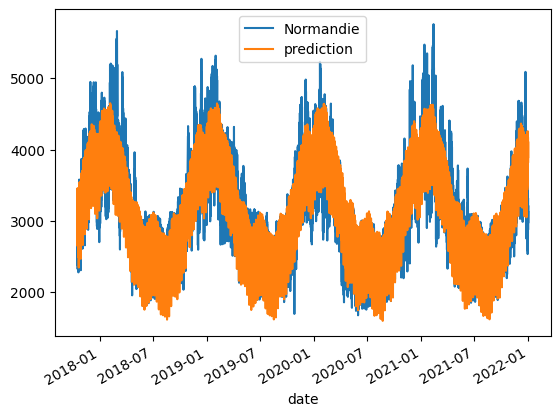

<Figure size 1500x1000 with 0 Axes>

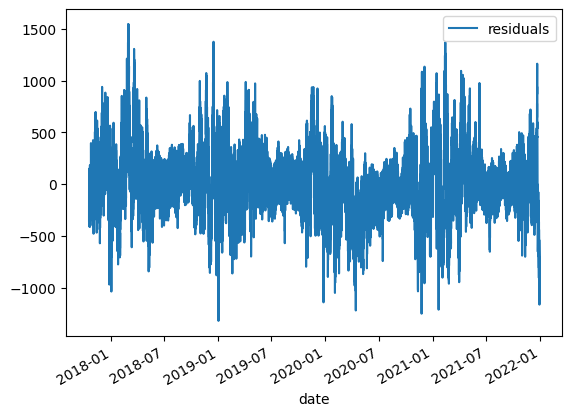

In [ ]:
df_show = pd.DataFrame()
df_show['date'] = train_MLP_multi['date']
df_show['Normandie'] = train_MLP_multi['Normandie']
df_show['prediction'] = linear_regressions['Normandie'].predict(X_fourier)
df_show['residuals'] = df_show['Normandie'] - df_show['prediction']

plt.figure(figsize = (15,10))
df_show.plot(x = 'date', y = ['Normandie', 'prediction'])
plt.show()

plt.figure(figsize = (15,10))
df_show.plot(x = 'date', y = ['residuals'])
plt.show()

In [ ]:
def train_model_fourier_MLP_residuals(batch_size = 32,
                          epochs = 200,
                          lr = 1e-3,
                          scaler_X = preprocessing.MinMaxScaler(),
                          scaler_y = preprocessing.MinMaxScaler(),
                          dropout = [],
                          patience = 15,
                          hidden_shapes = None,
                          batchnorm = False,
                          output_tanh = False):

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  train_MLP_multi = joblib.load(Projet / ("Data/train_MLP_multi.pkl"))

  fourier_features = [e for e in list(train_MLP_multi.columns) if ('cos' in e or 'sin' in e)]
  non_fourier_features = [e for e in list(train_MLP_multi.columns) if e not in fourier_features+['date']+locations]

  X_fourier = train_MLP_multi[fourier_features]
  X = train_MLP_multi[['date']+non_fourier_features].copy()
  y = train_MLP_multi[locations].copy()

  linear_regressions = dict()
  for location in locations:
    y_fourier = train_MLP_multi[location]
    linear_regressions[location] = LinearRegression()
    linear_regressions[location].fit(X_fourier, y_fourier)
    y[location] = y_fourier - linear_regressions[location].predict(X_fourier)


  time_split = 0.8
  time_split = int(len(X)*time_split/2)
  X_train = pd.concat([X.iloc[:time_split], X.iloc[-time_split:]])
  X_val = X.iloc[time_split:-time_split]
  y_train = pd.concat([y.iloc[:time_split], y.iloc[-time_split:]])
  y_val = y.iloc[time_split:-time_split]


  date_train = X_train['date']
  date_val = X_val['date']
  X_train = X_train.drop(['date'], axis=1)
  X_val = X_val.drop(['date'], axis=1)

  #Applying a MinMax on both features and targets
  X_train = scaler_X.fit_transform(X_train)
  X_val = scaler_X.transform(X_val)

  y_train = scaler_y.fit_transform(y_train.values)
  y_val = scaler_y.transform(y_val.values)

  #Creating Datasets and Dataloaders
  train_dataset = ConsumptionDataset(X_train, y_train)
  val_dataset = ConsumptionDataset(X_val, y_val)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = True)

  # Instenciate the model:
  input_shape = train_dataset[0][0].shape[0]
  n_hidden_layers = int(np.log2(input_shape/25).round()+1)
  if hidden_shapes == None:
    hidden_shapes = [round(input_shape/(2**(n-1))) for n in range(n_hidden_layers)]
  output_shape = train_dataset[0][1].shape[0]

  model = gMLP(input_shape, hidden_shapes, output_shape ,dropout = dropout, batchnorm = batchnorm, output_tanh = output_tanh)
  model = model.to(device)

  model._initialize_weights()

  # define the optimizer and the criterion
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # training loop :
  # Training Loop
  best_val_loss = np.inf
  best_weights = None
  patience_counter = 0
  for epoch in range(epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0  # Initialize the running loss
      val_loss = 0.0
      tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
      for inputs, targets in tqdm_bar:
          # Move data to device (GPU or CPU)
          inputs, targets = inputs.to(device), targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      model.eval()

      # Disable gradient computation during testing
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              # Forward pass
              outputs = model(inputs)

              # Calculate the loss
              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()

              outputs_tensor = torch.tensor(scaler_y.inverse_transform(outputs_np), dtype=torch.float32)
              targets_tensor = torch.tensor(scaler_y.inverse_transform(targets_np), dtype=torch.float32)

              loss = criterion(outputs_tensor, targets_tensor)

              # Accumulate the validation loss
              val_loss += loss.item()

      # Square root of average validation loss
      avg_val_loss = np.sqrt(val_loss / len(val_loader))

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
          best_weights = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
                print("Early stopping triggered")
                break

      # Average loss for the epoch
      epoch_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  model.load_state_dict(best_weights)
  joblib.dump((model, scaler_X, scaler_y, best_val_loss, linear_regressions), Projet / ("Models/fourier_gMLP_residuals.pkl"))
  return(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val, linear_regressions)

In [ ]:
#best results with 30 fourier features selected from 15*3*2 fourier features and
batch_size = 64,
    epochs = 200,
    lr=1e-4,
    scaler_X = preprocessing.MinMaxScaler(),
    #scaler_y = Target_MinMaxScaler(),
    dropout = [0.2, 0.1, 0.1, 0.1],
    patience = 40,
    hidden_shapes = [120, 105, 90, 60 , 40, 30, 30],
    batchnorm = True,
    output_tanh = True

In [ ]:
model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val, linear_regressions = train_model_fourier_MLP_residuals(
    batch_size = 64,
    epochs = 200,
    lr=1e-4,
    scaler_X = preprocessing.MinMaxScaler(),
    #scaler_y = Target_MinMaxScaler(),
    dropout = [0.1, 0.1, 0.1],
    patience = 40,
    hidden_shapes = [100, 80, 60 , 40, 30, 30],
    batchnorm = True,
    output_tanh = True)

Epoch 1: 100%|██████████| 909/909 [00:05<00:00, 161.17it/s]


Epoch [1/200], Train Loss: 0.6332, Val Loss: 5070.1760


Epoch 2: 100%|██████████| 909/909 [00:05<00:00, 154.38it/s]


Epoch [2/200], Train Loss: 0.2690, Val Loss: 4423.1070


Epoch 3: 100%|██████████| 909/909 [00:06<00:00, 149.39it/s]


Epoch [3/200], Train Loss: 0.1755, Val Loss: 3592.1637


Epoch 4: 100%|██████████| 909/909 [00:05<00:00, 165.55it/s]


Epoch [4/200], Train Loss: 0.1251, Val Loss: 3289.3258


Epoch 5: 100%|██████████| 909/909 [00:06<00:00, 140.58it/s]


Epoch [5/200], Train Loss: 0.1014, Val Loss: 3199.2883


Epoch 6: 100%|██████████| 909/909 [00:05<00:00, 165.12it/s]


Epoch [6/200], Train Loss: 0.0864, Val Loss: 3256.0932


Epoch 7: 100%|██████████| 909/909 [00:06<00:00, 131.29it/s]


Epoch [7/200], Train Loss: 0.0772, Val Loss: 3061.2666


Epoch 8: 100%|██████████| 909/909 [00:05<00:00, 164.81it/s]


Epoch [8/200], Train Loss: 0.0727, Val Loss: 3056.9203


Epoch 9: 100%|██████████| 909/909 [00:06<00:00, 137.00it/s]


Epoch [9/200], Train Loss: 0.0711, Val Loss: 2625.1069


Epoch 10: 100%|██████████| 909/909 [00:05<00:00, 169.06it/s]


Epoch [10/200], Train Loss: 0.0696, Val Loss: 3102.6024


Epoch 11: 100%|██████████| 909/909 [00:07<00:00, 119.99it/s]


Epoch [11/200], Train Loss: 0.0676, Val Loss: 2872.0090


Epoch 12: 100%|██████████| 909/909 [00:05<00:00, 155.93it/s]


Epoch [12/200], Train Loss: 0.0660, Val Loss: 2576.6200


Epoch 13: 100%|██████████| 909/909 [00:06<00:00, 137.23it/s]


Epoch [13/200], Train Loss: 0.0649, Val Loss: 2634.9769


Epoch 14: 100%|██████████| 909/909 [00:05<00:00, 167.99it/s]


Epoch [14/200], Train Loss: 0.0638, Val Loss: 2920.5080


Epoch 15: 100%|██████████| 909/909 [00:06<00:00, 133.41it/s]


Epoch [15/200], Train Loss: 0.0516, Val Loss: 2013.2790


Epoch 16: 100%|██████████| 909/909 [00:05<00:00, 163.77it/s]


Epoch [16/200], Train Loss: 0.0342, Val Loss: 2148.9775


Epoch 17: 100%|██████████| 909/909 [00:06<00:00, 140.64it/s]


Epoch [17/200], Train Loss: 0.0320, Val Loss: 1933.7183


Epoch 18: 100%|██████████| 909/909 [00:05<00:00, 169.37it/s]


Epoch [18/200], Train Loss: 0.0313, Val Loss: 2179.8511


Epoch 19: 100%|██████████| 909/909 [00:06<00:00, 150.95it/s]


Epoch [19/200], Train Loss: 0.0304, Val Loss: 1769.3864


Epoch 20: 100%|██████████| 909/909 [00:05<00:00, 154.93it/s]


Epoch [20/200], Train Loss: 0.0268, Val Loss: 2103.2225


Epoch 21: 100%|██████████| 909/909 [00:05<00:00, 157.03it/s]


Epoch [21/200], Train Loss: 0.0246, Val Loss: 1575.9366


Epoch 22: 100%|██████████| 909/909 [00:06<00:00, 146.38it/s]


Epoch [22/200], Train Loss: 0.0240, Val Loss: 1810.7884


Epoch 23: 100%|██████████| 909/909 [00:05<00:00, 167.57it/s]


Epoch [23/200], Train Loss: 0.0171, Val Loss: 1502.5855


Epoch 24: 100%|██████████| 909/909 [00:06<00:00, 138.96it/s]


Epoch [24/200], Train Loss: 0.0088, Val Loss: 1167.5484


Epoch 25: 100%|██████████| 909/909 [00:05<00:00, 164.31it/s]


Epoch [25/200], Train Loss: 0.0085, Val Loss: 1452.7974


Epoch 26: 100%|██████████| 909/909 [00:06<00:00, 135.65it/s]


Epoch [26/200], Train Loss: 0.0084, Val Loss: 1347.2000


Epoch 27: 100%|██████████| 909/909 [00:05<00:00, 166.28it/s]


Epoch [27/200], Train Loss: 0.0084, Val Loss: 1532.9423


Epoch 28: 100%|██████████| 909/909 [00:06<00:00, 136.80it/s]


Epoch [28/200], Train Loss: 0.0084, Val Loss: 1045.6739


Epoch 29: 100%|██████████| 909/909 [00:05<00:00, 165.03it/s]


Epoch [29/200], Train Loss: 0.0083, Val Loss: 1119.9002


Epoch 30: 100%|██████████| 909/909 [00:06<00:00, 133.76it/s]


Epoch [30/200], Train Loss: 0.0083, Val Loss: 1100.7243


Epoch 31: 100%|██████████| 909/909 [00:05<00:00, 168.92it/s]


Epoch [31/200], Train Loss: 0.0083, Val Loss: 1029.5562


Epoch 32: 100%|██████████| 909/909 [00:06<00:00, 136.54it/s]


Epoch [32/200], Train Loss: 0.0083, Val Loss: 1169.4542


Epoch 33: 100%|██████████| 909/909 [00:05<00:00, 160.26it/s]


Epoch [33/200], Train Loss: 0.0083, Val Loss: 1064.2017


Epoch 34: 100%|██████████| 909/909 [00:06<00:00, 137.04it/s]


Epoch [34/200], Train Loss: 0.0084, Val Loss: 1131.8891


Epoch 35: 100%|██████████| 909/909 [00:05<00:00, 165.33it/s]


Epoch [35/200], Train Loss: 0.0082, Val Loss: 1051.2562


Epoch 36: 100%|██████████| 909/909 [00:06<00:00, 143.20it/s]


Epoch [36/200], Train Loss: 0.0078, Val Loss: 1018.1995


Epoch 37: 100%|██████████| 909/909 [00:05<00:00, 154.77it/s]


Epoch [37/200], Train Loss: 0.0073, Val Loss: 936.6122


Epoch 38: 100%|██████████| 909/909 [00:06<00:00, 136.20it/s]


Epoch [38/200], Train Loss: 0.0071, Val Loss: 899.9995


Epoch 39: 100%|██████████| 909/909 [00:05<00:00, 155.46it/s]


Epoch [39/200], Train Loss: 0.0069, Val Loss: 902.8851


Epoch 40: 100%|██████████| 909/909 [00:05<00:00, 155.42it/s]


Epoch [40/200], Train Loss: 0.0068, Val Loss: 965.3289


Epoch 41: 100%|██████████| 909/909 [00:06<00:00, 147.64it/s]


Epoch [41/200], Train Loss: 0.0067, Val Loss: 892.4818


Epoch 42: 100%|██████████| 909/909 [00:05<00:00, 161.21it/s]


Epoch [42/200], Train Loss: 0.0065, Val Loss: 952.3632


Epoch 43: 100%|██████████| 909/909 [00:06<00:00, 143.13it/s]


Epoch [43/200], Train Loss: 0.0065, Val Loss: 860.5882


Epoch 44: 100%|██████████| 909/909 [00:06<00:00, 130.92it/s]


Epoch [44/200], Train Loss: 0.0064, Val Loss: 946.9214


Epoch 45: 100%|██████████| 909/909 [00:06<00:00, 150.64it/s]


Epoch [45/200], Train Loss: 0.0063, Val Loss: 892.4925


Epoch 46: 100%|██████████| 909/909 [00:05<00:00, 167.21it/s]


Epoch [46/200], Train Loss: 0.0063, Val Loss: 909.0889


Epoch 47: 100%|██████████| 909/909 [00:06<00:00, 138.31it/s]


Epoch [47/200], Train Loss: 0.0062, Val Loss: 876.4245


Epoch 48: 100%|██████████| 909/909 [00:05<00:00, 167.68it/s]


Epoch [48/200], Train Loss: 0.0061, Val Loss: 859.7211


Epoch 49: 100%|██████████| 909/909 [00:06<00:00, 137.90it/s]


Epoch [49/200], Train Loss: 0.0061, Val Loss: 903.1740


Epoch 50: 100%|██████████| 909/909 [00:05<00:00, 171.25it/s]


Epoch [50/200], Train Loss: 0.0060, Val Loss: 946.9511


Epoch 51: 100%|██████████| 909/909 [00:06<00:00, 136.46it/s]


Epoch [51/200], Train Loss: 0.0060, Val Loss: 895.5370


Epoch 52: 100%|██████████| 909/909 [00:05<00:00, 167.89it/s]


Epoch [52/200], Train Loss: 0.0059, Val Loss: 883.5734


Epoch 53: 100%|██████████| 909/909 [00:06<00:00, 139.07it/s]


Epoch [53/200], Train Loss: 0.0059, Val Loss: 828.3836


Epoch 54: 100%|██████████| 909/909 [00:05<00:00, 171.08it/s]


Epoch [54/200], Train Loss: 0.0059, Val Loss: 821.4897


Epoch 55: 100%|██████████| 909/909 [00:06<00:00, 151.12it/s]


Epoch [55/200], Train Loss: 0.0058, Val Loss: 963.8411


Epoch 56: 100%|██████████| 909/909 [00:05<00:00, 156.76it/s]


Epoch [56/200], Train Loss: 0.0058, Val Loss: 879.1104


Epoch 57: 100%|██████████| 909/909 [00:05<00:00, 161.79it/s]


Epoch [57/200], Train Loss: 0.0058, Val Loss: 857.3777


Epoch 58: 100%|██████████| 909/909 [00:06<00:00, 149.55it/s]


Epoch [58/200], Train Loss: 0.0057, Val Loss: 898.5902


Epoch 59: 100%|██████████| 909/909 [00:05<00:00, 171.33it/s]


Epoch [59/200], Train Loss: 0.0057, Val Loss: 823.0290


Epoch 60: 100%|██████████| 909/909 [00:06<00:00, 137.86it/s]


Epoch [60/200], Train Loss: 0.0057, Val Loss: 885.3319


Epoch 61: 100%|██████████| 909/909 [00:05<00:00, 172.20it/s]


Epoch [61/200], Train Loss: 0.0056, Val Loss: 849.3426


Epoch 62: 100%|██████████| 909/909 [00:06<00:00, 136.71it/s]


Epoch [62/200], Train Loss: 0.0056, Val Loss: 855.9759


Epoch 63: 100%|██████████| 909/909 [00:05<00:00, 170.19it/s]


Epoch [63/200], Train Loss: 0.0056, Val Loss: 890.5070


Epoch 64: 100%|██████████| 909/909 [00:06<00:00, 135.86it/s]


Epoch [64/200], Train Loss: 0.0056, Val Loss: 843.2153


Epoch 65: 100%|██████████| 909/909 [00:05<00:00, 169.40it/s]


Epoch [65/200], Train Loss: 0.0056, Val Loss: 896.8710


Epoch 66: 100%|██████████| 909/909 [00:06<00:00, 143.05it/s]


Epoch [66/200], Train Loss: 0.0055, Val Loss: 834.0420


Epoch 67: 100%|██████████| 909/909 [00:05<00:00, 169.21it/s]


Epoch [67/200], Train Loss: 0.0055, Val Loss: 857.2183


Epoch 68: 100%|██████████| 909/909 [00:05<00:00, 157.60it/s]


Epoch [68/200], Train Loss: 0.0055, Val Loss: 844.6623


Epoch 69: 100%|██████████| 909/909 [00:05<00:00, 153.09it/s]


Epoch [69/200], Train Loss: 0.0054, Val Loss: 870.6832


Epoch 70: 100%|██████████| 909/909 [00:05<00:00, 167.14it/s]


Epoch [70/200], Train Loss: 0.0054, Val Loss: 873.3283


Epoch 71: 100%|██████████| 909/909 [00:06<00:00, 140.43it/s]


Epoch [71/200], Train Loss: 0.0054, Val Loss: 866.3232


Epoch 72: 100%|██████████| 909/909 [00:05<00:00, 172.86it/s]


Epoch [72/200], Train Loss: 0.0054, Val Loss: 872.7013


Epoch 73: 100%|██████████| 909/909 [00:06<00:00, 137.28it/s]


Epoch [73/200], Train Loss: 0.0053, Val Loss: 887.7949


Epoch 74: 100%|██████████| 909/909 [00:06<00:00, 131.80it/s]


Epoch [74/200], Train Loss: 0.0053, Val Loss: 844.7372


Epoch 75: 100%|██████████| 909/909 [00:09<00:00, 93.92it/s] 


Epoch [75/200], Train Loss: 0.0053, Val Loss: 812.0962


Epoch 76: 100%|██████████| 909/909 [00:05<00:00, 152.61it/s]


Epoch [76/200], Train Loss: 0.0052, Val Loss: 853.0432


Epoch 77: 100%|██████████| 909/909 [00:07<00:00, 117.37it/s]


Epoch [77/200], Train Loss: 0.0053, Val Loss: 870.7817


Epoch 78: 100%|██████████| 909/909 [00:08<00:00, 104.65it/s]


Epoch [78/200], Train Loss: 0.0052, Val Loss: 860.9805


Epoch 79: 100%|██████████| 909/909 [00:08<00:00, 111.10it/s]


Epoch [79/200], Train Loss: 0.0052, Val Loss: 845.4694


Epoch 80: 100%|██████████| 909/909 [00:08<00:00, 113.38it/s]


Epoch [80/200], Train Loss: 0.0051, Val Loss: 852.7272


Epoch 81: 100%|██████████| 909/909 [00:11<00:00, 81.78it/s] 


Epoch [81/200], Train Loss: 0.0051, Val Loss: 836.5479


Epoch 82: 100%|██████████| 909/909 [00:05<00:00, 166.19it/s]


Epoch [82/200], Train Loss: 0.0051, Val Loss: 861.2436


Epoch 83: 100%|██████████| 909/909 [00:06<00:00, 134.11it/s]


Epoch [83/200], Train Loss: 0.0050, Val Loss: 851.8285


Epoch 84: 100%|██████████| 909/909 [00:05<00:00, 167.66it/s]


Epoch [84/200], Train Loss: 0.0050, Val Loss: 880.4416


Epoch 85: 100%|██████████| 909/909 [00:06<00:00, 134.40it/s]


Epoch [85/200], Train Loss: 0.0050, Val Loss: 883.1482


Epoch 86: 100%|██████████| 909/909 [00:06<00:00, 131.07it/s]


Epoch [86/200], Train Loss: 0.0049, Val Loss: 870.7067


Epoch 87: 100%|██████████| 909/909 [00:07<00:00, 126.72it/s]


Epoch [87/200], Train Loss: 0.0049, Val Loss: 888.0261


Epoch 88: 100%|██████████| 909/909 [00:05<00:00, 171.29it/s]


Epoch [88/200], Train Loss: 0.0049, Val Loss: 911.8359


Epoch 89: 100%|██████████| 909/909 [00:09<00:00, 97.50it/s] 


Epoch [89/200], Train Loss: 0.0049, Val Loss: 864.5940


Epoch 90: 100%|██████████| 909/909 [00:05<00:00, 167.41it/s]


Epoch [90/200], Train Loss: 0.0048, Val Loss: 883.5061


Epoch 91: 100%|██████████| 909/909 [00:11<00:00, 76.27it/s]


Epoch [91/200], Train Loss: 0.0048, Val Loss: 859.1080


Epoch 92: 100%|██████████| 909/909 [00:15<00:00, 57.50it/s]


Epoch [92/200], Train Loss: 0.0048, Val Loss: 882.9408


Epoch 93: 100%|██████████| 909/909 [00:11<00:00, 78.15it/s]


Epoch [93/200], Train Loss: 0.0047, Val Loss: 862.1025


Epoch 94: 100%|██████████| 909/909 [00:09<00:00, 96.58it/s] 


Epoch [94/200], Train Loss: 0.0048, Val Loss: 873.4719


Epoch 95: 100%|██████████| 909/909 [00:13<00:00, 67.79it/s]


Epoch [95/200], Train Loss: 0.0047, Val Loss: 880.0067


Epoch 96: 100%|██████████| 909/909 [00:16<00:00, 55.04it/s]


Epoch [96/200], Train Loss: 0.0047, Val Loss: 863.4646


Epoch 97: 100%|██████████| 909/909 [00:12<00:00, 70.93it/s] 


Epoch [97/200], Train Loss: 0.0047, Val Loss: 879.5490


Epoch 98: 100%|██████████| 909/909 [00:15<00:00, 60.34it/s]


Epoch [98/200], Train Loss: 0.0046, Val Loss: 851.2863


Epoch 99: 100%|██████████| 909/909 [00:10<00:00, 83.55it/s] 


Epoch [99/200], Train Loss: 0.0047, Val Loss: 867.3986


Epoch 100: 100%|██████████| 909/909 [00:05<00:00, 173.66it/s]


Epoch [100/200], Train Loss: 0.0046, Val Loss: 873.6417


Epoch 101: 100%|██████████| 909/909 [00:12<00:00, 73.94it/s]


Epoch [101/200], Train Loss: 0.0046, Val Loss: 887.4339


Epoch 102: 100%|██████████| 909/909 [00:07<00:00, 125.19it/s]


Epoch [102/200], Train Loss: 0.0046, Val Loss: 884.4296


Epoch 103: 100%|██████████| 909/909 [00:05<00:00, 168.44it/s]


Epoch [103/200], Train Loss: 0.0046, Val Loss: 869.8373


Epoch 104: 100%|██████████| 909/909 [00:06<00:00, 151.05it/s]


Epoch [104/200], Train Loss: 0.0046, Val Loss: 889.2708


Epoch 105: 100%|██████████| 909/909 [00:05<00:00, 156.19it/s]


Epoch [105/200], Train Loss: 0.0046, Val Loss: 862.4727


Epoch 106: 100%|██████████| 909/909 [00:10<00:00, 83.96it/s]


Epoch [106/200], Train Loss: 0.0045, Val Loss: 887.0138


Epoch 107: 100%|██████████| 909/909 [00:05<00:00, 162.38it/s]


Epoch [107/200], Train Loss: 0.0045, Val Loss: 867.8223


Epoch 108: 100%|██████████| 909/909 [00:06<00:00, 136.70it/s]


Epoch [108/200], Train Loss: 0.0045, Val Loss: 885.3453


Epoch 109: 100%|██████████| 909/909 [00:05<00:00, 167.02it/s]


Epoch [109/200], Train Loss: 0.0045, Val Loss: 867.4179


Epoch 110: 100%|██████████| 909/909 [00:06<00:00, 133.69it/s]


Epoch [110/200], Train Loss: 0.0045, Val Loss: 887.5411


Epoch 111: 100%|██████████| 909/909 [00:05<00:00, 168.61it/s]


Epoch [111/200], Train Loss: 0.0045, Val Loss: 861.3448


Epoch 112: 100%|██████████| 909/909 [00:06<00:00, 147.12it/s]


Epoch [112/200], Train Loss: 0.0045, Val Loss: 896.9063


Epoch 113: 100%|██████████| 909/909 [00:06<00:00, 147.03it/s]


Epoch [113/200], Train Loss: 0.0045, Val Loss: 888.2833


Epoch 114: 100%|██████████| 909/909 [00:06<00:00, 147.80it/s]


Epoch [114/200], Train Loss: 0.0044, Val Loss: 902.2324


Epoch 115: 100%|██████████| 909/909 [00:05<00:00, 160.56it/s]


Early stopping triggered


In [ ]:
plot_model_pred_MLP_multi(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

Output hidden; open in https://colab.research.google.com to view.

In [45]:
def submit_fourier_MLP_residual(model, scaler_X, scaler_y, linear_regressions, test_1, submit_name = ""):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  test = pd.read_csv(Projet / "Data/test.csv")
  date = test['date']

  col = ['pred_'+location for location in locations]

  X = test_1.drop(['date'], axis=1)
  fourier_features = [e for e in list(X.columns) if ('cos' in e or 'sin' in e)]
  X_fourier = X[fourier_features]
  X.drop(fourier_features, axis = 1, inplace = True)
  X = scaler_X.transform(X)
  X = torch.tensor(X, dtype=torch.float32).to(device)
  y = model(X)
  y = scaler_y.inverse_transform(y.detach().cpu().numpy())

  y_pred = pd.DataFrame(y, columns=col)
  y_pred.columns = col
  y_pred.insert(0, 'date', date)
  for location in locations:
    y_pred['pred_'+location] = y_pred['pred_'+location] + linear_regressions[location].predict(X_fourier)
  y_pred.to_csv(Projet / ('Submit/pred'+submit_name+'.csv'), index = False)
  return()

In [ ]:
model, scaler_X, scaler_y, best_val_loss, linear_regressions = joblib.load(Projet / "Models/fourier_gMLP_residuals.pkl")
test_MLP_multi = joblib.load(Projet / "Data/test_MLP_multi.pkl")
submit_fourier_MLP_residual(model, scaler_X, scaler_y, linear_regressions, test_MLP_multi, submit_name = "_fourier_gMLP_residuals")

()

# Fourth strategy : training a MLP only on weather features and then a regression over fourier features on residuals

In [26]:
weather_features = ['t', 'pmer', 'tend', 'u', 'ff', 'pres']

In [27]:
weather = pd.read_parquet(Projet / "Data/meteo.parquet")
weather['nbas'] = weather['nbas'].astype(np.float64, errors='ignore')
weather['geop'] = weather['geop'].astype(np.float64, errors='ignore')

weather.drop(['mois_de_l_annee', 'coordonnees', 'nom', 'cod_tend', 'ww', 'etat_sol', 'type_de_tendance_barometrique', 'temps_present', 'libgeo', 'codegeo', 'nom_epci', 'code_epci', 'nom_dept', 'code_dep', 'nom_reg', 'code_reg'], axis = 1, inplace = True)

weather = weather[['date', 'numer_sta'] + weather_features]

weather = drop_NaN_columns(weather, 0.3)

weather = time_zone_convertion(weather)

features_to_flatten = list(weather.columns).copy()
features_to_flatten.remove('date')
features_to_flatten.remove('numer_sta')
weather = flatten_features(weather, features_to_flatten)

weather = interpolate_df(weather)

columns = list(weather.columns).copy()
for col in columns:
  if weather[col].isna().sum() > 5:
    weather.drop(col, axis = 1, inplace = True)

weather.dropna(how = 'any', axis = 0, inplace=True)
weather.shape, weather.columns

((91288, 239),
 Index(['date', 't_07020', 'pmer_07020', 'tend_07020', 'u_07020', 'ff_07020',
        'pres_07020', 't_07558', 'pmer_07558', 'tend_07558',
        ...
        'tend_07434', 'u_07434', 'ff_07434', 'pres_07434', 't_07630',
        'pmer_07630', 'tend_07630', 'u_07630', 'ff_07630', 'pres_07630'],
       dtype='object', length=239))

In [28]:
df = weather.copy()

In [29]:
weather_means = dict()
for region in regions:
  print(region)
  for feature in weather_features:
    l = [feature+'_'+station for station in dict_locations[region]]
    l = [col for col in l if col in list(weather.columns)]
    if l != []:
      weather_means[region+ '_' + feature] = weather[l].mean(axis = 1)
      print("     ", feature, "<--- done")
    else:
      print("     ", feature, "<--- fail")

Auvergne-Rhône-Alpes
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bourgogne-Franche-Comté
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bretagne
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Centre-Val de Loire
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Grand Est
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Hauts-de-France
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Normandie
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Nouvelle-Aquitaine
      t <--- done
      pmer <--- done
      

In [30]:
weather_means = pd.DataFrame(weather_means)

In [31]:
weather_means.insert(0, 'date', df['date'])
weather_means.head(20)

,date,Auvergne-Rhône-Alpes_t,Auvergne-Rhône-Alpes_pmer,Auvergne-Rhône-Alpes_tend,Auvergne-Rhône-Alpes_u,Auvergne-Rhône-Alpes_ff,Auvergne-Rhône-Alpes_pres,Bourgogne-Franche-Comté_t,Bourgogne-Franche-Comté_pmer,Bourgogne-Franche-Comté_tend,Bourgogne-Franche-Comté_u,Bourgogne-Franche-Comté_ff,Bourgogne-Franche-Comté_pres,Bretagne_t,Bretagne_pmer,Bretagne_tend,Bretagne_u,Bretagne_ff,Bretagne_pres,Centre-Val de Loire_t,Centre-Val de Loire_pmer,Centre-Val de Loire_tend,Centre-Val de Loire_u,Centre-Val de Loire_ff,Centre-Val de Loire_pres,Grand Est_t,Grand Est_pmer,Grand Est_tend,Grand Est_u,Grand Est_ff,Grand Est_pres,Hauts-de-France_t,Hauts-de-France_pmer,Hauts-de-France_tend,Hauts-de-France_u,Hauts-de-France_ff,Hauts-de-France_pres,Normandie_t,Normandie_pmer,Normandie_tend,Normandie_u,Normandie_ff,Normandie_pres,Nouvelle-Aquitaine_t,Nouvelle-Aquitaine_pmer,Nouvelle-Aquitaine_tend,Nouvelle-Aquitaine_u,Nouvelle-Aquitaine_ff,Nouvelle-Aquitaine_pres,Occitanie_t,Occitanie_pmer,Occitanie_tend,Occitanie_u,Occitanie_ff,Occitanie_pres,Pays de la Loire_t,Pays de la Loire_pmer,Pays de la Loire_tend,Pays de la Loire_u,Pays de la Loire_ff,Pays de la Loire_pres,Provence-Alpes-Côte d'Azur_t,Provence-Alpes-Côte d'Azur_pmer,Provence-Alpes-Côte d'Azur_tend,Provence-Alpes-Côte d'Azur_u,Provence-Alpes-Côte d'Azur_ff,Provence-Alpes-Côte d'Azur_pres,Île-de-France_t,Île-de-France_pmer,Île-de-France_tend,Île-de-France_u,Île-de-France_ff,Île-de-France_pres
5,2017-10-17 04:00:00+01:00,282.575000,102520.000000,-67.500000,78.750000,0.850000,98197.500000,280.250000,102510.000000,-60.000000,95.000000,0.800000,99730.000000,285.175000,102150.000000,-125.000000,89.500000,1.950000,101435.000000,284.250000,102290.000000,-80.000000,93.000000,0.750000,100605.000000,283.170000,102398.000000,-26.000000,88.800000,1.840000,100034.000000,286.250000,102195.000000,0.000000,90.500000,1.650000,101475.000000,284.900000,102210.000000,-72.500000,86.250000,2.675000,101080.000000,287.510000,102126.000000,-160.000000,91.400000,3.040000,100578.000000,286.550000,102311.428571,-165.714286,88.714286,2.928571,99017.142857,286.050000,102100.000000,-160.000000,96.000000,1.200000,101790.000000,286.075000,102573.333333,-100.000000,73.000000,3.200000,99550.000000,286.050000,102270.000000,-10.000000,92.000000,0.700000,101180.000000
6,2017-10-17 04:30:00+01:00,282.429167,102512.777778,-66.666667,79.375000,1.220833,98187.083333,280.116667,102508.333333,-53.333333,95.000000,0.783333,99726.666667,285.291667,102135.416667,-118.750000,89.041667,2.141667,101420.416667,284.058333,102273.333333,-84.166667,93.000000,0.966667,100587.500000,283.010000,102398.000000,-24.000000,89.433333,1.773333,100031.666667,285.983333,102198.333333,3.333333,91.250000,1.650000,101478.333333,284.816667,102207.083333,-63.333333,86.791667,2.570833,101077.083333,287.310000,102110.333333,-150.000000,91.466667,2.880000,100561.333333,286.450000,102297.380952,-152.619048,88.761905,2.940476,99002.619048,286.050000,102088.333333,-145.000000,95.166667,1.483333,101778.333333,285.987500,102570.555556,-86.666667,72.916667,3.116667,99546.666667,285.933333,102263.333333,-15.000000,92.000000,0.850000,101173.333333
7,2017-10-17 05:00:00+01:00,282.283333,102505.555556,-65.833333,80.000000,1.591667,98176.666667,279.983333,102506.666667,-46.666667,95.000000,0.766667,99723.333333,285.408333,102120.833333,-112.500000,88.583333,2.333333,101405.833333,283.866667,102256.666667,-88.333333,93.000000,1.183333,100570.000000,282.850000,102398.000000,-22.000000,90.066667,1.706667,100029.333333,285.716667,102201.666667,6.666667,92.000000,1.650000,101481.666667,284.733333,102204.166667,-54.166667,87.333333,2.466667,101074.166667,287.110000,102094.666667,-140.000000,91.533333,2.720000,100544.666667,286.350000,102283.333333,-139.523810,88.809524,2.952381,98988.095238,286.050000,102076.666667,-130.000000,94.333333,1.766667,101766.666667,285.900000,102567.777778,-73.333333,72.833333,3.033333,99543.333333,285.816667,102256.666667,-20.000000,92.000000,1.000000

In [32]:
weather_means.columns

Index(['date', 'Auvergne-Rhône-Alpes_t', 'Auvergne-Rhône-Alpes_pmer',
       'Auvergne-Rhône-Alpes_tend', 'Auvergne-Rhône-Alpes_u',
       'Auvergne-Rhône-Alpes_ff', 'Auvergne-Rhône-Alpes_pres',
       'Bourgogne-Franche-Comté_t', 'Bourgogne-Franche-Comté_pmer',
       'Bourgogne-Franche-Comté_tend', 'Bourgogne-Franche-Comté_u',
       'Bourgogne-Franche-Comté_ff', 'Bourgogne-Franche-Comté_pres',
       'Bretagne_t', 'Bretagne_pmer', 'Bretagne_tend', 'Bretagne_u',
       'Bretagne_ff', 'Bretagne_pres', 'Centre-Val de Loire_t',
       'Centre-Val de Loire_pmer', 'Centre-Val de Loire_tend',
       'Centre-Val de Loire_u', 'Centre-Val de Loire_ff',
       'Centre-Val de Loire_pres', 'Grand Est_t', 'Grand Est_pmer',
       'Grand Est_tend', 'Grand Est_u', 'Grand Est_ff', 'Grand Est_pres',
       'Hauts-de-France_t', 'Hauts-de-France_pmer', 'Hauts-de-France_tend',
       'Hauts-de-France_u', 'Hauts-de-France_ff', 'Hauts-de-France_pres',
       'Normandie_t', 'Normandie_pmer', 'Normandie_ten

In [33]:
weather_means.shape

(91288, 73)

In [34]:
train_MLP_multi = train.merge(weather_means, on = ['date'], how = 'inner')
test_MLP_multi = test.merge(weather_means, on = ['date'], how = 'inner')

train_MLP_multi = add_time_features(train_MLP_multi)
test_MLP_multi = add_time_features(test_MLP_multi)

train_MLP_multi = add_fourier_features_classique(train_MLP_multi,15)
test_MLP_multi = add_fourier_features_classique(test_MLP_multi,15)


# Here we drop time features to only keep Fourier features and weather features
time_features_to_drop = ['year', 'month', 'day', 'day_of_year', 'weekday', 'week', 'is_weekend', 'hour', 'minutes', 'time_index']
train_MLP_multi.drop(time_features_to_drop, axis = 1, inplace = True)
test_MLP_multi.drop(time_features_to_drop, axis = 1, inplace = True)


# We perform a linear regression on our Fourier features to have a clue about which frequencies are important, and drop others
fourier_features = [e for e in list(train_MLP_multi.columns) if ('cos' in e or 'sin' in e)]
X = train_MLP_multi[fourier_features]
y = train_MLP_multi['France'] - train_MLP_multi['France'].mean()

linear_reg = LinearRegression()
linear_reg.fit(X, y)

Coefficients = pd.DataFrame({'Feature': fourier_features, 'Coefficient': linear_reg.coef_, 'Coefficient_abs': np.abs(linear_reg.coef_)})
Coefficients = Coefficients.sort_values(by = 'Coefficient_abs', ascending = False)
print(Coefficients[['Feature', 'Coefficient']].iloc[:30])
print("Intercept:", linear_reg.intercept_)

r_squared = linear_reg.score(X, y)
print("R-squared:", r_squared)

fourier_features_to_drop = list(Coefficients['Feature'].iloc[30:])

train_MLP_multi.drop(fourier_features_to_drop, axis = 1, inplace = True)
test_MLP_multi.drop(fourier_features_to_drop, axis = 1, inplace = True)

joblib.dump(train_MLP_multi, Projet / "Data/train_MLP_multi.pkl")
joblib.dump(test_MLP_multi, Projet / "Data/test_MLP_multi.pkl")

                Feature   Coefficient
91    day_of_year_cos_1  12554.447334
90    day_of_year_sin_1   3252.186093
93    day_of_year_cos_2   3072.899881
61            day_cos_1   2888.833535
113  day_of_year_cos_12  -2626.665773
30        weekday_sin_1   2541.549021
31        weekday_cos_1  -2499.994851
112  day_of_year_sin_12   2359.308366
32        weekday_sin_2   1907.470548
1      time_index_cos_1  -1820.034486
43        weekday_cos_7  -1820.034486
56       weekday_sin_14  -1570.828308
2      time_index_sin_2  -1570.828308
0      time_index_sin_1  -1327.754077
42        weekday_sin_7  -1327.754077
92    day_of_year_sin_2   1320.776556
95    day_of_year_cos_3  -1247.105440
99    day_of_year_cos_5  -1055.513924
60            day_sin_1  -1025.480980
38        weekday_sin_5    921.352662
6      time_index_sin_4    850.461281
100   day_of_year_sin_6    830.612389
40        weekday_sin_6    778.859594
3      time_index_cos_2    729.370904
57       weekday_cos_14    729.370904
103   day_of

['/content/drive/MyDrive/Colab Notebooks/DL challenge/Data/test_MLP_multi.pkl']

In [39]:
def train_model_MLP_weather_fourier_residuals(batch_size = 32,
                          epochs = 200,
                          lr = 1e-3,
                          scaler_X = preprocessing.MinMaxScaler(),
                          scaler_y = preprocessing.MinMaxScaler(),
                          dropout = [],
                          patience = 15,
                          hidden_shapes = None,
                          batchnorm = False,
                          output_tanh = False):

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  train_MLP_multi = joblib.load(Projet / ("Data/train_MLP_multi.pkl"))

  fourier_features = [e for e in list(train_MLP_multi.columns) if ('cos' in e or 'sin' in e)]
  non_fourier_features = [e for e in list(train_MLP_multi.columns) if e not in fourier_features+['date']+locations]


  X = train_MLP_multi[['date']+non_fourier_features].copy()
  y = train_MLP_multi[locations].copy()


  time_split = 0.8
  time_split = int(len(X)*time_split/2)
  X_train = pd.concat([X.iloc[:time_split], X.iloc[-time_split:]])
  X_val = X.iloc[time_split:-time_split]
  y_train = pd.concat([y.iloc[:time_split], y.iloc[-time_split:]])
  y_val = y.iloc[time_split:-time_split]


  date_train = X_train['date']
  date_val = X_val['date']
  X_train = X_train.drop(['date'], axis=1)
  X_val = X_val.drop(['date'], axis=1)

  #Applying a MinMax on both features and targets
  X_train = scaler_X.fit_transform(X_train)
  X_val = scaler_X.transform(X_val)

  y_train = scaler_y.fit_transform(y_train.values)
  y_val = scaler_y.transform(y_val.values)

  #Creating Datasets and Dataloaders
  train_dataset = ConsumptionDataset(X_train, y_train)
  val_dataset = ConsumptionDataset(X_val, y_val)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = True)

  # Instenciate the model:
  input_shape = train_dataset[0][0].shape[0]
  n_hidden_layers = int(np.log2(input_shape/25).round()+1)
  if hidden_shapes == None:
    hidden_shapes = [round(input_shape/(2**(n-1))) for n in range(n_hidden_layers)]
  output_shape = train_dataset[0][1].shape[0]

  model = gMLP(input_shape, hidden_shapes, output_shape ,dropout = dropout, batchnorm = batchnorm, output_tanh = output_tanh)
  model = model.to(device)

  model._initialize_weights()

  # define the optimizer and the criterion
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # training loop :
  # Training Loop
  best_val_loss = np.inf
  best_weights = None
  patience_counter = 0
  for epoch in range(epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0  # Initialize the running loss
      val_loss = 0.0
      tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
      for inputs, targets in tqdm_bar:
          # Move data to device (GPU or CPU)
          inputs, targets = inputs.to(device), targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      model.eval()

      # Disable gradient computation during testing
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              # Forward pass
              outputs = model(inputs)

              # Calculate the loss
              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()

              outputs_tensor = torch.tensor(scaler_y.inverse_transform(outputs_np), dtype=torch.float32)
              targets_tensor = torch.tensor(scaler_y.inverse_transform(targets_np), dtype=torch.float32)

              loss = criterion(outputs_tensor, targets_tensor)

              # Accumulate the validation loss
              val_loss += loss.item()

      # Square root of average validation loss
      avg_val_loss = np.sqrt(val_loss / len(val_loader))

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
          best_weights = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
                print("Early stopping triggered")
                break

      # Average loss for the epoch
      epoch_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  model.load_state_dict(best_weights)

  linear_regressions = dict()
  X_fourier = train_MLP_multi[fourier_features]
  X_weather = scaler_X.transform(train_MLP_multi[non_fourier_features])
  X_weather = torch.tensor(X_weather, dtype=torch.float32).to(device)
  y_weather = model(X_weather)
  y_weather = scaler_y.inverse_transform(y_weather.detach().cpu().numpy())
  for i in range(len(locations)):
    y = train_MLP_multi[locations[i]] - y_weather[:,i]
    linear_regressions[locations[i]] = LinearRegression()
    linear_regressions[locations[i]].fit(X_fourier, y)
  joblib.dump((model, scaler_X, scaler_y, best_val_loss, linear_regressions), Projet / ("Models/gMLP_weather.pkl"))
  return(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val, linear_regressions)

In [ ]:
#best results with 30 fourier features selected from 15*3*2 fourier features and
batch_size = 64,
    epochs = 200,
    lr=1e-4,
    scaler_X = preprocessing.MinMaxScaler(),
    #scaler_y = Target_MinMaxScaler(),
    dropout = [0.2, 0.1, 0.1, 0.1],
    patience = 40,
    hidden_shapes = [120, 105, 90, 60 , 40, 30, 30],
    batchnorm = True,
    output_tanh = True

In [40]:
model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val, linear_regressions = train_model_MLP_weather_fourier_residuals(
    batch_size = 64,
    epochs = 200,
    lr=1e-4,
    scaler_X = preprocessing.MinMaxScaler(),
    #scaler_y = Target_MinMaxScaler(),
    dropout = [0.1, 0.1, 0.1],
    patience = 20,
    hidden_shapes = [100, 80, 60 , 40, 30, 30],
    batchnorm = True,
    output_tanh = True)

Epoch 1: 100%|██████████| 909/909 [00:03<00:00, 264.53it/s]


Epoch [1/200], Train Loss: 0.5358, Val Loss: 7485.6055


Epoch 2: 100%|██████████| 909/909 [00:03<00:00, 259.28it/s]


Epoch [2/200], Train Loss: 0.2518, Val Loss: 6234.8665


Epoch 3: 100%|██████████| 909/909 [00:04<00:00, 218.34it/s]


Epoch [3/200], Train Loss: 0.1655, Val Loss: 5431.4477


Epoch 4: 100%|██████████| 909/909 [00:03<00:00, 254.36it/s]


Epoch [4/200], Train Loss: 0.1184, Val Loss: 4928.3805


Epoch 5: 100%|██████████| 909/909 [00:03<00:00, 247.70it/s]


Epoch [5/200], Train Loss: 0.0934, Val Loss: 4660.5843


Epoch 6: 100%|██████████| 909/909 [00:04<00:00, 217.23it/s]


Epoch [6/200], Train Loss: 0.0844, Val Loss: 2918.6951


Epoch 7: 100%|██████████| 909/909 [00:03<00:00, 252.78it/s]


Epoch [7/200], Train Loss: 0.0794, Val Loss: 4661.4598


Epoch 8: 100%|██████████| 909/909 [00:03<00:00, 243.29it/s]


Epoch [8/200], Train Loss: 0.0759, Val Loss: 4177.1084


Epoch 9: 100%|██████████| 909/909 [00:03<00:00, 231.93it/s]


Epoch [9/200], Train Loss: 0.0741, Val Loss: 4212.3231


Epoch 10: 100%|██████████| 909/909 [00:03<00:00, 267.61it/s]


Epoch [10/200], Train Loss: 0.0719, Val Loss: 3854.8298


Epoch 11: 100%|██████████| 909/909 [00:04<00:00, 226.55it/s]


Epoch [11/200], Train Loss: 0.0715, Val Loss: 2711.1804


Epoch 12: 100%|██████████| 909/909 [00:03<00:00, 247.03it/s]


Epoch [12/200], Train Loss: 0.0704, Val Loss: 3643.6779


Epoch 13: 100%|██████████| 909/909 [00:03<00:00, 251.48it/s]


Epoch [13/200], Train Loss: 0.0698, Val Loss: 3402.1953


Epoch 14: 100%|██████████| 909/909 [00:04<00:00, 204.93it/s]


Epoch [14/200], Train Loss: 0.0690, Val Loss: 2793.2587


Epoch 15: 100%|██████████| 909/909 [00:03<00:00, 249.33it/s]


Epoch [15/200], Train Loss: 0.0690, Val Loss: 3091.9654


Epoch 16: 100%|██████████| 909/909 [00:03<00:00, 261.55it/s]


Epoch [16/200], Train Loss: 0.0685, Val Loss: 3526.4867


Epoch 17: 100%|██████████| 909/909 [00:04<00:00, 205.54it/s]


Epoch [17/200], Train Loss: 0.0682, Val Loss: 3304.2683


Epoch 18: 100%|██████████| 909/909 [00:03<00:00, 253.04it/s]


Epoch [18/200], Train Loss: 0.0677, Val Loss: 2182.5794


Epoch 19: 100%|██████████| 909/909 [00:03<00:00, 242.35it/s]


Epoch [19/200], Train Loss: 0.0672, Val Loss: 2557.1333


Epoch 20: 100%|██████████| 909/909 [00:04<00:00, 206.30it/s]


Epoch [20/200], Train Loss: 0.0673, Val Loss: 3876.8369


Epoch 21: 100%|██████████| 909/909 [00:03<00:00, 252.81it/s]


Epoch [21/200], Train Loss: 0.0667, Val Loss: 3603.7396


Epoch 22: 100%|██████████| 909/909 [00:03<00:00, 264.14it/s]


Epoch [22/200], Train Loss: 0.0634, Val Loss: 3414.4636


Epoch 23: 100%|██████████| 909/909 [00:04<00:00, 213.26it/s]


Epoch [23/200], Train Loss: 0.0597, Val Loss: 3308.4609


Epoch 24: 100%|██████████| 909/909 [00:03<00:00, 257.57it/s]


Epoch [24/200], Train Loss: 0.0546, Val Loss: 2868.3784


Epoch 25: 100%|██████████| 909/909 [00:03<00:00, 255.25it/s]


Epoch [25/200], Train Loss: 0.0467, Val Loss: 3026.8068


Epoch 26: 100%|██████████| 909/909 [00:04<00:00, 208.40it/s]


Epoch [26/200], Train Loss: 0.0438, Val Loss: 3291.0052


Epoch 27: 100%|██████████| 909/909 [00:03<00:00, 254.19it/s]


Epoch [27/200], Train Loss: 0.0391, Val Loss: 2774.3878


Epoch 28: 100%|██████████| 909/909 [00:03<00:00, 255.46it/s]


Epoch [28/200], Train Loss: 0.0331, Val Loss: 2367.6850


Epoch 29: 100%|██████████| 909/909 [00:04<00:00, 207.89it/s]


Epoch [29/200], Train Loss: 0.0274, Val Loss: 1996.7360


Epoch 30: 100%|██████████| 909/909 [00:03<00:00, 264.15it/s]


Epoch [30/200], Train Loss: 0.0189, Val Loss: 1699.4519


Epoch 31: 100%|██████████| 909/909 [00:03<00:00, 253.79it/s]


Epoch [31/200], Train Loss: 0.0164, Val Loss: 1830.6157


Epoch 32: 100%|██████████| 909/909 [00:04<00:00, 216.81it/s]


Epoch [32/200], Train Loss: 0.0158, Val Loss: 1546.9203


Epoch 33: 100%|██████████| 909/909 [00:03<00:00, 264.36it/s]


Epoch [33/200], Train Loss: 0.0152, Val Loss: 1566.3080


Epoch 34: 100%|██████████| 909/909 [00:03<00:00, 257.51it/s]


Epoch [34/200], Train Loss: 0.0149, Val Loss: 1595.6238


Epoch 35: 100%|██████████| 909/909 [00:04<00:00, 200.19it/s]


Epoch [35/200], Train Loss: 0.0144, Val Loss: 1560.6983


Epoch 36: 100%|██████████| 909/909 [00:03<00:00, 244.20it/s]


Epoch [36/200], Train Loss: 0.0135, Val Loss: 1551.4869


Epoch 37: 100%|██████████| 909/909 [00:03<00:00, 236.63it/s]


Epoch [37/200], Train Loss: 0.0130, Val Loss: 1527.2026


Epoch 38: 100%|██████████| 909/909 [00:03<00:00, 227.86it/s]


Epoch [38/200], Train Loss: 0.0121, Val Loss: 1546.8573


Epoch 39: 100%|██████████| 909/909 [00:03<00:00, 248.48it/s]


Epoch [39/200], Train Loss: 0.0113, Val Loss: 1530.7082


Epoch 40: 100%|██████████| 909/909 [00:03<00:00, 236.13it/s]


Epoch [40/200], Train Loss: 0.0104, Val Loss: 1524.6224


Epoch 41: 100%|██████████| 909/909 [00:03<00:00, 238.37it/s]


Epoch [41/200], Train Loss: 0.0092, Val Loss: 1528.7695


Epoch 42: 100%|██████████| 909/909 [00:03<00:00, 254.82it/s]


Epoch [42/200], Train Loss: 0.0088, Val Loss: 1531.9540


Epoch 43: 100%|██████████| 909/909 [00:04<00:00, 205.93it/s]


Epoch [43/200], Train Loss: 0.0086, Val Loss: 1531.1656


Epoch 44: 100%|██████████| 909/909 [00:03<00:00, 260.87it/s]


Epoch [44/200], Train Loss: 0.0085, Val Loss: 1536.1231


Epoch 45: 100%|██████████| 909/909 [00:03<00:00, 251.02it/s]


Epoch [45/200], Train Loss: 0.0083, Val Loss: 1551.2605


Epoch 46: 100%|██████████| 909/909 [00:04<00:00, 217.29it/s]


Epoch [46/200], Train Loss: 0.0082, Val Loss: 1547.8886


Epoch 47: 100%|██████████| 909/909 [00:03<00:00, 261.76it/s]


Epoch [47/200], Train Loss: 0.0081, Val Loss: 1533.7338


Epoch 48: 100%|██████████| 909/909 [00:03<00:00, 266.51it/s]


Epoch [48/200], Train Loss: 0.0080, Val Loss: 1533.6179


Epoch 49: 100%|██████████| 909/909 [00:04<00:00, 208.62it/s]


Epoch [49/200], Train Loss: 0.0079, Val Loss: 1530.7077


Epoch 50: 100%|██████████| 909/909 [00:03<00:00, 242.55it/s]


Epoch [50/200], Train Loss: 0.0078, Val Loss: 1531.5350


Epoch 51: 100%|██████████| 909/909 [00:03<00:00, 261.55it/s]


Epoch [51/200], Train Loss: 0.0077, Val Loss: 1530.1073


Epoch 52: 100%|██████████| 909/909 [00:04<00:00, 215.03it/s]


Epoch [52/200], Train Loss: 0.0076, Val Loss: 1533.3954


Epoch 53: 100%|██████████| 909/909 [00:03<00:00, 265.76it/s]


Epoch [53/200], Train Loss: 0.0075, Val Loss: 1546.8738


Epoch 54: 100%|██████████| 909/909 [00:03<00:00, 261.41it/s]


Epoch [54/200], Train Loss: 0.0074, Val Loss: 1541.9707


Epoch 55: 100%|██████████| 909/909 [00:04<00:00, 214.88it/s]


Epoch [55/200], Train Loss: 0.0074, Val Loss: 1551.8090


Epoch 56: 100%|██████████| 909/909 [00:03<00:00, 265.92it/s]


Epoch [56/200], Train Loss: 0.0073, Val Loss: 1526.8372


Epoch 57: 100%|██████████| 909/909 [00:03<00:00, 260.02it/s]


Epoch [57/200], Train Loss: 0.0072, Val Loss: 1531.3958


Epoch 58: 100%|██████████| 909/909 [00:04<00:00, 214.90it/s]


Epoch [58/200], Train Loss: 0.0072, Val Loss: 1534.8659


Epoch 59: 100%|██████████| 909/909 [00:03<00:00, 255.34it/s]


Epoch [59/200], Train Loss: 0.0071, Val Loss: 1562.9671


Epoch 60: 100%|██████████| 909/909 [00:03<00:00, 263.40it/s]


Early stopping triggered


In [43]:
plot_model_pred_MLP_multi(model, scaler_X, scaler_y, train_dataset, val_dataset, date_train, date_val)

Output hidden; open in https://colab.research.google.com to view.

In [46]:
model, scaler_X, scaler_y, best_val_loss, linear_regressions = joblib.load(Projet / "Models/gMLP_weather.pkl")
test_MLP_multi = joblib.load(Projet / "Data/test_MLP_multi.pkl")
submit_fourier_MLP_residual(model, scaler_X, scaler_y, linear_regressions, test_MLP_multi, submit_name = "_gMLP_weather_fourier_residuals")

()

# Other Architectures

### Preprocessing

In [ ]:
weather_features = ['t', 'pmer', 'tend', 'u', 'ff', 'pres']

In [ ]:
weather_features = ['t', 'pmer', 'tend', 'u']

In [ ]:
weather = pd.read_parquet(Projet / "Data/meteo.parquet")
weather['nbas'] = weather['nbas'].astype(np.float64, errors='ignore')
weather['geop'] = weather['geop'].astype(np.float64, errors='ignore')

weather.drop(['mois_de_l_annee', 'coordonnees', 'nom', 'cod_tend', 'ww', 'etat_sol', 'type_de_tendance_barometrique', 'temps_present', 'libgeo', 'codegeo', 'nom_epci', 'code_epci', 'nom_dept', 'code_dep', 'nom_reg', 'code_reg'], axis = 1, inplace = True)

weather = weather[['date', 'numer_sta'] + weather_features]

weather = drop_NaN_columns(weather, 0.3)

weather = time_zone_convertion(weather)

features_to_flatten = list(weather.columns).copy()
features_to_flatten.remove('date')
features_to_flatten.remove('numer_sta')
weather = flatten_features(weather, features_to_flatten)

weather = interpolate_df(weather)

columns = list(weather.columns).copy()
for col in columns:
  if weather[col].isna().sum() > 5:
    weather.drop(col, axis = 1, inplace = True)

weather.dropna(how = 'any', axis = 0, inplace=True)
weather.shape, weather.columns

((91288, 239),
 Index(['date', 't_07020', 'pmer_07020', 'tend_07020', 'u_07020', 'ff_07020',
        'pres_07020', 't_07558', 'pmer_07558', 'tend_07558',
        ...
        'tend_07434', 'u_07434', 'ff_07434', 'pres_07434', 't_07630',
        'pmer_07630', 'tend_07630', 'u_07630', 'ff_07630', 'pres_07630'],
       dtype='object', length=239))

In [ ]:
weather_means = dict()
for region in regions:
  print(region)
  for feature in weather_features:
    l = [feature+'_'+station for station in dict_locations[region]]
    if set(l).issubset(list(weather.columns)):
      weather_means[region+ '_' + feature] = weather[l].mean(axis = 1)
      print("     ", feature, "<--- done")
    else:
      print("     ", feature, "<--- fail")

Auvergne-Rhône-Alpes
      t <--- done
      pmer <--- fail
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bourgogne-Franche-Comté
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Bretagne
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Centre-Val de Loire
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Grand Est
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Hauts-de-France
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Normandie
      t <--- done
      pmer <--- done
      tend <--- done
      u <--- done
      ff <--- done
      pres <--- done
Nouvelle-Aquitaine
      t <--- done
      pmer <--- done
      

In [ ]:
weather_means = pd.DataFrame(weather_means)

In [ ]:
weather_means.insert(0, 'date', weather['date'])
weather_means['date']

,date
5,2017-10-17 04:00:00+01:00
6,2017-10-17 04:30:00+01:00
7,2017-10-17 05:00:00+01:00
8,2017-10-17 05:30:00+01:00
9,2017-10-17 06:00:00+01:00
...,...
91288,2022-12-31 21:30:00+01:00
91289,2022-12-31 22:00:00+01:00
91290,2022-12-31 22:30:00+01:00
91291,2022-12-31 23:00:00+01:00


In [ ]:
weather_means.columns

Index(['date', 'Auvergne-Rhône-Alpes_t', 'Auvergne-Rhône-Alpes_tend',
       'Auvergne-Rhône-Alpes_u', 'Auvergne-Rhône-Alpes_ff',
       'Auvergne-Rhône-Alpes_pres', 'Bourgogne-Franche-Comté_t',
       'Bourgogne-Franche-Comté_pmer', 'Bourgogne-Franche-Comté_tend',
       'Bourgogne-Franche-Comté_u', 'Bourgogne-Franche-Comté_ff',
       'Bourgogne-Franche-Comté_pres', 'Bretagne_t', 'Bretagne_pmer',
       'Bretagne_tend', 'Bretagne_u', 'Bretagne_ff', 'Bretagne_pres',
       'Centre-Val de Loire_t', 'Centre-Val de Loire_pmer',
       'Centre-Val de Loire_tend', 'Centre-Val de Loire_u',
       'Centre-Val de Loire_ff', 'Centre-Val de Loire_pres', 'Grand Est_t',
       'Grand Est_pmer', 'Grand Est_tend', 'Grand Est_u', 'Grand Est_ff',
       'Grand Est_pres', 'Hauts-de-France_t', 'Hauts-de-France_pmer',
       'Hauts-de-France_tend', 'Hauts-de-France_u', 'Hauts-de-France_ff',
       'Hauts-de-France_pres', 'Normandie_t', 'Normandie_pmer',
       'Normandie_tend', 'Normandie_u', 'Normandie

In [ ]:
weather_means.shape

(91288, 71)

In [ ]:
train_MLP = train.merge(weather_means, on = ['date'], how = 'inner')
test_MLP = test.merge(weather_means, on = ['date'], how = 'inner')

train_MLP = add_time_features(train_MLP)
test_MLP = add_time_features(test_MLP)

train_MLP = add_fourier_features_classique(train_MLP, 3)
test_MLP = add_fourier_features_classique(test_MLP, 3)
ff_train = [e for e in list(train_MLP.columns) if ('cos' in e or 'sin' in e)]
ff_test = [e for e in list(test_MLP.columns) if ('cos' in e or 'sin' in e)]


# Here we drop time features to only keep Fourier features and weather features
train_MLP.drop(['year', 'month', 'day', 'day_of_year', 'weekday', 'week',  'hour', 'minutes', 'time_index'], axis = 1, inplace = True)
test_MLP.drop(['year', 'month', 'day', 'day_of_year', 'weekday', 'week',  'hour', 'minutes', 'time_index'], axis = 1, inplace = True)

#joblib.dump(train_MLP_multi, Projet / "Data/train_MLP_multi.pkl")
#joblib.dump(test_MLP_multi, Projet / "Data/test_MLP_multi.pkl")

weather_f = list(train_MLP.columns)
weather_f = [c for c in weather_f if c not in locations]
weather_f = [c for c in weather_f if c not in ff_train]
weather_f.remove('date')
train_MLP.dropna(axis=0, inplace=True)
weather_f


['Auvergne-Rhône-Alpes_t',
 'Auvergne-Rhône-Alpes_tend',
 'Auvergne-Rhône-Alpes_u',
 'Auvergne-Rhône-Alpes_ff',
 'Auvergne-Rhône-Alpes_pres',
 'Bourgogne-Franche-Comté_t',
 'Bourgogne-Franche-Comté_pmer',
 'Bourgogne-Franche-Comté_tend',
 'Bourgogne-Franche-Comté_u',
 'Bourgogne-Franche-Comté_ff',
 'Bourgogne-Franche-Comté_pres',
 'Bretagne_t',
 'Bretagne_pmer',
 'Bretagne_tend',
 'Bretagne_u',
 'Bretagne_ff',
 'Bretagne_pres',
 'Centre-Val de Loire_t',
 'Centre-Val de Loire_pmer',
 'Centre-Val de Loire_tend',
 'Centre-Val de Loire_u',
 'Centre-Val de Loire_ff',
 'Centre-Val de Loire_pres',
 'Grand Est_t',
 'Grand Est_pmer',
 'Grand Est_tend',
 'Grand Est_u',
 'Grand Est_ff',
 'Grand Est_pres',
 'Hauts-de-France_t',
 'Hauts-de-France_pmer',
 'Hauts-de-France_tend',
 'Hauts-de-France_u',
 'Hauts-de-France_ff',
 'Hauts-de-France_pres',
 'Normandie_t',
 'Normandie_pmer',
 'Normandie_tend',
 'Normandie_u',
 'Normandie_ff',
 'Normandie_pres',
 'Nouvelle-Aquitaine_t',
 'Nouvelle-Aquitaine_pm

## 3 - Other architectures and strategies:

#### Train function:

In [ ]:
def train_MLP_(df, features, target, batch_size = 32, epochs = 200, lr = 1e-3, dropout = [.2], patience = 15, hidden_shapes = None, batchnorm = False):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  X = df.copy()
  X = X[['date'] + features]
  y = df[target]

  time_split = 0.8
  time_split = int(len(X)*time_split/2)
  X_train = pd.concat([X.iloc[:time_split], X.iloc[-time_split:]])
  X_val = X.iloc[time_split:-time_split]
  y_train = pd.concat([y.iloc[:time_split], y.iloc[-time_split:]])
  y_val = y.iloc[time_split:-time_split]

  date_train = X_train['date']
  date_val = X_val['date']
  X_train = X_train.drop(['date'], axis=1)
  X_val = X_val.drop(['date'], axis=1)

  #Applying a MinMax on both features and targets
  scaler_X = preprocessing.MinMaxScaler()
  X_train = scaler_X.fit_transform(X_train)
  X_val = scaler_X.transform(X_val)

  scaler_y = preprocessing.MinMaxScaler()
  y_train = scaler_y.fit_transform(y_train.values)
  y_val = scaler_y.transform(y_val.values)

  #Creating Datasets and Dataloaders
  train_dataset = ConsumptionDataset(X_train, y_train)
  val_dataset = ConsumptionDataset(X_val, y_val)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = True)

  # Instenciate the model:
  input_shape = train_dataset[0][0].shape[0]
  n_hidden_layers = int(np.log2(input_shape/25).round()+1)
  if hidden_shapes == None:
    hidden_shapes = [round(input_shape/(2**(n-1))) for n in range(n_hidden_layers)]
  output_shape = train_dataset[0][1].shape[0]

  model = gMLP(input_shape, hidden_shapes, output_shape ,dropout = dropout, batchnorm = batchnorm)
  model = model.to(device)

  model._initialize_weights()

  # define the optimizer and the criterion
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # training loop :
  # Training Loop
  best_val_loss = np.inf
  best_weights = None
  patience_counter = 0
  for epoch in range(epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0  # Initialize the running loss
      val_loss = 0.0
      tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
      for inputs, targets in tqdm_bar:
          # Move data to device (GPU or CPU)
          inputs, targets = inputs.to(device), targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      model.eval()

      # Disable gradient computation during testing
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              # Forward pass
              outputs = model(inputs)

              # Calculate the loss
              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()

              outputs_tensor = torch.tensor(scaler_y.inverse_transform(outputs_np), dtype=torch.float32)
              targets_tensor = torch.tensor(scaler_y.inverse_transform(targets_np), dtype=torch.float32)

              loss = criterion(outputs_tensor, targets_tensor)

              # Accumulate the validation loss
              val_loss += loss.item()

      # Square root of average validation loss
      avg_val_loss = np.sqrt(val_loss / len(val_loader))

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
          best_weights = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
                print("Early stopping triggered")
                break

      # Average loss for the epoch
      epoch_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  model.load_state_dict(best_weights)
  return {'model' : model,
          'scaler_X' : scaler_X,
          'scaler_y' : scaler_y,
          'train_dataset':train_dataset,
          'val_dataset' : val_dataset,
          'date_train' : date_train,
          'date_val' : date_val}

#### Try

In [ ]:
### MLP train whith lag
model_weather = train_MLP_(train_MLP, weather_f + ff_train, locations, lr = 1e-5, dropout=[.2, 0.4, 0.5], epochs=20)

Epoch 1: 100%|██████████| 1817/1817 [00:20<00:00, 90.45it/s] 


Epoch [1/20], Train Loss: 0.2049, Val Loss: 3755.9841


Epoch 2: 100%|██████████| 1817/1817 [00:11<00:00, 165.09it/s]


Epoch [2/20], Train Loss: 0.0644, Val Loss: 2274.6532


Epoch 3: 100%|██████████| 1817/1817 [00:11<00:00, 152.89it/s]


Epoch [3/20], Train Loss: 0.0342, Val Loss: 1652.1709


Epoch 4: 100%|██████████| 1817/1817 [00:11<00:00, 155.12it/s]


Epoch [4/20], Train Loss: 0.0223, Val Loss: 1356.9242


Epoch 5: 100%|██████████| 1817/1817 [00:11<00:00, 152.75it/s]


Epoch [5/20], Train Loss: 0.0164, Val Loss: 1195.6748


Epoch 6: 100%|██████████| 1817/1817 [00:11<00:00, 152.56it/s]


Epoch [6/20], Train Loss: 0.0131, Val Loss: 1096.6483


Epoch 7: 100%|██████████| 1817/1817 [00:12<00:00, 147.19it/s]


Epoch [7/20], Train Loss: 0.0112, Val Loss: 1072.6204


Epoch 8: 100%|██████████| 1817/1817 [00:12<00:00, 147.72it/s]


Epoch [8/20], Train Loss: 0.0098, Val Loss: 1003.2618


Epoch 9: 100%|██████████| 1817/1817 [00:14<00:00, 126.71it/s]


Epoch [9/20], Train Loss: 0.0086, Val Loss: 951.3718


Epoch 10: 100%|██████████| 1817/1817 [00:12<00:00, 142.30it/s]


Epoch [10/20], Train Loss: 0.0078, Val Loss: 907.5070


Epoch 11: 100%|██████████| 1817/1817 [00:12<00:00, 143.43it/s]


Epoch [11/20], Train Loss: 0.0072, Val Loss: 894.2607


Epoch 12: 100%|██████████| 1817/1817 [00:12<00:00, 141.73it/s]


Epoch [12/20], Train Loss: 0.0068, Val Loss: 878.6160


Epoch 13: 100%|██████████| 1817/1817 [00:13<00:00, 137.73it/s]


Epoch [13/20], Train Loss: 0.0064, Val Loss: 850.3496


Epoch 14: 100%|██████████| 1817/1817 [00:13<00:00, 137.65it/s]


Epoch [14/20], Train Loss: 0.0062, Val Loss: 843.2183


Epoch 15: 100%|██████████| 1817/1817 [00:13<00:00, 135.80it/s]


Epoch [15/20], Train Loss: 0.0059, Val Loss: 862.1424


Epoch 16: 100%|██████████| 1817/1817 [00:13<00:00, 132.19it/s]


Epoch [16/20], Train Loss: 0.0057, Val Loss: 835.8500


Epoch 17: 100%|██████████| 1817/1817 [00:13<00:00, 132.44it/s]


Epoch [17/20], Train Loss: 0.0056, Val Loss: 838.1498


Epoch 18: 100%|██████████| 1817/1817 [00:13<00:00, 137.02it/s]


Epoch [18/20], Train Loss: 0.0054, Val Loss: 838.0942


Epoch 19: 100%|██████████| 1817/1817 [00:13<00:00, 136.01it/s]


Epoch [19/20], Train Loss: 0.0053, Val Loss: 834.7445


Epoch 20: 100%|██████████| 1817/1817 [00:13<00:00, 138.81it/s]


Epoch [20/20], Train Loss: 0.0052, Val Loss: 828.1717


In [ ]:
model_weather

{'model': gMLP(
   (W): ModuleList(
     (0): Linear(in_features=181, out_features=362, bias=True)
     (1): Linear(in_features=362, out_features=181, bias=True)
     (2): Linear(in_features=181, out_features=90, bias=True)
     (3): Linear(in_features=90, out_features=45, bias=True)
     (4): Linear(in_features=45, out_features=25, bias=True)
   )
   (Dropout): ModuleList(
     (0): Dropout(p=0.3, inplace=False)
   )
   (activation): ReLU()
   (tanh): Tanh()
 ),
 'scaler_X': MinMaxScaler(),
 'scaler_y': MinMaxScaler(),
 'train_dataset': <__main__.ConsumptionDataset at 0x7b4937b97b10>,
 'val_dataset': <__main__.ConsumptionDataset at 0x7b4922e69250>,
 'date_train': 1       2017-10-17 04:30:00+01:00
 2       2017-10-17 05:00:00+01:00
 3       2017-10-17 05:30:00+01:00
 4       2017-10-17 06:00:00+01:00
 5       2017-10-17 06:30:00+01:00
                    ...           
 72677   2021-12-31 21:30:00+01:00
 72678   2021-12-31 22:00:00+01:00
 72679   2021-12-31 22:30:00+01:00
 72680   2021

In [ ]:
def submit_multi(model, scaler_X, scaler_y, test_1, submit_name = ""):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  date = test['date']

  col = ['pred_'+location for location in locations]

  X = test_1.drop(['date'], axis=1)
  X = scaler_X.transform(X)
  X = torch.tensor(X, dtype=torch.float32).to(device)
  y = model(X)
  y = scaler_y.inverse_transform(y.detach().cpu().numpy())

  y_pred = pd.DataFrame(y, columns=col)
  y_pred.columns = col
  y_pred.insert(0, 'date', date)
  return(y_pred)

In [ ]:
y_pred = submit_multi(model_weather['model'], scaler_X=model_weather['scaler_X'], scaler_y=model_weather['scaler_y'], test_1=test_MLP)

In [ ]:
y_pred.to_csv('pred_test.csv', index = False)

In [ ]:
# train on weather features:
model_weather = train_MLP_(train_MLP, weather_f, lr = 1e-5)

Epoch 1: 100%|██████████| 1817/1817 [00:05<00:00, 360.80it/s]


Epoch [1/200], Train Loss: 0.1608, Val Loss: 2146.4014


Epoch 2: 100%|██████████| 1817/1817 [00:04<00:00, 371.19it/s]


Epoch [2/200], Train Loss: 0.0414, Val Loss: 1850.9153


Epoch 3: 100%|██████████| 1817/1817 [00:04<00:00, 404.09it/s]


Epoch [3/200], Train Loss: 0.0263, Val Loss: 1793.3443


Epoch 4: 100%|██████████| 1817/1817 [00:05<00:00, 310.30it/s]


Epoch [4/200], Train Loss: 0.0203, Val Loss: 1745.3523


Epoch 5: 100%|██████████| 1817/1817 [00:04<00:00, 402.47it/s]


Epoch [5/200], Train Loss: 0.0167, Val Loss: 1717.4678


Epoch 6: 100%|██████████| 1817/1817 [00:05<00:00, 339.55it/s]


Epoch [6/200], Train Loss: 0.0142, Val Loss: 1641.3626


Epoch 7: 100%|██████████| 1817/1817 [00:04<00:00, 385.22it/s]


Epoch [7/200], Train Loss: 0.0127, Val Loss: 1577.9151


Epoch 8: 100%|██████████| 1817/1817 [00:04<00:00, 404.15it/s]


Epoch [8/200], Train Loss: 0.0118, Val Loss: 1529.1423


Epoch 9: 100%|██████████| 1817/1817 [00:05<00:00, 310.66it/s]


Epoch [9/200], Train Loss: 0.0113, Val Loss: 1498.0489


Epoch 10: 100%|██████████| 1817/1817 [00:04<00:00, 398.60it/s]


Epoch [10/200], Train Loss: 0.0109, Val Loss: 1486.2034


Epoch 11: 100%|██████████| 1817/1817 [00:05<00:00, 322.22it/s]


Epoch [11/200], Train Loss: 0.0106, Val Loss: 1464.5984


Epoch 12: 100%|██████████| 1817/1817 [00:04<00:00, 408.49it/s]


Epoch [12/200], Train Loss: 0.0103, Val Loss: 1469.7792


Epoch 13: 100%|██████████| 1817/1817 [00:04<00:00, 401.57it/s]


Epoch [13/200], Train Loss: 0.0101, Val Loss: 1448.6625


Epoch 14: 100%|██████████| 1817/1817 [00:05<00:00, 326.84it/s]


Epoch [14/200], Train Loss: 0.0099, Val Loss: 1443.0000


Epoch 15: 100%|██████████| 1817/1817 [00:04<00:00, 400.82it/s]


Epoch [15/200], Train Loss: 0.0098, Val Loss: 1447.9041


Epoch 16: 100%|██████████| 1817/1817 [00:05<00:00, 320.86it/s]


Epoch [16/200], Train Loss: 0.0096, Val Loss: 1437.2606


Epoch 17: 100%|██████████| 1817/1817 [00:04<00:00, 372.32it/s]


Epoch [17/200], Train Loss: 0.0095, Val Loss: 1428.1898


Epoch 18: 100%|██████████| 1817/1817 [00:05<00:00, 328.34it/s]


Epoch [18/200], Train Loss: 0.0093, Val Loss: 1424.3650


Epoch 19: 100%|██████████| 1817/1817 [00:05<00:00, 305.05it/s]


Epoch [19/200], Train Loss: 0.0092, Val Loss: 1427.4442


Epoch 20: 100%|██████████| 1817/1817 [00:05<00:00, 333.69it/s]


Epoch [20/200], Train Loss: 0.0091, Val Loss: 1417.3936


Epoch 21: 100%|██████████| 1817/1817 [00:05<00:00, 308.62it/s]


Epoch [21/200], Train Loss: 0.0090, Val Loss: 1411.6274


Epoch 22: 100%|██████████| 1817/1817 [00:04<00:00, 371.88it/s]


Epoch [22/200], Train Loss: 0.0089, Val Loss: 1408.7124


Epoch 23: 100%|██████████| 1817/1817 [00:06<00:00, 285.07it/s]


Epoch [23/200], Train Loss: 0.0088, Val Loss: 1409.2732


Epoch 24: 100%|██████████| 1817/1817 [00:05<00:00, 351.00it/s]


Epoch [24/200], Train Loss: 0.0087, Val Loss: 1404.4063


Epoch 25: 100%|██████████| 1817/1817 [00:06<00:00, 281.87it/s]


Epoch [25/200], Train Loss: 0.0087, Val Loss: 1410.7338


Epoch 26: 100%|██████████| 1817/1817 [00:05<00:00, 354.24it/s]


Epoch [26/200], Train Loss: 0.0086, Val Loss: 1410.6024


Epoch 27: 100%|██████████| 1817/1817 [00:05<00:00, 306.65it/s]


Epoch [27/200], Train Loss: 0.0085, Val Loss: 1401.9712


Epoch 28: 100%|██████████| 1817/1817 [00:04<00:00, 367.92it/s]


Epoch [28/200], Train Loss: 0.0084, Val Loss: 1402.6166


Epoch 29: 100%|██████████| 1817/1817 [00:05<00:00, 346.69it/s]


Epoch [29/200], Train Loss: 0.0084, Val Loss: 1393.3984


Epoch 30: 100%|██████████| 1817/1817 [00:05<00:00, 314.25it/s]


Epoch [30/200], Train Loss: 0.0083, Val Loss: 1391.0132


Epoch 31: 100%|██████████| 1817/1817 [00:05<00:00, 350.17it/s]


Epoch [31/200], Train Loss: 0.0082, Val Loss: 1389.6268


Epoch 32: 100%|██████████| 1817/1817 [00:05<00:00, 303.13it/s]


Epoch [32/200], Train Loss: 0.0082, Val Loss: 1393.0705


Epoch 33: 100%|██████████| 1817/1817 [00:04<00:00, 374.73it/s]


Epoch [33/200], Train Loss: 0.0081, Val Loss: 1386.1460


Epoch 34: 100%|██████████| 1817/1817 [00:06<00:00, 297.08it/s]


Epoch [34/200], Train Loss: 0.0080, Val Loss: 1394.7617


Epoch 35: 100%|██████████| 1817/1817 [00:04<00:00, 370.17it/s]


Epoch [35/200], Train Loss: 0.0080, Val Loss: 1387.4741


Epoch 36: 100%|██████████| 1817/1817 [00:05<00:00, 317.51it/s]


Epoch [36/200], Train Loss: 0.0080, Val Loss: 1386.8632


Epoch 37: 100%|██████████| 1817/1817 [00:05<00:00, 356.71it/s]


Epoch [37/200], Train Loss: 0.0079, Val Loss: 1391.3813


Epoch 38: 100%|██████████| 1817/1817 [00:04<00:00, 372.48it/s]


Epoch [38/200], Train Loss: 0.0079, Val Loss: 1387.3845


Epoch 39: 100%|██████████| 1817/1817 [00:05<00:00, 309.57it/s]


Epoch [39/200], Train Loss: 0.0078, Val Loss: 1384.9199


Epoch 40: 100%|██████████| 1817/1817 [00:04<00:00, 368.29it/s]


Epoch [40/200], Train Loss: 0.0078, Val Loss: 1392.1055


Epoch 41: 100%|██████████| 1817/1817 [00:06<00:00, 294.09it/s]


Epoch [41/200], Train Loss: 0.0078, Val Loss: 1390.3390


Epoch 42: 100%|██████████| 1817/1817 [00:04<00:00, 372.35it/s]


Epoch [42/200], Train Loss: 0.0077, Val Loss: 1393.7671


Epoch 43: 100%|██████████| 1817/1817 [00:05<00:00, 312.91it/s]


Epoch [43/200], Train Loss: 0.0077, Val Loss: 1384.5084


Epoch 44: 100%|██████████| 1817/1817 [00:04<00:00, 376.26it/s]


Epoch [44/200], Train Loss: 0.0077, Val Loss: 1398.2505


Epoch 45: 100%|██████████| 1817/1817 [00:04<00:00, 365.87it/s]


Epoch [45/200], Train Loss: 0.0076, Val Loss: 1397.9616


Epoch 46: 100%|██████████| 1817/1817 [00:05<00:00, 314.97it/s]


Epoch [46/200], Train Loss: 0.0076, Val Loss: 1397.6424


Epoch 47: 100%|██████████| 1817/1817 [00:04<00:00, 381.81it/s]


Epoch [47/200], Train Loss: 0.0075, Val Loss: 1390.0534


Epoch 48: 100%|██████████| 1817/1817 [00:06<00:00, 295.44it/s]


Epoch [48/200], Train Loss: 0.0075, Val Loss: 1389.5419


Epoch 49: 100%|██████████| 1817/1817 [00:08<00:00, 204.39it/s]


Epoch [49/200], Train Loss: 0.0075, Val Loss: 1385.1299


Epoch 50: 100%|██████████| 1817/1817 [00:05<00:00, 318.34it/s]


Epoch [50/200], Train Loss: 0.0074, Val Loss: 1394.3173


Epoch 51: 100%|██████████| 1817/1817 [00:04<00:00, 374.53it/s]


Epoch [51/200], Train Loss: 0.0074, Val Loss: 1385.1604


Epoch 52: 100%|██████████| 1817/1817 [00:06<00:00, 280.49it/s]


Epoch [52/200], Train Loss: 0.0074, Val Loss: 1385.2974


Epoch 53: 100%|██████████| 1817/1817 [00:04<00:00, 371.60it/s]


Epoch [53/200], Train Loss: 0.0073, Val Loss: 1392.7088


Epoch 54: 100%|██████████| 1817/1817 [00:06<00:00, 299.60it/s]


Epoch [54/200], Train Loss: 0.0073, Val Loss: 1392.0828


Epoch 55: 100%|██████████| 1817/1817 [00:04<00:00, 371.49it/s]


Epoch [55/200], Train Loss: 0.0073, Val Loss: 1398.8576


Epoch 56: 100%|██████████| 1817/1817 [00:05<00:00, 312.16it/s]


Epoch [56/200], Train Loss: 0.0072, Val Loss: 1400.2853


Epoch 57: 100%|██████████| 1817/1817 [00:04<00:00, 364.66it/s]


Epoch [57/200], Train Loss: 0.0072, Val Loss: 1395.5710


Epoch 58: 100%|██████████| 1817/1817 [00:05<00:00, 338.11it/s]


Early stopping triggered


In [ ]:
# train on fourier features:
model_time = train_MLP_(train_MLP, ff_train, lr = 1e-5)

Epoch 1: 100%|██████████| 1817/1817 [00:05<00:00, 328.08it/s]


Epoch [1/200], Train Loss: 0.1896, Val Loss: 3886.7597


Epoch 2: 100%|██████████| 1817/1817 [00:04<00:00, 411.36it/s]


Epoch [2/200], Train Loss: 0.0799, Val Loss: 2997.3294


Epoch 3: 100%|██████████| 1817/1817 [00:03<00:00, 536.01it/s]


Epoch [3/200], Train Loss: 0.0516, Val Loss: 2551.3835


Epoch 4: 100%|██████████| 1817/1817 [00:03<00:00, 527.73it/s]


Epoch [4/200], Train Loss: 0.0371, Val Loss: 2226.8300


Epoch 5: 100%|██████████| 1817/1817 [00:04<00:00, 384.15it/s]


Epoch [5/200], Train Loss: 0.0287, Val Loss: 2003.6344


Epoch 6: 100%|██████████| 1817/1817 [00:03<00:00, 531.77it/s]


Epoch [6/200], Train Loss: 0.0232, Val Loss: 1832.7321


Epoch 7: 100%|██████████| 1817/1817 [00:03<00:00, 525.06it/s]


Epoch [7/200], Train Loss: 0.0194, Val Loss: 1687.4535


Epoch 8: 100%|██████████| 1817/1817 [00:04<00:00, 385.69it/s]


Epoch [8/200], Train Loss: 0.0167, Val Loss: 1570.6156


Epoch 9: 100%|██████████| 1817/1817 [00:03<00:00, 515.90it/s]


Epoch [9/200], Train Loss: 0.0149, Val Loss: 1488.8136


Epoch 10: 100%|██████████| 1817/1817 [00:03<00:00, 520.76it/s]


Epoch [10/200], Train Loss: 0.0134, Val Loss: 1413.1286


Epoch 11: 100%|██████████| 1817/1817 [00:04<00:00, 406.45it/s]


Epoch [11/200], Train Loss: 0.0124, Val Loss: 1356.1822


Epoch 12: 100%|██████████| 1817/1817 [00:03<00:00, 516.30it/s]


Epoch [12/200], Train Loss: 0.0116, Val Loss: 1316.7668


Epoch 13: 100%|██████████| 1817/1817 [00:03<00:00, 521.10it/s]


Epoch [13/200], Train Loss: 0.0109, Val Loss: 1308.4973


Epoch 14: 100%|██████████| 1817/1817 [00:04<00:00, 432.88it/s]


Epoch [14/200], Train Loss: 0.0103, Val Loss: 1277.5474


Epoch 15: 100%|██████████| 1817/1817 [00:03<00:00, 470.40it/s]


Epoch [15/200], Train Loss: 0.0098, Val Loss: 1251.3418


Epoch 16: 100%|██████████| 1817/1817 [00:03<00:00, 511.40it/s]


Epoch [16/200], Train Loss: 0.0094, Val Loss: 1256.8932


Epoch 17: 100%|██████████| 1817/1817 [00:03<00:00, 466.26it/s]


Epoch [17/200], Train Loss: 0.0091, Val Loss: 1241.9923


Epoch 18: 100%|██████████| 1817/1817 [00:04<00:00, 433.23it/s]


Epoch [18/200], Train Loss: 0.0088, Val Loss: 1220.6882


Epoch 19: 100%|██████████| 1817/1817 [00:03<00:00, 507.67it/s]


Epoch [19/200], Train Loss: 0.0086, Val Loss: 1207.1359


Epoch 20: 100%|██████████| 1817/1817 [00:03<00:00, 476.97it/s]


Epoch [20/200], Train Loss: 0.0083, Val Loss: 1204.2148


Epoch 21: 100%|██████████| 1817/1817 [00:04<00:00, 423.82it/s]


Epoch [21/200], Train Loss: 0.0081, Val Loss: 1200.0215


Epoch 22: 100%|██████████| 1817/1817 [00:03<00:00, 498.01it/s]


Epoch [22/200], Train Loss: 0.0080, Val Loss: 1193.1424


Epoch 23: 100%|██████████| 1817/1817 [00:03<00:00, 494.02it/s]


Epoch [23/200], Train Loss: 0.0079, Val Loss: 1187.6073


Epoch 24: 100%|██████████| 1817/1817 [00:04<00:00, 397.59it/s]


Epoch [24/200], Train Loss: 0.0077, Val Loss: 1194.1753


Epoch 25: 100%|██████████| 1817/1817 [00:03<00:00, 516.03it/s]


Epoch [25/200], Train Loss: 0.0076, Val Loss: 1174.6913


Epoch 26: 100%|██████████| 1817/1817 [00:03<00:00, 518.54it/s]


Epoch [26/200], Train Loss: 0.0074, Val Loss: 1173.8400


Epoch 27: 100%|██████████| 1817/1817 [00:04<00:00, 392.02it/s]


Epoch [27/200], Train Loss: 0.0073, Val Loss: 1168.4797


Epoch 28: 100%|██████████| 1817/1817 [00:03<00:00, 501.15it/s]


Epoch [28/200], Train Loss: 0.0072, Val Loss: 1168.1572


Epoch 29: 100%|██████████| 1817/1817 [00:03<00:00, 518.09it/s]


Epoch [29/200], Train Loss: 0.0071, Val Loss: 1166.0119


Epoch 30: 100%|██████████| 1817/1817 [00:04<00:00, 376.21it/s]


Epoch [30/200], Train Loss: 0.0070, Val Loss: 1160.9996


Epoch 31: 100%|██████████| 1817/1817 [00:03<00:00, 520.47it/s]


Epoch [31/200], Train Loss: 0.0069, Val Loss: 1149.1407


Epoch 32: 100%|██████████| 1817/1817 [00:03<00:00, 527.36it/s]


Epoch [32/200], Train Loss: 0.0068, Val Loss: 1155.5839


Epoch 33: 100%|██████████| 1817/1817 [00:04<00:00, 381.63it/s]


Epoch [33/200], Train Loss: 0.0067, Val Loss: 1147.2316


Epoch 34: 100%|██████████| 1817/1817 [00:03<00:00, 512.05it/s]


Epoch [34/200], Train Loss: 0.0067, Val Loss: 1153.7408


Epoch 35: 100%|██████████| 1817/1817 [00:03<00:00, 521.36it/s]


Epoch [35/200], Train Loss: 0.0067, Val Loss: 1144.8254


Epoch 36: 100%|██████████| 1817/1817 [00:04<00:00, 382.44it/s]


Epoch [36/200], Train Loss: 0.0065, Val Loss: 1141.6100


Epoch 37: 100%|██████████| 1817/1817 [00:03<00:00, 487.34it/s]


Epoch [37/200], Train Loss: 0.0065, Val Loss: 1124.6835


Epoch 38: 100%|██████████| 1817/1817 [00:03<00:00, 492.20it/s]


Epoch [38/200], Train Loss: 0.0064, Val Loss: 1140.0503


Epoch 39: 100%|██████████| 1817/1817 [00:04<00:00, 376.15it/s]


Epoch [39/200], Train Loss: 0.0064, Val Loss: 1140.7155


Epoch 40: 100%|██████████| 1817/1817 [00:03<00:00, 462.43it/s]


Epoch [40/200], Train Loss: 0.0063, Val Loss: 1124.0685


Epoch 41: 100%|██████████| 1817/1817 [00:05<00:00, 360.86it/s]


Epoch [41/200], Train Loss: 0.0063, Val Loss: 1141.1429


Epoch 42: 100%|██████████| 1817/1817 [00:04<00:00, 381.72it/s]


Epoch [42/200], Train Loss: 0.0062, Val Loss: 1132.1459


Epoch 43: 100%|██████████| 1817/1817 [00:03<00:00, 480.14it/s]


Epoch [43/200], Train Loss: 0.0062, Val Loss: 1124.9043


Epoch 44: 100%|██████████| 1817/1817 [00:03<00:00, 480.20it/s]


Epoch [44/200], Train Loss: 0.0061, Val Loss: 1135.4973


Epoch 45: 100%|██████████| 1817/1817 [00:04<00:00, 409.79it/s]


Epoch [45/200], Train Loss: 0.0061, Val Loss: 1125.3609


Epoch 46: 100%|██████████| 1817/1817 [00:03<00:00, 512.20it/s]


Epoch [46/200], Train Loss: 0.0060, Val Loss: 1118.9365


Epoch 47: 100%|██████████| 1817/1817 [00:03<00:00, 489.56it/s]


Epoch [47/200], Train Loss: 0.0060, Val Loss: 1110.3577


Epoch 48: 100%|██████████| 1817/1817 [00:04<00:00, 388.31it/s]


Epoch [48/200], Train Loss: 0.0060, Val Loss: 1119.2195


Epoch 49: 100%|██████████| 1817/1817 [00:03<00:00, 517.97it/s]


Epoch [49/200], Train Loss: 0.0059, Val Loss: 1114.7919


Epoch 50: 100%|██████████| 1817/1817 [00:03<00:00, 508.11it/s]


Epoch [50/200], Train Loss: 0.0059, Val Loss: 1118.6942


Epoch 51: 100%|██████████| 1817/1817 [00:04<00:00, 396.04it/s]


Epoch [51/200], Train Loss: 0.0059, Val Loss: 1113.5899


Epoch 52: 100%|██████████| 1817/1817 [00:03<00:00, 512.20it/s]


Epoch [52/200], Train Loss: 0.0058, Val Loss: 1115.5924


Epoch 53: 100%|██████████| 1817/1817 [00:03<00:00, 515.76it/s]


Epoch [53/200], Train Loss: 0.0058, Val Loss: 1107.0824


Epoch 54: 100%|██████████| 1817/1817 [00:04<00:00, 371.73it/s]


Epoch [54/200], Train Loss: 0.0057, Val Loss: 1106.6978


Epoch 55: 100%|██████████| 1817/1817 [00:03<00:00, 506.86it/s]


Epoch [55/200], Train Loss: 0.0057, Val Loss: 1108.5690


Epoch 56: 100%|██████████| 1817/1817 [00:03<00:00, 502.81it/s]


Epoch [56/200], Train Loss: 0.0057, Val Loss: 1101.1662


Epoch 57: 100%|██████████| 1817/1817 [00:04<00:00, 373.78it/s]


Epoch [57/200], Train Loss: 0.0057, Val Loss: 1108.1167


Epoch 58: 100%|██████████| 1817/1817 [00:03<00:00, 519.81it/s]


Epoch [58/200], Train Loss: 0.0056, Val Loss: 1105.9355


Epoch 59: 100%|██████████| 1817/1817 [00:03<00:00, 510.84it/s]


Epoch [59/200], Train Loss: 0.0056, Val Loss: 1094.9477


Epoch 60: 100%|██████████| 1817/1817 [00:04<00:00, 377.91it/s]


Epoch [60/200], Train Loss: 0.0056, Val Loss: 1101.2223


Epoch 61: 100%|██████████| 1817/1817 [00:03<00:00, 516.78it/s]


Epoch [61/200], Train Loss: 0.0055, Val Loss: 1094.7548


Epoch 62: 100%|██████████| 1817/1817 [00:03<00:00, 506.92it/s]


Epoch [62/200], Train Loss: 0.0055, Val Loss: 1098.6766


Epoch 63: 100%|██████████| 1817/1817 [00:04<00:00, 380.18it/s]


Epoch [63/200], Train Loss: 0.0055, Val Loss: 1100.9604


Epoch 64: 100%|██████████| 1817/1817 [00:03<00:00, 496.66it/s]


Epoch [64/200], Train Loss: 0.0055, Val Loss: 1110.6902


Epoch 65: 100%|██████████| 1817/1817 [00:03<00:00, 510.49it/s]


Epoch [65/200], Train Loss: 0.0055, Val Loss: 1101.3259


Epoch 66: 100%|██████████| 1817/1817 [00:04<00:00, 375.46it/s]


Epoch [66/200], Train Loss: 0.0054, Val Loss: 1095.2758


Epoch 67: 100%|██████████| 1817/1817 [00:03<00:00, 502.89it/s]


Epoch [67/200], Train Loss: 0.0054, Val Loss: 1103.2823


Epoch 68: 100%|██████████| 1817/1817 [00:03<00:00, 500.48it/s]


Epoch [68/200], Train Loss: 0.0054, Val Loss: 1094.9839


Epoch 69: 100%|██████████| 1817/1817 [00:04<00:00, 374.73it/s]


Epoch [69/200], Train Loss: 0.0054, Val Loss: 1098.8009


Epoch 70: 100%|██████████| 1817/1817 [00:03<00:00, 504.14it/s]


Epoch [70/200], Train Loss: 0.0053, Val Loss: 1094.0648


Epoch 71: 100%|██████████| 1817/1817 [00:03<00:00, 517.11it/s]


Epoch [71/200], Train Loss: 0.0053, Val Loss: 1099.4943


Epoch 72: 100%|██████████| 1817/1817 [00:04<00:00, 409.74it/s]


Epoch [72/200], Train Loss: 0.0053, Val Loss: 1089.5229


Epoch 73: 100%|██████████| 1817/1817 [00:03<00:00, 457.59it/s]


Epoch [73/200], Train Loss: 0.0053, Val Loss: 1084.4745


Epoch 74: 100%|██████████| 1817/1817 [00:03<00:00, 496.96it/s]


Epoch [74/200], Train Loss: 0.0053, Val Loss: 1102.8885


Epoch 75: 100%|██████████| 1817/1817 [00:05<00:00, 336.21it/s]


Epoch [75/200], Train Loss: 0.0052, Val Loss: 1095.1891


Epoch 76: 100%|██████████| 1817/1817 [00:04<00:00, 419.45it/s]


Epoch [76/200], Train Loss: 0.0052, Val Loss: 1090.4026


Epoch 77: 100%|██████████| 1817/1817 [00:03<00:00, 509.37it/s]


Epoch [77/200], Train Loss: 0.0052, Val Loss: 1089.7755


Epoch 78: 100%|██████████| 1817/1817 [00:03<00:00, 466.82it/s]


Epoch [78/200], Train Loss: 0.0052, Val Loss: 1094.6418


Epoch 79: 100%|██████████| 1817/1817 [00:04<00:00, 442.50it/s]


Epoch [79/200], Train Loss: 0.0052, Val Loss: 1088.9908


Epoch 80: 100%|██████████| 1817/1817 [00:03<00:00, 511.48it/s]


Epoch [80/200], Train Loss: 0.0051, Val Loss: 1085.5269


Epoch 81: 100%|██████████| 1817/1817 [00:03<00:00, 487.84it/s]


Epoch [81/200], Train Loss: 0.0051, Val Loss: 1085.9902


Epoch 82: 100%|██████████| 1817/1817 [00:04<00:00, 406.02it/s]


Epoch [82/200], Train Loss: 0.0051, Val Loss: 1093.5487


Epoch 83: 100%|██████████| 1817/1817 [00:03<00:00, 507.52it/s]


Epoch [83/200], Train Loss: 0.0051, Val Loss: 1093.3540


Epoch 84: 100%|██████████| 1817/1817 [00:03<00:00, 505.29it/s]


Epoch [84/200], Train Loss: 0.0051, Val Loss: 1085.6552


Epoch 85: 100%|██████████| 1817/1817 [00:04<00:00, 385.94it/s]


Epoch [85/200], Train Loss: 0.0051, Val Loss: 1093.2654


Epoch 86: 100%|██████████| 1817/1817 [00:03<00:00, 487.53it/s]


Epoch [86/200], Train Loss: 0.0050, Val Loss: 1093.9857


Epoch 87: 100%|██████████| 1817/1817 [00:03<00:00, 459.93it/s]


Epoch [87/200], Train Loss: 0.0051, Val Loss: 1088.8477


Epoch 88: 100%|██████████| 1817/1817 [00:04<00:00, 387.79it/s]


Early stopping triggered


### 1 - Auto-encoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, latent_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed


### 2 - LSTMs:

In [ ]:
# 🔹 Step 1: Custom Dataset for LSTM
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target, seq_length):
        self.data = data
        self.target = target
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        X = self.data[index : index + self.seq_length]
        y = self.target[index + self.seq_length]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 🔹 Step 2: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last time step's output
        return out

# 🔹 Step 3: Train Function


def train_lstm(seq_length=336, hidden_dim=128, num_layers=2, batch_size=32,
               epochs=50, lr=1e-3, patience=5, val_split=0.2):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_LSTM = joblib.load(Projet / "Data/train_LSTM.pkl")
    X = train_LSTM.copy()
    y = X[locations]
    X.drop(['date']+locations, axis=1, inplace=True)

    # Scale features
    scaler_X = preprocessing.MinMaxScaler()
    X = scaler_X.fit_transform(X)

    scaler_y = preprocessing.MinMaxScaler()
    y = scaler_y.fit_transform(y)

    # 🔹 Split Data into Train & Validation Sets
    split_idx = int(len(X) * (1 - val_split))
    X_train, X_val = X[:split_idx], X[split_idx - seq_length:]  # Keep sequence continuity in val set
    y_train, y_val = y[:split_idx], y[split_idx - seq_length:]

    # Create Datasets & Dataloaders
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_length)
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate model
    input_dim = len(features)
    output_dim = len(target_variable)
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early Stopping
    best_val_loss = float("inf")
    patience_counter = 0

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for X_batch, y_batch in tqdm_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.view(y_pred.shape))  # Ensure correct shape
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        # 🔹 Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.view(y_pred.shape))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # 🔹 Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model_wts)  # Restore best model
                break
    model.load_state_dict(best_model_wts)  # Restore best model
    joblib.dump(model, Projet / "Models/LSTM.pkl")
    return model, scaler_X, scaler_y

In [ ]:

# Train LSTM
seq_length = 48*7  # Using 10 past time steps (5 hours) for prediction
lstm_model, scaler_X, scaler_y = train_lstm(seq_length)


Epoch 1/50:  26%|██▌       | 462/1807 [32:29<2:25:27,  6.49s/it]

In [ ]:
def predict_lstm(model, df, features, scaler_X, scaler_y, seq_length=10, batch_size=32):
    """
    Predicts over the entire test dataset using a rolling window approach.
    - model: Trained LSTM model
    - df: Test dataframe
    - features: List of input features
    - scaler_X: Scaler used for normalizing inputs
    - scaler_y: Scaler used for target variable (25 outputs)
    - seq_length: Number of time steps (default 10 for 5-hour window)
    - batch_size: Not used (single-step inference)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set to evaluation mode

    date = df['date']
    col = ['pred_'+location for location in locations]


    # Normalize test data using training scaler
    X_test = scaler_X.transform(df[features])

    # Store predictions
    predictions = []

    # Sliding window prediction
    with torch.no_grad():
        for i in range(len(X_test) - seq_length):
            X_input = X_test[i : i + seq_length]  # Get sequence
            X_tensor = torch.tensor(X_input, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dim

            y_pred = model(X_tensor)
            y_pred = y_pred.cpu().numpy().flatten()  # Flatten to match (25,)

            predictions.append(y_pred)

    # Convert to numpy and reshape for inverse scaling
    predictions = np.array(predictions)  # Shape: (num_predictions, 25)
    predictions = scaler_y.inverse_transform(predictions)  # Now correctly shaped (num_predictions, 25)

    y_pred = pd.DataFrame(predictions, columns=col)
    y_pred.columns = col
    y_pred.insert(0, 'date', date)

    return y_pred


In [ ]:
y_pred = predict_lstm(lstm_model, test_MLP, weather_f + ff_train, scaler_X, scaler_y, seq_length)

In [ ]:
y_pred.to_csv('pred_test.csv')

In [ ]:
y_pred.to_csv('pred_test.csv', index = False)

In [ ]:
def train_autoencoder(df, features, latent_dim, epochs=100, batch_size=32, lr=1e-5, patience=10):

    input_dim = len(features)
    X = df[features].copy()

    # Data normalisation
    scaler = preprocessing.MinMaxScaler()
    X = scaler.fit_transform(X)

    # Model creation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Autoencoder(input_dim, latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Conversion
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Early stopping
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None  # Sauvegarde du meilleur modèle

    # Training
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

        # Vérification early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Sauvegarde du meilleur modèle
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏳ Early stopping triggered")
                break  # Arrêt de l'entraînement

    # Charger le meilleur modèle
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Encodage des features
    model.eval()
    with torch.no_grad():
        encoded_features = model.encoder(X_tensor).cpu().numpy()

    # Retourner les features encodées sous forme de DataFrame
    encoded_df = pd.DataFrame(encoded_features, index=df.index, columns=[f"latent_{i}" for i in range(latent_dim)])

    return model, encoded_df, scaler


In [ ]:
model_auto_gMLP, encoded_df, X_scaler_auto = train_autoencoder(train_MLP, ff_train + weather_f, 64, epochs=100)

Epoch 1/100, Loss: 0.455074
Epoch 2/100, Loss: 0.329763
Epoch 3/100, Loss: 0.249860
Epoch 4/100, Loss: 0.171758
Epoch 5/100, Loss: 0.107403
Epoch 6/100, Loss: 0.072849
Epoch 7/100, Loss: 0.060240
Epoch 8/100, Loss: 0.055846
Epoch 9/100, Loss: 0.053622
Epoch 10/100, Loss: 0.052304
Epoch 11/100, Loss: 0.051542
Epoch 12/100, Loss: 0.050948
Epoch 13/100, Loss: 0.050450
Epoch 14/100, Loss: 0.050020
Epoch 15/100, Loss: 0.049650
Epoch 16/100, Loss: 0.049338
Epoch 17/100, Loss: 0.049073
Epoch 18/100, Loss: 0.048849
Epoch 19/100, Loss: 0.048658
Epoch 20/100, Loss: 0.048491
Epoch 21/100, Loss: 0.048342
Epoch 22/100, Loss: 0.048210
Epoch 23/100, Loss: 0.048088
Epoch 24/100, Loss: 0.047976
Epoch 25/100, Loss: 0.047874
Epoch 26/100, Loss: 0.047781
Epoch 27/100, Loss: 0.047702
Epoch 28/100, Loss: 0.047629
Epoch 29/100, Loss: 0.047559
Epoch 30/100, Loss: 0.047493
Epoch 31/100, Loss: 0.047427
Epoch 32/100, Loss: 0.047363
Epoch 33/100, Loss: 0.047300
Epoch 34/100, Loss: 0.047240
Epoch 35/100, Loss: 0.0

In [ ]:
encoded_df

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19,latent_20,latent_21,latent_22,latent_23,latent_24,latent_25,latent_26,latent_27,latent_28,latent_29,latent_30,latent_31,latent_32,latent_33,latent_34,latent_35,latent_36,latent_37,latent_38,latent_39,latent_40,latent_41,latent_42,latent_43,latent_44,latent_45,latent_46,latent_47,latent_48,latent_49,latent_50,latent_51,latent_52,latent_53,latent_54,latent_55,latent_56,latent_57,latent_58,latent_59,latent_60,latent_61,latent_62,latent_63
0,0.988663,0.257698,0.009081,0.000000,0.0,0.361200,1.042468,0.000000,0.000000,0.000000,1.520648,0.223302,0.819536,0.000000,0.000000,0.000000,1.428330,0.0,0.000000,0.490053,0.0,0.261660,0.218863,0.000000,0.475892,0.781884,1.163031,0.000000,0.0,0.00000,0.0,0.359440,0.000000,0.000000,0.044939,0.000000,0.000000,0.000000,0.000000,0.000000,0.384014,0.000000,0.372360,1.852468,0.298374,0.000000,0.000000,0.678773,2.016236,0.963313,0.000000,0.000000,0.000000,0.000000,0.000000,0.414888,0.000000,0.164033,0.0,0.430855,0.785990,0.000000,0.000000,1.631550
1,1.079190,0.416818,0.000000,0.000000,0.0,0.358434,1.332661,0.000000,0.000000,0.000000,1.626899,0.365359,0.462277,0.000000,0.000000,0.000000,1.967143,0.0,0.000000,0.635334,0.0,0.491410,0.369065,0.263297,0.449509,0.761686,1.378580,0.000000,0.0,0.00000,0.0,0.507858,0.000000,0.000000,0.143226,0.000000,0.000000,0.000000,0.000000,0.000000,0.693035,0.000000,0.129038,1.650342,0.395743,0.000000,0.051282,0.806068,1.998570,1.217855,0.000000,0.000000,0.000000,0.002113,0.000000,0.113713,0.000000,0.364722,0.0,0.225246,0.611973,0.304665,0.000000,1.340861
2,1.110837,0.400326,0.000000,0.000000,0.0,0.378591,1.592031,0.000000,0.000000,0.000000,1.560599,0.636157,0.228567,0.000000,0.000000,0.000000,2.257608,0.0,0.000000,0.686600,0.0,0.599668,0.338933,0.465783,0.447448,0.524365,1.505252,0.000000,0.0,0.00000,0.0,0.588010,0.000000,0.000000,0.130654,0.190117,0.000000,0.000000,0.000000,0.000000,0.878519,0.000000,0.000000,1.397964,0.474484,0.000000,0.158928,0.862681,1.821822,1.459678,0.000000,0.000000,0.000000,0.229462,0.140637,0.000000,0.000000,0.577598,0.0,0.139318,0.387620,0.650270,0.000000,1.094234
3,1.099995,0.268433,0.000000,0.000000,0.0,0.249372,1.733663,0.000000,0.000000,0.000000,1.375062,0.906566,0.079029,0.000000,0.000000,0.000000,2.174968,0.0,0.000000,0.579656,0.0,0.642785,0.262257,0.496699,0.444041,0.174367,1.535126,0.000000,0.0,0.00000,0.0,0.615483,0.000000,0.000000,0.087695,0.440591,0.000000,0.000000,0.000000,0.000000,0.797377,0.000000,0.000000,1.203716,0.493706,0.000000,0.359474,0.825328,1.481376,1.518701,0.000000,0.000000,0.000000,0.272961,0.407650,0.000000,0.000000,0.707590,0.0,0.180792,0.196964,0.949789,0.000000,0.833174
4,1.044591,0.168836,0.000000,0.000000,0.0,0.032716,1.531063,0.000000,0.000000,0.000000,1.034782,0.999423,0.004018,0.000000,0.000000,0.000000,1.736451,0.0,0.000000,0.249000,0.0,0.695771,0.346612,0.382010,0.491714,0.000000,1.539758,0.000000,0.0,0.00000,0.0,0.545562,0.000000,0.028274,0.044134,0.670962,0.000000,0.433820,0.000000,0.000000,0.389721,0.000000,0.000000,1.014724,0.476892,0.000000,0.544342,0.769623,1.159689,1.320352,0.000000,0.161673,0.000000,0.182285,0.643172,0.000000,0.000000,0.601663,0.0,0.368744,0.192902,1.161872,0.000000,0.602331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72677,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105463,0.000000,0.833366,1.090884,0.627633,0.661827,0.0,0.000000,0.000000,0.0,0.000000,0.542714,0.000000,0.000000,0.000000,0.807821,0.264319,0.0,0.00000,0.0,0.236860,0.000000,0.000000,0.181330,1.016262,0.639385,2.039197,0.000000,0.000000,0.000000,0.000000,0.951378,1.71569

In [ ]:
model_auto_gMLP

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=111, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=111, bias=True)
    (7): Tanh()
  )
)

In [ ]:
ff_train

['time_index_sin_1',
 'time_index_cos_1',
 'time_index_sin_2',
 'time_index_cos_2',
 'time_index_sin_3',
 'time_index_cos_3',
 'time_index_sin_4',
 'time_index_cos_4',
 'time_index_sin_5',
 'time_index_cos_5',
 'weekday_sin_1',
 'weekday_cos_1',
 'weekday_sin_2',
 'weekday_cos_2',
 'weekday_sin_3',
 'weekday_cos_3',
 'weekday_sin_4',
 'weekday_cos_4',
 'weekday_sin_5',
 'weekday_cos_5',
 'day_sin_1',
 'day_cos_1',
 'day_sin_2',
 'day_cos_2',
 'day_sin_3',
 'day_cos_3',
 'day_sin_4',
 'day_cos_4',
 'day_sin_5',
 'day_cos_5',
 'day_of_year_sin_1',
 'day_of_year_cos_1',
 'day_of_year_sin_2',
 'day_of_year_cos_2',
 'day_of_year_sin_3',
 'day_of_year_cos_3',
 'day_of_year_sin_4',
 'day_of_year_cos_4',
 'day_of_year_sin_5',
 'day_of_year_cos_5']

In [ ]:
def train_MLP_auto(df, encoded_df, target, batch_size = 32, epochs = 200, lr = 1e-4, dropout = [.2], patience = 15, hidden_shapes = None, batchnorm = False):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  X = encoded_df.copy()
  y = df[target]

  time_split = 0.8
  time_split = int(len(X)*time_split/2)
  X_train = pd.concat([X.iloc[:time_split], X.iloc[-time_split:]])
  X_val = X.iloc[time_split:-time_split]
  y_train = pd.concat([y.iloc[:time_split], y.iloc[-time_split:]])
  y_val = y.iloc[time_split:-time_split]



  scaler_y = preprocessing.MinMaxScaler()
  y_train = scaler_y.fit_transform(y_train.values)
  y_val = scaler_y.transform(y_val.values)

  #Creating Datasets and Dataloaders
  train_dataset = ConsumptionDataset(X_train.values, y_train)
  val_dataset = ConsumptionDataset(X_val.values, y_val)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = True)

  # Instenciate the model:
  input_shape = train_dataset[0][0].shape[0]
  n_hidden_layers = int(np.log2(input_shape/25).round()+1)
  if hidden_shapes == None:
    hidden_shapes = [round(input_shape/(2**(n-1))) for n in range(n_hidden_layers)]
  output_shape = train_dataset[0][1].shape[0]

  model = gMLP(input_shape, hidden_shapes, output_shape ,dropout = dropout, batchnorm = batchnorm)
  model = model.to(device)

  model._initialize_weights()

  # define the optimizer and the criterion
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # training loop :
  # Training Loop
  best_val_loss = np.inf
  best_weights = None
  patience_counter = 0
  for epoch in range(epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0  # Initialize the running loss
      val_loss = 0.0
      tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
      for inputs, targets in tqdm_bar:
          # Move data to device (GPU or CPU)
          inputs, targets = inputs.to(device), targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      model.eval()

      # Disable gradient computation during testing
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              # Forward pass
              outputs = model(inputs)

              # Calculate the loss
              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()

              outputs_tensor = torch.tensor(scaler_y.inverse_transform(outputs_np), dtype=torch.float32)
              targets_tensor = torch.tensor(scaler_y.inverse_transform(targets_np), dtype=torch.float32)

              loss = criterion(outputs_tensor, targets_tensor)

              # Accumulate the validation loss
              val_loss += loss.item()

      # Square root of average validation loss
      avg_val_loss = np.sqrt(val_loss / len(val_loader))

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
          best_weights = model.state_dict()
      else:
          patience_counter += 1
          if patience_counter >= patience:
                print("Early stopping triggered")
                break

      # Average loss for the epoch
      epoch_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  model.load_state_dict(best_weights)
  return {'model' : model,
          'scaler_y' : scaler_y,
          'train_dataset':train_dataset,
          'val_dataset' : val_dataset}

In [ ]:
model_mlp = train_MLP_auto(train_LSTM, encoded_df, locations, lr=1e-5)

Epoch 1: 100%|██████████| 1817/1817 [00:05<00:00, 311.43it/s]


Epoch [1/200], Train Loss: 0.1847, Val Loss: 3660.5970


Epoch 2: 100%|██████████| 1817/1817 [00:04<00:00, 399.26it/s]


Epoch [2/200], Train Loss: 0.0654, Val Loss: 2767.7894


Epoch 3: 100%|██████████| 1817/1817 [00:03<00:00, 491.78it/s]


Epoch [3/200], Train Loss: 0.0454, Val Loss: 2454.8960


Epoch 4: 100%|██████████| 1817/1817 [00:03<00:00, 492.48it/s]


Epoch [4/200], Train Loss: 0.0355, Val Loss: 2337.9268


Epoch 5: 100%|██████████| 1817/1817 [00:04<00:00, 402.03it/s]


Epoch [5/200], Train Loss: 0.0298, Val Loss: 2276.2001


Epoch 6: 100%|██████████| 1817/1817 [00:03<00:00, 490.28it/s]


Epoch [6/200], Train Loss: 0.0262, Val Loss: 2216.8210


Epoch 7: 100%|██████████| 1817/1817 [00:03<00:00, 504.33it/s]


Epoch [7/200], Train Loss: 0.0237, Val Loss: 2156.3772


Epoch 8: 100%|██████████| 1817/1817 [00:04<00:00, 415.49it/s]


Epoch [8/200], Train Loss: 0.0218, Val Loss: 2087.9556


Epoch 9: 100%|██████████| 1817/1817 [00:04<00:00, 449.69it/s]


Epoch [9/200], Train Loss: 0.0204, Val Loss: 2033.1843


Epoch 10: 100%|██████████| 1817/1817 [00:03<00:00, 492.66it/s]


Epoch [10/200], Train Loss: 0.0192, Val Loss: 1981.2351


Epoch 11: 100%|██████████| 1817/1817 [00:04<00:00, 403.78it/s]


Epoch [11/200], Train Loss: 0.0183, Val Loss: 1932.6198


Epoch 12: 100%|██████████| 1817/1817 [00:04<00:00, 448.42it/s]


Epoch [12/200], Train Loss: 0.0175, Val Loss: 1890.3752


Epoch 13: 100%|██████████| 1817/1817 [00:03<00:00, 473.08it/s]


Epoch [13/200], Train Loss: 0.0167, Val Loss: 1845.5599


Epoch 14: 100%|██████████| 1817/1817 [00:04<00:00, 383.55it/s]


Epoch [14/200], Train Loss: 0.0162, Val Loss: 1805.4613


Epoch 15: 100%|██████████| 1817/1817 [00:03<00:00, 477.43it/s]


Epoch [15/200], Train Loss: 0.0156, Val Loss: 1767.3469


Epoch 16: 100%|██████████| 1817/1817 [00:03<00:00, 484.64it/s]


Epoch [16/200], Train Loss: 0.0152, Val Loss: 1732.0919


Epoch 17: 100%|██████████| 1817/1817 [00:04<00:00, 387.39it/s]


Epoch [17/200], Train Loss: 0.0148, Val Loss: 1698.8920


Epoch 18: 100%|██████████| 1817/1817 [00:03<00:00, 487.84it/s]


Epoch [18/200], Train Loss: 0.0144, Val Loss: 1675.7545


Epoch 19: 100%|██████████| 1817/1817 [00:03<00:00, 482.75it/s]


Epoch [19/200], Train Loss: 0.0140, Val Loss: 1652.8900


Epoch 20: 100%|██████████| 1817/1817 [00:04<00:00, 377.22it/s]


Epoch [20/200], Train Loss: 0.0137, Val Loss: 1625.9335


Epoch 21: 100%|██████████| 1817/1817 [00:03<00:00, 486.39it/s]


Epoch [21/200], Train Loss: 0.0135, Val Loss: 1605.6227


Epoch 22: 100%|██████████| 1817/1817 [00:05<00:00, 322.98it/s]


Epoch [22/200], Train Loss: 0.0131, Val Loss: 1587.6523


Epoch 23: 100%|██████████| 1817/1817 [00:04<00:00, 386.48it/s]


Epoch [23/200], Train Loss: 0.0129, Val Loss: 1561.6842


Epoch 24: 100%|██████████| 1817/1817 [00:03<00:00, 472.05it/s]


Epoch [24/200], Train Loss: 0.0127, Val Loss: 1548.9982


Epoch 25: 100%|██████████| 1817/1817 [00:03<00:00, 469.81it/s]


Epoch [25/200], Train Loss: 0.0125, Val Loss: 1536.7182


Epoch 26: 100%|██████████| 1817/1817 [00:04<00:00, 390.99it/s]


Epoch [26/200], Train Loss: 0.0123, Val Loss: 1522.4481


Epoch 27: 100%|██████████| 1817/1817 [00:03<00:00, 487.49it/s]


Epoch [27/200], Train Loss: 0.0121, Val Loss: 1509.3505


Epoch 28: 100%|██████████| 1817/1817 [00:03<00:00, 458.66it/s]


Epoch [28/200], Train Loss: 0.0119, Val Loss: 1506.6228


Epoch 29: 100%|██████████| 1817/1817 [00:04<00:00, 400.37it/s]


Epoch [29/200], Train Loss: 0.0118, Val Loss: 1490.9532


Epoch 30: 100%|██████████| 1817/1817 [00:03<00:00, 490.14it/s]


Epoch [30/200], Train Loss: 0.0116, Val Loss: 1486.5519


Epoch 31: 100%|██████████| 1817/1817 [00:04<00:00, 438.85it/s]


Epoch [31/200], Train Loss: 0.0115, Val Loss: 1473.3169


Epoch 32: 100%|██████████| 1817/1817 [00:04<00:00, 402.66it/s]


Epoch [32/200], Train Loss: 0.0113, Val Loss: 1460.8249


Epoch 33: 100%|██████████| 1817/1817 [00:03<00:00, 482.86it/s]


Epoch [33/200], Train Loss: 0.0111, Val Loss: 1454.1984


Epoch 34: 100%|██████████| 1817/1817 [00:03<00:00, 460.41it/s]


Epoch [34/200], Train Loss: 0.0111, Val Loss: 1442.1877


Epoch 35: 100%|██████████| 1817/1817 [00:04<00:00, 399.83it/s]


Epoch [35/200], Train Loss: 0.0110, Val Loss: 1446.6313


Epoch 36: 100%|██████████| 1817/1817 [00:03<00:00, 484.78it/s]


Epoch [36/200], Train Loss: 0.0109, Val Loss: 1430.1464


Epoch 37: 100%|██████████| 1817/1817 [00:04<00:00, 448.64it/s]


Epoch [37/200], Train Loss: 0.0107, Val Loss: 1430.0669


Epoch 38: 100%|██████████| 1817/1817 [00:04<00:00, 398.16it/s]


Epoch [38/200], Train Loss: 0.0106, Val Loss: 1420.8222


Epoch 39: 100%|██████████| 1817/1817 [00:03<00:00, 492.01it/s]


Epoch [39/200], Train Loss: 0.0106, Val Loss: 1405.7965


Epoch 40: 100%|██████████| 1817/1817 [00:04<00:00, 435.73it/s]


Epoch [40/200], Train Loss: 0.0104, Val Loss: 1414.3178


Epoch 41: 100%|██████████| 1817/1817 [00:04<00:00, 414.06it/s]


Epoch [41/200], Train Loss: 0.0103, Val Loss: 1400.3995


Epoch 42: 100%|██████████| 1817/1817 [00:03<00:00, 482.36it/s]


Epoch [42/200], Train Loss: 0.0102, Val Loss: 1410.4830


Epoch 43: 100%|██████████| 1817/1817 [00:04<00:00, 452.00it/s]


Epoch [43/200], Train Loss: 0.0102, Val Loss: 1386.1194


Epoch 44: 100%|██████████| 1817/1817 [00:04<00:00, 408.21it/s]


Epoch [44/200], Train Loss: 0.0101, Val Loss: 1388.0510


Epoch 45: 100%|██████████| 1817/1817 [00:03<00:00, 494.22it/s]


Epoch [45/200], Train Loss: 0.0100, Val Loss: 1379.3468


Epoch 46: 100%|██████████| 1817/1817 [00:04<00:00, 440.91it/s]


Epoch [46/200], Train Loss: 0.0099, Val Loss: 1371.3779


Epoch 47: 100%|██████████| 1817/1817 [00:04<00:00, 396.20it/s]


Epoch [47/200], Train Loss: 0.0098, Val Loss: 1372.9382


Epoch 48: 100%|██████████| 1817/1817 [00:04<00:00, 453.62it/s]


Epoch [48/200], Train Loss: 0.0098, Val Loss: 1364.0664


Epoch 49: 100%|██████████| 1817/1817 [00:04<00:00, 379.04it/s]


Epoch [49/200], Train Loss: 0.0097, Val Loss: 1362.4528


Epoch 50: 100%|██████████| 1817/1817 [00:04<00:00, 448.90it/s]


Epoch [50/200], Train Loss: 0.0097, Val Loss: 1361.0362


Epoch 51: 100%|██████████| 1817/1817 [00:03<00:00, 475.90it/s]


Epoch [51/200], Train Loss: 0.0096, Val Loss: 1356.0706


Epoch 52: 100%|██████████| 1817/1817 [00:04<00:00, 383.49it/s]


Epoch [52/200], Train Loss: 0.0095, Val Loss: 1353.8439


Epoch 53: 100%|██████████| 1817/1817 [00:04<00:00, 449.60it/s]


Epoch [53/200], Train Loss: 0.0094, Val Loss: 1351.2652


Epoch 54: 100%|██████████| 1817/1817 [00:03<00:00, 473.46it/s]


Epoch [54/200], Train Loss: 0.0094, Val Loss: 1338.3318


Epoch 55: 100%|██████████| 1817/1817 [00:04<00:00, 398.95it/s]


Epoch [55/200], Train Loss: 0.0093, Val Loss: 1335.8244


Epoch 56: 100%|██████████| 1817/1817 [00:03<00:00, 475.44it/s]


Epoch [56/200], Train Loss: 0.0093, Val Loss: 1334.9088


Epoch 57: 100%|██████████| 1817/1817 [00:03<00:00, 491.62it/s]


Epoch [57/200], Train Loss: 0.0092, Val Loss: 1325.3580


Epoch 58: 100%|██████████| 1817/1817 [00:04<00:00, 404.25it/s]


Epoch [58/200], Train Loss: 0.0092, Val Loss: 1325.4673


Epoch 59: 100%|██████████| 1817/1817 [00:04<00:00, 446.14it/s]


Epoch [59/200], Train Loss: 0.0091, Val Loss: 1324.9392


Epoch 60: 100%|██████████| 1817/1817 [00:03<00:00, 478.24it/s]


Epoch [60/200], Train Loss: 0.0091, Val Loss: 1316.7210


Epoch 61: 100%|██████████| 1817/1817 [00:04<00:00, 382.55it/s]


Epoch [61/200], Train Loss: 0.0090, Val Loss: 1321.0188


Epoch 62: 100%|██████████| 1817/1817 [00:03<00:00, 473.51it/s]


Epoch [62/200], Train Loss: 0.0090, Val Loss: 1317.0926


Epoch 63: 100%|██████████| 1817/1817 [00:03<00:00, 468.64it/s]


Epoch [63/200], Train Loss: 0.0089, Val Loss: 1311.1044


Epoch 64: 100%|██████████| 1817/1817 [00:04<00:00, 366.90it/s]


Epoch [64/200], Train Loss: 0.0088, Val Loss: 1303.5439


Epoch 65: 100%|██████████| 1817/1817 [00:03<00:00, 478.93it/s]


Epoch [65/200], Train Loss: 0.0088, Val Loss: 1293.7024


Epoch 66: 100%|██████████| 1817/1817 [00:03<00:00, 486.06it/s]


Epoch [66/200], Train Loss: 0.0088, Val Loss: 1299.5007


Epoch 67: 100%|██████████| 1817/1817 [00:05<00:00, 350.84it/s]


Epoch [67/200], Train Loss: 0.0087, Val Loss: 1298.8769


Epoch 68: 100%|██████████| 1817/1817 [00:04<00:00, 448.71it/s]


Epoch [68/200], Train Loss: 0.0087, Val Loss: 1287.9764


Epoch 69: 100%|██████████| 1817/1817 [00:03<00:00, 486.82it/s]


Epoch [69/200], Train Loss: 0.0086, Val Loss: 1287.0476


Epoch 70: 100%|██████████| 1817/1817 [00:05<00:00, 360.36it/s]


Epoch [70/200], Train Loss: 0.0086, Val Loss: 1295.3275


Epoch 71: 100%|██████████| 1817/1817 [00:03<00:00, 474.42it/s]


Epoch [71/200], Train Loss: 0.0085, Val Loss: 1283.7827


Epoch 72: 100%|██████████| 1817/1817 [00:03<00:00, 476.74it/s]


Epoch [72/200], Train Loss: 0.0085, Val Loss: 1278.9381


Epoch 73: 100%|██████████| 1817/1817 [00:05<00:00, 363.01it/s]


Epoch [73/200], Train Loss: 0.0084, Val Loss: 1277.2264


Epoch 74: 100%|██████████| 1817/1817 [00:03<00:00, 474.41it/s]


Epoch [74/200], Train Loss: 0.0084, Val Loss: 1271.1834


Epoch 75: 100%|██████████| 1817/1817 [00:03<00:00, 494.06it/s]


Epoch [75/200], Train Loss: 0.0084, Val Loss: 1265.4460


Epoch 76: 100%|██████████| 1817/1817 [00:05<00:00, 358.41it/s]


Epoch [76/200], Train Loss: 0.0083, Val Loss: 1257.9001


Epoch 77: 100%|██████████| 1817/1817 [00:03<00:00, 489.04it/s]


Epoch [77/200], Train Loss: 0.0083, Val Loss: 1263.7618


Epoch 78: 100%|██████████| 1817/1817 [00:03<00:00, 457.60it/s]


Epoch [78/200], Train Loss: 0.0083, Val Loss: 1257.1222


Epoch 79: 100%|██████████| 1817/1817 [00:05<00:00, 346.12it/s]


Epoch [79/200], Train Loss: 0.0082, Val Loss: 1256.7121


Epoch 80: 100%|██████████| 1817/1817 [00:04<00:00, 446.37it/s]


Epoch [80/200], Train Loss: 0.0082, Val Loss: 1247.3005


Epoch 81: 100%|██████████| 1817/1817 [00:04<00:00, 413.40it/s]


Epoch [81/200], Train Loss: 0.0081, Val Loss: 1251.5921


Epoch 82: 100%|██████████| 1817/1817 [00:04<00:00, 395.79it/s]


Epoch [82/200], Train Loss: 0.0081, Val Loss: 1240.1444


Epoch 83: 100%|██████████| 1817/1817 [00:04<00:00, 444.63it/s]


Epoch [83/200], Train Loss: 0.0081, Val Loss: 1242.3550


Epoch 84: 100%|██████████| 1817/1817 [00:04<00:00, 410.59it/s]


Epoch [84/200], Train Loss: 0.0081, Val Loss: 1242.1598


Epoch 85: 100%|██████████| 1817/1817 [00:04<00:00, 433.79it/s]


Epoch [85/200], Train Loss: 0.0081, Val Loss: 1246.3690


Epoch 86: 100%|██████████| 1817/1817 [00:04<00:00, 447.32it/s]


Epoch [86/200], Train Loss: 0.0080, Val Loss: 1232.6249


Epoch 87: 100%|██████████| 1817/1817 [00:04<00:00, 402.81it/s]


Epoch [87/200], Train Loss: 0.0079, Val Loss: 1239.3476


Epoch 88: 100%|██████████| 1817/1817 [00:04<00:00, 450.80it/s]


Epoch [88/200], Train Loss: 0.0079, Val Loss: 1238.3160


Epoch 89: 100%|██████████| 1817/1817 [00:03<00:00, 487.00it/s]


Epoch [89/200], Train Loss: 0.0079, Val Loss: 1234.5977


Epoch 90: 100%|██████████| 1817/1817 [00:04<00:00, 378.05it/s]


Epoch [90/200], Train Loss: 0.0079, Val Loss: 1236.6584


Epoch 91: 100%|██████████| 1817/1817 [00:03<00:00, 461.47it/s]


Epoch [91/200], Train Loss: 0.0079, Val Loss: 1233.7057


Epoch 92: 100%|██████████| 1817/1817 [00:03<00:00, 489.48it/s]


Epoch [92/200], Train Loss: 0.0078, Val Loss: 1229.9365


Epoch 93: 100%|██████████| 1817/1817 [00:04<00:00, 377.37it/s]


Epoch [93/200], Train Loss: 0.0078, Val Loss: 1224.2975


Epoch 94: 100%|██████████| 1817/1817 [00:03<00:00, 485.00it/s]


Epoch [94/200], Train Loss: 0.0077, Val Loss: 1222.0898


Epoch 95: 100%|██████████| 1817/1817 [00:03<00:00, 484.26it/s]


Epoch [95/200], Train Loss: 0.0077, Val Loss: 1216.5200


Epoch 96: 100%|██████████| 1817/1817 [00:05<00:00, 356.31it/s]


Epoch [96/200], Train Loss: 0.0077, Val Loss: 1224.2459


Epoch 97: 100%|██████████| 1817/1817 [00:03<00:00, 473.48it/s]


Epoch [97/200], Train Loss: 0.0077, Val Loss: 1223.5507


Epoch 98: 100%|██████████| 1817/1817 [00:03<00:00, 465.30it/s]


Epoch [98/200], Train Loss: 0.0076, Val Loss: 1217.0825


Epoch 99: 100%|██████████| 1817/1817 [00:05<00:00, 354.87it/s]


Epoch [99/200], Train Loss: 0.0076, Val Loss: 1214.5304


Epoch 100: 100%|██████████| 1817/1817 [00:04<00:00, 444.03it/s]


Epoch [100/200], Train Loss: 0.0076, Val Loss: 1214.1156


Epoch 101: 100%|██████████| 1817/1817 [00:03<00:00, 464.83it/s]


Epoch [101/200], Train Loss: 0.0076, Val Loss: 1216.0850


Epoch 102: 100%|██████████| 1817/1817 [00:05<00:00, 356.71it/s]


Epoch [102/200], Train Loss: 0.0076, Val Loss: 1203.3816


Epoch 103: 100%|██████████| 1817/1817 [00:03<00:00, 478.99it/s]


Epoch [103/200], Train Loss: 0.0075, Val Loss: 1203.3082


Epoch 104: 100%|██████████| 1817/1817 [00:03<00:00, 479.03it/s]


Epoch [104/200], Train Loss: 0.0075, Val Loss: 1202.6479


Epoch 105: 100%|██████████| 1817/1817 [00:04<00:00, 367.90it/s]


Epoch [105/200], Train Loss: 0.0075, Val Loss: 1196.3606


Epoch 106: 100%|██████████| 1817/1817 [00:03<00:00, 483.09it/s]


Epoch [106/200], Train Loss: 0.0075, Val Loss: 1199.3116


Epoch 107: 100%|██████████| 1817/1817 [00:03<00:00, 473.83it/s]


Epoch [107/200], Train Loss: 0.0075, Val Loss: 1195.8236


Epoch 108: 100%|██████████| 1817/1817 [00:04<00:00, 373.07it/s]


Epoch [108/200], Train Loss: 0.0074, Val Loss: 1199.6861


Epoch 109: 100%|██████████| 1817/1817 [00:03<00:00, 478.46it/s]


Epoch [109/200], Train Loss: 0.0074, Val Loss: 1200.3349


Epoch 110: 100%|██████████| 1817/1817 [00:03<00:00, 475.61it/s]


Epoch [110/200], Train Loss: 0.0074, Val Loss: 1187.1986


Epoch 111: 100%|██████████| 1817/1817 [00:04<00:00, 370.71it/s]


Epoch [111/200], Train Loss: 0.0073, Val Loss: 1194.1914


Epoch 112: 100%|██████████| 1817/1817 [00:03<00:00, 467.58it/s]


Epoch [112/200], Train Loss: 0.0074, Val Loss: 1189.4236


Epoch 113: 100%|██████████| 1817/1817 [00:03<00:00, 476.16it/s]


Epoch [113/200], Train Loss: 0.0073, Val Loss: 1184.0265


Epoch 114: 100%|██████████| 1817/1817 [00:04<00:00, 386.57it/s]


Epoch [114/200], Train Loss: 0.0073, Val Loss: 1186.0424


Epoch 115: 100%|██████████| 1817/1817 [00:03<00:00, 483.24it/s]


Epoch [115/200], Train Loss: 0.0073, Val Loss: 1177.2873


Epoch 116: 100%|██████████| 1817/1817 [00:04<00:00, 428.88it/s]


Epoch [116/200], Train Loss: 0.0072, Val Loss: 1186.8587


Epoch 117: 100%|██████████| 1817/1817 [00:04<00:00, 378.94it/s]


Epoch [117/200], Train Loss: 0.0073, Val Loss: 1185.2098


Epoch 118: 100%|██████████| 1817/1817 [00:03<00:00, 478.00it/s]


Epoch [118/200], Train Loss: 0.0072, Val Loss: 1179.3285


Epoch 119: 100%|██████████| 1817/1817 [00:04<00:00, 432.78it/s]


Epoch [119/200], Train Loss: 0.0072, Val Loss: 1171.8897


Epoch 120: 100%|██████████| 1817/1817 [00:04<00:00, 407.88it/s]


Epoch [120/200], Train Loss: 0.0071, Val Loss: 1174.5297


Epoch 121: 100%|██████████| 1817/1817 [00:04<00:00, 451.64it/s]


Epoch [121/200], Train Loss: 0.0072, Val Loss: 1177.0609


Epoch 122: 100%|██████████| 1817/1817 [00:04<00:00, 412.19it/s]


Epoch [122/200], Train Loss: 0.0072, Val Loss: 1167.4252


Epoch 123: 100%|██████████| 1817/1817 [00:04<00:00, 406.28it/s]


Epoch [123/200], Train Loss: 0.0071, Val Loss: 1172.6225


Epoch 124: 100%|██████████| 1817/1817 [00:03<00:00, 474.25it/s]


Epoch [124/200], Train Loss: 0.0071, Val Loss: 1172.6399


Epoch 125: 100%|██████████| 1817/1817 [00:04<00:00, 406.31it/s]


Epoch [125/200], Train Loss: 0.0071, Val Loss: 1167.6483


Epoch 126: 100%|██████████| 1817/1817 [00:04<00:00, 427.87it/s]


Epoch [126/200], Train Loss: 0.0071, Val Loss: 1170.8240


Epoch 127: 100%|██████████| 1817/1817 [00:03<00:00, 457.54it/s]


Epoch [127/200], Train Loss: 0.0071, Val Loss: 1171.5084


Epoch 128: 100%|██████████| 1817/1817 [00:04<00:00, 402.26it/s]


Epoch [128/200], Train Loss: 0.0071, Val Loss: 1165.9958


Epoch 129: 100%|██████████| 1817/1817 [00:04<00:00, 436.64it/s]


Epoch [129/200], Train Loss: 0.0070, Val Loss: 1158.3783


Epoch 130: 100%|██████████| 1817/1817 [00:03<00:00, 483.19it/s]


Epoch [130/200], Train Loss: 0.0070, Val Loss: 1159.6070


Epoch 131: 100%|██████████| 1817/1817 [00:04<00:00, 377.55it/s]


Epoch [131/200], Train Loss: 0.0070, Val Loss: 1154.5346


Epoch 132: 100%|██████████| 1817/1817 [00:03<00:00, 467.76it/s]


Epoch [132/200], Train Loss: 0.0070, Val Loss: 1146.6892


Epoch 133: 100%|██████████| 1817/1817 [00:03<00:00, 466.44it/s]


Epoch [133/200], Train Loss: 0.0070, Val Loss: 1165.6399


Epoch 134: 100%|██████████| 1817/1817 [00:05<00:00, 351.87it/s]


Epoch [134/200], Train Loss: 0.0069, Val Loss: 1154.5567


Epoch 135: 100%|██████████| 1817/1817 [00:03<00:00, 479.00it/s]


Epoch [135/200], Train Loss: 0.0069, Val Loss: 1158.0184


Epoch 136: 100%|██████████| 1817/1817 [00:03<00:00, 469.54it/s]


Epoch [136/200], Train Loss: 0.0069, Val Loss: 1149.5762


Epoch 137: 100%|██████████| 1817/1817 [00:05<00:00, 361.81it/s]


Epoch [137/200], Train Loss: 0.0069, Val Loss: 1151.5174


Epoch 138: 100%|██████████| 1817/1817 [00:03<00:00, 473.58it/s]


Epoch [138/200], Train Loss: 0.0069, Val Loss: 1150.3619


Epoch 139: 100%|██████████| 1817/1817 [00:03<00:00, 467.04it/s]


Epoch [139/200], Train Loss: 0.0069, Val Loss: 1149.4415


Epoch 140: 100%|██████████| 1817/1817 [00:05<00:00, 363.02it/s]


Epoch [140/200], Train Loss: 0.0068, Val Loss: 1150.8000


Epoch 141: 100%|██████████| 1817/1817 [00:03<00:00, 473.32it/s]


Epoch [141/200], Train Loss: 0.0069, Val Loss: 1144.5113


Epoch 142: 100%|██████████| 1817/1817 [00:03<00:00, 483.17it/s]


Epoch [142/200], Train Loss: 0.0068, Val Loss: 1153.3978


Epoch 143: 100%|██████████| 1817/1817 [00:05<00:00, 358.52it/s]


Epoch [143/200], Train Loss: 0.0068, Val Loss: 1147.6756


Epoch 144: 100%|██████████| 1817/1817 [00:03<00:00, 477.31it/s]


Epoch [144/200], Train Loss: 0.0068, Val Loss: 1135.4624


Epoch 145: 100%|██████████| 1817/1817 [00:03<00:00, 481.55it/s]


Epoch [145/200], Train Loss: 0.0068, Val Loss: 1149.8260


Epoch 146: 100%|██████████| 1817/1817 [00:05<00:00, 354.37it/s]


Epoch [146/200], Train Loss: 0.0068, Val Loss: 1129.4814


Epoch 147: 100%|██████████| 1817/1817 [00:03<00:00, 483.69it/s]


Epoch [147/200], Train Loss: 0.0067, Val Loss: 1142.8927


Epoch 148: 100%|██████████| 1817/1817 [00:03<00:00, 474.34it/s]


Epoch [148/200], Train Loss: 0.0068, Val Loss: 1135.1529


Epoch 149: 100%|██████████| 1817/1817 [00:05<00:00, 348.55it/s]


Epoch [149/200], Train Loss: 0.0067, Val Loss: 1155.2357


Epoch 150: 100%|██████████| 1817/1817 [00:03<00:00, 487.29it/s]


Epoch [150/200], Train Loss: 0.0067, Val Loss: 1133.4373


Epoch 151: 100%|██████████| 1817/1817 [00:03<00:00, 464.78it/s]


Epoch [151/200], Train Loss: 0.0067, Val Loss: 1137.1120


Epoch 152: 100%|██████████| 1817/1817 [00:04<00:00, 376.22it/s]


Epoch [152/200], Train Loss: 0.0067, Val Loss: 1133.7969


Epoch 153: 100%|██████████| 1817/1817 [00:03<00:00, 462.97it/s]


Epoch [153/200], Train Loss: 0.0067, Val Loss: 1130.0181


Epoch 154: 100%|██████████| 1817/1817 [00:03<00:00, 476.60it/s]


Epoch [154/200], Train Loss: 0.0067, Val Loss: 1134.4138


Epoch 155: 100%|██████████| 1817/1817 [00:04<00:00, 385.02it/s]


Epoch [155/200], Train Loss: 0.0067, Val Loss: 1132.5334


Epoch 156: 100%|██████████| 1817/1817 [00:03<00:00, 458.80it/s]


Epoch [156/200], Train Loss: 0.0066, Val Loss: 1124.7481


Epoch 157: 100%|██████████| 1817/1817 [00:03<00:00, 467.52it/s]


Epoch [157/200], Train Loss: 0.0067, Val Loss: 1132.0036


Epoch 158: 100%|██████████| 1817/1817 [00:04<00:00, 387.79it/s]


Epoch [158/200], Train Loss: 0.0066, Val Loss: 1130.9929


Epoch 159: 100%|██████████| 1817/1817 [00:03<00:00, 470.95it/s]


Epoch [159/200], Train Loss: 0.0066, Val Loss: 1128.4311


Epoch 160: 100%|██████████| 1817/1817 [00:04<00:00, 440.26it/s]


Epoch [160/200], Train Loss: 0.0066, Val Loss: 1122.9365


Epoch 161: 100%|██████████| 1817/1817 [00:04<00:00, 387.16it/s]


Epoch [161/200], Train Loss: 0.0066, Val Loss: 1131.1416


Epoch 162: 100%|██████████| 1817/1817 [00:03<00:00, 474.32it/s]


Epoch [162/200], Train Loss: 0.0066, Val Loss: 1127.6491


Epoch 163: 100%|██████████| 1817/1817 [00:04<00:00, 429.64it/s]


Epoch [163/200], Train Loss: 0.0066, Val Loss: 1123.3572


Epoch 164: 100%|██████████| 1817/1817 [00:04<00:00, 407.50it/s]


Epoch [164/200], Train Loss: 0.0065, Val Loss: 1124.9657


Epoch 165: 100%|██████████| 1817/1817 [00:03<00:00, 482.48it/s]


Epoch [165/200], Train Loss: 0.0066, Val Loss: 1124.5561


Epoch 166: 100%|██████████| 1817/1817 [00:04<00:00, 430.13it/s]


Epoch [166/200], Train Loss: 0.0065, Val Loss: 1122.8174


Epoch 167: 100%|██████████| 1817/1817 [00:04<00:00, 415.42it/s]


Epoch [167/200], Train Loss: 0.0065, Val Loss: 1119.7708


Epoch 168: 100%|██████████| 1817/1817 [00:04<00:00, 453.57it/s]


Epoch [168/200], Train Loss: 0.0065, Val Loss: 1118.2746


Epoch 169: 100%|██████████| 1817/1817 [00:04<00:00, 412.69it/s]


Epoch [169/200], Train Loss: 0.0065, Val Loss: 1125.7409


Epoch 170: 100%|██████████| 1817/1817 [00:04<00:00, 425.71it/s]


Epoch [170/200], Train Loss: 0.0064, Val Loss: 1116.5768


Epoch 171: 100%|██████████| 1817/1817 [00:03<00:00, 479.48it/s]


Epoch [171/200], Train Loss: 0.0065, Val Loss: 1124.3014


Epoch 172: 100%|██████████| 1817/1817 [00:04<00:00, 410.73it/s]


Epoch [172/200], Train Loss: 0.0065, Val Loss: 1119.2998


Epoch 173: 100%|██████████| 1817/1817 [00:04<00:00, 409.62it/s]


Epoch [173/200], Train Loss: 0.0064, Val Loss: 1123.5408


Epoch 174: 100%|██████████| 1817/1817 [00:03<00:00, 484.90it/s]


Epoch [174/200], Train Loss: 0.0064, Val Loss: 1115.1685


Epoch 175: 100%|██████████| 1817/1817 [00:04<00:00, 391.79it/s]


Epoch [175/200], Train Loss: 0.0064, Val Loss: 1114.5216


Epoch 176: 100%|██████████| 1817/1817 [00:04<00:00, 433.07it/s]


Epoch [176/200], Train Loss: 0.0064, Val Loss: 1114.7814


Epoch 177: 100%|██████████| 1817/1817 [00:03<00:00, 474.96it/s]


Epoch [177/200], Train Loss: 0.0064, Val Loss: 1114.6683


Epoch 178: 100%|██████████| 1817/1817 [00:04<00:00, 393.20it/s]


Epoch [178/200], Train Loss: 0.0064, Val Loss: 1116.0286


Epoch 179: 100%|██████████| 1817/1817 [00:03<00:00, 454.96it/s]


Epoch [179/200], Train Loss: 0.0064, Val Loss: 1108.0976


Epoch 180: 100%|██████████| 1817/1817 [00:03<00:00, 489.25it/s]


Epoch [180/200], Train Loss: 0.0064, Val Loss: 1116.1389


Epoch 181: 100%|██████████| 1817/1817 [00:04<00:00, 390.30it/s]


Epoch [181/200], Train Loss: 0.0063, Val Loss: 1111.3035


Epoch 182: 100%|██████████| 1817/1817 [00:03<00:00, 470.49it/s]


Epoch [182/200], Train Loss: 0.0064, Val Loss: 1113.6875


Epoch 183: 100%|██████████| 1817/1817 [00:03<00:00, 482.09it/s]


Epoch [183/200], Train Loss: 0.0064, Val Loss: 1105.3204


Epoch 184: 100%|██████████| 1817/1817 [00:05<00:00, 342.24it/s]


Epoch [184/200], Train Loss: 0.0064, Val Loss: 1102.7204


Epoch 185: 100%|██████████| 1817/1817 [00:03<00:00, 464.30it/s]


Epoch [185/200], Train Loss: 0.0063, Val Loss: 1108.9895


Epoch 186: 100%|██████████| 1817/1817 [00:03<00:00, 455.29it/s]


Epoch [186/200], Train Loss: 0.0063, Val Loss: 1110.8059


Epoch 187: 100%|██████████| 1817/1817 [00:05<00:00, 356.03it/s]


Epoch [187/200], Train Loss: 0.0063, Val Loss: 1114.3992


Epoch 188: 100%|██████████| 1817/1817 [00:03<00:00, 482.18it/s]


Epoch [188/200], Train Loss: 0.0063, Val Loss: 1109.1540


Epoch 189: 100%|██████████| 1817/1817 [00:03<00:00, 479.92it/s]


Epoch [189/200], Train Loss: 0.0063, Val Loss: 1103.3439


Epoch 190: 100%|██████████| 1817/1817 [00:05<00:00, 351.32it/s]


Epoch [190/200], Train Loss: 0.0063, Val Loss: 1108.0589


Epoch 191: 100%|██████████| 1817/1817 [00:03<00:00, 481.95it/s]


Epoch [191/200], Train Loss: 0.0062, Val Loss: 1100.0162


Epoch 192: 100%|██████████| 1817/1817 [00:03<00:00, 472.47it/s]


Epoch [192/200], Train Loss: 0.0062, Val Loss: 1106.0058


Epoch 193: 100%|██████████| 1817/1817 [00:05<00:00, 358.51it/s]


Epoch [193/200], Train Loss: 0.0063, Val Loss: 1103.0209


Epoch 194: 100%|██████████| 1817/1817 [00:03<00:00, 489.86it/s]


Epoch [194/200], Train Loss: 0.0062, Val Loss: 1102.1602


Epoch 195: 100%|██████████| 1817/1817 [00:03<00:00, 475.54it/s]


Epoch [195/200], Train Loss: 0.0062, Val Loss: 1103.7750


Epoch 196: 100%|██████████| 1817/1817 [00:05<00:00, 357.55it/s]


Epoch [196/200], Train Loss: 0.0062, Val Loss: 1104.8027


Epoch 197: 100%|██████████| 1817/1817 [00:03<00:00, 475.42it/s]


Epoch [197/200], Train Loss: 0.0062, Val Loss: 1094.9795


Epoch 198: 100%|██████████| 1817/1817 [00:03<00:00, 477.18it/s]


Epoch [198/200], Train Loss: 0.0062, Val Loss: 1096.5664


Epoch 199: 100%|██████████| 1817/1817 [00:05<00:00, 361.77it/s]


Epoch [199/200], Train Loss: 0.0062, Val Loss: 1100.5562


Epoch 200: 100%|██████████| 1817/1817 [00:03<00:00, 463.95it/s]


Epoch [200/200], Train Loss: 0.0062, Val Loss: 1100.4769


In [ ]:
def preprocess_new_data(new_df, features, scaler_X):
    # Apply the same normalization used during training
    X_new = new_df[features].values

    print("Training Features:", len(scaler_X.feature_names_in_))  # Check training feature names
    print("New Data Features:", len(new_df.columns))

    X_new = scaler_X.transform(X_new)

    # Convert to tensor
    X_tensor = torch.tensor(X_new, dtype=torch.float32)

    return X_tensor

In [ ]:
def encode_new_data(autoencoder, X_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device)
    X_tensor = X_tensor.to(device)

    autoencoder.eval()
    with torch.no_grad():
        latent_features = autoencoder.encoder(X_tensor).cpu().numpy()

    # Convert to DataFrame
    encoded_df = pd.DataFrame(latent_features, columns=[f"latent_{i}" for i in range(latent_features.shape[1])])

    return encoded_df

In [ ]:
def predict_with_gMLP(gmlp_model, encoded_df, scaler_y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gmlp_model.to(device)

    X_tensor = torch.tensor(encoded_df.values, dtype=torch.float32).to(device)


    gmlp_model.eval()
    with torch.no_grad():
        predictions = gmlp_model(X_tensor).cpu().numpy()

    # Inverse transform to get the original scale
    predictions = scaler_y.inverse_transform(predictions)

    return predictions

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
date = test['date']
scaler_y = model_mlp['scaler_y']
scaler_X = X_scaler_auto

col = ['pred_'+location for location in locations]
X = test_MLP[weather_f+ff_train]
X_tensor = preprocess_new_data(X, ff_test + weather_f, scaler_X)
X_encoded = encode_new_data(model_auto_gMLP, X_tensor)
y_pred = predict_with_gMLP(model_mlp['model'], X_encoded, scaler_y)



y_pred = pd.DataFrame(y_pred, columns=col)
y_pred.columns = col
y_pred.insert(0, 'date', date)
y_pred.to_csv('pred_auto_encoder.csv', index = False)

Training Features: 111
New Data Features: 111


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


##  - Test and submit utlities

In [ ]:
def submit_multi(model, scaler_X, scaler_y, test_1, submit_name = ""):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  date = test['date']

  col = ['pred_'+location for location in locations]

  X = test_1.drop(['date'], axis=1)
  X = scaler_X.transform(X)
  X = torch.tensor(X, dtype=torch.float32).to(device)
  y = model(X)
  y = scaler_y.inverse_transform(y.detach().cpu().numpy())

  y_pred = pd.DataFrame(y, columns=col)
  y_pred.columns = col
  y_pred.insert(0, 'date', date)
  y_pred.to_csv(Projet / ('Submit/pred'+submit_name+'.csv'), index = False)
  return()

In [ ]:
model, scaler_X, scaler_y, best_val_loss = joblib.load(Projet / "Models/gMLP_multi.pkl")
test_MLP_multi = joblib.load(Projet / "Data/test_MLP_multi.pkl")
submit_multi(model, scaler_X, scaler_y, test_MLP_multi, submit_name = "_multi")